In [1]:
# %matplotlib inline
# %matplotlib widget
# %matplotlib notebook

import warnings
warnings.filterwarnings(action='ignore')

import sys
sys.path.append('../stimulus_core/')
sys.path.append('../models_core/')
sys.path.append('../helper/')

import os
import numpy as np
import tensorflow as tf
import random
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Circle
from matplotlib import cm
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
from mayavi import mlab
from scipy.spatial.transform import Rotation as R3d
from scipy.io import loadmat
import imageio
import time
import importlib
import glob
from scipy.ndimage import gaussian_filter
from scipy import signal
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import metrics
from scipy.spatial import distance_matrix, distance
from scipy.cluster import hierarchy
from PIL import Image

import dynamics_3d as dn3d
import optical_signal as opsg
import predefined_weights as pdwt
import samples_generation_multi_units as smgnmu
import flow_field as flfd
import helper_functions as hpfn

In [2]:
figure_path = '/Volumes/Baohua/research/loom_detection/results/final_figures_for_paper_exp/'
if not os.path.exists(figure_path):
    os.makedirs(figure_path)
    

# Stimuli

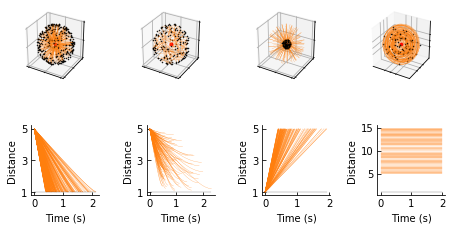

In [16]:
fig = plt.figure(figsize=(10, 4))
gs0 = gridspec.GridSpec(2, 5, figure=fig)

label_fontsize = 10
title_fontsize = 10
tick_fontsize = 10

M = 1
R = 1
dt = 0.01

## trajectories
set_number = 1256
data_path = '/Volumes/Baohua/data_on_hd/loom/multi_lplc2_D5_L4_exp/set_{}/'.format(set_number)+'other_info/'
line_color = 'tab:orange'
line_width = 0.2
n0 = 4
data_types = ['hit', 'miss', 'retreat', 'rotation']
for ind1, data_type in enumerate(data_types):
    gs00 = gridspec.GridSpecFromSubplotSpec(9, 9, subplot_spec=gs0[0, ind1])
    ax = fig.add_subplot(gs00[0:7, 0:7], projection='3d')
    if data_type != 'rotation':
        ax.plot([0], [0], [0], 'r.', markersize=6) 
        path_full = data_path+data_type+'/trajectories/'
        files = glob.glob(path_full+'*.npy')
        for ind2, file in enumerate(files):
            if ind2%n0 == 0:
                rn_arrs = np.load(file, allow_pickle=True)
                for rn_arr in rn_arrs:
                    rn_arr = np.array(rn_arr)
                    P = rn_arr.shape[1]
                    for p in range(P):
                        ax.plot(rn_arr[:, p, 0], rn_arr[:, p, 1], rn_arr[:, p, 2], c=line_color, linewidth=line_width)
                        ax.plot(rn_arr[0:1, p, 0], rn_arr[0:1, p, 1], rn_arr[0:1, p, 2], marker='.', markersize=1, markeredgecolor='k', markerfacecolor='k') 
#         ax.set_title(data_type, fontsize=title_fontsize)
        ax.set_xticks([-5, 0, 5])
        ax.set_yticks([-5, 0, 5])
        ax.set_zticks([-5, 0, 5])
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_zticklabels([])
#         ax.set_xlabel('x', fontsize = label_fontsize)
#         ax.set_ylabel('y', fontsize = label_fontsize)
#         ax.set_zlabel('z', fontsize = label_fontsize)
        ax.tick_params(direction='in', labelsize=0)
#         ax.set_axis_off()
    elif data_type == 'rotation':
#         path_full = data_path+data_type+'/trajectories/'
#         files = glob.glob(path_full+'*.npy')
#         rn_arrs = np.load(files[77], allow_pickle=True)
#         rn_arr = np.array(rn_arrs[7])
#         P = rn_arr.shape[1]
        M = 1
        R = 1
        P = 100
        steps = 200
        dt = 0.01
        D_min = 5*R
        D_max = 15*R
        Rs = np.random.random(P)*R
        theta_s = np.arccos(2*np.random.random()-1)
        phi_s = 2.*np.pi*np.random.random()
    #     xa = np.sin(theta_s)*np.cos(phi_s)
    #     ya = np.sin(theta_s)*np.sin(phi_s)
    #     za = np.cos(theta_s)
        xa = 1
        ya = -1
        za = 1
        fixed_z = -200*R
        rn_arr = smgnmu.generate_one_trajectory_rot(M, D_min, D_max, P, steps, dt, \
                                                  xa, ya, za, random_z=False, fixed_z=fixed_z)
        rn_arr_rot = rn_arr
        ax.plot([0], [0], [0], 'r.', markersize=6) 
        for p in range(P):
            if p%1 == 0:
                ax.plot(rn_arr[:, p, 0], rn_arr[:, p, 1], rn_arr[:, p, 2], c=line_color, linewidth=line_width)
                ax.plot(rn_arr[0:1, p, 0], rn_arr[0:1, p, 1], rn_arr[0:1, p, 2], marker='.', markersize=1, markeredgecolor='k', markerfacecolor='k')    
#         ax.set_title(data_type, fontsize=title_fontsize)
        ax.set_xticks([-5, 0, 5])
        ax.set_yticks([-5, 0, 5])
        ax.set_zticks([-5, 0, 5])
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_zticklabels([])
#         ax.set_xlabel('x', fontsize = label_fontsize)
#         ax.set_ylabel('y', fontsize = label_fontsize)
#         ax.set_zlabel('z', fontsize = label_fontsize)
        ax.tick_params(direction='in', labelsize=0)
#         ax.set_axis_off()

## distances
for ind1, data_type in enumerate(data_types):
    gs00 = gridspec.GridSpecFromSubplotSpec(7, 7, subplot_spec=gs0[1, ind1])
    ax = fig.add_subplot(gs00[0:5, 1:6])
    if data_type != 'rotation':
        T = 0
        path = data_path+data_type+'/distances/'
        files = glob.glob(path+'*.npy')
        for ind3, file in enumerate(files):
            if ind3%n0 == 0:
                rn_arrs = np.load(file, allow_pickle=True)
                for rn_arr in rn_arrs:
                    rn_arr = np.array(rn_arr)
                    ax.plot(np.arange(len(rn_arr)) * dt, rn_arr, c=line_color, linewidth=line_width)
                    T = np.maximum(T, len(rn_arr))
        ax.plot(np.arange(T) * dt, np.ones(T), c='k', linewidth=line_width)
        ax.spines["right"].set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.spines["bottom"].set_visible(True)
        ax.spines["left"].set_visible(True)
        ax.set_xticks([0, 1, 2])
        ax.set_yticks([1, 3, 5])
        ax.set_xlabel('Time (s)', fontsize = label_fontsize)
        ax.set_ylabel('Distance', fontsize = label_fontsize)
        ax.tick_params(direction='in', labelsize=tick_fontsize)
    elif data_type == 'rotation':
#         path = data_path+data_type+'/trajectories/'
#         files = glob.glob(path+'traj*.npy')
#         rn_arrs = np.load(files[17], allow_pickle=True)
#         rn_arr = np.array(rn_arrs[5])
        rn_arr = rn_arr_rot
        T = rn_arr.shape[0]
        P = rn_arr.shape[1]
        for p in range(P):
            if p%1 == 0:
                ci = rn_arr[0][p]
                Di = dn3d.get_radial_distance(ci[0], ci[1], ci[2])
                cf = rn_arr[-1][p]
                Df = dn3d.get_radial_distance(cf[0], cf[1], cf[2])
            ax.plot([0, T*dt], [Di, Df], c=line_color, linewidth=line_width)
        ax.plot(np.arange(T)*dt, np.ones(T), c='k', linewidth=line_width)
        ax.spines["right"].set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.spines["bottom"].set_visible(True)
        ax.spines["left"].set_visible(True)
        ax.set_xticks([0, 1, 2])
        ax.set_yticks([5, 10, 15])
        ax.set_xlabel('Time (s)', fontsize = label_fontsize)
        ax.set_ylabel('Distance', fontsize = label_fontsize)
        ax.tick_params(direction='in', labelsize=tick_fontsize)

filename = figure_path+'figures_main/stimuli_1.pdf'
fig.savefig(filename, bbox_inches='tight')

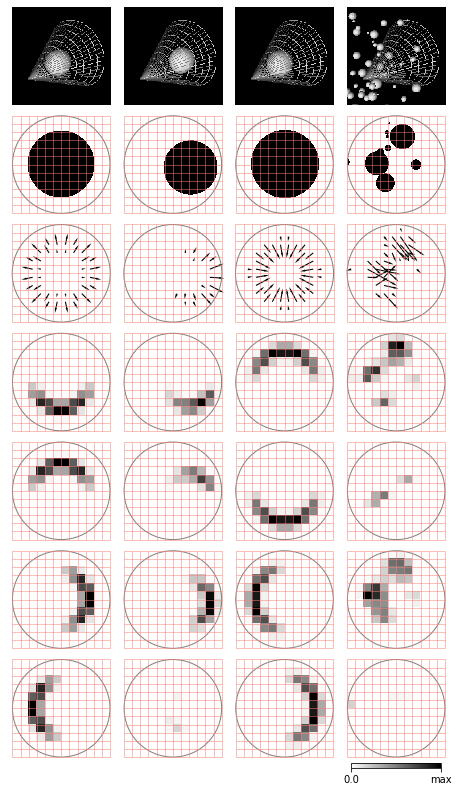

In [8]:
fig = plt.figure(figsize=(8, 16))
gs0 = gridspec.GridSpec(800+8, 400+4, figure=fig)
m = 100

label_fontsize = 10
title_fontsize = 10
tick_fontsize = 10
        
        
## Optical stimuli
M = 1
K = 12
L = 50
N = K*L
N_half = (N-1)/2.
pad = 2*L
leftup_corners = opsg.get_leftup_corners(K, L, pad)
mask2 = opsg.get_disk_mask(K, L)
steps = [143, 130, 33, 64]
data_types = ['hit', 'miss', 'retreat', 'rotation']
for ind1, data_type in enumerate(data_types):
    
    row_n = 0
    save_path_3d = figure_path+'movies/stimuli/movie_frames_3d/'+data_type+'/'
    gs00 = gridspec.GridSpecFromSubplotSpec(24, 24, subplot_spec=gs0[row_n*m+row_n:row_n*m+row_n+m, ind1*m+ind1:ind1*m+ind1+m])
    ax = fig.add_subplot(gs00[1:23, 1:23])
    step = steps[ind1]
    filename = save_path_3d+'image3d_{}'.format(step+1)
    im = Image.open(filename)
    ax.imshow(im)
    ax.axis('off')
    
    row_n = 1
    save_path = figure_path+'movies/stimuli/movie_frames/'+data_type+'/'
    frames_sample = np.load(save_path+'frames_sample.npy', allow_pickle=True)
    ax = fig.add_subplot(gs0[row_n*m+row_n:row_n*m+row_n+m, ind1*m+ind1:ind1*m+ind1+m])
    step = steps[ind1]
    cf = frames_sample[step]
    cf = np.array(cf)
    im = ax.imshow(cf[0, :, :], cmap='gray_r', vmin=0, vmax=1)
#     cbar = plt.colorbar(im, ax=ax, orientation='vertical', fraction=.042, ticks=[0, 0.5, 1])
#     cbar.ax.tick_params(labelsize=tick_fontsize)
#     cbar.ax.set_yticklabels((0, 0.5, 1))
    ax.vlines(np.arange(-0.55, N, step=N/K), -0.55, N-0.45, color='salmon', linewidth=.5)
    ax.hlines(np.arange(-0.55, N, step=N/K), -0.55, N-0.45, color='salmon', linewidth=.5)
    ax.add_patch(Circle((N_half, N_half), N_half, edgecolor=[0.5, 0.5, 0.5], facecolor='None'))
    ax.axis('off')
    
    
## Flow vector field
row_n = 2
for ind1, data_type in enumerate(data_types):
    save_path = figure_path+'movies/stimuli/movie_frames/'+data_type+'/'
    UV_flow_sample = np.load(save_path+'UV_flow_sample.npy', allow_pickle=True)
    step = steps[ind1]
    UV_flow = UV_flow_sample[step]
    # get the uv-flow
    cf_u, cf_v = flfd.set_flow_fields_on_frame(UV_flow, leftup_corners, K, L, pad)
    cf_u = np.ma.array(cf_u[0, :, :], mask=mask2)
    cf_v = np.ma.array(cf_v[0, :, :], mask=mask2)
    
    coord_u = np.arange(K)*L+L/2
    coord_v = np.arange(K)*L+L/2
    coords_u, coords_v = np.meshgrid(coord_u, np.flip(coord_v)) # coordinates of each point in the frame
    
    gs00 = gridspec.GridSpecFromSubplotSpec(96, 96, subplot_spec=gs0[row_n*m+row_n:row_n*m+row_n+m, ind1*m+ind1:ind1*m+ind1+m])
    ax = fig.add_subplot(gs00[:, 1:95])
    ax.vlines(np.arange(-0.55, N, step=N/K), -0.55, N-0.45, color='salmon', linewidth=.5)
    ax.hlines(np.arange(-0.55, N, step=N/K), -0.55, N-0.45, color='salmon', linewidth=.5)
    ax.add_patch(Circle((N_half, N_half), N_half, edgecolor=[0.5, 0.5, 0.5], facecolor='None'))
    for ii in range(coords_u.shape[0]):
        for jj in range(coords_u.shape[1]):
            if np.abs(cf_u[ii, jj]) >= 3e-2 or np.abs(cf_v[ii, jj]) >= 3e-2:
                ax.quiver(coords_u[ii, jj], coords_v[ii, jj], cf_u[ii, jj], cf_v[ii, jj], scale=1., width=0.01, headwidth=2)
    ax.axis('off')


## UV flow
v_max = 0.2
myheat_p = LinearSegmentedColormap.from_list('wk', ['w', 'k'], N=256)
myheat_m = LinearSegmentedColormap.from_list('wk', ['w', 'k'], N=256)
for ind1, data_type in enumerate(data_types):
    save_path = figure_path+'movies/stimuli/movie_frames/'+data_type+'/'
    UV_flow_sample = np.load(save_path+'UV_flow_sample.npy', allow_pickle=True)
    step = steps[ind1]
    UV_flow = UV_flow_sample[step]
    # get the uv-flow
    cf_u, cf_v = flfd.set_flow_fields_on_frame2(UV_flow, leftup_corners, K, L, pad)
    cf_u_p = np.zeros_like(cf_u[0, :, :])
    cf_u_m = np.zeros_like(cf_u[0, :, :])
    cf_v_p = np.zeros_like(cf_v[0, :, :])
    cf_v_m = np.zeros_like(cf_v[0, :, :])
    cf_u_p[:, :] = cf_u[0, :, :]
    cf_u_m[:, :] = cf_u[0, :, :]
    cf_v_p[:, :] = cf_v[0, :, :]
    cf_v_m[:, :] = cf_v[0, :, :]

    
    # V- flow
    row_n = 3
    ax = fig.add_subplot(gs0[row_n*m+row_n:row_n*m+row_n+m, ind1*m+ind1:ind1*m+ind1+m])
    vmin=np.min(cf_v.flatten())
    vmax=np.max(cf_v.flatten())
    vmax = np.max([-vmin, vmax])
    if vmax < 1e-6:
        vmax = 1
    #vmax = v_max
    cf_v_m[cf_v_m>0] = 0
    im = ax.imshow(np.abs(cf_v_m), cmap=myheat_m, vmin=0, vmax=vmax)
    ax.vlines(np.arange(-0.55, N, step=N/K), -0.55, N-0.45, color='salmon', linewidth=.5)
    ax.hlines(np.arange(-0.55, N, step=N/K), -0.55, N-0.45, color='salmon', linewidth=.5)
    ax.add_patch(Circle((N_half, N_half), N_half, edgecolor=[0.5, 0.5, 0.5], facecolor='None'))
    ax.axis('off')
    
    # V+ flow
    row_n = 4
    ax = fig.add_subplot(gs0[row_n*m+row_n:row_n*m+row_n+m, ind1*m+ind1:ind1*m+ind1+m])
    vmin=np.min(cf_v.flatten())
    vmax=np.max(cf_v.flatten())
    vmax = np.max([-vmin, vmax])
    if vmax < 1e-6:
        vmax = 1
    #vmax = v_max
    cf_v_p[cf_v_p<0] = 0
    im = ax.imshow(cf_v_p, cmap=myheat_p, vmin=0, vmax=vmax)
    ax.vlines(np.arange(-0.55, N, step=N/K), -0.55, N-0.45, color='salmon', linewidth=.5)
    ax.hlines(np.arange(-0.55, N, step=N/K), -0.55, N-0.45, color='salmon', linewidth=.5)
    ax.add_patch(Circle((N_half, N_half), N_half, edgecolor=[0.5, 0.5, 0.5], facecolor='None'))
    ax.axis('off')
    
    # U+ flow
    row_n = 5
    ax = fig.add_subplot(gs0[row_n*m+row_n:row_n*m+row_n+m, ind1*m+ind1:ind1*m+ind1+m])
    vmin=np.min(cf_u.flatten())
    vmax=np.max(cf_u.flatten())
    vmax = np.max([-vmin, vmax])
    if vmax < 1e-6:
        vmax = 1
    #vmax = v_max
    cf_u_p[cf_u_p<0] = 0
    im = ax.imshow(cf_u_p, cmap=myheat_p, vmin=0, vmax=vmax)
    ax.vlines(np.arange(-0.55, N, step=N/K), -0.55, N-0.45, color='salmon', linewidth=.5)
    ax.hlines(np.arange(-0.55, N, step=N/K), -0.55, N-0.45, color='salmon', linewidth=.5)
    ax.add_patch(Circle((N_half, N_half), N_half, edgecolor=[0.5, 0.5, 0.5], facecolor='None'))
    ax.axis('off')
    
    # U- flow
    row_n = 6
    ax = fig.add_subplot(gs0[row_n*m+row_n:row_n*m+row_n+m, ind1*m+ind1:ind1*m+ind1+m])
    vmin=np.min(cf_u.flatten())
    vmax=np.max(cf_u.flatten())
    vmax = np.max([-vmin, vmax])
    if vmax < 1e-6:
        vmax = 1
    #vmax = v_max
    cf_u_m[cf_u_p>0] = 0
    im = ax.imshow(np.abs(cf_u_m), cmap=myheat_m, vmin=0, vmax=vmax)
    ax.vlines(np.arange(-0.55, N, step=N/K), -0.55, N-0.45, color='salmon', linewidth=.5)
    ax.hlines(np.arange(-0.55, N, step=N/K), -0.55, N-0.45, color='salmon', linewidth=.5)
    ax.add_patch(Circle((N_half, N_half), N_half, edgecolor=[0.5, 0.5, 0.5], facecolor='None'))
    ax.axis('off')
    
## add colorbar
row_n = 7
gs00 = gridspec.GridSpecFromSubplotSpec(20, 1, subplot_spec=gs0[row_n*m+row_n:row_n*m+row_n+m, ind1*m+ind1:ind1*m+ind1+m])
ax = fig.add_subplot(gs00[0, 0])
im = ax.imshow(cf_v_p, cmap=myheat_p, vmin=0, vmax=vmax)
ax.set_visible(False)
cbar = plt.colorbar(im, ax=ax, orientation='horizontal', fraction=1., ticks=[0.0, vmax])
cbar.ax.tick_params(labelsize=tick_fontsize)
cbar.ax.set_xticklabels((0.0, 'max'))


filename = figure_path+'figures_main/stimuli_2.pdf'
fig.savefig(filename, bbox_inches='tight', dpi=600)


## Suplementation

Suppose that $\theta_{b}(t)$ is the angle that the object expands on the receptive field, and thus, the relation between the radius of the object $R$ and the current distance $D(t)$:

\begin{align*}
\sin\frac{\theta_{b}(t)}{2}=\frac{R}{D(t)}.
\end{align*}

Taking derivative on both side, we have:
\begin{align*}
\dot{\theta}_{b}(t) = \frac{2v}{R} \sin\frac{\theta_{b}(t)}{2} \tan\frac{\theta_{b}(t)}{2}
\end{align*}

In [9]:
# load distribution of the HRC output, long to run
M = 32
HRC_output = np.load(figure_path+f'hrc_tuning/HRC_output_M{M}.npz', allow_pickle=True)
V_hit = HRC_output['arr_0']
V_miss = HRC_output['arr_1']
V_retreat = HRC_output['arr_2']
V_rotation = HRC_output['arr_3']

Maximum angular velocity is 330.7973372530751
Normalization test: 0.9999999025394387
Normalization test: 1.0000000779053397
Normalization test: 0.9999999567396305
Normalization test: 0.9999999924429114


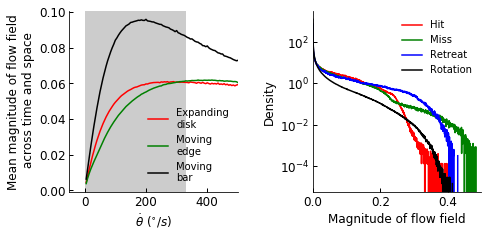

In [11]:
importlib.reload(hpfn)

fig = plt.figure(figsize=(8, 4))
gs0 = gridspec.GridSpec(1, 2, figure=fig)

label_fontsize = 12
title_fontsize = 12
tick_fontsize = 12

# HRC tuning curve
def get_angular_velocity(R, v, theta_b):
    theta_b_dot = 2. * v / R * np.sin(theta_b/2) * np.tan(theta_b/2) * (180/np.pi)
    return theta_b_dot

R = 1
L = 50
theta_b = np.pi/3
theta_b_dot_max = get_angular_velocity(R, 10, theta_b)
theta_b_dot_min = get_angular_velocity(R, 2, theta_b)
print(f'Maximum angular velocity is {theta_b_dot_max}')

v_deg_list = range(5, 2001, 5)
save_path = '/Volumes/Baohua/data_on_hd/loom/hrc_tuning/'

# Expanding disk, Delta filter
ED_delta_average = []
for v_deg in v_deg_list:
    UV_flows = np.load(save_path+\
                       f'expanding_disk_exp/UV_flow_L{L}_v_{v_deg}_exp.npy')
    ED_delta_average.append(UV_flows[UV_flows>0].mean())
# Moving edge
ME_delta_average = []
for v_deg in v_deg_list:
    UV_flows = np.load(save_path+\
                       f'moving_edge_exp/UV_flow_L{L}_v_{v_deg}_exp.npy')
    ME_delta_average.append(UV_flows[UV_flows>0].mean())
# Moving bar
MB_delta_average = []
for v_deg in v_deg_list:
    UV_flows = np.load(save_path+\
                       f'moving_bar_exp/UV_flow_L{L}_v_{v_deg}_exp.npy')
    MB_delta_average.append(UV_flows[UV_flows>0].mean())

gs00 = gridspec.GridSpecFromSubplotSpec(12, 12, subplot_spec=gs0[0, 0])
ax = fig.add_subplot(gs00[1:11, 1:11])
ax.axvspan(0, theta_b_dot_max, alpha=0.2, edgecolor=None, facecolor='k')
ax.plot(v_deg_list, ED_delta_average, 'r', alpha=1)
ax.plot(v_deg_list, ME_delta_average, 'g', alpha=1)
ax.plot(v_deg_list, MB_delta_average, 'k', alpha=1)
ax.set_xlim([-50, 500])
# ax.set_ylim([0, 0.05])
ax.set_xlabel(r'$\dot{\theta}$ ($^{\circ}/s$)', fontsize=label_fontsize)
ax.set_ylabel('Mean magnitude of flow field\n across time and space', fontsize=label_fontsize)
ax.legend(['Expanding\ndisk', 'Moving\nedge', 'Moving\nbar'], frameon=False)
ax.tick_params(direction='in', length=4, width=1, labelsize=tick_fontsize)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(True)
ax.spines["left"].set_visible(True)

# distribution of the HRC output
arr_list = [V_hit, V_miss, V_retreat, V_rotation]
color_list = ['r', 'g', 'b', 'k']
legend_list = ['Hit', 'Miss', 'Retreat', 'Rotation']
xl = 0.
xu = 0.5
yl = 0.
yu = 20.

gs00 = gridspec.GridSpecFromSubplotSpec(12, 12, subplot_spec=gs0[0, 1])
ax = fig.add_subplot(gs00[1:11, 1:11])
for ind, arr in enumerate(arr_list):
    if len(arr) > 0:
        hist, bin_centers = hpfn.get_hist(arr)
        print(f'Normalization test: {hist.sum()*(bin_centers[1]-bin_centers[0])}')
        ax.plot(bin_centers, hist, c=color_list[ind], alpha=1.)
ax.set_yscale('log')
# ax.set_ylim([yl, yu])
ax.set_xlim([xl, xu])
ax.set_xlabel('Magnitude of flow field', fontsize=label_fontsize)
ax.set_ylabel('Density', fontsize=label_fontsize)
ax.legend(legend_list, frameon=False)
ax.tick_params(direction='in', length=4, width=1, labelsize=tick_fontsize)
ax.get_yaxis().set_tick_params(which='minor', size=0)
ax.get_yaxis().set_tick_params(which='minor', width=0) 
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(True)
ax.spines["left"].set_visible(True)

if not os.path.exists(figure_path+'figures_supp/'):
    os.makedirs(figure_path+'figures_supp/')
filename = figure_path+'figures_supp/stimuli_2_sup.pdf'
fig.savefig(filename, bbox_inches='tight')

# Model

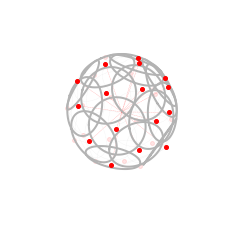

In [17]:
fig = plt.figure(figsize=(4, 4))
gs0 = gridspec.GridSpec(1, 1, figure=fig)

label_fontsize = 10
title_fontsize = 10
tick_fontsize = 10
line_width = 0.25

## M = 32
ax = fig.add_subplot(gs0[0, 0], projection='3d')
M = 32
angle_r = np.pi/6.
lplc2_units = opsg.get_lplc2_units_xy_angles(M)
_, lplc2_units_coords = opsg.get_lplc2_units(M)
for m in range(M):
    angle_m = lplc2_units[m]
    coord_m = lplc2_units_coords[m]
    angle = opsg.get_angle_two_vectors(np.array([1, 1, -1]), coord_m)
    if angle <= np.pi/2.:
        ax.plot([0, lplc2_units_coords[m, 1]], [0, lplc2_units_coords[m, 2]], [0, lplc2_units_coords[m, 0]], c='r', linewidth=0.25, linestyle=':')
for m in range(M):
    angle_m = lplc2_units[m]
    coord_m = lplc2_units_coords[m]
    angle = opsg.get_angle_two_vectors(np.array([1, 1, -1]), coord_m)
    if angle > np.pi/2.:
        c_vec_list = hpfn.get_c_vec_list(angle_m, angle_r, 100)
        ax.plot(c_vec_list[:, 0, 1], c_vec_list[:, 0, 2], c_vec_list[:, 0, 0], '--', c=[0.9, 0.9, 0.9], linewidth = 0.25)
        ax.plot(lplc2_units_coords[m, 1:2], lplc2_units_coords[m, 2:], lplc2_units_coords[m, 0:1], c='r', marker='o', markersize=4, alpha=0.1)
for m in range(M):
    angle_m = lplc2_units[m]
    coord_m = lplc2_units_coords[m]
    angle = opsg.get_angle_two_vectors(np.array([1, 1, -1]), coord_m)
    if angle <= np.pi/2.:
        c_vec_list = hpfn.get_c_vec_list(angle_m, angle_r, 100)
        ax.plot(c_vec_list[:, 0, 1], c_vec_list[:, 0, 2], c_vec_list[:, 0, 0], c=[0.7, 0.7, 0.7], linewidth = 2)
for m in range(M):
    angle_m = lplc2_units[m]
    coord_m = lplc2_units_coords[m]
    angle = opsg.get_angle_two_vectors(np.array([1, 1, -1]), coord_m)
    if angle <= np.pi/2.:
        ax.plot(lplc2_units_coords[m, 1:2], lplc2_units_coords[m, 2:], lplc2_units_coords[m, 0:1], c='r', marker='o', markersize=4)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.set_axis_off()

plt.show()
filename = figure_path+'figures_main/model_3d.pdf'
fig.savefig(filename, bbox_inches='tight')

# Single units

In [4]:
has_inhibition = True
figure_path = '/Volumes/Baohua/research/loom_detection/results/final_figures_for_paper_exp/'
if not os.path.exists(figure_path):
    os.mkdir(figure_path)

199
199


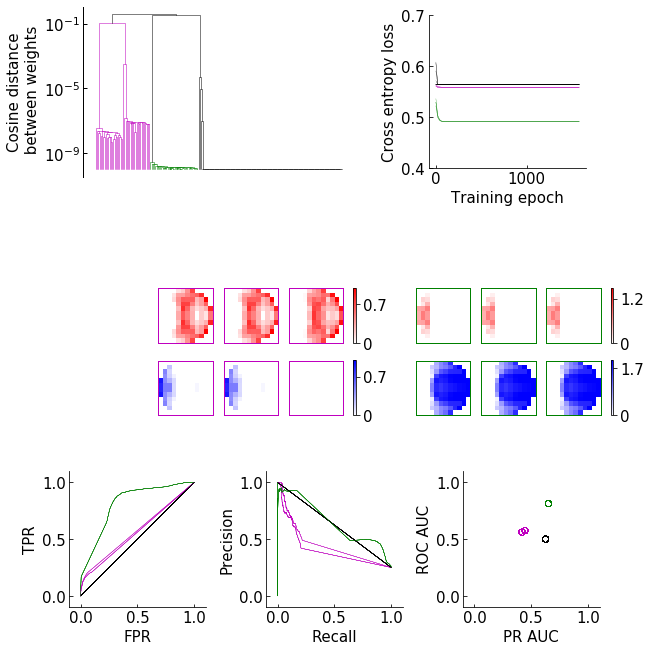

In [9]:
fig = plt.figure(figsize=(10, 12))
gs0 = gridspec.GridSpec(6, 5, figure=fig)

color_marker_dict = {'k':'.', 'm':'.', 'g':'.'}

M = 1
label_fontsize = 15
title_fontsize = 15
tick_fontsize = 15
line_width = 0.25
marker_size = 160

## Dendrogram
gs00 = gridspec.GridSpecFromSubplotSpec(12, 12, subplot_spec=gs0[0:2, :3])
ax = fig.add_subplot(gs00[1:11, 1:11])

data_path = figure_path+'model_clustering/clusterings/Z_M{}.npy'.format(M)
Z = np.load(data_path)
data_path = figure_path+'model_clustering/clusterings/color_list_unique_M{}.npy'.format(M)
color_list_unique = list(np.load(data_path))

hierarchy.set_link_color_palette(color_list_unique)
dn = hierarchy.dendrogram(Z, color_threshold=0.2, above_threshold_color='k', no_plot=True, no_labels=True)
leaves_colors = dn['leaves_color_list']
leaves_labels = np.array(dn['leaves'])
icoord1 = np.array(dn['icoord'])
dcoord1 = np.log10(np.array(dn['dcoord'])+1e-10)
print(len(dn['color_list']))
print(len(icoord1))
for xs, ys, color in zip(icoord1, dcoord1, dn['color_list']):
    ax.plot(xs, ys, color=color, linewidth=0.5)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_linewidth(1)
ax.set_xlim([-100, 2100])
ax.set_xticks([])
ax.set_yticks([-9, -5, -1])
ax.set_yticklabels([r'$10^{-9}$', r'$10^{-5}$', r'$10^{-1}$'])
ax.set_ylabel('Cosine distance\n between weights', fontsize=label_fontsize)
ax.tick_params(direction='in', length=4, width=1, labelsize=tick_fontsize)


## CE loss
plotted = []
gs00 = gridspec.GridSpecFromSubplotSpec(8, 8, subplot_spec=gs0[0:2, 3:5])
ax = fig.add_subplot(gs00[1:7, 1:7])
data_path = figure_path+'model_clustering/clusterings/'
model_folders = np.load(data_path+'model_folders_M{}.npy'.format(M), allow_pickle=True)
nn = len(model_folders[0])
for n in range(nn):
    if n%10 == 0:
        model_path = model_folders[0][n]+'/'
        loss_function = np.load(model_path+'train_loss_output.npy')
        loss_function_averaged = loss_function.reshape(-1, 80).mean(axis=1)
        loss_function_averaged = loss_function_averaged.reshape(-1, 20).mean(axis=1)
        p1 = ax.plot(loss_function_averaged, c='m', linewidth=line_width)
        if n == 0:
            plotted.append(p1)
nn = len(model_folders[1])
for n in range(nn):
    if n%10 == 0:
        model_path = model_folders[1][n]+'/'
        loss_function = np.load(model_path+'train_loss_output.npy')
        loss_function_averaged = loss_function.reshape(-1, 80).mean(axis=1)
        loss_function_averaged = loss_function_averaged.reshape(-1, 20).mean(axis=1)
        p2 = ax.plot(loss_function_averaged, c='g', linewidth=line_width)
        if n == 0:
            plotted.append(p2)
nn = len(model_folders[2])
for n in range(nn):
    if n%10 == 0:
        model_path = model_folders[2][n]+'/'
        loss_function = np.load(model_path+'train_loss_output.npy')
        loss_function_averaged = loss_function.reshape(-1, 80).mean(axis=1)
        loss_function_averaged = loss_function_averaged.reshape(-1, 20).mean(axis=1)
        p2 = ax.plot(loss_function_averaged, c='k', linewidth=line_width)
        if n == 0:
            plotted.append(p2)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(True)
ax.spines["left"].set_visible(True)
ax.set_ylim([0.4, 0.7])
ax.set_xlabel('Training epoch', fontsize=label_fontsize)
ax.set_ylabel('Cross entropy loss', fontsize=label_fontsize)
ax.set_xticks([0, 50])
ax.set_xticklabels([0, 1000])
ax.tick_params(direction='in', labelsize=tick_fontsize)
#     ax.legend(plotted[:], ['outward', 'inward'], prop={'size': 35})


## show the trained weights
gs00 = gridspec.GridSpecFromSubplotSpec(3, 11, subplot_spec=gs0[2:4, :])

data_path = figure_path+'model_clustering/clusterings/subdir_all_M{}.npy'.format(M)
subdir_all = np.load(data_path)
data_path = figure_path+'model_clustering/clusterings/model_folders_M{}.npy'.format(M)
model_folders = np.load(data_path, allow_pickle=True)
data_path = figure_path+'model_clustering/clusterings/color_list_M{}.npy'.format(M)
color_list = np.load(data_path)

# outward filters
gs000 = gridspec.GridSpecFromSubplotSpec(2, 3, subplot_spec=gs00[1:3, 2:6])

if has_inhibition:
    colormap_e = LinearSegmentedColormap.from_list('wr', ['w', 'r'], N=256)
else:
    colormap_e = LinearSegmentedColormap.from_list('bwr', ['b', 'w', 'r'], N=256)
colormap_i = LinearSegmentedColormap.from_list('wb', ['w', 'b'], N=256)
extreme_e = 1.0
extreme_i = 1.0
K = 12
L = 4
mask_d = opsg.get_disk_mask(K, L)
LL = len(model_folders[0])
leaves_outward = [label for color, label in zip(leaves_colors, leaves_labels) if color=='m']
random_list = random.sample(leaves_outward, 3)
axes = []
axis = []
for ind, ii in enumerate(random_list):
    model_path = subdir_all[ii]+'/'
    axe = fig.add_subplot(gs000[0, ind])
    axes.append(axe)
    trained_weights_e = np.load(model_path+'trained_weights_e.npy')
    trained_weights_e = trained_weights_e[:, 0].reshape((K, K))
    trained_weights_e[mask_d] = 0.
#     extreme_e = np.amax(np.abs(trained_weights_e))
    if has_inhibition:
        color_norm_e = mpl.colors.Normalize(vmin=0, vmax=extreme_e)
    else:
        color_norm_e = mpl.colors.Normalize(vmin=-extreme_e, vmax=extreme_e)
    ime = axe.imshow(trained_weights_e, norm=color_norm_e, cmap=colormap_e)
    axe.set_xticks([])
    axe.set_yticks([])
    plt.setp(axe.spines.values(), color='m', linewidth=1)
cbar = plt.colorbar(ime, ax=axes, orientation='vertical', fraction=.014, ticks=[0, extreme_e-0.3])
cbar.ax.tick_params(labelsize=tick_fontsize)
cbar.ax.set_yticklabels((0, extreme_e-0.3))

for ind, ii in enumerate(random_list):
    model_path = subdir_all[ii]+'/'
    axi = fig.add_subplot(gs000[1, ind])
    axis.append(axi)
    trained_weights_i = np.load(model_path+'trained_weights_i.npy')
    trained_weights_i = trained_weights_i[:, 0].reshape((K, K))
    trained_weights_i[mask_d] = 0.
#         extreme_i = np.amax(np.abs(trained_weights_i))
    color_norm_i = mpl.colors.Normalize(vmin=0, vmax=extreme_i)
    imi = axi.imshow(trained_weights_i, norm=color_norm_i, cmap=colormap_i)
    axi.set_xticks([])
    axi.set_yticks([])
    plt.setp(axi.spines.values(), color='m', linewidth=1)
cbar = plt.colorbar(imi, ax=axis, orientation='vertical', fraction=.014, ticks=[0, extreme_i-0.3])
cbar.ax.tick_params(labelsize=tick_fontsize)
cbar.ax.set_yticklabels((0, extreme_i-0.3))
        
        
# inward filters
gs000 = gridspec.GridSpecFromSubplotSpec(2, 3, subplot_spec=gs00[1:3, 7:11])
extreme_e = 1.5
extreme_i = 2.0
LL = len(model_folders[0])
leaves_inward = [label for color, label in zip(leaves_colors, leaves_labels) if color=='g']
random_list = random.sample(leaves_inward, 3)
axes = []
axis = []
for ind, ii in enumerate(random_list):
    model_path = subdir_all[ii]+'/'
    axe = fig.add_subplot(gs000[0, ind])
    axes.append(axe)
    trained_weights_e = np.load(model_path+'trained_weights_e.npy')
    trained_weights_e = trained_weights_e[:, 0].reshape((K, K))
    trained_weights_e[mask_d] = 0.
#     extreme_e = np.amax(np.abs(trained_weights_e))
    if has_inhibition:
        color_norm_e = mpl.colors.Normalize(vmin=0, vmax=extreme_e)
    else:
        color_norm_e = mpl.colors.Normalize(vmin=-extreme_e, vmax=extreme_e)
    ime = axe.imshow(trained_weights_e, norm=color_norm_e, cmap=colormap_e)
    axe.set_xticks([])
    axe.set_yticks([])
    plt.setp(axe.spines.values(), color='g', linewidth=1)
cbar = plt.colorbar(ime, ax=axes, orientation='vertical', fraction=.014, ticks=[0, extreme_e-0.3])
cbar.ax.tick_params(labelsize=tick_fontsize)
cbar.ax.set_yticklabels((0, extreme_e-0.3))

for ind, ii in enumerate(random_list):
    model_path = subdir_all[ii]+'/'
    axi = fig.add_subplot(gs000[1, ind])
    axis.append(axi)
    trained_weights_i = np.load(model_path+'trained_weights_i.npy')
    trained_weights_i = trained_weights_i[:, 0].reshape((K, K))
    trained_weights_i[mask_d] = 0.
#         extreme_i = np.amax(np.abs(trained_weights_i))
    color_norm_i = mpl.colors.Normalize(vmin=0, vmax=extreme_i)
    imi = axi.imshow(trained_weights_i, norm=color_norm_i, cmap=colormap_i)
    axi.set_xticks([])
    axi.set_yticks([])
    plt.setp(axi.spines.values(), color='g', linewidth=1)
cbar = plt.colorbar(imi, ax=axis, orientation='vertical', fraction=.014, ticks=[0, extreme_i-0.3])
cbar.ax.tick_params(labelsize=tick_fontsize)
cbar.ax.set_yticklabels((0, extreme_i-0.3))


## ROC and PR curves
gs00 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs0[4:6, :])

data_path = figure_path+'model_clustering/auc_scores/'
y_labels_all = np.load(data_path+'y_trues_M{}.npy'.format(M), allow_pickle=True)
y_scores_all = np.load(data_path+'y_scores_M{}.npy'.format(M), allow_pickle=True)

fpr_all = []
tpr_all = []
thres_roc_all = []
roc_auc_all = []
precision_all = []
recall_all = []
thres_pr_all = []
pr_auc_all = []
for ind, y_labels in enumerate(y_labels_all):
    y_scores = np.round(y_scores_all[ind], 4)
    fpr, tpr, _ = metrics.roc_curve(y_labels, y_scores)
    precision, recall, _ = metrics.precision_recall_curve(y_labels, y_scores)
    roc_auc = metrics.roc_auc_score(y_labels, y_scores)
    pr_auc = metrics.auc(recall, precision)
#     aps = metrics.average_precision_score(y_labels, y_scores)

    fpr_all.append(fpr)
    tpr_all.append(tpr)
    roc_auc_all.append(roc_auc)

    precision_all.append(precision)
    recall_all.append(recall)
    pr_auc_all.append(pr_auc)

# roc curve
gs000 = gridspec.GridSpecFromSubplotSpec(12, 12, subplot_spec=gs00[0, 0])
ax = fig.add_subplot(gs000[1:11, 1:11])
for ind, color, fpr, tpr in zip(range(len(color_list)), color_list, fpr_all, tpr_all):
    if ind%5 == 0:
        ax.plot(fpr, tpr, c=color, linewidth=line_width)
ax.axis('scaled')
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(True)
ax.spines["left"].set_visible(True)
ax.set_xlim([-0.1, 1.1])
ax.set_ylim([-0.1, 1.1])
ax.set_xticks([0, 0.5, 1])
ax.set_yticks([0, 0.5, 1])
ax.set_xlabel('FPR', fontsize=label_fontsize)
ax.set_ylabel('TPR', fontsize=label_fontsize)
ax.tick_params(direction='in', labelsize=tick_fontsize)

# pr curve
gs000 = gridspec.GridSpecFromSubplotSpec(12, 12, subplot_spec=gs00[0, 1])
ax = fig.add_subplot(gs000[1:11, 1:11])
for ind, color, precision, recall in zip(range(len(color_list)), color_list, precision_all, recall_all):
    if ind%5 == 0:
        ax.plot(recall, precision, c=color, linewidth=line_width)
ax.axis('scaled')
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(True)
ax.spines["left"].set_visible(True)
ax.set_xlim([-0.1, 1.1])
ax.set_ylim([-0.1, 1.1])
ax.set_xticks([0, 0.5, 1])
ax.set_yticks([0, 0.5, 1])
ax.set_xlabel('Recall', fontsize=label_fontsize)
ax.set_ylabel('Precision', fontsize=label_fontsize)
ax.tick_params(direction='in', labelsize=tick_fontsize)

# scores
gs000 = gridspec.GridSpecFromSubplotSpec(12, 12, subplot_spec=gs00[0, 2])
ax = fig.add_subplot(gs000[1:11, 1:11])
added_noisex = np.random.normal(0, 0.0, len(roc_auc_all))
added_noisey = np.random.normal(0, 0.0, len(pr_auc_all))
# ax.scatter(np.array(pr_auc_all)+added_noisey, np.array(roc_auc_all)+added_noisex, s=12, c=color_list, marker='o', alpha=0.5)
marker_list = [color_marker_dict[key] for key in color_list]
for ind, x, y, c_, marker_ in zip(range(len(color_list)), pr_auc_all, roc_auc_all, color_list, marker_list):
    if ind%5 == 0:
        ax.scatter(np.array(x)+added_noisey, np.array(y)+added_noisex, s=marker_size, facecolors='None', edgecolors=c_, marker=marker_, alpha=0.5, linewidths=0.25)
ax.axis('scaled')
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(True)
ax.spines["left"].set_visible(True)
ax.set_xlim([-0.1, 1.1])
ax.set_ylim([-0.1, 1.1])
ax.set_xticks([0, 0.5, 1])
ax.set_yticks([0, 0.5, 1])
ax.set_xlabel('PR AUC', fontsize=label_fontsize)
ax.set_ylabel('ROC AUC', fontsize=label_fontsize)
ax.tick_params(direction='in', labelsize=tick_fontsize)
            
plt.show()
filename = figure_path+'figures_main/trained_results_M{}.pdf'.format(M)
fig.savefig(filename, bbox_inches='tight')
# fig.savefig(filename)


## Suplementary

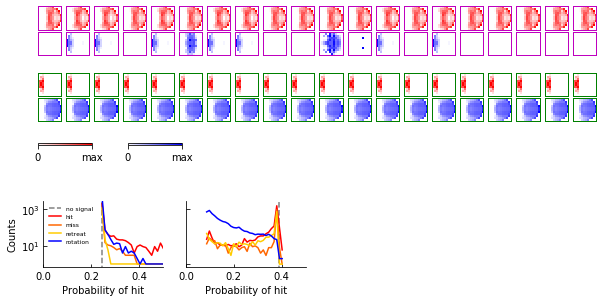

In [92]:
fig = plt.figure(figsize=(10, 4.8))
gs0 = gridspec.GridSpec(8, 1, figure=fig)

M = 1
label_fontsize = 10
title_fontsize = 10
tick_fontsize = 10
line_width = 0.25

data_path = figure_path+'model_clustering/clusterings/Z_M{}.npy'.format(M)
Z = np.load(data_path)
data_path = figure_path+'model_clustering/clusterings/color_list_unique_M{}.npy'.format(M)
color_list_unique = list(np.load(data_path))

hierarchy.set_link_color_palette(color_list_unique)
dn = hierarchy.dendrogram(Z, color_threshold=0.2, above_threshold_color='k', no_plot=True, no_labels=True)
leaves_colors = dn['leaves_color_list']
leaves_labels = np.array(dn['leaves'])

## show the trained weights
data_path = figure_path+'model_clustering/clusterings/subdir_all_M{}.npy'.format(M)
subdir_all = np.load(data_path)
data_path = figure_path+'model_clustering/clusterings/model_folders_M{}.npy'.format(M)
model_folders = np.load(data_path, allow_pickle=True)
data_path = figure_path+'model_clustering/clusterings/color_list_M{}.npy'.format(M)
color_list = np.load(data_path)

# outward filters
gs00 = gridspec.GridSpecFromSubplotSpec(5, 20, subplot_spec=gs0[0:2, 0])

if has_inhibition:
    colormap_e = LinearSegmentedColormap.from_list('wr', ['w', 'r'], N=256)
else:
    colormap_e = LinearSegmentedColormap.from_list('bwr', ['b', 'w', 'r'], N=256)
colormap_i = LinearSegmentedColormap.from_list('wb', ['w', 'b'], N=256)
extreme_e = 1.0
extreme_i = 1.0
K = 12
L = 4
mask_d = opsg.get_disk_mask(K, L)
LL = len(model_folders[0])
leaves_outward = [label for color, label in zip(leaves_colors, leaves_labels) if color=='m']
axes = []
axis = []
for ii in range(20):
    if ii < len(model_folders[0]):
        model_path = model_folders[0][ii]+'/'
        axe = fig.add_subplot(gs00[0:2, ii])
        axes.append(axe)
        trained_weights_e = np.load(model_path+'trained_weights_e.npy')
        trained_weights_e = trained_weights_e[:, 0].reshape((K, K))
        trained_weights_e[mask_d] = 0.
        extreme_e = np.amax(np.abs(trained_weights_e))
        if has_inhibition:
            color_norm_e = mpl.colors.Normalize(vmin=0, vmax=extreme_e)
        else:
            color_norm_e = mpl.colors.Normalize(vmin=-extreme_e, vmax=extreme_e)
        ime = axe.imshow(trained_weights_e, norm=color_norm_e, cmap=colormap_e)
        axe.set_xticks([])
        axe.set_yticks([])
        plt.setp(axe.spines.values(), color='m', linewidth=1)

for ii in range(20):
    if ii < len(model_folders[0]):
        model_path = model_folders[0][ii]+'/'
        axi = fig.add_subplot(gs00[2:4, ii])
        axis.append(axi)
        trained_weights_i = np.load(model_path+'trained_weights_i.npy')
        trained_weights_i = trained_weights_i[:, 0].reshape((K, K))
        trained_weights_i[mask_d] = 0.
        extreme_i = np.amax(np.abs(trained_weights_i))
        color_norm_i = mpl.colors.Normalize(vmin=0, vmax=extreme_i)
        imi = axi.imshow(trained_weights_i, norm=color_norm_i, cmap=colormap_i)
        axi.set_xticks([])
        axi.set_yticks([])
        plt.setp(axi.spines.values(), color='m', linewidth=1)
        
        
# inward filters
gs00 = gridspec.GridSpecFromSubplotSpec(5, 20, subplot_spec=gs0[2:4, 0])
extreme_e = 1.5
extreme_i = 2.0
LL = len(model_folders[1])
leaves_inward = [label for color, label in zip(leaves_colors, leaves_labels) if color=='g']
axes = []
axis = []
for ii in range(20):
    if ii < len(model_folders[1]):
        model_path = model_folders[1][ii]+'/'
        axe = fig.add_subplot(gs00[0:2, ii])
        axes.append(axe)
        trained_weights_e = np.load(model_path+'trained_weights_e.npy')
        trained_weights_e = trained_weights_e[:, 0].reshape((K, K))
        trained_weights_e[mask_d] = 0.
        extreme_e = np.amax(np.abs(trained_weights_e))
        if has_inhibition:
            color_norm_e = mpl.colors.Normalize(vmin=0, vmax=extreme_e)
        else:
            color_norm_e = mpl.colors.Normalize(vmin=-extreme_e, vmax=extreme_e)
        ime = axe.imshow(trained_weights_e, norm=color_norm_e, cmap=colormap_e)
        axe.set_xticks([])
        axe.set_yticks([])
        plt.setp(axe.spines.values(), color='g', linewidth=1)

for ii in range(20):
    if ii < len(model_folders[1]):
        model_path = model_folders[1][ii]+'/'
        axi = fig.add_subplot(gs00[2:4, ii])
        axis.append(axi)
        trained_weights_i = np.load(model_path+'trained_weights_i.npy')
        trained_weights_i = trained_weights_i[:, 0].reshape((K, K))
        trained_weights_i[mask_d] = 0.
        extreme_i = np.amax(np.abs(trained_weights_i))
        color_norm_i = mpl.colors.Normalize(vmin=0, vmax=extreme_i)
        imi = axi.imshow(trained_weights_i, norm=color_norm_i, cmap=colormap_i)
        axi.set_xticks([])
        axi.set_yticks([])
        plt.setp(axi.spines.values(), color='g', linewidth=1)
        
        
# Add colorbar
cb_orient = 'horizontal'
gs000 = gridspec.GridSpecFromSubplotSpec(4, 50, subplot_spec=gs0[4, 0])
axe = fig.add_subplot(gs000[0, 0:5])
ime = axe.imshow(trained_weights_e, norm=color_norm_e, cmap=colormap_e)
axe.set_visible(False)
cbar = plt.colorbar(ime, ax=axe, orientation=cb_orient, fraction=.5, ticks=[0, extreme_e])
cbar.ax.tick_params(labelsize=tick_fontsize)
cbar.ax.set_xticklabels(('0', 'max'))

axi = fig.add_subplot(gs000[0, 8:13])
imi = axi.imshow(trained_weights_i, norm=color_norm_i, cmap=colormap_i)
axi.set_visible(False)
cbar = plt.colorbar(imi, ax=axi, orientation=cb_orient, fraction=.5, ticks=[0, extreme_i])
cbar.ax.tick_params(labelsize=tick_fontsize)
cbar.ax.set_xticklabels(('0', 'max'))

## Probability distribution
filter_types = ['outward', 'inward']

filter_type = filter_types[0]
save_file = figure_path+'probability_of_hit/'+'results'+'_'+filter_type+'_M{}.npz'.format(M)
loaded_file = np.load(save_file, allow_pickle=True)
dist_min_n = loaded_file['arr_0']
res_T_all_n = loaded_file['arr_1']
prob_mean_n = loaded_file['arr_2']
prob_max_n = loaded_file['arr_3']
prob_all_n = loaded_file['arr_4']
prob_rest_n = loaded_file['arr_5']



filter_type = filter_types[1]
save_file = figure_path+'probability_of_hit/'+'results'+'_'+filter_type+'_M{}.npz'.format(M)
loaded_file = np.load(save_file, allow_pickle=True)
dist_min_r = loaded_file['arr_0']
res_T_all_r = loaded_file['arr_1']
prob_mean_r = loaded_file['arr_2']
prob_max_r = loaded_file['arr_3']
prob_all_r = loaded_file['arr_4']
prob_rest_r = loaded_file['arr_5']

color_list = [[1, 0, 0], [1, 0.4, 0], [1, 0.8, 0], 'b']
nn = 1
prob_mean_n_hit = np.array(prob_mean_n[0])
prob_mean_r_hit = np.array(prob_mean_r[0])
prob_mean_n_nohit = np.concatenate((prob_mean_n[1], prob_mean_n[2], prob_mean_n[3]))
prob_mean_r_nohit = np.concatenate((prob_mean_r[1], prob_mean_r[2], prob_mean_r[3]))

prob_mean_n_all = np.concatenate((prob_mean_n_hit, prob_mean_n_nohit))
prob_mean_r_all = np.concatenate((prob_mean_r_hit, prob_mean_r_nohit))
prob_max_n = prob_mean_n_all.max()
prob_min_n = prob_mean_n_all.min()
prob_max_r = prob_mean_r_all.max()
prob_min_r = prob_mean_r_all.min()
bins_n = np.linspace(prob_min_n, prob_max_n, 30)
bins_r = np.linspace(prob_min_r, prob_max_r, 30)

gs00 = gridspec.GridSpecFromSubplotSpec(1, 8, subplot_spec=gs0[5:8, 0])
# outward
gs000 = gridspec.GridSpecFromSubplotSpec(24, 24, subplot_spec=gs00[0, 0:2])
ax = fig.add_subplot(gs000[7:24, 1:23])
plotted = []
p0 = ax.plot([prob_rest_n[0], prob_rest_n[0]], [0, 3000], 'grey', linestyle='--')
plotted.append(p0)
counts, bins = np.histogram(prob_mean_n[0], bins=bins_n)
counts = counts+1
p1 = ax.plot(bins[:-1], counts, color=color_list[0])
plotted.append(p1)
counts, bins = np.histogram(prob_mean_n[1], bins=bins_n)
counts = counts+1
p2 = ax.plot(bins[:-1], counts, color=color_list[1])
plotted.append(p2)
counts, bins = np.histogram(prob_mean_n[2], bins=bins_n)
counts = counts+1
p3 = ax.plot(bins[:-1], counts, color=color_list[2])
plotted.append(p3)
counts, bins = np.histogram(prob_mean_n[3], bins=bins_n)
counts = counts+1
p4 = ax.plot(bins[:-1], counts, color=color_list[3])
plotted.append(p4)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(True)
ax.spines["left"].set_visible(True)
ax.set_yscale('log')
ax.set_xlabel('Probability of hit', fontsize=label_fontsize)
ax.set_ylabel('Counts', fontsize=label_fontsize)
ax.set_xlim([0, 0.5])
ax.set_ylim([0, 3000])
ax.minorticks_off()
ax.tick_params(direction='in', labelsize=tick_fontsize)
ax.legend(['no signal', 'hit', 'miss', 'retreat', 'rotation'], prop={'size': 6}, frameon=False)

# inward
gs000 = gridspec.GridSpecFromSubplotSpec(24, 24, subplot_spec=gs00[0, 2:4])
ax = fig.add_subplot(gs000[7:24, 1:23])
plotted = []
ax.plot([prob_rest_r[0], prob_rest_r[0]], [0, 3000], color='grey', linestyle='--')
counts, bins = np.histogram(prob_mean_r[0], bins=bins_r)
counts = counts+1
p1 = ax.plot(bins[:-1], counts, color=color_list[0])
plotted.append(p1)
counts, bins = np.histogram(prob_mean_r[1], bins=bins_r)
counts = counts+1
p2 = ax.plot(bins[:-1], counts, color=color_list[1])
plotted.append(p2)
counts, bins = np.histogram(prob_mean_r[2], bins=bins_r)
counts = counts+1
p3 = ax.plot(bins[:-1], counts, color=color_list[2])
plotted.append(p3)
counts, bins = np.histogram(prob_mean_r[3], bins=bins_r)
counts = counts+1
p4 = ax.plot(bins[:-1], counts, color=color_list[3])
plotted.append(p4)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(True)
ax.spines["left"].set_visible(True)
ax.set_yscale('log')
ax.set_xlabel('Probability of hit', fontsize=label_fontsize)
ax.set_yticks([1, 1000])
ax.set_yticklabels([])
ax.set_xlim([0, 0.5])
ax.set_ylim([0, 3000])
ax.minorticks_off()
ax.tick_params(direction='in', labelsize=tick_fontsize)

plt.show()
filename = figure_path+'figures_supp/trained_results_M{}_sup.pdf'.format(M)
fig.savefig(filename, bbox_inches='tight')


# Multiple units

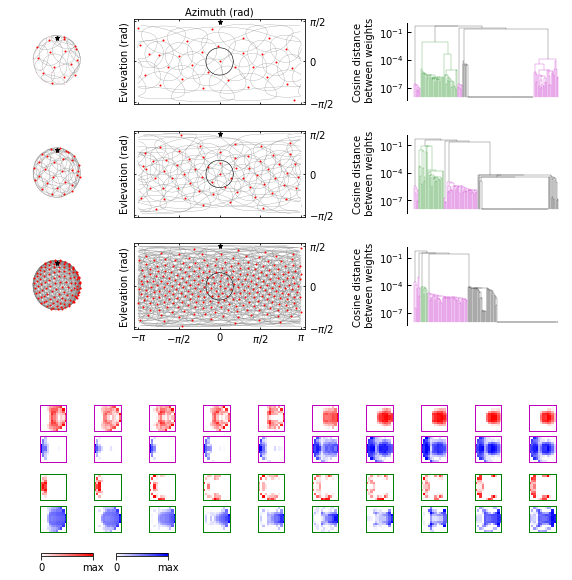

In [95]:
importlib.reload(hpfn)

fig = plt.figure(figsize=(10, 10))
gs0 = gridspec.GridSpec(5, 5, figure=fig)

label_fontsize = 10
title_fontsize = 10
tick_fontsize = 10
line_width = 0.25

## M = 32
ax = fig.add_subplot(gs0[0, 0], projection='3d')
M = 32
angle_r = np.pi/6.
lplc2_units = opsg.get_lplc2_units_xy_angles(M)
_, lplc2_units_coords = opsg.get_lplc2_units(M)
for m in range(M):
    angle_m = lplc2_units[m]
    coord_m = lplc2_units_coords[m]
    angle = opsg.get_angle_two_vectors(np.array([1, 1, -1]), coord_m)
    if angle > np.pi/2.:
        c_vec_list = hpfn.get_c_vec_list(angle_m, angle_r, 100)
        ax.plot(c_vec_list[:, 0, 1], c_vec_list[:, 0, 2], c_vec_list[:, 0, 0], '--', c=[0.9, 0.9, 0.9], linewidth = 0.25)
        ax.plot(lplc2_units_coords[m, 1:2], lplc2_units_coords[m, 2:], lplc2_units_coords[m, 0:1], c='r', marker='o', markersize=1, alpha=0.1)
for m in range(M):
    angle_m = lplc2_units[m]
    coord_m = lplc2_units_coords[m]
    angle = opsg.get_angle_two_vectors(np.array([1, 1, -1]), coord_m)
    if angle <= np.pi/2.:
        c_vec_list = hpfn.get_c_vec_list(angle_m, angle_r, 100)
        ax.plot(c_vec_list[:, 0, 1], c_vec_list[:, 0, 2], c_vec_list[:, 0, 0], c=[0.5, 0.5, 0.5], linewidth = 0.25)
for m in range(M):
    angle_m = lplc2_units[m]
    coord_m = lplc2_units_coords[m]
    angle = opsg.get_angle_two_vectors(np.array([1, 1, -1]), coord_m)
    if angle <= np.pi/2.:
        ax.plot(lplc2_units_coords[m, 1:2], lplc2_units_coords[m, 2:], lplc2_units_coords[m, 0:1], c='r', marker='o', markersize=1)
ax.plot([0], [0], [1.], color='k', marker='*', markersize=5)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.set_axis_off()

## M = 64
ax = fig.add_subplot(gs0[1, 0], projection='3d')
M = 64
angle_r = np.pi/6.
lplc2_units = opsg.get_lplc2_units_xy_angles(M)
_, lplc2_units_coords = opsg.get_lplc2_units(M)
for m in range(M):
    angle_m = lplc2_units[m]
    coord_m = lplc2_units_coords[m]
    angle = opsg.get_angle_two_vectors(np.array([1, 1, -1]), coord_m)
    if angle > np.pi/2.:
        c_vec_list = hpfn.get_c_vec_list(angle_m, angle_r, 100)
        ax.plot(c_vec_list[:, 0, 1], c_vec_list[:, 0, 2], c_vec_list[:, 0, 0], '--', c=[0.9, 0.9, 0.9], linewidth = 0.25)
        ax.plot(lplc2_units_coords[m, 1:2], lplc2_units_coords[m, 2:], lplc2_units_coords[m, 0:1], c='r', marker='o', markersize=1, alpha=0.1)
for m in range(M):
    angle_m = lplc2_units[m]
    coord_m = lplc2_units_coords[m]
    angle = opsg.get_angle_two_vectors(np.array([1, 1, -1]), coord_m)
    if angle <= np.pi/2.:
        c_vec_list = hpfn.get_c_vec_list(angle_m, angle_r, 100)
        ax.plot(c_vec_list[:, 0, 1], c_vec_list[:, 0, 2], c_vec_list[:, 0, 0], c=[0.5, 0.5, 0.5], linewidth = 0.25)
for m in range(M):
    angle_m = lplc2_units[m]
    coord_m = lplc2_units_coords[m]
    angle = opsg.get_angle_two_vectors(np.array([1, 1, -1]), coord_m)
    if angle <= np.pi/2.:
        ax.plot(lplc2_units_coords[m, 1:2], lplc2_units_coords[m, 2:], lplc2_units_coords[m, 0:1], c='r', marker='o', markersize=1)
ax.plot([0], [0], [1.], color='k', marker='*', markersize=5)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.set_axis_off()

## M = 256
ax = fig.add_subplot(gs0[2, 0], projection='3d')
M = 256
angle_r = np.pi/6.
lplc2_units = opsg.get_lplc2_units_xy_angles(M)
_, lplc2_units_coords = opsg.get_lplc2_units(M)
for m in range(M):
    angle_m = lplc2_units[m]
    coord_m = lplc2_units_coords[m]
    angle = opsg.get_angle_two_vectors(np.array([1, 1, -1]), coord_m)
    if angle > np.pi/2.:
        c_vec_list = hpfn.get_c_vec_list(angle_m, angle_r, 100)
        ax.plot(c_vec_list[:, 0, 1], c_vec_list[:, 0, 2], c_vec_list[:, 0, 0], '--', c=[0.9, 0.9, 0.9], linewidth = 0.25)
        ax.plot(lplc2_units_coords[m, 1:2], lplc2_units_coords[m, 2:], lplc2_units_coords[m, 0:1], c='r', marker='o', markersize=1, alpha=0.1)
for m in range(M):
    angle_m = lplc2_units[m]
    coord_m = lplc2_units_coords[m]
    angle = opsg.get_angle_two_vectors(np.array([1, 1, -1]), coord_m)
    if angle <= np.pi/2.:
        c_vec_list = hpfn.get_c_vec_list(angle_m, angle_r, 100)
        ax.plot(c_vec_list[:, 0, 1], c_vec_list[:, 0, 2], c_vec_list[:, 0, 0], c=[0.5, 0.5, 0.5], linewidth = 0.25)
for m in range(M):
    angle_m = lplc2_units[m]
    coord_m = lplc2_units_coords[m]
    angle = opsg.get_angle_two_vectors(np.array([1, 1, -1]), coord_m)
    if angle <= np.pi/2.:
        ax.plot(lplc2_units_coords[m, 1:2], lplc2_units_coords[m, 2:], lplc2_units_coords[m, 0:1], c='r', marker='o', markersize=1)
ax.plot([0], [0], [1.], color='k', marker='*', markersize=5)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.set_axis_off()


## mapping, M = 32
M = 32
gs00 = gridspec.GridSpecFromSubplotSpec(24, 24, subplot_spec=gs0[0, 1:3])
ax = fig.add_subplot(gs00[1:23, 0:22])
N = 100
angle_np = np.array([0., np.pi/2])
if M == 1:
    lplc2_units = np.array([[0, 0]])
else:
    lplc2_units = opsg.get_lplc2_units_xy_angles(M)
angle_mc = lplc2_units[1]
angle_r = np.pi/6
for m in range(M):
    angle_m = lplc2_units[m]
    angles_on_map = hpfn.get_projection_one_unit(angle_mc, angle_m, angle_r, N)
    segments_list = hpfn.get_segments(angles_on_map[3:])
    for segment in segments_list:
        ax.plot(segment[:, 0], segment[:, 1], c=[0.5, 0.5, 0.5], linewidth = 0.25, alpha=1)
# Emphasize the boundary of the central unit
angles_on_map = hpfn.get_projection_one_unit(angle_mc, angle_mc, angle_r, N)
segments_list = hpfn.get_segments(angles_on_map[3:])
for segment in segments_list:
    ax.plot(segment[:, 0], segment[:, 1], c='k', linewidth = 0.5, alpha=1)
# Add centers
for m in range(M):
    angle_m = lplc2_units[m]
    angles_on_map = hpfn.get_projection_one_unit(angle_mc, angle_m, angle_r, N)
    zz = angles_on_map[2]
    ax.plot(zz[0], zz[1], c='r', marker='o', markersize=1)
# Add north pole
angles_np_on_map = hpfn.get_projection_one_unit(angle_mc, angle_np, angle_r, N)
ax.plot(angles_np_on_map[2][0], angles_np_on_map[2][1], c='k', marker='*', markersize=5)
ax.set_xlim([-np.pi*1.05, np.pi*1.05])
ax.set_ylim([-np.pi/2*1.05, np.pi/2*1.05])
ax.set_xticks([-np.pi, -np.pi/2, 0., np.pi/2, np.pi])
ax.set_xticklabels([])
ax.set_yticks([-np.pi/2, 0., np.pi/2])
ax.set_yticklabels(['$-\pi/2$', '0', '$\pi/2$'])
ax.set_xlabel('Azimuth (rad)', fontsize=label_fontsize)
ax.set_ylabel('Evlevation (rad)', fontsize=label_fontsize)
ax.set_aspect('equal', adjustable='box')
ax.xaxis.set_label_position('top')
ax.yaxis.tick_right()
ax.tick_params(direction='in', length=2, labelsize=tick_fontsize, bottom=True, top=True, left=True, right=True)


## mapping, M = 64
M = 64
gs00 = gridspec.GridSpecFromSubplotSpec(24, 24, subplot_spec=gs0[1, 1:3])
ax = fig.add_subplot(gs00[1:23, 0:22])
N = 100
angle_np = np.array([0., np.pi/2])
if M == 1:
    lplc2_units = np.array([[0, 0]])
else:
    lplc2_units = opsg.get_lplc2_units_xy_angles(M)
angle_mc = lplc2_units[1]
angle_r = np.pi/6
for m in range(M):
    angle_m = lplc2_units[m]
    angles_on_map = hpfn.get_projection_one_unit(angle_mc, angle_m, angle_r, N)
    segments_list = hpfn.get_segments(angles_on_map[3:])
    for segment in segments_list:
        ax.plot(segment[:, 0], segment[:, 1], c=[0.5, 0.5, 0.5], linewidth = 0.25, alpha=1)
# Emphasize the boundary of the central unit
angles_on_map = hpfn.get_projection_one_unit(angle_mc, angle_mc, angle_r, N)
segments_list = hpfn.get_segments(angles_on_map[3:])
for segment in segments_list:
    ax.plot(segment[:, 0], segment[:, 1], c='k', linewidth = 0.5, alpha=1)
# Add centers
for m in range(M):
    angle_m = lplc2_units[m]
    angles_on_map = hpfn.get_projection_one_unit(angle_mc, angle_m, angle_r, N)
    zz = angles_on_map[2]
    ax.plot(zz[0], zz[1], c='r', marker='o', markersize=1)
# Add north pole
angles_np_on_map = hpfn.get_projection_one_unit(angle_mc, angle_np, angle_r, N)
ax.plot(angles_np_on_map[2][0], angles_np_on_map[2][1], c='k', marker='*', markersize=5)
ax.set_xlim([-np.pi*1.05, np.pi*1.05])
ax.set_ylim([-np.pi/2*1.05, np.pi/2*1.05])
ax.set_xticks([-np.pi, -np.pi/2, 0., np.pi/2, np.pi])
ax.set_xticklabels([])
ax.set_yticks([-np.pi/2, 0., np.pi/2])
ax.set_yticklabels(['$-\pi/2$', '0', '$\pi/2$'])
ax.set_ylabel('Evlevation (rad)', fontsize=label_fontsize)
ax.set_aspect('equal', adjustable='box')
ax.yaxis.tick_right()
ax.tick_params(direction='in', length=2, labelsize=tick_fontsize, bottom=True, top=True, left=True, right=True)


## mapping, M = 256
M = 256
gs00 = gridspec.GridSpecFromSubplotSpec(24, 24, subplot_spec=gs0[2, 1:3])
ax = fig.add_subplot(gs00[1:23, 0:22])
N = 100
angle_np = np.array([0., np.pi/2])
if M == 1:
    lplc2_units = np.array([[0, 0]])
else:
    lplc2_units = opsg.get_lplc2_units_xy_angles(M)
angle_mc = lplc2_units[1]
angle_r = np.pi/6
for m in range(M):
    angle_m = lplc2_units[m]
    angles_on_map = hpfn.get_projection_one_unit(angle_mc, angle_m, angle_r, N)
    segments_list = hpfn.get_segments(angles_on_map[3:])
    for segment in segments_list:
        ax.plot(segment[:, 0], segment[:, 1], c=[0.5, 0.5, 0.5], linewidth = 0.25, alpha=1)
# Emphasize the boundary of the central unit
angles_on_map = hpfn.get_projection_one_unit(angle_mc, angle_mc, angle_r, N)
segments_list = hpfn.get_segments(angles_on_map[3:])
for segment in segments_list:
    ax.plot(segment[:, 0], segment[:, 1], c='k', linewidth = 0.5, alpha=1)
# Add centers
for m in range(M):
    angle_m = lplc2_units[m]
    angles_on_map = hpfn.get_projection_one_unit(angle_mc, angle_m, angle_r, N)
    zz = angles_on_map[2]
    ax.plot(zz[0], zz[1], c='r', marker='o', markersize=1)
# Add north pole
angles_np_on_map = hpfn.get_projection_one_unit(angle_mc, angle_np, angle_r, N)
ax.plot(angles_np_on_map[2][0], angles_np_on_map[2][1], c='k', marker='*', markersize=5)
ax.set_xlim([-np.pi*1.05, np.pi*1.05])
ax.set_ylim([-np.pi/2*1.05, np.pi/2*1.05])
ax.set_xticks([-np.pi, -np.pi/2, 0., np.pi/2, np.pi])
ax.set_xticklabels(['$-\pi$', '$-\pi/2$', '0', '$\pi/2$', '$\pi$'])
ax.set_yticks([-np.pi/2, 0., np.pi/2])
ax.set_yticklabels(['$-\pi/2$', '0', '$\pi/2$'])
ax.set_ylabel('Evlevation (rad)', fontsize=label_fontsize)
ax.set_aspect('equal', adjustable='box')
ax.yaxis.tick_right()
ax.tick_params(direction='in', length=2, labelsize=tick_fontsize, bottom=True, top=True, left=True, right=True)


## Dendrogram, M = 32
gs00 = gridspec.GridSpecFromSubplotSpec(12, 12, subplot_spec=gs0[0, 3:])
ax = fig.add_subplot(gs00[1:11, 3:12])

M = 32
data_path = figure_path+'model_clustering/clusterings/Z_M{}.npy'.format(M)
Z = np.load(data_path)
data_path = figure_path+'model_clustering/clusterings/color_list_unique_M{}.npy'.format(M)
color_list_unique = list(np.load(data_path))

hierarchy.set_link_color_palette(color_list_unique)
dn = hierarchy.dendrogram(Z, color_threshold=0.2, above_threshold_color='k', no_plot=True, no_labels=True)
leaves_colors = dn['leaves_color_list']
leaves_labels = np.array(dn['leaves'])
icoord1 = np.array(dn['icoord'])
dcoord1 = np.log10(np.array(dn['dcoord'])+1e-8)
for xs, ys, color in zip(icoord1, dcoord1, dn['color_list']):
    ax.plot(xs, ys, color=color, linewidth=line_width)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_linewidth(1)
ax.set_yticks([-7, -4, -1])
ax.set_yticklabels([r'$10^{-7}$', r'$10^{-4}$', r'$10^{-1}$'])
ax.set_ylabel('Cosine distance\n between weights', fontsize=label_fontsize)
ax.tick_params(direction='in', length=4, width=1, labelsize=tick_fontsize)
ax.set_xticks([])


## Dendrogram, M = 64
gs00 = gridspec.GridSpecFromSubplotSpec(12, 12, subplot_spec=gs0[1, 3:])
ax = fig.add_subplot(gs00[1:11, 3:12])

M = 64
data_path = figure_path+'model_clustering/clusterings/Z_M{}.npy'.format(M)
Z = np.load(data_path)
data_path = figure_path+'model_clustering/clusterings/color_list_unique_M{}.npy'.format(M)
color_list_unique = list(np.load(data_path))

hierarchy.set_link_color_palette(color_list_unique)
dn = hierarchy.dendrogram(Z, color_threshold=0.2, above_threshold_color='k', no_plot=True, no_labels=True)
leaves_colors = dn['leaves_color_list']
leaves_labels = np.array(dn['leaves'])
icoord1 = np.array(dn['icoord'])
dcoord1 = np.log10(np.array(dn['dcoord'])+1e-8)
for xs, ys, color in zip(icoord1, dcoord1, dn['color_list']):
    ax.plot(xs, ys, color=color, linewidth=line_width)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_linewidth(1)
ax.set_yticks([-7, -4, -1])
ax.set_yticklabels([r'$10^{-7}$', r'$10^{-4}$', r'$10^{-1}$'])
ax.set_ylabel('Cosine distance\n between weights', fontsize=label_fontsize)
ax.tick_params(direction='in', length=4, width=1, labelsize=tick_fontsize)
ax.set_xticks([])


## Dendrogram, M = 256
gs00 = gridspec.GridSpecFromSubplotSpec(12, 12, subplot_spec=gs0[2, 3:])
ax = fig.add_subplot(gs00[1:11, 3:12])

M = 256
data_path = figure_path+'model_clustering/clusterings/Z_M{}.npy'.format(M)
Z = np.load(data_path)
data_path = figure_path+'model_clustering/clusterings/color_list_unique_M{}.npy'.format(M)
color_list_unique = list(np.load(data_path))

hierarchy.set_link_color_palette(color_list_unique)
dn = hierarchy.dendrogram(Z, color_threshold=0.2, above_threshold_color='k', no_plot=True, no_labels=True)
leaves_colors = dn['leaves_color_list']
leaves_labels = np.array(dn['leaves'])
icoord1 = np.array(dn['icoord'])
dcoord1 = np.log10(np.array(dn['dcoord'])+1e-8)
for xs, ys, color in zip(icoord1, dcoord1, dn['color_list']):
    ax.plot(xs, ys, color=color, linewidth=line_width)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_linewidth(1)
ax.set_yticks([-7, -4, -1])
ax.set_yticklabels([r'$10^{-7}$', r'$10^{-4}$', r'$10^{-1}$'])
ax.set_ylabel('Cosine distance\n between weights', fontsize=label_fontsize)
ax.tick_params(direction='in', length=4, width=1, labelsize=tick_fontsize)
ax.set_xticks([])


## show the trained weights
gs00 = gridspec.GridSpecFromSubplotSpec(8, 24, subplot_spec=gs0[3:, :])
extreme_e = 3
extreme_i = 5
gs000 = gridspec.GridSpecFromSubplotSpec(1, 10, subplot_spec=gs00[2:7, 1:24])
for ind, M in enumerate([1, 2, 4, 8, 16, 32, 64, 128, 192, 256]):
    gs0000 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs000[0, ind])
    data_path = figure_path+'model_clustering/clusterings/model_folders_M{}.npy'.format(M)
    model_folders = np.load(data_path, allow_pickle=True)

    # outward filters
    gs00000 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs0000[0, 0])
#     LL = len(model_folders[0])
#     ii = random.sample(range(LL), 1)[0]
    model_path = model_folders[0][2]+'/'
    K = 12
    mask_d = opsg.get_disk_mask(12, 4)
    if has_inhibition:
        colormap_e = LinearSegmentedColormap.from_list('wr', ['w', 'r'], N=256)
    else:
        colormap_e = LinearSegmentedColormap.from_list('bwr', ['b', 'w', 'r'], N=256)
    colormap_i = LinearSegmentedColormap.from_list('wb', ['w', 'b'], N=256)
    axe = fig.add_subplot(gs00000[0, 0])
    trained_weights_e = np.load(model_path+'trained_weights_e.npy')
    trained_weights_e = trained_weights_e[:, 0].reshape((K, K))
    trained_weights_e[mask_d] = 0.
    extreme_e = np.round(np.amax(np.abs(trained_weights_e)), 1)
    if has_inhibition:
        color_norm_e = mpl.colors.Normalize(vmin=0, vmax=extreme_e)
    else:
        color_norm_e = mpl.colors.Normalize(vmin=-extreme_e, vmax=extreme_e)
    ime = axe.imshow(trained_weights_e, norm=color_norm_e, cmap=colormap_e)
    axe.set_xticks([])
    axe.set_yticks([])
    plt.setp(axe.spines.values(), color='m', linewidth=1)

    if has_inhibition:
        axi = fig.add_subplot(gs00000[1, 0])
        trained_weights_i = np.load(model_path+'trained_weights_i.npy')
        trained_weights_i = trained_weights_i[:, 0].reshape((K, K))
        trained_weights_i[mask_d] = 0.
        extreme_i = np.round(np.amax(np.abs(trained_weights_i)), 1)
        color_norm_i = mpl.colors.Normalize(vmin=0, vmax=extreme_i)
        imi = axi.imshow(trained_weights_i, norm=color_norm_i, cmap=colormap_i)
        axi.set_xticks([])
        axi.set_yticks([])
        plt.setp(axi.spines.values(), color='m', linewidth=1)

    # inward filters
    gs00000 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs0000[1, 0])
#     LL = len(model_folders[1])
#     ii = random.sample(range(LL), 1)[0]
    model_path = model_folders[1][2]+'/'
    K = 12
    mask_d = opsg.get_disk_mask(12, 4)
    axe = fig.add_subplot(gs00000[0, 0])
    trained_weights_e = np.load(model_path+'trained_weights_e.npy')
    trained_weights_e = trained_weights_e[:, 0].reshape((K, K))
    trained_weights_e[mask_d] = 0.
    extreme_e = np.round(np.amax(np.abs(trained_weights_e)), 1)
    if has_inhibition:
        color_norm_e = mpl.colors.Normalize(vmin=0, vmax=extreme_e)
    else:
        color_norm_e = mpl.colors.Normalize(vmin=-extreme_e, vmax=extreme_e)
    ime = axe.imshow(trained_weights_e, norm=color_norm_e, cmap=colormap_e)
    axe.set_xticks([])
    axe.set_yticks([])
    plt.setp(axe.spines.values(), color='g', linewidth=1)

    if has_inhibition:
        axi = fig.add_subplot(gs00000[1, 0])
        trained_weights_i = np.load(model_path+'trained_weights_i.npy')
        trained_weights_i = trained_weights_i[:, 0].reshape((K, K))
        trained_weights_i[mask_d] = 0.
        extreme_i = np.round(np.amax(np.abs(trained_weights_i)), 1)
        color_norm_i = mpl.colors.Normalize(vmin=0, vmax=extreme_i)
        imi = axi.imshow(trained_weights_i, norm=color_norm_i, cmap=colormap_i)
        axi.set_xticks([])
        axi.set_yticks([])
        plt.setp(axi.spines.values(), color='g', linewidth=1)
        
# Add colorbar
cb_orient = 'horizontal'
gs000 = gridspec.GridSpecFromSubplotSpec(2, 50, subplot_spec=gs00[7, 1:24])
axe = fig.add_subplot(gs000[1, 1:6])
ime = axe.imshow(trained_weights_e, norm=color_norm_e, cmap=colormap_e)
axe.set_visible(False)
cbar = plt.colorbar(ime, ax=axe, orientation=cb_orient, fraction=.5, ticks=[0, extreme_e])
cbar.ax.tick_params(labelsize=tick_fontsize)
cbar.ax.set_xticklabels(('0', 'max'))

axi = fig.add_subplot(gs000[1, 8:13])
imi = axi.imshow(trained_weights_i, norm=color_norm_i, cmap=colormap_i)
axi.set_visible(False)
cbar = plt.colorbar(imi, ax=axi, orientation=cb_orient, fraction=.5, ticks=[0, extreme_i])
cbar.ax.tick_params(labelsize=tick_fontsize)
cbar.ax.set_xticklabels(('0', 'max'))

plt.show()
filename = figure_path+'figures_main/trained_results_multiunits.pdf'
fig.savefig(filename, bbox_inches='tight')


## Suplementation

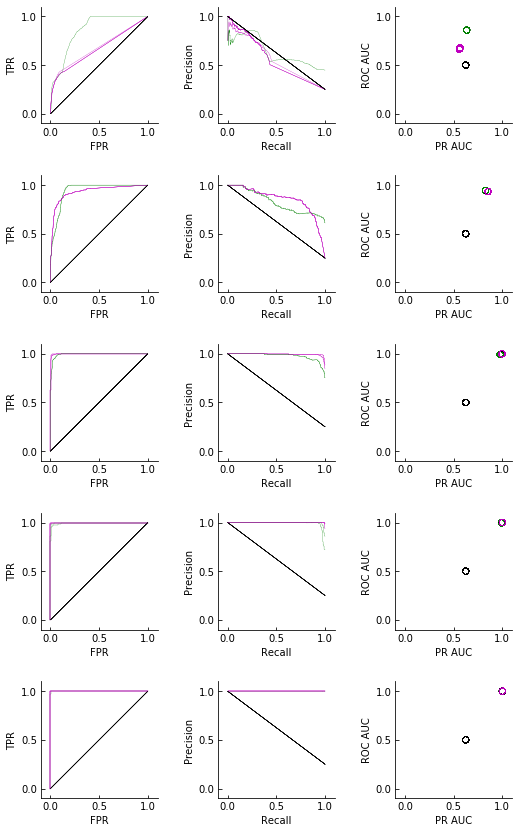

In [7]:
importlib.reload(hpfn)

fig = plt.figure(figsize=(9, 15))
gs0 = gridspec.GridSpec(5, 1, figure=fig)

label_fontsize = 10
title_fontsize = 10
tick_fontsize = 10
line_width = 0.25
marker_size = 160

color_marker_dict = {'k':'.', 'm':'.', 'g':'.'}
M_list = [2, 8, 32, 64, 256]

for ind, M in enumerate(M_list):
    ## ROC and PR curves
    gs00 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs0[ind, 0])

    data_path = figure_path+'model_clustering/clusterings/color_list_M{}.npy'.format(M)
    color_list = np.load(data_path)
    data_path = figure_path+'model_clustering/auc_scores/'
    y_labels_all = np.load(data_path+'y_trues_M{}.npy'.format(M), allow_pickle=True)
    y_scores_all = np.load(data_path+'y_scores_M{}.npy'.format(M), allow_pickle=True)

    fpr_all = []
    tpr_all = []
    thres_roc_all = []
    roc_auc_all = []
    precision_all = []
    recall_all = []
    thres_pr_all = []
    pr_auc_all = []
    for ind, y_labels in enumerate(y_labels_all):
        y_scores = np.round(y_scores_all[ind], 4)
        fpr, tpr, _ = metrics.roc_curve(y_labels, y_scores)
        precision, recall, _ = metrics.precision_recall_curve(y_labels, y_scores)
        roc_auc = metrics.roc_auc_score(y_labels, y_scores)
        pr_auc = metrics.auc(recall, precision)
#     aps = metrics.average_precision_score(y_labels, y_scores)

        fpr_all.append(fpr)
        tpr_all.append(tpr)
        roc_auc_all.append(roc_auc)

        precision_all.append(precision)
        recall_all.append(recall)
        pr_auc_all.append(pr_auc)

    # roc curve
    gs000 = gridspec.GridSpecFromSubplotSpec(12, 12, subplot_spec=gs00[0, 0])
    ax = fig.add_subplot(gs000[1:11, 1:11])
    for ind, color, fpr, tpr in zip(range(len(color_list)), color_list, fpr_all, tpr_all):
        if ind%10 == 0:
            ax.plot(fpr, tpr, c=color, linewidth=line_width)
    ax.axis('scaled')
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(True)
    ax.spines["left"].set_visible(True)
    ax.set_xlim([-0.1, 1.1])
    ax.set_ylim([-0.1, 1.1])
    ax.set_xticks([0, 0.5, 1])
    ax.set_yticks([0, 0.5, 1])
    ax.set_xlabel('FPR', fontsize=label_fontsize)
    ax.set_ylabel('TPR', fontsize=label_fontsize)
    ax.tick_params(direction='in', labelsize=tick_fontsize)

    # pr curve
    gs000 = gridspec.GridSpecFromSubplotSpec(12, 12, subplot_spec=gs00[0, 1])
    ax = fig.add_subplot(gs000[1:11, 1:11])
    for ind, color, precision, recall in zip(range(len(color_list)), color_list, precision_all, recall_all):
        if ind%10 == 0:
            ax.plot(recall, precision, c=color, linewidth=line_width)
    ax.axis('scaled')
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(True)
    ax.spines["left"].set_visible(True)
    ax.set_xlim([-0.1, 1.1])
    ax.set_ylim([-0.1, 1.1])
    ax.set_xticks([0, 0.5, 1])
    ax.set_yticks([0, 0.5, 1])
    ax.set_xlabel('Recall', fontsize=label_fontsize)
    ax.set_ylabel('Precision', fontsize=label_fontsize)
    ax.tick_params(direction='in', labelsize=tick_fontsize)

    # scores
    gs000 = gridspec.GridSpecFromSubplotSpec(12, 12, subplot_spec=gs00[0, 2])
    ax = fig.add_subplot(gs000[1:11, 1:11])
    added_noisex = np.random.normal(0, 0.0, len(roc_auc_all))
    added_noisey = np.random.normal(0, 0.0, len(pr_auc_all))
    marker_list = [color_marker_dict[key] for key in color_list]
    for ind, x, y, c_, marker_ in zip(range(len(color_list)), pr_auc_all, roc_auc_all, color_list, marker_list):
        if ind%10 == 0:
            ax.scatter(np.array(x)+added_noisey, np.array(y)+added_noisex, s=marker_size, facecolors='None', edgecolors=c_, marker=marker_, alpha=0.5, linewidths=0.25)
    ax.axis('scaled')
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(True)
    ax.spines["left"].set_visible(True)
    ax.set_xlim([-0.1, 1.1])
    ax.set_ylim([-0.1, 1.1])
    ax.set_xticks([0, 0.5, 1])
    ax.set_yticks([0, 0.5, 1])
    ax.set_xlabel('PR AUC', fontsize=label_fontsize)
    ax.set_ylabel('ROC AUC', fontsize=label_fontsize)
    ax.tick_params(direction='in', labelsize=tick_fontsize)

            
plt.show()
filename = figure_path+'figures_supp/trained_results_multiunits_sup1.pdf'.format(M)
fig.savefig(filename, bbox_inches='tight')



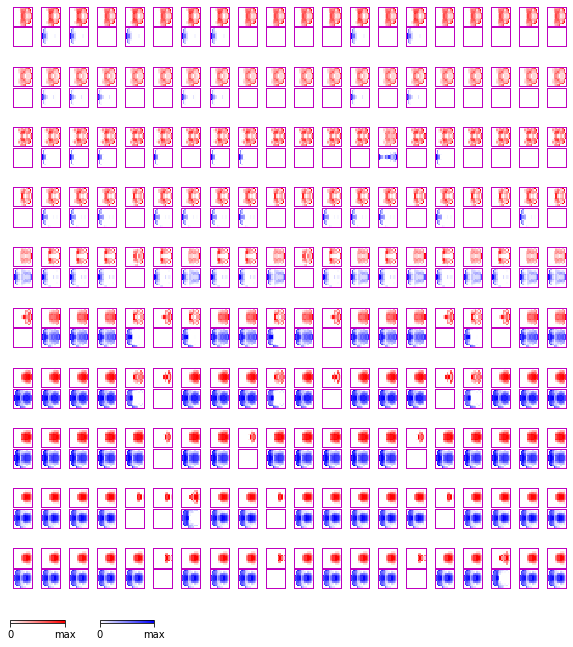

In [30]:
importlib.reload(hpfn)

fig = plt.figure(figsize=(10, 12))
gs0 = gridspec.GridSpec(11, 1, figure=fig)

label_fontsize = 10
title_fontsize = 10
tick_fontsize = 10
line_width = 0.25

## show the trained weights
for ind, M in enumerate([1, 2, 4, 8, 16, 32, 64, 128, 192, 256]):
    gs00 = gridspec.GridSpecFromSubplotSpec(5, 20, subplot_spec=gs0[ind, 0])
    data_path = figure_path+'model_clustering/clusterings/model_folders_M{}.npy'.format(M)
    model_folders = np.load(data_path, allow_pickle=True)

    # outward filters
    for ii in range(20):
        if ii < len(model_folders[0]):
            model_path = model_folders[0][ii]+'/'
            K = 12
            mask_d = opsg.get_disk_mask(12, 4)
            if has_inhibition:
                colormap_e = LinearSegmentedColormap.from_list('wr', ['w', 'r'], N=256)
            else:
                colormap_e = LinearSegmentedColormap.from_list('bwr', ['b', 'w', 'r'], N=256)
            colormap_i = LinearSegmentedColormap.from_list('wb', ['w', 'b'], N=256)
            axe = fig.add_subplot(gs00[0:2, ii])
            trained_weights_e = np.load(model_path+'trained_weights_e.npy')
            trained_weights_e = trained_weights_e[:, 0].reshape((K, K))
            trained_weights_e[mask_d] = 0.
            extreme_e = np.round(np.amax(np.abs(trained_weights_e)), 1)
            if has_inhibition:
                color_norm_e = mpl.colors.Normalize(vmin=0, vmax=extreme_e)
            else:
                color_norm_e = mpl.colors.Normalize(vmin=-extreme_e, vmax=extreme_e)
            ime = axe.imshow(trained_weights_e, norm=color_norm_e, cmap=colormap_e)
            axe.set_xticks([])
            axe.set_yticks([])
            plt.setp(axe.spines.values(), color='m', linewidth=1)

            if has_inhibition:
                axi = fig.add_subplot(gs00[2:4, ii])
                trained_weights_i = np.load(model_path+'trained_weights_i.npy')
                trained_weights_i = trained_weights_i[:, 0].reshape((K, K))
                trained_weights_i[mask_d] = 0.
                extreme_i = np.round(np.amax(np.abs(trained_weights_i)), 1)
                color_norm_i = mpl.colors.Normalize(vmin=0, vmax=extreme_i)
                imi = axi.imshow(trained_weights_i, norm=color_norm_i, cmap=colormap_i)
                axi.set_xticks([])
                axi.set_yticks([])
                plt.setp(axi.spines.values(), color='m', linewidth=1)
        
# Add colorbar
cb_orient = 'horizontal'
gs00 = gridspec.GridSpecFromSubplotSpec(2, 50, subplot_spec=gs0[10, 0])
axe = fig.add_subplot(gs00[0, 0:5])
ime = axe.imshow(trained_weights_e, norm=color_norm_e, cmap=colormap_e)
axe.set_visible(False)
cbar = plt.colorbar(ime, ax=axe, orientation=cb_orient, fraction=.5, ticks=[0, extreme_e])
cbar.ax.tick_params(labelsize=tick_fontsize)
cbar.ax.set_xticklabels(('0', 'max'))

axi = fig.add_subplot(gs00[0, 8:13])
imi = axi.imshow(trained_weights_i, norm=color_norm_i, cmap=colormap_i)
axi.set_visible(False)
cbar = plt.colorbar(imi, ax=axi, orientation=cb_orient, fraction=.5, ticks=[0, extreme_i])
cbar.ax.tick_params(labelsize=tick_fontsize)
cbar.ax.set_xticklabels(('0', 'max'))

plt.show()
filename = figure_path+'figures_supp/trained_results_multiunits_sup2.pdf'
fig.savefig(filename, bbox_inches='tight')
# fig.savefig(filename)

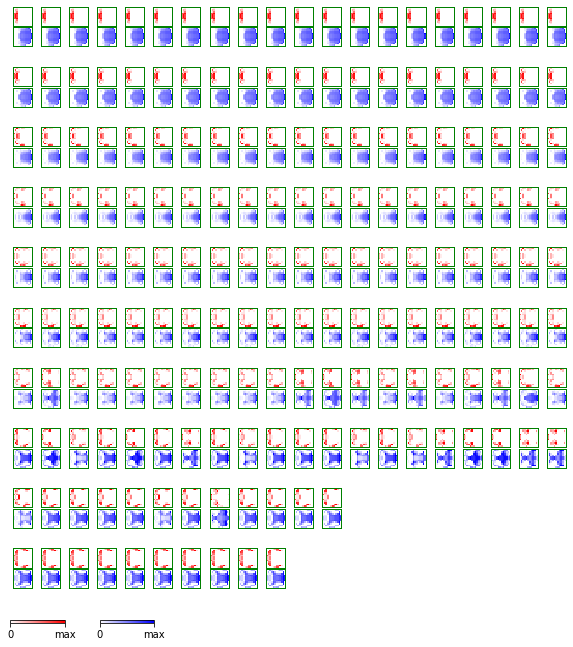

In [31]:
importlib.reload(hpfn)

fig = plt.figure(figsize=(10, 12))
gs0 = gridspec.GridSpec(11, 1, figure=fig)

label_fontsize = 10
title_fontsize = 10
tick_fontsize = 10
line_width = 0.25

## show the trained weights
for ind, M in enumerate([1, 2, 4, 8, 16, 32, 64, 128, 192, 256]):
    gs00 = gridspec.GridSpecFromSubplotSpec(5, 20, subplot_spec=gs0[ind, 0])
    data_path = figure_path+'model_clustering/clusterings/model_folders_M{}.npy'.format(M)
    model_folders = np.load(data_path, allow_pickle=True)

    # outward filters
    for ii in range(20):
        if ii < len(model_folders[1]):
            model_path = model_folders[1][ii]+'/'
            K = 12
            mask_d = opsg.get_disk_mask(12, 4)
            if has_inhibition:
                colormap_e = LinearSegmentedColormap.from_list('wr', ['w', 'r'], N=256)
            else:
                colormap_e = LinearSegmentedColormap.from_list('bwr', ['b', 'w', 'r'], N=256)
            colormap_i = LinearSegmentedColormap.from_list('wb', ['w', 'b'], N=256)
            axe = fig.add_subplot(gs00[0:2, ii])
            trained_weights_e = np.load(model_path+'trained_weights_e.npy')
            trained_weights_e = trained_weights_e[:, 0].reshape((K, K))
            trained_weights_e[mask_d] = 0.
            extreme_e = np.round(np.amax(np.abs(trained_weights_e)), 1)
            if has_inhibition:
                color_norm_e = mpl.colors.Normalize(vmin=0, vmax=extreme_e)
            else:
                color_norm_e = mpl.colors.Normalize(vmin=-extreme_e, vmax=extreme_e)
            ime = axe.imshow(trained_weights_e, norm=color_norm_e, cmap=colormap_e)
            axe.set_xticks([])
            axe.set_yticks([])
            plt.setp(axe.spines.values(), color='g', linewidth=1)

            if has_inhibition:
                axi = fig.add_subplot(gs00[2:4, ii])
                trained_weights_i = np.load(model_path+'trained_weights_i.npy')
                trained_weights_i = trained_weights_i[:, 0].reshape((K, K))
                trained_weights_i[mask_d] = 0.
                extreme_i = np.round(np.amax(np.abs(trained_weights_i)), 1)
                color_norm_i = mpl.colors.Normalize(vmin=0, vmax=extreme_i)
                imi = axi.imshow(trained_weights_i, norm=color_norm_i, cmap=colormap_i)
                axi.set_xticks([])
                axi.set_yticks([])
                plt.setp(axi.spines.values(), color='g', linewidth=1)
        
# Add colorbar
cb_orient = 'horizontal'
gs00 = gridspec.GridSpecFromSubplotSpec(2, 50, subplot_spec=gs0[10, 0])
axe = fig.add_subplot(gs00[0, 0:5])
ime = axe.imshow(trained_weights_e, norm=color_norm_e, cmap=colormap_e)
axe.set_visible(False)
cbar = plt.colorbar(ime, ax=axe, orientation=cb_orient, fraction=.5, ticks=[0, extreme_e])
cbar.ax.tick_params(labelsize=tick_fontsize)
cbar.ax.set_xticklabels(('0', 'max'))

axi = fig.add_subplot(gs00[0, 8:13])
imi = axi.imshow(trained_weights_i, norm=color_norm_i, cmap=colormap_i)
axi.set_visible(False)
cbar = plt.colorbar(imi, ax=axi, orientation=cb_orient, fraction=.5, ticks=[0, extreme_i])
cbar.ax.tick_params(labelsize=tick_fontsize)
cbar.ax.set_xticklabels(('0', 'max'))

plt.show()
filename = figure_path+'figures_supp/trained_results_multiunits_sup3.pdf'
fig.savefig(filename, bbox_inches='tight')


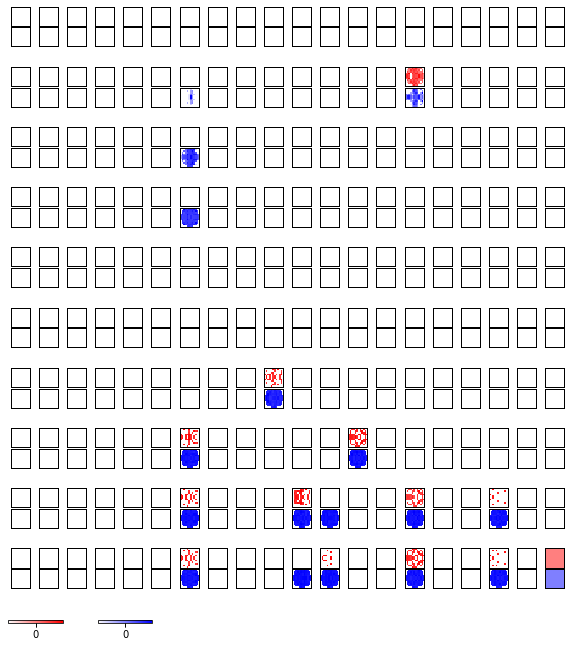

In [32]:
importlib.reload(hpfn)

fig = plt.figure(figsize=(10, 12))
gs0 = gridspec.GridSpec(11, 1, figure=fig)

label_fontsize = 10
title_fontsize = 10
tick_fontsize = 10
line_width = 0.25

## show the trained weights
for ind, M in enumerate([1, 2, 4, 8, 16, 32, 64, 128, 192, 256]):
    gs00 = gridspec.GridSpecFromSubplotSpec(5, 20, subplot_spec=gs0[ind, 0])
    data_path = figure_path+'model_clustering/clusterings/model_folders_M{}.npy'.format(M)
    model_folders = np.load(data_path, allow_pickle=True)

    # outward filters
    for ii in range(20):
        if ii < len(model_folders[2]):
            model_path = model_folders[2][ii]+'/'
            K = 12
            mask_d = opsg.get_disk_mask(12, 4)
            if has_inhibition:
                colormap_e = LinearSegmentedColormap.from_list('wr', ['w', 'r'], N=256)
            else:
                colormap_e = LinearSegmentedColormap.from_list('bwr', ['b', 'w', 'r'], N=256)
            colormap_i = LinearSegmentedColormap.from_list('wb', ['w', 'b'], N=256)
            axe = fig.add_subplot(gs00[0:2, ii])
            trained_weights_e = np.load(model_path+'trained_weights_e.npy')
            trained_weights_e = trained_weights_e[:, 0].reshape((K, K))
            trained_weights_e[mask_d] = 0.
            extreme_e = np.amax(np.abs(trained_weights_e))
            if has_inhibition:
                color_norm_e = mpl.colors.Normalize(vmin=0, vmax=extreme_e)
            else:
                color_norm_e = mpl.colors.Normalize(vmin=-extreme_e, vmax=extreme_e)
            ime = axe.imshow(trained_weights_e, norm=color_norm_e, cmap=colormap_e)
            axe.set_xticks([])
            axe.set_yticks([])
            plt.setp(axe.spines.values(), color='k', linewidth=1)

            if has_inhibition:
                axi = fig.add_subplot(gs00[2:4, ii])
                trained_weights_i = np.load(model_path+'trained_weights_i.npy')
                trained_weights_i = trained_weights_i[:, 0].reshape((K, K))
                trained_weights_i[mask_d] = 0.
                extreme_i = np.amax(np.abs(trained_weights_i))
                color_norm_i = mpl.colors.Normalize(vmin=0, vmax=extreme_i)
                imi = axi.imshow(trained_weights_i, norm=color_norm_i, cmap=colormap_i)
                axi.set_xticks([])
                axi.set_yticks([])
                plt.setp(axi.spines.values(), color='k', linewidth=1)
        
# Add colorbar
cb_orient = 'horizontal'
gs00 = gridspec.GridSpecFromSubplotSpec(2, 50, subplot_spec=gs0[10, 0])
axe = fig.add_subplot(gs00[0, 0:5])
ime = axe.imshow(trained_weights_e, norm=color_norm_e, cmap=colormap_e)
axe.set_visible(False)
cbar = plt.colorbar(ime, ax=axe, orientation=cb_orient, fraction=.5, ticks=[0, extreme_e])
cbar.ax.tick_params(labelsize=tick_fontsize)
cbar.ax.set_xticklabels(('0'))

axi = fig.add_subplot(gs00[0, 8:13])
imi = axi.imshow(trained_weights_i, norm=color_norm_i, cmap=colormap_i)
axi.set_visible(False)
cbar = plt.colorbar(imi, ax=axi, orientation=cb_orient, fraction=.5, ticks=[0, extreme_i])
cbar.ax.tick_params(labelsize=tick_fontsize)
cbar.ax.set_xticklabels(('0'))

plt.show()
filename = figure_path+'figures_supp/trained_results_multiunits_sup4.pdf'
fig.savefig(filename, bbox_inches='tight')


# Compare outward and inward, single unit

In [33]:
print(figure_path)

/Volumes/Baohua/research/loom_detection/results/final_figures_for_paper_exp/


M32, outward: 11.1
M32, inward: 2.1
M256, outward: 2.8
M256, inward: 1.0


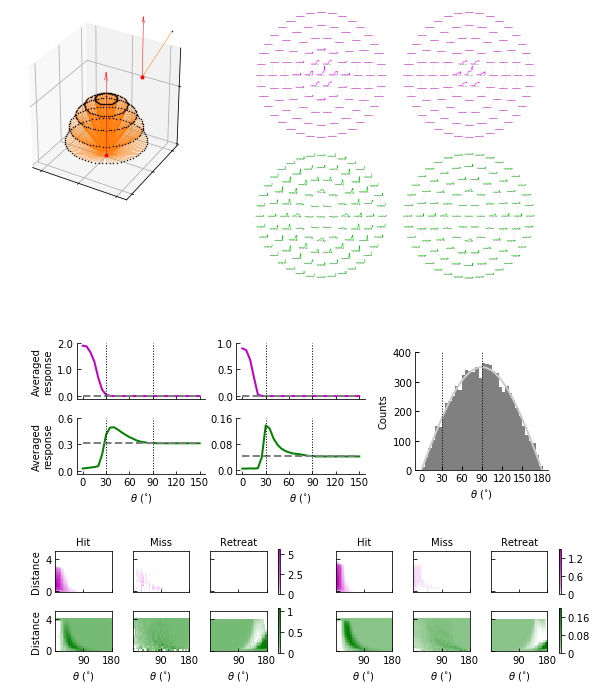

In [8]:
fig = plt.figure(figsize=(10, 10/4*5))
gs0 = gridspec.GridSpec(4, 13, figure=fig)

M = 32
label_fontsize = 10
title_fontsize = 10
tick_fontsize = 10
line_width = 0.5
i_list = [0, 3, 6, 9, 12, 15]
N_list = [1, 36, 36, 36, 36, 36]

# Trajectories
gs00 = gridspec.GridSpecFromSubplotSpec(24, 12, subplot_spec=gs0[0:2, 0:5])
ax = fig.add_subplot(gs00[2:17, :11], projection='3d')
colors_1 = ['tab:orange']
data_path = '/Volumes/Baohua/data_on_hd/loom/'
file_types = 'grid_conv2_M1_L100_par_exp'
path = data_path+file_types+'/trajectories/'
rn_arrs = np.load(path+'traj_{}_{}.npy'.format(1, 1), allow_pickle=True)
ax.quiver(0, 0, 0, 0, 0, 1, length=14, color='r', linewidth=line_width, arrow_length_ratio=0.1)
for rn_arr in rn_arrs:
    rn_arr = np.array(rn_arr)
    P = rn_arr.shape[1]
    for p in range(P):
        ax.plot(rn_arr[:, p, 0], rn_arr[:, p, 1], rn_arr[:, p, 2], c=colors_1[0], linewidth=line_width) 
for ind, i in enumerate(i_list):
    N = np.int(2*N_list[ind])
    j_list = np.linspace(0, 72, N+1, dtype=np.int16)
    for j in j_list[:-1]:
        rn_arrs = np.load(path+'traj_{}_{}.npy'.format(i+1, j+1), allow_pickle=True)
        for rn_arr in rn_arrs:
            rn_arr = np.array(rn_arr)
            P = rn_arr.shape[1]
            for p in range(P):
                ax.plot(rn_arr[:, p, 0], rn_arr[:, p, 1], rn_arr[:, p, 2], c=colors_1[0], linewidth=line_width) 
ax.plot([0], [0], [0], 'r.') 
for ind, i in enumerate(i_list):
    N = np.int(2*N_list[ind])
    j_list = np.linspace(0, 72, N+1, dtype=np.int16)
    for j in j_list[:-1]:
        rn_arrs = np.load(path+'traj_{}_{}.npy'.format(i+1, j+1), allow_pickle=True)
        for rn_arr in rn_arrs:
            rn_arr = np.array(rn_arr)
            P = rn_arr.shape[1]
            for p in range(P):
                ax.plot(rn_arr[0:1, p, 0], rn_arr[0:1, p, 1], rn_arr[0:1, p, 2], c='k', marker='.', markersize=1)    
# ax.set_xlabel('x', fontsize=label_fontsize)
# ax.set_ylabel('y', fontsize=label_fontsize)
# ax.set_zlabel('z', fontsize=label_fontsize)
ax.set_xlim([-12, 12])
ax.set_ylim([-12, 12])
ax.set_zlim([0, 16])
ax.set_xticks([-10, 0, 10])
ax.set_yticks([-10, 0, 10])
ax.set_zticks([0, 10])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.tick_params(direction='in', length=2, width=2, labelsize=tick_fontsize)

## Illustrations of incoming angles
path = data_path+file_types+'/trajectories/'
rn_arrs = np.load(path+'traj_{}_{}.npy'.format(10, 10), allow_pickle=True)
ax.quiver(3, 12, 10, 0, 0, 1, length=10, color='r', linewidth=line_width, arrow_length_ratio=0.1)
for rn_arr in rn_arrs:
    rn_arr = np.array(rn_arr)
    P = rn_arr.shape[1]
    rn_arr = np.concatenate((rn_arr, [[[0, 0, 0]]]))
    for p in range(P):
        ax.plot(rn_arr[:, p, 0]+3, rn_arr[:, p, 1]+12, rn_arr[:, p, 2]+10, c=colors_1[0], linewidth=line_width) 
        ax.plot(rn_arr[0:1, p, 0]+3, rn_arr[0:1, p, 1]+12, rn_arr[0:1, p, 2]+10, c='k', marker='.', markersize=1)
ax.plot([3], [12], [10], 'r.') 


## response
theta_list = [0, 15, 30, 45, 60, 75]
N_list = [1, 6, 12, 18, 24, 36]
circle_radii = [1., 2., 3., 4., 5.]
gs00 = gridspec.GridSpecFromSubplotSpec(14, 14, subplot_spec=gs0[0:2, 5:13])

def get_locations(N, theta, D0):
    locations = np.zeros((N, 2))
    D = theta/15*D0
    phis = np.linspace(0, 2*np.pi, N+1)
    locations[:, 0] = D*np.cos(phis[:-1])
    locations[:, 1] = D*np.sin(phis[:-1])
    
    return locations
    

# M32, outward filters
M = 32
D0 = 16 # Set the scale of the plot
data_path = figure_path+'model_clustering/clusterings/'
model_folders = np.load(data_path+'model_folders_M{}.npy'.format(M), allow_pickle=True)
# model
in_or_out = 0 # 0: outward; 1: inward
args = {}
args["n"] = 0
args["dt"] = 0.03
args["use_intensity"] = False
args["symmetrize"] = True
args['K'] = 12
args['alpha_leak'] = 0.0
args['M'] = M
args['temporal_filter'] = False
args['tau_1'] = 1.
model_types = ['excitatory', 'excitatory_WNR', 'inhibitory1', 'inhibitory2']
filter_types = ['outward', 'inward']
model_type = model_types[3]
filter_type = filter_types[in_or_out]
model_path = model_folders[in_or_out][2]+'/'

save_file = figure_path+'grid_response/'+'results'+'_'+filter_type+'_M{}.npz'.format(M)
loaded_file = np.load(save_file, allow_pickle=True)
res_rest_all_out = loaded_file['arr_0']
res_T_all_out = loaded_file['arr_1']
prob_rest_all_out = loaded_file['arr_2']
prob_all_out = loaded_file['arr_3']
res_max_out = 0
res_max_max_out = 0
res_auc_out = np.zeros((31, 72))
prob_mean_out = np.zeros((31, 72))
for i in range(31):
    for j in range(72):
        res_T = res_T_all_out[i][j]
        res_max_out = np.maximum(res_max_out, res_T.sum(axis=1).mean())
        res_max_max_out = np.maximum(res_max_max_out, res_T.sum(axis=1).max())
        res_auc_out[i, j] = res_T.mean()
        prob_mean_out[i, j] = prob_all_out[i, j].mean()
ax = fig.add_subplot(gs00[1:7, 1:7])
for rr in circle_radii:
    circle1 = plt.Circle((0, 0), rr*D0, color='k', linestyle='-', fill=False, alpha=0.05)
    ax.add_patch(circle1)
for ind1, i in enumerate([0, 3, 6, 9, 12, 15]):
    N = N_list[ind1]
    theta = theta_list[ind1]
    j_list = np.linspace(0, 72, N+1, dtype=np.int16)
    locations = get_locations(N, theta, D0)
    for ind2, j in enumerate(j_list[:-1]):
        x, y = locations[ind2][:]
        res_T = res_T_all_out[i][j]
        res_rest = res_rest_all_out[i][j]
#         rlevel = (1-np.maximum(0, res_T.sum(axis=1).mean())/res_max_out)*0.8
        rlevel = 0
        res_x = np.linspace(x-D0/3, x+D0/3, res_T.shape[0])
#         if i == 20 and j == 52:
#             ax_tem = fig.add_subplot(gs00[6, 7])
#             ax_tem.plot([res_x[0], res_x[0]], [y, np.round(res_max_max_out, 1)+y], 'k', linewidth=2*line_width)
#             ax_tem.plot([res_x[0], res_x[-1]], [y, y], 'k', linewidth=2*line_width)
#             ax_tem.plot(res_x, res_T.sum(axis=1)+y, c=[1.0, rlevel, 1.0], linewidth=line_width)
#             ax_tem.plot(res_x, np.ones(res_T.shape[0])*res_rest.sum()+y, c=[0.5, 0.5, 0.5], \
#                            linestyle='--', linewidth=line_width)
#             ax_tem.axis('off')
        ax.plot(res_x, res_T.sum(axis=1)+y, c=[1.0, rlevel, 1.0], linewidth=line_width)
        ax.plot(res_x, np.ones(res_T.shape[0])*res_rest.sum()+y, c=[0.5, 0.5, 0.5], \
                       linestyle='--', linewidth=line_width)
ax.axis('off')
print('M32, outward: {}'.format(np.round(res_max_max_out, 1)))

# M32, inward filters
D0 = 4 # Set the scale of the plot
data_path = figure_path+'model_clustering/clusterings/'
model_folders = np.load(data_path+'model_folders_M{}.npy'.format(M), allow_pickle=True)
# model
in_or_out = 1 # 0: outward; 1: inward
args = {}
args["n"] = 0
args["dt"] = 0.03
args["use_intensity"] = False
args["symmetrize"] = True
args['K'] = 12
args['alpha_leak'] = 0.0
args['M'] = M
args['temporal_filter'] = False
args['tau_1'] = 1.
model_types = ['excitatory', 'excitatory_WNR', 'inhibitory1', 'inhibitory2']
filter_types = ['outward', 'inward']
model_type = model_types[3]
filter_type = filter_types[in_or_out]
model_path = model_folders[in_or_out][2]+'/'

save_file = figure_path+'grid_response/'+'results'+'_'+filter_type+'_M{}.npz'.format(M)
loaded_file = np.load(save_file, allow_pickle=True)
res_rest_all_in = loaded_file['arr_0']
res_T_all_in = loaded_file['arr_1']
prob_rest_all_in = loaded_file['arr_2']
prob_all_in = loaded_file['arr_3']
res_max_in = 0
res_max_max_in = 0
res_auc_in = np.zeros((31, 72))
prob_mean_in = np.zeros((31, 72))
for i in range(31):
    for j in range(72):
        res_T = res_T_all_in[i][j]
        res_max_in = np.maximum(res_max_in, res_T.sum(axis=1).mean())
        res_max_max_in = np.maximum(res_max_max_in, res_T.sum(axis=1).max())
        res_auc_in[i, j] = res_T.mean()
        prob_mean_in[i, j] = prob_all_in[i, j].mean()
ax = fig.add_subplot(gs00[7:13, 1:7])
for rr in circle_radii:
    circle1 = plt.Circle((0, 0), rr*D0, color='k', linestyle='-', fill=False, alpha=0.05)
    ax.add_patch(circle1)
for ind1, i in enumerate([0, 3, 6, 9, 12, 15]):
    N = N_list[ind1]
    theta = theta_list[ind1]
    j_list = np.linspace(0, 72, N+1, dtype=np.int16)
    locations = get_locations(N, theta, D0)
    for ind2, j in enumerate(j_list[:-1]):
        x, y = locations[ind2][:]
        res_T = res_T_all_in[i][j]
        res_rest = res_rest_all_in[i][j]
#         rlevel = (1-np.maximum(0, res_T.sum(axis=1).mean())/res_max_in)*0.8
        rlevel = 0
        res_x = np.linspace(x-D0/3, x+D0/3, res_T.shape[0])
#         if i == 20 and j == 52:
#             ax_tem = fig.add_subplot(gs00[12, 7])
#             ax_tem.plot([res_x[0], res_x[0]], [y, np.round(res_max_max_in, 1)+y], 'k', linewidth=2*line_width)
#             ax_tem.plot([res_x[0], res_x[-1]], [y, y], 'k', linewidth=2*line_width)
#             ax_tem.plot(res_x, res_T.sum(axis=1)+y, c=[rlevel, 0.8, rlevel], linewidth=line_width)
#             ax_tem.plot(res_x, np.ones(res_T.shape[0])*res_rest.sum()+y, c=[0.5, 0.5, 0.5], \
#                            linestyle='--', linewidth=line_width)
#             ax_tem.axis('off')
        ax.plot(res_x, res_T.sum(axis=1)+y, c=[rlevel, 0.8, rlevel], linewidth=line_width)
        ax.plot(res_x, np.ones(res_T.shape[0])*res_rest.sum()+y, c=[0.5, 0.5, 0.5], \
                       linestyle='--', linewidth=line_width)
ax.axis('off')
print('M32, inward: {}'.format(np.round(res_max_max_in, 1)))
            

# M256, outward filters
M = 256
D0 = 4 # Set the scale of the plot
data_path = figure_path+'model_clustering/clusterings/'
model_folders = np.load(data_path+'model_folders_M{}.npy'.format(M), allow_pickle=True)
# model
in_or_out = 0 # 0: outward; 1: inward
args = {}
args["n"] = 0
args["dt"] = 0.03
args["use_intensity"] = False
args["symmetrize"] = True
args['K'] = 12
args['alpha_leak'] = 0.0
args['M'] = M
args['temporal_filter'] = False
args['tau_1'] = 1.
model_types = ['excitatory', 'excitatory_WNR', 'inhibitory1', 'inhibitory2']
filter_types = ['outward', 'inward']
model_type = model_types[3]
filter_type = filter_types[in_or_out]
model_path = model_folders[in_or_out][2]+'/'

save_file = figure_path+'grid_response/'+'results'+'_'+filter_type+'_M{}.npz'.format(M)
loaded_file = np.load(save_file, allow_pickle=True)
res_rest_all_out = loaded_file['arr_0']
res_T_all_out = loaded_file['arr_1']
prob_rest_all_out = loaded_file['arr_2']
prob_all_out = loaded_file['arr_3']
res_max_out = 0
res_max_max_out = 0
res_auc_out = np.zeros((31, 72))
prob_mean_out = np.zeros((31, 72))
for i in range(31):
    for j in range(72):
        res_T = res_T_all_out[i][j]
        res_max_out = np.maximum(res_max_out, res_T.sum(axis=1).mean())
        res_max_max_out = np.maximum(res_max_max_out, res_T.sum(axis=1).max())
        res_auc_out[i, j] = res_T.mean()
        prob_mean_out[i, j] = prob_all_out[i, j].mean()
ax = fig.add_subplot(gs00[1:7, 7:13])
for rr in circle_radii:
    circle1 = plt.Circle((0, 0), rr*D0, color='k', linestyle='-', fill=False, alpha=0.05)
    ax.add_patch(circle1)
for ind1, i in enumerate([0, 3, 6, 9, 12, 15]):
    N = N_list[ind1]
    theta = theta_list[ind1]
    j_list = np.linspace(0, 72, N+1, dtype=np.int16)
    locations = get_locations(N, theta, D0)
    for ind2, j in enumerate(j_list[:-1]):
        x, y = locations[ind2][:]
        res_T = res_T_all_out[i][j]
        res_rest = res_rest_all_out[i][j]
#         rlevel = (1-np.maximum(0, res_T.sum(axis=1).mean())/res_max_out)*0.8
        rlevel = 0
        res_x = np.linspace(x-D0/3, x+D0/3, res_T.shape[0])
#         if i == 20 and j == 52:
#             ax_tem = fig.add_subplot(gs00[6, 13])
#             ax_tem.plot([res_x[0], res_x[0]], [y, np.round(res_max_max_out, 1)+y], 'k', linewidth=2*line_width)
#             ax_tem.plot([res_x[0], res_x[-1]], [y, y], 'k', linewidth=2*line_width)
#             ax_tem.plot(res_x, res_T.sum(axis=1)+y, c=[1.0, rlevel, 1.0], linewidth=line_width)
#             ax_tem.plot(res_x, np.ones(res_T.shape[0])*res_rest.sum()+y, c=[0.5, 0.5, 0.5], \
#                            linestyle='--', linewidth=line_width)
#             ax_tem.axis('off')
        ax.plot(res_x, res_T.sum(axis=1)+y, c=[1.0, rlevel, 1.0], linewidth=line_width)
        ax.plot(res_x, np.ones(res_T.shape[0])*res_rest.sum()+y, c=[0.5, 0.5, 0.5], \
                       linestyle='--', linewidth=line_width)
ax.axis('off')
print('M256, outward: {}'.format(np.round(res_max_max_out, 1)))

# M256, inward filters
D0 = 4 # Set the scale of the plot
data_path = figure_path+'model_clustering/clusterings/'
model_folders = np.load(data_path+'model_folders_M{}.npy'.format(M), allow_pickle=True)
# model
in_or_out = 1 # 0: outward; 1: inward
args = {}
args["n"] = 0
args["dt"] = 0.03
args["use_intensity"] = False
args["symmetrize"] = True
args['K'] = 12
args['alpha_leak'] = 0.0
args['M'] = M
args['temporal_filter'] = False
args['tau_1'] = 1.
model_types = ['excitatory', 'excitatory_WNR', 'inhibitory1', 'inhibitory2']
filter_types = ['outward', 'inward']
model_type = model_types[3]
filter_type = filter_types[in_or_out]
model_path = model_folders[in_or_out][2]+'/'

save_file = figure_path+'grid_response/'+'results'+'_'+filter_type+'_M{}.npz'.format(M)
loaded_file = np.load(save_file, allow_pickle=True)
res_rest_all_in = loaded_file['arr_0']
res_T_all_in = loaded_file['arr_1']
prob_rest_all_in = loaded_file['arr_2']
prob_all_in = loaded_file['arr_3']
res_max_in = 0
res_max_max_in = 0
res_auc_in = np.zeros((31, 72))
prob_mean_in = np.zeros((31, 72))
for i in range(31):
    for j in range(72):
        res_T = res_T_all_in[i][j]
        res_max_in = np.maximum(res_max_in, res_T.sum(axis=1).mean())
        res_max_max_in = np.maximum(res_max_max_in, res_T.sum(axis=1).max())
        res_auc_in[i, j] = res_T.mean()
        prob_mean_in[i, j] = prob_all_in[i, j].mean()
ax = fig.add_subplot(gs00[7:13, 7:13])
for rr in circle_radii:
    circle1 = plt.Circle((0, 0), rr*D0, color='k', linestyle='-', fill=False, alpha=0.05)
    ax.add_patch(circle1)
for ind1, i in enumerate([0, 3, 6, 9, 12, 15]):
    N = N_list[ind1]
    theta = theta_list[ind1]
    j_list = np.linspace(0, 72, N+1, dtype=np.int16)
    locations = get_locations(N, theta, D0)
    for ind2, j in enumerate(j_list[:-1]):
        x, y = locations[ind2][:]
        res_T = res_T_all_in[i][j]
        res_rest = res_rest_all_in[i][j]
#         rlevel = (1-np.maximum(0, res_T.sum(axis=1).mean())/res_max_out)*0.8
        rlevel = 0.
        res_x = np.linspace(x-D0/3, x+D0/3, res_T.shape[0])
#         if i == 20 and j == 52:
#             ax_tem = fig.add_subplot(gs00[12, 13])
#             ax_tem.plot([res_x[0], res_x[0]], [y, np.round(res_max_max_in, 1)+y], 'k', linewidth=2*line_width)
#             ax_tem.plot([res_x[0], res_x[-1]], [y, y], 'k', linewidth=2*line_width)
#             ax_tem.plot(res_x, res_T.sum(axis=1)+y, c=[rlevel, 0.8, rlevel], linewidth=line_width)
#             ax_tem.plot(res_x, np.ones(res_T.shape[0])*res_rest.sum()+y, c=[0.5, 0.5, 0.5], \
#                            linestyle='--', linewidth=line_width)
#             ax_tem.axis('off')
        ax.plot(res_x, res_T.sum(axis=1)+y, c=[rlevel, 0.8, rlevel], linewidth=line_width)
        ax.plot(res_x, np.ones(res_T.shape[0])*res_rest.sum()+y, c=[0.5, 0.5, 0.5], \
                       linestyle='--', linewidth=line_width)
ax.axis('off')
print('M256, inward: {}'.format(np.round(res_max_max_in, 1)))


## response against angle
gs00 = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs0[2, 1:9])
M = 32
# outward
in_or_out = 0 # 0: outward; 1: inward
filter_types = ['outward', 'inward']
filter_type = filter_types[in_or_out]
save_file = figure_path+'grid_response/'+'results'+'_'+filter_type+'_M{}.npz'.format(M)
loaded_file = np.load(save_file, allow_pickle=True)
res_rest_all_out = loaded_file['arr_0']
res_T_all_out = loaded_file['arr_1']
prob_rest_all_out = loaded_file['arr_2']
prob_all_out = loaded_file['arr_3']
res_max_out = 0
res_auc_out = np.zeros((31, 72))
prob_mean_out = np.zeros((31, 72))
for i in range(31):
    for j in range(72):
        res_T = res_T_all_out[i][j]
        res_max_out = np.maximum(res_max_out, res_T.sum(axis=1).mean())
        res_auc_out[i, j] = res_T.mean()
        prob_mean_out[i, j] = prob_all_out[i, j].mean()

# inward
in_or_out = 1 # 0: outward; 1: inward
filter_types = ['outward', 'inward']
filter_type = filter_types[in_or_out]
save_file = figure_path+'grid_response/'+'results'+'_'+filter_type+'_M{}.npz'.format(M)
loaded_file = np.load(save_file, allow_pickle=True)
res_rest_all_in = loaded_file['arr_0']
res_T_all_in = loaded_file['arr_1']
prob_rest_all_in = loaded_file['arr_2']
prob_all_in = loaded_file['arr_3']
res_max_in = 0
res_auc_in = np.zeros((31, 72))
prob_mean_in = np.zeros((31, 72))
for i in range(31):
    for j in range(72):
        res_T = res_T_all_in[i][j]
        res_max_in = np.maximum(res_max_in, res_T.sum(axis=1).mean())
        res_auc_in[i, j] = res_T.mean()
        prob_mean_in[i, j] = prob_all_in[i, j].mean()
            
gs000 = gridspec.GridSpecFromSubplotSpec(12, 12, subplot_spec=gs00[0, 0])
ax = fig.add_subplot(gs000[1:11, 2:12])
res_auc_out_mean = res_auc_out.mean(axis=1)
ax.plot(res_auc_out_mean, 'm', linewidth=4*line_width)
ax.plot([0, 30], [res_rest_all_out[0, 0], res_rest_all_out[0, 0]], color='grey', linestyle='--', linewidth=4*line_width)
ax.plot([6, 6], [-0.1, 2], c='k', linestyle=':', linewidth=2*line_width)
ax.plot([18, 18], [-0.1, 2], c='k', linestyle=':', linewidth=2*line_width)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(True)
ax.spines["left"].set_visible(True)
ax.set_ylim([-0.1, 2])
ax.set_xticks([0, 6, 12, 18, 24, 30])
ax.set_xticklabels([])
ax.set_yticks([0, 1, 2])
ax.set_yticklabels(['0.0', '1.0', '2.0'])
ax.set_ylabel('Averaged\nresponse', fontsize=label_fontsize)
ax.tick_params(direction='in', labelsize=tick_fontsize)

gs000 = gridspec.GridSpecFromSubplotSpec(12, 12, subplot_spec=gs00[1, 0])
ax = fig.add_subplot(gs000[0:10, 2:12])
res_auc_in_mean = res_auc_in.mean(axis=1)
ax.plot(res_auc_in_mean, 'g', linewidth=4*line_width)
ax.plot([0, 30], [res_rest_all_in[0, 0], res_rest_all_in[0, 0]], color='grey', linestyle='--', linewidth=4*line_width)
ax.plot([6, 6], [-0.03, 0.6], c='k', linestyle=':', linewidth=2*line_width)
ax.plot([18, 18], [-0.03, 0.6], c='k', linestyle=':', linewidth=2*line_width)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(True)
ax.spines["left"].set_visible(True)
ax.set_ylim([-0.03, 0.6])
ax.set_xticks([0, 6, 12, 18, 24, 30])
ax.set_xticklabels([0, 30, 60, 90, 120, 150])
ax.set_yticks([0.0, 0.3, 0.6])
ax.set_yticklabels(['0.0', '0.3', '0.6'])
ax.set_xlabel(r'$\theta$ ($^{\circ}$)', fontsize=label_fontsize)
ax.set_ylabel('Averaged\nresponse', fontsize=label_fontsize)
ax.tick_params(direction='in', labelsize=tick_fontsize)


M = 256
# outward
in_or_out = 0 # 0: outward; 1: inward
filter_types = ['outward', 'inward']
filter_type = filter_types[in_or_out]
save_file = figure_path+'grid_response/'+'results'+'_'+filter_type+'_M{}.npz'.format(M)
loaded_file = np.load(save_file, allow_pickle=True)
res_rest_all_out = loaded_file['arr_0']
res_T_all_out = loaded_file['arr_1']
prob_rest_all_out = loaded_file['arr_2']
prob_all_out = loaded_file['arr_3']
res_max_out = 0
res_auc_out = np.zeros((31, 72))
prob_mean_out = np.zeros((31, 72))
for i in range(31):
    for j in range(72):
        res_T = res_T_all_out[i][j]
        res_max_out = np.maximum(res_max_out, res_T.sum(axis=1).mean())
        res_auc_out[i, j] = res_T.mean()
        prob_mean_out[i, j] = prob_all_out[i, j].mean()

# inward
in_or_out = 1 # 0: outward; 1: inward
filter_types = ['outward', 'inward']
filter_type = filter_types[in_or_out]
save_file = figure_path+'grid_response/'+'results'+'_'+filter_type+'_M{}.npz'.format(M)
loaded_file = np.load(save_file, allow_pickle=True)
res_rest_all_in = loaded_file['arr_0']
res_T_all_in = loaded_file['arr_1']
prob_rest_all_in = loaded_file['arr_2']
prob_all_in = loaded_file['arr_3']
res_max_in = 0
res_auc_in = np.zeros((31, 72))
prob_mean_in = np.zeros((31, 72))
for i in range(31):
    for j in range(72):
        res_T = res_T_all_in[i][j]
        res_max_in = np.maximum(res_max_in, res_T.sum(axis=1).mean())
        res_auc_in[i, j] = res_T.mean()
        prob_mean_in[i, j] = prob_all_in[i, j].mean()
            
gs000 = gridspec.GridSpecFromSubplotSpec(12, 12, subplot_spec=gs00[0, 1])
ax = fig.add_subplot(gs000[1:11, 0:10])
res_auc_out_mean = res_auc_out.mean(axis=1)
ax.plot(res_auc_out_mean, 'm', linewidth=4*line_width)
ax.plot([0, 30], [res_rest_all_out[0, 0], res_rest_all_out[0, 0]], color='grey', linestyle='--', linewidth=4*line_width)
ax.plot([6, 6], [-0.05, 1.0], c='k', linestyle=':', linewidth=2*line_width)
ax.plot([18, 18], [-0.05, 1.0], c='k', linestyle=':', linewidth=2*line_width)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(True)
ax.spines["left"].set_visible(True)
ax.set_ylim([-0.05, 1.0])
ax.set_xticks([0, 6, 12, 18, 24, 30])
ax.set_xticklabels([])
ax.set_yticks([0, 0.5, 1.0])
ax.set_yticklabels(['0.0', '0.5', '1.0'])
ax.tick_params(direction='in', labelsize=tick_fontsize)

gs000 = gridspec.GridSpecFromSubplotSpec(12, 12, subplot_spec=gs00[1, 1])
ax = fig.add_subplot(gs000[0:10, 0:10])
res_auc_in_mean = res_auc_in.mean(axis=1)
ax.plot(res_auc_in_mean, 'g', linewidth=4*line_width)
ax.plot([0, 30], [res_rest_all_in[0, 0], res_rest_all_in[0, 0]], color='grey', linestyle='--', linewidth=4*line_width)
ax.plot([6, 6], [-0.01, 0.16], c='k', linestyle=':', linewidth=2*line_width)
ax.plot([18, 18], [-0.01, 0.16], c='k', linestyle=':', linewidth=2*line_width)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(True)
ax.spines["left"].set_visible(True)
ax.set_ylim([-0.01, 0.16])
ax.set_xticks([0, 6, 12, 18, 24, 30])
ax.set_xticklabels([0, 30, 60, 90, 120, 150])
ax.set_yticks([0, 0.08, 0.16])
ax.set_yticklabels(['0.0', '0.08', '0.16'])
ax.set_xlabel(r'$\theta$ ($^{\circ}$)', fontsize=label_fontsize)
ax.tick_params(direction='in', labelsize=tick_fontsize)


## histogram of the angle of the incoming signals
path = figure_path+'theta_angles/theta_angles.npy'
theta_angles = np.load(path)
gs00 = gridspec.GridSpecFromSubplotSpec(10, 10, subplot_spec=gs0[2, 9:13])
ax = fig.add_subplot(gs00[1:9, 1:9])
bins_angle = np.linspace(0, 180, 37)
counts, bins, patches = ax.hist(theta_angles, bins=bins_angle, )
for i in range(6):
    patches[i].set_facecolor('grey')
for i in range(6, 18):    
    patches[i].set_facecolor('grey')
for i in range(18, len(patches)):
    patches[i].set_facecolor('grey')
xx = np.linspace(0, 180, 37)
scal = counts.sum()/np.sin(xx/180*np.pi).sum()
ax.plot(xx, np.sin(xx/180*np.pi)*scal, c=[0.8, 0.8, 0.8], linestyle='-', linewidth=4*line_width)
ax.plot([30, 30], [0, 400], c='k', linestyle=':', linewidth=2*line_width)
ax.plot([90, 90], [0, 400], c='k', linestyle=':', linewidth=2*line_width)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(True)
ax.spines["left"].set_visible(True)
ax.set_ylim([0, 400])
ax.set_xticks([0, 30, 60, 90, 120, 150, 180])
ax.set_xlabel(r'$\theta$ ($^{\circ}$)', fontsize=label_fontsize)
ax.set_ylabel('Counts', fontsize=label_fontsize)
ax.tick_params(direction='in', length=4, width=1, labelsize=tick_fontsize)


## Responses against distance
gs00 = gridspec.GridSpecFromSubplotSpec(6, 2, subplot_spec=gs0[3, 1:])
# M32
M = 32
gs000 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs00[1:6, 0])
data_path = figure_path+'model_clustering/clusterings/'
model_folders = np.load(data_path+'model_folders_M{}.npy'.format(M), allow_pickle=True)
data_types = ['hit', 'miss', 'retreat', 'rotation']
model_types = ['excitatory', 'excitatory_WNR', 'inhibitory1', 'inhibitory2']
filter_types = ['outward', 'inward']
model_type = model_types[3]

filter_type = filter_types[0]
save_file = figure_path+'response_vs_distance/'+'heatmap'+'_'+filter_type+'_M{}.npz'.format(M)
loaded_file = np.load(save_file, allow_pickle=True)
res_heatmap_hit_n = loaded_file['arr_0']
res_heatmap_miss_n = loaded_file['arr_1']
res_heatmap_retreat_n = loaded_file['arr_2']
# res_heatmap_hit_n = np.sqrt(res_heatmap_hit_n)
# res_heatmap_miss_n = np.sqrt(res_heatmap_miss_n)
# res_heatmap_retreat_n = np.sqrt(res_heatmap_retreat_n)

filter_type = filter_types[1]
save_file = figure_path+'response_vs_distance/'+'heatmap'+'_'+filter_type+'_M{}.npz'.format(M)
loaded_file = np.load(save_file, allow_pickle=True)
res_heatmap_hit_r = loaded_file['arr_0']
res_heatmap_miss_r = loaded_file['arr_1']
res_heatmap_retreat_r = loaded_file['arr_2']
# res_heatmap_hit_r = np.sqrt(res_heatmap_hit_r)
# res_heatmap_miss_r = np.sqrt(res_heatmap_miss_r)
# res_heatmap_retreat_r = np.sqrt(res_heatmap_retreat_r)

# outward
gs0000 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs000[0, 0])
dt = 0.01
sample_dt = 0.03
bin_size_a = 5
bin_size_d = 0.2
max_angle = 180
gamma_value = 1
colormap_m = LinearSegmentedColormap.from_list('wm', ['w', 'm'], N=256, gamma=0.5)
axes = []

gs00000 = gridspec.GridSpecFromSubplotSpec(16, 16, subplot_spec=gs0000[0, 0])
ax = fig.add_subplot(gs00000[2:16, 1:15])
axes.append(ax)
im1 = ax.imshow(res_heatmap_hit_n[:, :], cmap = colormap_m, norm = mpl.colors.PowerNorm(gamma=gamma_value), vmin=res_heatmap_hit_n.min().min(), vmax=res_heatmap_hit_n.max().max())
ax.set_xticks([17.5, 35.5])
ax.set_xticklabels([])
ax.set_yticks([0, 20])
ax.set_yticklabels([0, 4])
ax.set_ylabel('Distance', fontsize=label_fontsize)
ax.invert_yaxis()
ax.set_title('Hit', fontsize=title_fontsize)
ax.tick_params(direction='in', labelsize=tick_fontsize)

gs00000 = gridspec.GridSpecFromSubplotSpec(16, 16, subplot_spec=gs0000[0, 1])
ax = fig.add_subplot(gs00000[2:16, 1:15])
axes.append(ax)
im2 = ax.imshow(res_heatmap_miss_n[:, :], cmap = colormap_m, norm = mpl.colors.PowerNorm(gamma=gamma_value), vmin=res_heatmap_hit_n.min().min(), vmax=res_heatmap_hit_n.max().max())
ax.set_xticks([17.5, 35.5])
ax.set_xticklabels([])
ax.invert_yaxis()
ax.set_yticks([0, 20])
ax.set_yticklabels([])
ax.set_title('Miss', fontsize=title_fontsize)
ax.tick_params(direction='in', labelsize=tick_fontsize)

gs00000 = gridspec.GridSpecFromSubplotSpec(16, 16, subplot_spec=gs0000[0, 2])
ax = fig.add_subplot(gs00000[2:16, 1:15])
axes.append(ax)
im3 = ax.imshow(res_heatmap_retreat_n[:, :], cmap = colormap_m, norm = mpl.colors.PowerNorm(gamma=gamma_value), vmin=res_heatmap_hit_n.min().min(), vmax=res_heatmap_hit_n.max().max())
ax.set_xticks([17.5, 35.5])
ax.set_xticklabels([])
ax.invert_yaxis()
ax.set_yticks([0, 20])
ax.set_yticklabels([])
ax.set_title('Retreat', fontsize=title_fontsize)
ax.tick_params(direction='in', labelsize=tick_fontsize)
cbar = plt.colorbar(im3, ax=axes, orientation='vertical', fraction=.01, ticks=[0, 2.5, 5])
cbar.ax.tick_params(labelsize=tick_fontsize)
cbar.ax.set_yticklabels((0, 2.5, 5))

# inward
gs0000 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs000[1, 0])
colormap_g = LinearSegmentedColormap.from_list('wg', ['w', 'g'], N=256, gamma=0.5)
axes = []

gs00000 = gridspec.GridSpecFromSubplotSpec(16, 16, subplot_spec=gs0000[0, 0])
ax = fig.add_subplot(gs00000[0:14, 1:15])
axes.append(ax)
im1 = ax.imshow(res_heatmap_hit_r[:, :], cmap = colormap_g, norm = mpl.colors.PowerNorm(gamma=gamma_value), vmin=res_heatmap_hit_r.min().min(), vmax=res_heatmap_hit_r.max().max())
ax.set_xlabel(r'$\theta$ ($^{\circ}$)', fontsize=label_fontsize)
ax.set_xticks([17.5, 35.5])
ax.set_xticklabels([90, 180])
ax.set_yticks([0, 20])
ax.set_yticklabels([0, 4])
ax.set_ylabel('Distance', fontsize=label_fontsize)
ax.invert_yaxis()
ax.tick_params(direction='in', labelsize=tick_fontsize)

gs00000 = gridspec.GridSpecFromSubplotSpec(16, 16, subplot_spec=gs0000[0, 1])
ax = fig.add_subplot(gs00000[0:14, 1:15])
axes.append(ax)
im2 = ax.imshow(res_heatmap_miss_r[:, :], cmap = colormap_g, norm = mpl.colors.PowerNorm(gamma=gamma_value), vmin=res_heatmap_hit_r.min().min(), vmax=res_heatmap_hit_r.max().max())
ax.set_xlabel(r'$\theta$ ($^{\circ}$)', fontsize=label_fontsize)
ax.set_xticks([17.5, 35.5])
ax.set_xticklabels([90, 180])
ax.set_yticks([0, 20])
ax.set_yticklabels([])
ax.invert_yaxis()
ax.tick_params(direction='in', labelsize=tick_fontsize)

gs00000 = gridspec.GridSpecFromSubplotSpec(16, 16, subplot_spec=gs0000[0, 2])
ax = fig.add_subplot(gs00000[0:14, 1:15])
axes.append(ax)
im3 = ax.imshow(res_heatmap_retreat_r[:, :], cmap = colormap_g, norm = mpl.colors.PowerNorm(gamma=gamma_value), vmin=res_heatmap_hit_r.min().min(), vmax=res_heatmap_hit_r.max().max())
ax.set_xlabel(r'$\theta$ ($^{\circ}$)', fontsize=label_fontsize)
ax.set_xticks([17.5, 35.5])
ax.set_xticklabels([90, 180])
ax.set_yticks([0, 20])
ax.set_yticklabels([])
ax.invert_yaxis()
ax.tick_params(direction='in', labelsize=tick_fontsize)
cbar = plt.colorbar(im3, ax=axes, orientation='vertical', fraction=.01, ticks=[0, 0.5, 1])
cbar.ax.tick_params(labelsize=tick_fontsize)
cbar.ax.set_yticklabels((0, 0.5, 1))


## Responses against distance
# M256
M = 256
gs000 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs00[1:6, 1])
data_path = figure_path+'model_clustering/clusterings/'
model_folders = np.load(data_path+'model_folders_M{}.npy'.format(M), allow_pickle=True)
data_types = ['hit', 'miss', 'retreat', 'rotation']
model_types = ['excitatory', 'excitatory_WNR', 'inhibitory1', 'inhibitory2']
filter_types = ['outward', 'inward']
model_type = model_types[3]

filter_type = filter_types[0]
save_file = figure_path+'response_vs_distance/'+'heatmap'+'_'+filter_type+'_M{}.npz'.format(M)
loaded_file = np.load(save_file, allow_pickle=True)
res_heatmap_hit_n = loaded_file['arr_0']
res_heatmap_miss_n = loaded_file['arr_1']
res_heatmap_retreat_n = loaded_file['arr_2']
# res_heatmap_hit_n = np.sqrt(res_heatmap_hit_n)
# res_heatmap_miss_n = np.sqrt(res_heatmap_miss_n)
# res_heatmap_retreat_n = np.sqrt(res_heatmap_retreat_n)

filter_type = filter_types[1]
save_file = figure_path+'response_vs_distance/'+'heatmap'+'_'+filter_type+'_M{}.npz'.format(M)
loaded_file = np.load(save_file, allow_pickle=True)
res_heatmap_hit_r = loaded_file['arr_0']
res_heatmap_miss_r = loaded_file['arr_1']
res_heatmap_retreat_r = loaded_file['arr_2']
# res_heatmap_hit_r = np.sqrt(res_heatmap_hit_r)
# res_heatmap_miss_r = np.sqrt(res_heatmap_miss_r)
# res_heatmap_retreat_r = np.sqrt(res_heatmap_retreat_r)

# outward
gs0000 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs000[0, 0])
dt = 0.01
sample_dt = 0.03
bin_size_a = 5
bin_size_d = 0.2
max_angle = 180
gamma_value = 1
colormap_m = LinearSegmentedColormap.from_list('wm', ['w', 'm'], N=256, gamma=0.5)
axes = []

gs00000 = gridspec.GridSpecFromSubplotSpec(16, 16, subplot_spec=gs0000[0, 0])
ax = fig.add_subplot(gs00000[2:16, 1:15])
axes.append(ax)
im1 = ax.imshow(res_heatmap_hit_n[:, :], cmap = colormap_m, norm = mpl.colors.PowerNorm(gamma=gamma_value), vmin=res_heatmap_hit_n.min().min(), vmax=res_heatmap_hit_n.max().max())
ax.set_xticks([17.5, 35.5])
ax.set_xticklabels([])
ax.set_yticks([0, 20])
ax.set_yticklabels([])
ax.invert_yaxis()
ax.set_title('Hit', fontsize=title_fontsize)
ax.tick_params(direction='in', labelsize=tick_fontsize)

gs00000 = gridspec.GridSpecFromSubplotSpec(16, 16, subplot_spec=gs0000[0, 1])
ax = fig.add_subplot(gs00000[2:16, 1:15])
axes.append(ax)
im2 = ax.imshow(res_heatmap_miss_n[:, :], cmap = colormap_m, norm = mpl.colors.PowerNorm(gamma=gamma_value), vmin=res_heatmap_hit_n.min().min(), vmax=res_heatmap_hit_n.max().max())
ax.set_xticks([17.5, 35.5])
ax.set_xticklabels([])
ax.set_yticks([0, 20])
ax.set_yticklabels([])
ax.invert_yaxis()
ax.set_title('Miss', fontsize=title_fontsize)
ax.tick_params(direction='in', labelsize=tick_fontsize)

gs00000 = gridspec.GridSpecFromSubplotSpec(16, 16, subplot_spec=gs0000[0, 2])
ax = fig.add_subplot(gs00000[2:16, 1:15])
axes.append(ax)
im3 = ax.imshow(res_heatmap_retreat_n[:, :], cmap = colormap_m, norm = mpl.colors.PowerNorm(gamma=gamma_value), vmin=res_heatmap_hit_n.min().min(), vmax=res_heatmap_hit_n.max().max())
ax.set_xticks([17.5, 35.5])
ax.set_xticklabels([])
ax.set_yticks([0, 20])
ax.set_yticklabels([])
ax.invert_yaxis()
ax.set_title('Retreat', fontsize=title_fontsize)
ax.tick_params(direction='in', labelsize=tick_fontsize)
cbar = plt.colorbar(im3, ax=axes, orientation='vertical', fraction=.01, ticks=[0, 0.6, 1.2])
cbar.ax.tick_params(labelsize=tick_fontsize)
cbar.ax.set_yticklabels((0, 0.6, 1.2))

# inward
gs0000 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs000[1, 0])
colormap_g = LinearSegmentedColormap.from_list('wg', ['w', 'g'], N=256, gamma=0.5)
axes = []
gs00000 = gridspec.GridSpecFromSubplotSpec(16, 16, subplot_spec=gs0000[0, 0])
ax = fig.add_subplot(gs00000[0:14, 1:15])
axes.append(ax)
im1 = ax.imshow(res_heatmap_hit_r[:, :], cmap = colormap_g, norm = mpl.colors.PowerNorm(gamma=gamma_value), vmin=res_heatmap_hit_r.min().min(), vmax=res_heatmap_hit_r.max().max())
ax.set_xlabel(r'$\theta$ ($^{\circ}$)', fontsize=label_fontsize)
ax.set_xticks([17.5, 35.5])
ax.set_xticklabels([90, 180])
ax.set_yticks([0, 20])
ax.set_yticklabels([])
ax.invert_yaxis()
ax.tick_params(direction='in', labelsize=tick_fontsize)

gs00000 = gridspec.GridSpecFromSubplotSpec(16, 16, subplot_spec=gs0000[0, 1])
ax = fig.add_subplot(gs00000[0:14, 1:15])
axes.append(ax)
im2 = ax.imshow(res_heatmap_miss_r[:, :], cmap = colormap_g, norm = mpl.colors.PowerNorm(gamma=gamma_value), vmin=res_heatmap_hit_r.min().min(), vmax=res_heatmap_hit_r.max().max())
ax.set_xlabel(r'$\theta$ ($^{\circ}$)', fontsize=label_fontsize)
ax.set_xticks([17.5, 35.5])
ax.set_xticklabels([90, 180])
ax.set_yticks([0, 20])
ax.set_yticklabels([])
ax.invert_yaxis()
ax.tick_params(direction='in', labelsize=tick_fontsize)

gs00000 = gridspec.GridSpecFromSubplotSpec(16, 16, subplot_spec=gs0000[0, 2])
ax = fig.add_subplot(gs00000[0:14, 1:15])
axes.append(ax)
im3 = ax.imshow(res_heatmap_retreat_r[:, :], cmap = colormap_g, norm = mpl.colors.PowerNorm(gamma=gamma_value), vmin=res_heatmap_hit_r.min().min(), vmax=res_heatmap_hit_r.max().max())
ax.set_xlabel(r'$\theta$ ($^{\circ}$)', fontsize=label_fontsize)
ax.set_xticks([17.5, 35.5])
ax.set_xticklabels([90, 180])
ax.set_yticks([0, 20])
ax.set_yticklabels([])
ax.invert_yaxis()
ax.tick_params(direction='in', labelsize=tick_fontsize)
cbar = plt.colorbar(im3, ax=axes, orientation='vertical', fraction=.01, ticks=[0, 0.08, 0.16])
cbar.ax.tick_params(labelsize=tick_fontsize)
cbar.ax.set_yticklabels((0, 0.08, 0.16))         

plt.show()
filename = figure_path+'figures_main/compare_outward_inward_single_unit.pdf'
fig.savefig(filename, bbox_inches='tight')


## Hit events distribution

\begin{align*}
S(a, b) = \int_{a}^{b} dx \sin(x) = \cos(a)-\cos(b)
\end{align*}


In [36]:
S_1 = np.cos(np.deg2rad(0))-np.cos(np.deg2rad(30))
S_2 = np.cos(np.deg2rad(30))-np.cos(np.deg2rad(90))
print(S_1)
print(S_2)

0.1339745962155613
0.8660254037844386


# Compare outward and inward, multiple units

xy angle of the center unit is [2.00579744 0.03696696].
Outward model is at:  /Volumes/Baohua/research_large_files/multi_lplc2_training_D5_exp/M_32/lr_0.001/regu_0.0001/seed_109_20210626040301/
Mean probability of hit is [0.37882719172773943].
Maximum response is 3.0938186645507812.
Inward model is at:  /Volumes/Baohua/research_large_files/multi_lplc2_training_D5_exp/M_32/lr_0.001/regu_0.0001/seed_114_20210626040302/
Mean probability of hit is [0.4373684142054037].
Maximum response is 2.0269837379455566.
maximum response is 2.0
maximum response is 2.0


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

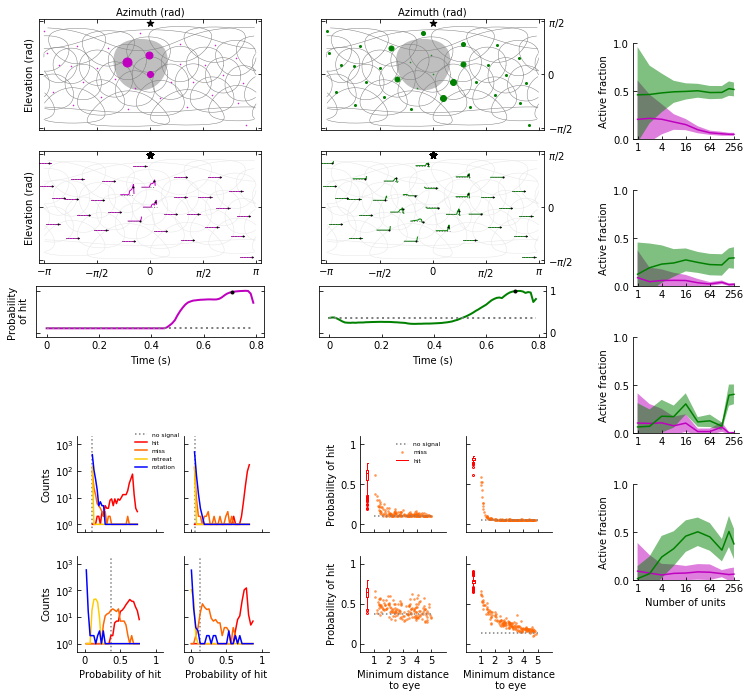

In [3]:
importlib.reload(hpfn)

# data
K = 12
L = 4
KK = K**2
pad = 2*L
data_path = figure_path +'/movies/model_response/movie_intensities_multi_units/M_32/'
data_types = ['hit', 'miss', 'retreat', 'rotation']
data_type = data_types[0]
path = data_path+data_type+'/'
intensities_sample_cg_list = np.load(path+'intensities_samples_cg/intensities_sample_cg_list_0.npy', allow_pickle=True)
UV_flow_sample_list = np.load(path+'UV_flow_samples/UV_flow_sample_list_0.npy', allow_pickle=True)
intensities_sample_cg = intensities_sample_cg_list[0]
UV_flow_sample = UV_flow_sample_list[0]
path_traj = data_path+'other_info'+'/'+data_type+'/'+'trajectories/'
traj_list = np.load(path_traj+'traj_list_0.npy', allow_pickle=True)
traj = traj_list[0]

steps = len(intensities_sample_cg)
M = len(intensities_sample_cg[0])
row_L = 4
col_L = np.int(M/4)
intensities_sample_cg_lplc2 = np.ones((steps, row_L*K+(row_L-1)*1, col_L*K+(col_L-1)*1))*0.2

# get the unit at the center
x, y, z = traj[-1, 0, :]
vec = traj[-2, 0, :]-traj[-1, 0, :]
angles = opsg.get_angles_between_lplc2_and_vec(M, vec)
sorted_list = list(np.argsort(angles))
if M == 1:
    lplc2_units = np.array([[0, 0]])
else:
    lplc2_units = opsg.get_lplc2_units_xy_angles(M)
mc = sorted_list[0]
angle_mc = lplc2_units[mc]
print(f'xy angle of the center unit is {angle_mc}.')

for step in range(steps):
    for m in range(M):
        row = np.int(m/col_L)
        col = np.mod(m, col_L)
        intensities_sample_cg_tem = intensities_sample_cg[step][sorted_list[m]]
        if intensities_sample_cg_tem.shape[0] == 1:
            intensities_sample_cg_lplc2[step, row*(K+1):row*(K+1)+K, col*(K+1):col*(K+1)+K] = 0.
        else:
            intensities_sample_cg_lplc2[step, row*(K+1):row*(K+1)+K, col*(K+1):col*(K+1)+K] = intensities_sample_cg_tem[:].reshape((K, K))

leftup_corners = opsg.get_leftup_corners(K, L, pad)
steps = len(UV_flow_sample)
U_flow_lplc2 = np.ones((steps, row_L*K+(row_L-1)*1, col_L*K+(col_L-1)*1))*0.2
V_flow_lplc2 = np.ones((steps, row_L*K+(row_L-1)*1, col_L*K+(col_L-1)*1))*0.2

for step in range(steps):
    cf_u, cf_v = flfd.set_flow_fields_on_frame(UV_flow_sample[step], leftup_corners, K, L, pad)
    for m in range(M):
        row = np.int(m/col_L)
        col = np.mod(m, col_L)
        U_flow_lplc2[step, row*(K+1):row*(K+1)+K, col*(K+1):col*(K+1)+K] = cf_u[sorted_list[m], :, :]
        V_flow_lplc2[step, row*(K+1):row*(K+1)+K, col*(K+1):col*(K+1)+K] = cf_v[sorted_list[m], :, :]

# Simulations for the first two rows
sample_dt = 0.01
dt = 0.01
delay_dt = 0.03
saved_results_path = figure_path+'model_clustering/clusterings/'
# outward
in_or_out = 0 # 0: outward; 1: inward
res_T_max_out = []
prob_mean_out = []
# model
args = {}
args["n"] = 0
args["dt"] = 0.01
args["use_intensity"] = False
args["symmetrize"] = True
args['K'] = 12
args['alpha_leak'] = 0.0
args['M'] = M

model_types = ['excitatory', 'excitatory_WNR', 'inhibitory1', 'inhibitory2']
model_type = model_types[3]

filter_types = ['outward', 'inward']
filter_type = filter_types[in_or_out]

args['temporal_filter'] = False
args['tau_1'] = 1.
model_folders = np.load(saved_results_path+'model_folders_M{}.npy'.format(M), allow_pickle=True)
model_path = model_folders[in_or_out][2]+'/'
print('Outward model is at: ', model_path)

UV_flow_sample1 = UV_flow_sample.copy()
res_rest_out, res_T_out, prob_out, prob_rest_out = hpfn.get_response_over_time(args, model_path, model_type, UV_flow_sample1)
res_T_max_out.append(res_T_out.max())
prob_mean_out.append(prob_out.mean())
print(f'Mean probability of hit is {prob_mean_out}.')
print(f'Maximum response is {res_T_out.max()}.')
        

# inward
in_or_out = 1 # 0: outward; 1: inward
res_T_max_in = []
prob_mean_in = []
# model
args = {}
args["n"] = 0
args["dt"] = 0.01
args["use_intensity"] = False
args["symmetrize"] = True
args['K'] = 12
args['alpha_leak'] = 0.0
args['M'] = M

model_types = ['excitatory', 'excitatory_WNR', 'inhibitory1', 'inhibitory2']
model_type = model_types[3]

filter_types = ['outward', 'inward']
filter_type = filter_types[in_or_out]

args['temporal_filter'] = False
args['tau_1'] = 1.
model_folders = np.load(saved_results_path+'model_folders_M{}.npy'.format(M), allow_pickle=True)
model_path = model_folders[in_or_out][2]+'/'
print('Inward model is at: ', model_path)

UV_flow_sample1 = UV_flow_sample.copy()
res_rest_in, res_T_in, prob_in, prob_rest_in = hpfn.get_response_over_time(args, model_path, model_type, UV_flow_sample1)
res_T_max_in.append(res_T_in.max())
prob_mean_in.append(prob_in.mean())
print(f'Mean probability of hit is {prob_mean_in}.')
print(f'Maximum response is {res_T_in.max()}.')
    
    
label_fontsize = 10
title_fontsize = 10
tick_fontsize = 10

fig = plt.figure(figsize=(13, 12))
gs0 = gridspec.GridSpec(10, 13, figure=fig)

## multi unit response, snapshot, outward
gs00 = gridspec.GridSpecFromSubplotSpec(24, 24, subplot_spec=gs0[0:2, :5])
ax = fig.add_subplot(gs00[0:22, 1:23])
t = -9 # specify which frame to plot
N = 100
res_m = 0.8
angle_r = np.pi/6
angle_np = np.array([0., np.pi/2])
R = 1
x, y, z = traj[(t+1)*np.int(sample_dt/dt), 0, :]
angle_rb = opsg.get_angular_size(x, y, z, R)
angle_b = opsg.get_xy_angles(x, y, z) 
angles_on_map_b = hpfn.get_projection_one_unit(angle_mc, angle_b, angle_rb, N)
segments_list_b = hpfn.get_segments(angles_on_map_b[3:])
segments_list_b = hpfn.get_segments_ball(segments_list_b)
for segment in segments_list_b:
    if angles_on_map_b[2][1]+angle_rb > np.pi/2:
        ax.fill_between(segment[:, 0], segment[:, 1], np.ones_like(segment[:, 0])*np.pi/2, \
                         facecolor=[0.5, 0.5, 0.5], edgecolor=None, alpha=0.5)
    elif angles_on_map_b[2][1]-angle_rb < -np.pi/2:
        ax.fill_between(segment[:, 0], segment[:, 1], -np.ones_like(segment[:, 0])*np.pi/2, \
                         facecolor=[0.5, 0.5, 0.5], edgecolor=None, alpha=0.5)
    else:
        ax.fill_between(segment[:, 0], segment[:, 1], facecolor=[0.5, 0.5, 0.5], edgecolor=None, alpha=0.5)
for m in range(M):
    angle_m = lplc2_units[sorted_list[m]]
    angles_on_map = hpfn.get_projection_one_unit(angle_mc, angle_m, angle_r, N)
    xx = angles_on_map[0]
    yy = angles_on_map[1]
    zz = angles_on_map[2]
    xx = hpfn.get_normalized(zz, xx)
    yy = hpfn.get_normalized(zz, yy)
#         ax.plot([zz[0], xx[0]], [zz[1], xx[1]], c='r')
#         ax.plot([zz[0], yy[0]], [zz[1], yy[1]], c='b')
    segments_list = hpfn.get_segments(angles_on_map[3:])
    for segment in segments_list:
        ax.plot(segment[:, 0], segment[:, 1], c=[0.5, 0.5, 0.5], linewidth = 0.5, alpha=1)
# Add north pole
angles_np_on_map = hpfn.get_projection_one_unit(angle_mc, angle_np, angle_r, N)
ax.scatter(angles_np_on_map[2][0], angles_np_on_map[2][1], s=50, c='k', marker='*')
# Add response
for m in range(M):
    angle_m = lplc2_units[sorted_list[m]]
    angles_on_map = hpfn.get_projection_one_unit(angle_mc, angle_m, angle_r, N)
    xx = angles_on_map[0]
    yy = angles_on_map[1]
    zz = angles_on_map[2]
    xx = hpfn.get_normalized(zz, xx)
    yy = hpfn.get_normalized(zz, yy)
    if res_T_out[t, sorted_list[m]] == 0:
        ax.plot(zz[0], zz[1], marker='o', markersize=1, markerfacecolor='None', markeredgecolor='m', markeredgewidth=0.5)
    else:
        ax.plot(zz[0], zz[1], marker='o', markersize=1+np.int(3*res_T_out[t, sorted_list[m]]/res_m), c='m')
ax.set_xlim([-np.pi*1.05, np.pi*1.05])
ax.set_ylim([-np.pi/2*1.05, np.pi/2*1.05])
ax.set_xticks([-np.pi, -np.pi/2, 0., np.pi/2, np.pi])
ax.set_xticklabels([])
ax.set_yticks([-np.pi/2, 0., np.pi/2])
ax.set_yticklabels([])
ax.set_xlabel('Azimuth (rad)', fontsize=label_fontsize)
ax.set_ylabel('Elevation (rad)', fontsize=label_fontsize)
ax.set_aspect('equal', adjustable='box')
ax.xaxis.set_label_position('top')
ax.yaxis.tick_right()
ax.tick_params(direction='in', labelsize=tick_fontsize, bottom=True, top=True, left=True, right=True)


## multi unit response, snapshot, inward
gs00 = gridspec.GridSpecFromSubplotSpec(24, 24, subplot_spec=gs0[0:2, 5:10])
ax = fig.add_subplot(gs00[0:22, 1:23])
N = 100
res_m = 0.8
if M == 1:
    lplc2_units = np.array([[0, 0]])
else:
    lplc2_units = opsg.get_lplc2_units_xy_angles(M)
mc = sorted_list[0]
angle_mc = lplc2_units[mc]
angle_r = np.pi/6
R = 1
x, y, z = traj[(t+1)*np.int(sample_dt/dt), 0, :]
angle_rb = opsg.get_angular_size(x, y, z, R)
angle_b = opsg.get_xy_angles(x, y, z) 
angles_on_map_b = hpfn.get_projection_one_unit(angle_mc, angle_b, angle_rb, N)
segments_list_b = hpfn.get_segments(angles_on_map_b[3:])
segments_list_b = hpfn.get_segments_ball(segments_list_b)
for segment in segments_list_b:
    if angles_on_map_b[2][1]+angle_rb > np.pi/2:
        ax.fill_between(segment[:, 0], segment[:, 1], np.ones_like(segment[:, 0])*np.pi/2, \
                         facecolor=[0.5, 0.5, 0.5], edgecolor=None, alpha=0.5)
    elif angles_on_map_b[2][1]-angle_rb < -np.pi/2:
        ax.fill_between(segment[:, 0], segment[:, 1], -np.ones_like(segment[:, 0])*np.pi/2, \
                         facecolor=[0.5, 0.5, 0.5], edgecolor=None, alpha=0.5)
    else:
        ax.fill_between(segment[:, 0], segment[:, 1], facecolor=[0.5, 0.5, 0.5], edgecolor=None, alpha=0.5)
# for segment in segments_list_b:
#     if angles_on_map_b[2][1]+angle_rb < np.pi/2:
#         ax.fill_between(segment[:, 0], segment[:, 1], facecolor=[0.5, 0.5, 0.5], edgecolor=None, alpha=0.5)
#     else:
#         ax.fill_between(segment[:, 0], segment[:, 1], np.ones_like(segment[:, 0])*np.pi/2, facecolor=[0.5, 0.5, 0.5], edgecolor=None, alpha=0.5)
for m in range(M):
    angle_m = lplc2_units[sorted_list[m]]
    angles_on_map = hpfn.get_projection_one_unit(angle_mc, angle_m, angle_r, N)
    xx = angles_on_map[0]
    yy = angles_on_map[1]
    zz = angles_on_map[2]
    xx = hpfn.get_normalized(zz, xx)
    yy = hpfn.get_normalized(zz, yy)
#         ax.plot([zz[0], xx[0]], [zz[1], xx[1]], c='r')
#         ax.plot([zz[0], yy[0]], [zz[1], yy[1]], c='b')
    segments_list = hpfn.get_segments(angles_on_map[3:])
    for segment in segments_list:
        ax.plot(segment[:, 0], segment[:, 1], c=[0.5, 0.5, 0.5], linewidth = 0.5, alpha=1)
# Add north pole
angles_np_on_map = hpfn.get_projection_one_unit(angle_mc, angle_np, angle_r, N)
ax.scatter(angles_np_on_map[2][0], angles_np_on_map[2][1], s=50, c='k', marker='*')
# Add response
for m in range(M):
    angle_m = lplc2_units[sorted_list[m]]
    angles_on_map = hpfn.get_projection_one_unit(angle_mc, angle_m, angle_r, N)
    xx = angles_on_map[0]
    yy = angles_on_map[1]
    zz = angles_on_map[2]
    xx = hpfn.get_normalized(zz, xx)
    yy = hpfn.get_normalized(zz, yy)
    if res_T_in[t, sorted_list[m]] == 0:
        ax.plot(zz[0], zz[1], marker='o', markersize=1, markerfacecolor='None', markeredgecolor='g', markeredgewidth=0.5)
    else:
        ax.plot(zz[0], zz[1], marker='o', markersize=1+np.int(3*res_T_in[t, sorted_list[m]]/res_m), c='g')
ax.set_xlim([-np.pi*1.05, np.pi*1.05])
ax.set_ylim([-np.pi/2*1.05, np.pi/2*1.05])
ax.set_xticks([-np.pi, -np.pi/2, 0., np.pi/2, np.pi])
ax.set_xticklabels([])
ax.set_yticks([-np.pi/2, 0., np.pi/2])
ax.set_yticklabels(['$-\pi/2$', '0', '$\pi/2$'])
ax.set_xlabel('Azimuth (rad)', fontsize=label_fontsize)
ax.set_aspect('equal', adjustable='box')
ax.xaxis.set_label_position('top')
ax.yaxis.tick_right()
ax.tick_params(direction='in', labelsize=tick_fontsize, bottom=True, top=True, left=True, right=True)


## multi unit response, whole response trajectory, outward
gs00 = gridspec.GridSpecFromSubplotSpec(24, 24, subplot_spec=gs0[2:4, 0:5])
ax = fig.add_subplot(gs00[0:22, 1:23])
N = 100
if M == 1:
    lplc2_units = np.array([[0, 0]])
else:
    lplc2_units = opsg.get_lplc2_units_xy_angles(M)
mc = sorted_list[0]
angle_mc = lplc2_units[mc]
angle_r = np.pi/6
angle_np = np.array([0., np.pi/2])

for m in range(M):
    angle_m = lplc2_units[sorted_list[m]]
    angles_on_map = hpfn.get_projection_one_unit(angle_mc, angle_m, angle_r, N)
    xx = angles_on_map[0]
    yy = angles_on_map[1]
    zz = angles_on_map[2]
    xx = hpfn.get_normalized(zz, xx)
    yy = hpfn.get_normalized(zz, yy)
    # Add north pole
    angles_np_on_map = hpfn.get_projection_one_unit(angle_mc, angle_np, angle_r, N)
    ax.scatter(angles_np_on_map[2][0], angles_np_on_map[2][1], s=50, c='k', marker='*')
    segments_list = hpfn.get_segments(angles_on_map[3:])
    for segment in segments_list:
        ax.plot(segment[:, 0], segment[:, 1], c=[0.9, 0.9, 0.9], linewidth = 0.5, alpha=1)
for m in range(M):
    angle_m = lplc2_units[sorted_list[m]]
    angles_on_map = hpfn.get_projection_one_unit(angle_mc, angle_m, angle_r, N)
    xx = angles_on_map[0]
    yy = angles_on_map[1]
    zz = angles_on_map[2]
    xx = hpfn.get_normalized(zz, xx)
    yy = hpfn.get_normalized(zz, yy)
    res_x = np.linspace(zz[0]-np.pi/16, zz[0]+np.pi/16, len(res_T_out[:, sorted_list[m]]))
    res_max = 2.
#     ax.text(zz[0]-0.2, zz[1]-0.1, np.array2string(np.array(m)), fontsize=10)
#     if m == 14:
#         ax.plot([res_x[0]-0.01, res_x[0]-0.01], [(0-res_rest_out[sorted_list[m]])/res_max*np.pi/16+zz[1], np.round((res_max-res_rest_out[sorted_list[m]])/res_max*np.pi/16, 1)+zz[1]], 'k', linewidth=0.5)
#         ax.plot([res_x[0]-0.01, res_x[-1]], [(0-res_rest_out[sorted_list[m]])/res_max*np.pi/16+zz[1], (0-res_rest_out[sorted_list[m]])/res_max*np.pi/16+zz[1]], 'k', linewidth=0.5)
    ax.plot(res_x, (res_T_out[:, sorted_list[m]]-res_rest_out[sorted_list[m]])/res_max*np.pi/16+zz[1], c='m', linewidth=1)
    ax.plot(res_x, np.ones(len(res_T_out[:, sorted_list[m]]))*zz[1], c=[0.5, 0.5, 0.5], linestyle=':', linewidth=1)
    ax.plot(res_x[t], (res_T_out[t, sorted_list[m]]-res_rest_out[sorted_list[m]])/res_max*np.pi/16+zz[1], marker='.', c='k', markersize=2)
ax.set_xlim([-np.pi*1.05, np.pi*1.05])
ax.set_ylim([-np.pi/2*1.05, np.pi/2*1.05])
ax.set_xticks([-np.pi, -np.pi/2, 0., np.pi/2, np.pi])
ax.set_xticklabels(['$-\pi$', '$-\pi/2$', '0', '$\pi/2$', '$\pi$'])
ax.set_yticks([-np.pi/2, 0., np.pi/2])
ax.set_yticklabels([])
ax.set_ylabel('Elevation (rad)', fontsize=label_fontsize)
ax.set_aspect('equal', adjustable='box')
ax.yaxis.tick_right()
ax.tick_params(direction='in', labelsize=tick_fontsize, bottom=True, top=True, left=True, right=True)
print('maximum response is {}'.format(res_max))


## multi unit response, whole response trajectory, inward
gs00 = gridspec.GridSpecFromSubplotSpec(24, 24, subplot_spec=gs0[2:4, 5:10])
ax = fig.add_subplot(gs00[0:22, 1:23])
N = 100
if M == 1:
    lplc2_units = np.array([[0, 0]])
else:
    lplc2_units = opsg.get_lplc2_units_xy_angles(M)
mc = sorted_list[0]
angle_mc = lplc2_units[mc]
angle_r = np.pi/6

for m in range(M):
    angle_m = lplc2_units[sorted_list[m]]
    angles_on_map = hpfn.get_projection_one_unit(angle_mc, angle_m, angle_r, N)
    xx = angles_on_map[0]
    yy = angles_on_map[1]
    zz = angles_on_map[2]
    xx = hpfn.get_normalized(zz, xx)
    yy = hpfn.get_normalized(zz, yy)
    # Add north pole
    angles_np_on_map = hpfn.get_projection_one_unit(angle_mc, angle_np, angle_r, N)
    ax.scatter(angles_np_on_map[2][0], angles_np_on_map[2][1], s=50, c='k', marker='*')
    segments_list = hpfn.get_segments(angles_on_map[3:])
    for segment in segments_list:
        ax.plot(segment[:, 0], segment[:, 1], c=[0.9, 0.9, 0.9], linewidth = 0.5, alpha=1)
for m in range(M):
    angle_m = lplc2_units[sorted_list[m]]
    angles_on_map = hpfn.get_projection_one_unit(angle_mc, angle_m, angle_r, N)
    xx = angles_on_map[0]
    yy = angles_on_map[1]
    zz = angles_on_map[2]
    xx = hpfn.get_normalized(zz, xx)
    yy = hpfn.get_normalized(zz, yy)
    res_x = np.linspace(zz[0]-np.pi/16, zz[0]+np.pi/16, len(res_T_in[:, sorted_list[m]]))
    res_max = 2.
#     ax.text(zz[0]-0.2, zz[1]-0.1, np.array2string(np.array(m)), fontsize=10)
#     if m == 14:
#         ax.plot([res_x[0]-0.01, res_x[0]-0.01], [(0-res_rest_in[sorted_list[m]])/res_max*np.pi/16+zz[1], np.round((res_max-res_rest_in[sorted_list[m]])/res_max*np.pi/16, 1)+zz[1]], 'k', linewidth=0.5)
#         ax.plot([res_x[0]-0.01, res_x[-1]], [(0-res_rest_in[sorted_list[m]])/res_max*np.pi/16+zz[1], (0-res_rest_in[sorted_list[m]])/res_max*np.pi/16+zz[1]], 'k', linewidth=0.5)
    ax.plot(res_x, (res_T_in[:, sorted_list[m]]-res_rest_in[sorted_list[m]])/res_max*np.pi/16+zz[1], c='g', linewidth=1)
    ax.plot(res_x, np.ones(len(res_T_in[:, sorted_list[m]]))*zz[1], c=[0.5, 0.5, 0.5], linestyle=':', linewidth=1)
    ax.plot(res_x[t], (res_T_in[t, sorted_list[m]]-res_rest_in[sorted_list[m]])/res_max*np.pi/16+zz[1], marker='.', c='k', markersize=2)
ax.set_xlim([-np.pi*1.05, np.pi*1.05])
ax.set_ylim([-np.pi/2*1.05, np.pi/2*1.05])
ax.set_xticks([-np.pi, -np.pi/2, 0., np.pi/2, np.pi])
ax.set_xticklabels(['$-\pi$', '$-\pi/2$', '0', '$\pi/2$', '$\pi$'])
ax.set_yticks([-np.pi/2, 0., np.pi/2])
ax.set_yticklabels(['$-\pi/2$', '0', '$\pi/2$'])
ax.set_aspect('equal', adjustable='box')
ax.yaxis.tick_right()
ax.tick_params(direction='in', labelsize=tick_fontsize, bottom=True, top=True, left=True, right=True)
print('maximum response is {}'.format(res_max))


## multi unit response, whole probability trajectory, outward
gs00 = gridspec.GridSpecFromSubplotSpec(24, 24, subplot_spec=gs0[4:5, 0:5])
ax = fig.add_subplot(gs00[1:23, 2:22])
ax.plot(prob_out[:], c='m', linewidth=2)
ax.plot([0, len(prob_out[:])-1], [prob_rest_out, prob_rest_out], c=[0.5, 0.5, 0.5], linewidth=2, linestyle=':')
ax.plot(len(prob_out[:])+t, prob_out[t], marker='.', c='k', markersize=6)
ax.set_ylim([-0.1, 1.1])
ax.set_xlabel('Time (s)', fontsize=label_fontsize)
ax.set_ylabel('Probability\n of hit', fontsize=label_fontsize)
ax.set_xticks([0, 20, 40, 60, 80])
ax.set_xticklabels(['0', '0.2', '0.4', '0.6', '0.8'])
ax.set_yticks([0, 1])
ax.set_yticklabels([])
ax.tick_params(direction='in', labelsize=tick_fontsize, bottom=True, top=False, left=True, right=True)


## multi unit response, whole probability trajectory, inward
gs00 = gridspec.GridSpecFromSubplotSpec(24, 24, subplot_spec=gs0[4:5, 5:10])
ax = fig.add_subplot(gs00[1:23, 2:22])
ax.plot(prob_in[:], c='g', linewidth=2)
ax.plot([0, len(prob_in[:])-1], [prob_rest_in, prob_rest_in], c=[0.5, 0.5, 0.5], linewidth=2, linestyle=':')
ax.plot(len(prob_in[:])+t, prob_in[t], marker='.', c='k', markersize=6)
ax.set_ylim([-0.1, 1.1])
ax.set_xlabel('Time (s)', fontsize=label_fontsize)
ax.set_xticks([0, 20, 40, 60, 80])
ax.set_xticklabels(['0', '0.2', '0.4', '0.6', '0.8'])
ax.set_yticks([0, 1])
ax.set_yticklabels([0, 1])
ax.yaxis.tick_right()
ax.tick_params(direction='in', labelsize=tick_fontsize, bottom=True, top=False, left=True, right=True)


## Sparse and dense activity
M_list = [1, 2, 4, 8, 16, 32, 64, 128, 192, 256]
M_list_np = np.array(M_list)
filter_types = ['outward', 'inward']

save_file = figure_path+'sparse_and_dense/'
sparse_dense_hit_out = np.load(save_file+'sparse_dense_hit_out.npy', allow_pickle=True)
sparse_dense_miss_out = np.load(save_file+'sparse_dense_miss_out.npy', allow_pickle=True)
sparse_dense_retreat_out = np.load(save_file+'sparse_dense_retreat_out.npy', allow_pickle=True)
sparse_dense_rotation_out = np.load(save_file+'sparse_dense_rotation_out.npy', allow_pickle=True)
sparse_dense_hit_in = np.load(save_file+'sparse_dense_hit_in.npy', allow_pickle=True)
sparse_dense_miss_in = np.load(save_file+'sparse_dense_miss_in.npy', allow_pickle=True)
sparse_dense_retreat_in = np.load(save_file+'sparse_dense_retreat_in.npy', allow_pickle=True)
sparse_dense_rotation_in = np.load(save_file+'sparse_dense_rotation_in.npy', allow_pickle=True)

def get_mean_std_sparse_dense(sparse_dense_out, sparse_dense_in, M_list_np):
    mean_out = []
    std_out = []
    mean_in = []
    std_in = []
    for ii in range(len(sparse_dense_out)):
        mean_out.append(np.mean(sparse_dense_out[ii])/M_list_np[ii])
        std_out.append(np.std(sparse_dense_out[ii])/M_list_np[ii])
        mean_in.append(np.mean(sparse_dense_in[ii])/M_list_np[ii])
        std_in.append(np.std(sparse_dense_in[ii])/M_list_np[ii])
        
    return np.array(mean_out), np.array(std_out), np.array(mean_in), np.array(std_in) 
    

gs00 = gridspec.GridSpecFromSubplotSpec(48, 12, subplot_spec=gs0[:9, 10:13])

# hit
mean_out, std_out, mean_in, std_in = \
    get_mean_std_sparse_dense(sparse_dense_hit_out, sparse_dense_hit_in, M_list_np)
ax = fig.add_subplot(gs00[2:10, 4:12])
# outward
ax.plot(M_list_np, mean_out, color='m')
upper_curve = mean_out+std_out
lower_curve = mean_out-std_out
ax.fill_between(M_list_np, lower_curve, upper_curve, facecolor='m', edgecolor=None, alpha=0.5)
# inward
ax.plot(M_list_np, mean_in, color='g')
upper_curve = mean_in+std_in
lower_curve = mean_in-std_in
ax.fill_between(M_list_np, lower_curve, upper_curve, facecolor='g', edgecolor=None, alpha=0.5)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(True)
ax.spines["left"].set_visible(True)  
ax.set_ylabel('Active fraction', fontsize=label_fontsize)
ax.set_ylim([0., 1.])
ax.set_xscale('log')
ax.set_xticks([1, 4, 16, 64, 256])
ax.set_yticks([0., 0.5, 1])
ax.set_yticklabels([0, 0.5, 1])
ax.tick_params(direction='in', labelsize=tick_fontsize)
ax.get_xaxis().set_tick_params(which='minor', size=0)
ax.get_xaxis().set_tick_params(which='minor', width=0) 
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

# miss
mean_out, std_out, mean_in, std_in = \
    get_mean_std_sparse_dense(sparse_dense_miss_out, sparse_dense_miss_in, M_list_np)
ax = fig.add_subplot(gs00[14:22, 4:12])
# outward
ax.plot(M_list_np, mean_out, color='m')
upper_curve = mean_out+std_out
lower_curve = mean_out-std_out
ax.fill_between(M_list_np, lower_curve, upper_curve, facecolor='m', edgecolor=None, alpha=0.5)
# inward
ax.plot(M_list_np, mean_in, color='g')
upper_curve = mean_in+std_in
lower_curve = mean_in-std_in
ax.fill_between(M_list_np, lower_curve, upper_curve, facecolor='g', edgecolor=None, alpha=0.5)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(True)
ax.spines["left"].set_visible(True)  
ax.set_ylabel('Active fraction', fontsize=label_fontsize)
ax.set_ylim([0., 1.])
ax.set_xscale('log')
ax.set_xticks([1, 4, 16, 64, 256])
ax.set_yticks([0., 0.5, 1])
ax.set_yticklabels([0, 0.5, 1])
ax.tick_params(direction='in', labelsize=tick_fontsize)
ax.get_xaxis().set_tick_params(which='minor', size=0)
ax.get_xaxis().set_tick_params(which='minor', width=0) 
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

# retreat
mean_out, std_out, mean_in, std_in = \
    get_mean_std_sparse_dense(sparse_dense_retreat_out, sparse_dense_retreat_in, M_list_np)
ax = fig.add_subplot(gs00[26:34, 4:12])
# outward
ax.plot(M_list_np, mean_out, color='m')
upper_curve = mean_out+std_out
lower_curve = mean_out-std_out
ax.fill_between(M_list_np, lower_curve, upper_curve, facecolor='m', edgecolor=None, alpha=0.5)
# inward
ax.plot(M_list_np, mean_in, color='g')
upper_curve = mean_in+std_in
lower_curve = mean_in-std_in
ax.fill_between(M_list_np, lower_curve, upper_curve, facecolor='g', edgecolor=None, alpha=0.5)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(True)
ax.spines["left"].set_visible(True)  
ax.set_ylabel('Active fraction', fontsize=label_fontsize)
ax.set_ylim([0., 1.])
ax.set_xscale('log')
ax.set_xticks([1, 4, 16, 64, 256])
ax.set_yticks([0., 0.5, 1])
ax.set_yticklabels([0, 0.5, 1])
ax.tick_params(direction='in', labelsize=tick_fontsize)
ax.get_xaxis().set_tick_params(which='minor', size=0)
ax.get_xaxis().set_tick_params(which='minor', width=0) 
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

# rotation
mean_out, std_out, mean_in, std_in = \
    get_mean_std_sparse_dense(sparse_dense_rotation_out, sparse_dense_rotation_in, M_list_np)
ax = fig.add_subplot(gs00[38:46, 4:12])
# outward
ax.plot(M_list_np, mean_out, color='m')
upper_curve = mean_out+std_out
lower_curve = mean_out-std_out
ax.fill_between(M_list_np, lower_curve, upper_curve, facecolor='m', edgecolor=None, alpha=0.5)
# inward
ax.plot(M_list_np, mean_in, color='g')
upper_curve = mean_in+std_in
lower_curve = mean_in-std_in
ax.fill_between(M_list_np, lower_curve, upper_curve, facecolor='g', edgecolor=None, alpha=0.5)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(True)
ax.spines["left"].set_visible(True)  
ax.set_xlabel('Number of units', fontsize=label_fontsize)
ax.set_ylabel('Active fraction', fontsize=label_fontsize)
ax.set_ylim([0., 1.])
ax.set_xscale('log')
ax.set_xticks([1, 4, 16, 64, 256])
ax.set_yticks([0., 0.5, 1])
ax.set_yticklabels([0, 0.5, 1])
ax.tick_params(direction='in', labelsize=tick_fontsize)
ax.get_xaxis().set_tick_params(which='minor', size=0)
ax.get_xaxis().set_tick_params(which='minor', width=0) 
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())


## Probability distribution
gs00 = gridspec.GridSpecFromSubplotSpec(10, 6, subplot_spec=gs0[6:10, 0:5])
gs00 = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs00[0:10, 1:6])

# M32
M = 32
filter_types = ['outward', 'inward']

filter_type = filter_types[0]
save_file = figure_path+'probability_of_hit/'+'results'+'_'+filter_type+'_M{}.npz'.format(M)
loaded_file = np.load(save_file, allow_pickle=True)
dist_min_n = loaded_file['arr_0']
res_T_all_n = loaded_file['arr_1']
prob_mean_n = loaded_file['arr_2']
prob_max_n = loaded_file['arr_3']
prob_all_n = loaded_file['arr_4']
prob_rest_n = loaded_file['arr_5']

filter_type = filter_types[1]
save_file = figure_path+'probability_of_hit/'+'results'+'_'+filter_type+'_M{}.npz'.format(M)
loaded_file = np.load(save_file, allow_pickle=True)
dist_min_r = loaded_file['arr_0']
res_T_all_r = loaded_file['arr_1']
prob_mean_r = loaded_file['arr_2']
prob_max_r = loaded_file['arr_3']
prob_all_r = loaded_file['arr_4']
prob_rest_r = loaded_file['arr_5']

color_list = [[1, 0, 0], [1, 0.4, 0], [1, 0.8, 0], 'b']
nn = 1
prob_mean_n_hit = np.array(prob_mean_n[0])
prob_mean_r_hit = np.array(prob_mean_r[0])
prob_mean_n_nohit = np.concatenate((prob_mean_n[1], prob_mean_n[2], prob_mean_n[3]))
prob_mean_r_nohit = np.concatenate((prob_mean_r[1], prob_mean_r[2], prob_mean_r[3]))

prob_mean_n_all = np.concatenate((prob_mean_n_hit, prob_mean_n_nohit))
prob_mean_r_all = np.concatenate((prob_mean_r_hit, prob_mean_r_nohit))
prob_max_n = prob_mean_n_all.max()
prob_min_n = prob_mean_n_all.min()
prob_max_r = prob_mean_r_all.max()
prob_min_r = prob_mean_r_all.min()
bins_n = np.linspace(prob_min_n, prob_max_n, 30)
bins_r = np.linspace(prob_min_r, prob_max_r, 30)

# outward
gs000 = gridspec.GridSpecFromSubplotSpec(24, 24, subplot_spec=gs00[0, 0])
ax = fig.add_subplot(gs000[4:24, 4:24])
plotted = []
p0 = ax.plot([prob_rest_n[0], prob_rest_n[0]], [0, 2000], color=[0.5, 0.5, 0.5], linestyle=':')
plotted.append(p0)
counts, bins = np.histogram(prob_mean_n[0], bins=bins_n)
counts = counts+1
p1 = ax.plot(bins[:-1], counts, color=color_list[0])
plotted.append(p1)
counts, bins = np.histogram(prob_mean_n[1], bins=bins_n)
counts = counts+1
p2 = ax.plot(bins[:-1], counts, color=color_list[1])
plotted.append(p2)
counts, bins = np.histogram(prob_mean_n[2], bins=bins_n)
counts = counts+1
p3 = ax.plot(bins[:-1], counts, color=color_list[2])
plotted.append(p3)
counts, bins = np.histogram(prob_mean_n[3], bins=bins_n)
counts = counts+1
p4 = ax.plot(bins[:-1], counts, color=color_list[3])
plotted.append(p4)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(True)
ax.spines["left"].set_visible(True)
ax.set_yscale('log')
ax.set_ylabel('Counts', fontsize=label_fontsize)
ax.set_xlim([-0.1, 1.1])
ax.set_ylim([0.5, 2000])
ax.set_xticks([0, 0.5, 1])
ax.set_yticks([1, 10, 100, 1000])
ax.set_xticklabels([])
ax.set_yticklabels([r'$10^0$', r'$10^1$', r'$10^2$', r'$10^3$'])
ax.tick_params(direction='in', labelsize=tick_fontsize)
ax.minorticks_off()
ax.legend(['no signal', 'hit', 'miss', 'retreat', 'rotation'], prop={'size': 6}, loc='best', bbox_to_anchor=(0.25, 0.1, 1, 1), frameon=False)

# inward
gs000 = gridspec.GridSpecFromSubplotSpec(24, 24, subplot_spec=gs00[1, 0])
ax = fig.add_subplot(gs000[0:20, 4:24])
plotted = []
ax.plot([prob_rest_r[0], prob_rest_r[0]], [0, 2000], color=[0.5, 0.5, 0.5], linestyle=':')
counts, bins = np.histogram(prob_mean_r[0], bins=bins_r)
counts = counts+1
p1 = ax.plot(bins[:-1], counts, color=color_list[0])
plotted.append(p1)
counts, bins = np.histogram(prob_mean_r[1], bins=bins_r)
counts = counts+1
p2 = ax.plot(bins[:-1], counts, color=color_list[1])
plotted.append(p2)
counts, bins = np.histogram(prob_mean_r[2], bins=bins_r)
counts = counts+1
p3 = ax.plot(bins[:-1], counts, color=color_list[2])
plotted.append(p3)
counts, bins = np.histogram(prob_mean_r[3], bins=bins_r)
counts = counts+1
p4 = ax.plot(bins[:-1], counts, color=color_list[3])
counts_32_inward_rotation = counts
bins_32_inward_rotation = bins
plotted.append(p4)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(True)
ax.spines["left"].set_visible(True)
ax.set_yscale('log')
ax.set_xlabel('Probability of hit', fontsize=label_fontsize)
ax.set_ylabel('Counts', fontsize=label_fontsize)
ax.set_xlim([-0.1, 1.1])
ax.set_ylim([0.5, 2000])
ax.set_xticks([0, 0.5, 1])
ax.set_yticks([1, 10, 100, 1000])
ax.set_xticklabels([0, 0.5, 1])
ax.set_yticklabels([r'$10^0$', r'$10^1$', r'$10^2$', r'$10^3$'])
ax.minorticks_off()
ax.tick_params(direction='in', labelsize=tick_fontsize)


# M256
M = 256
filter_types = ['outward', 'inward']

filter_type = filter_types[0]
save_file = figure_path+'probability_of_hit/'+'results'+'_'+filter_type+'_M{}.npz'.format(M)
loaded_file = np.load(save_file, allow_pickle=True)
dist_min_n = loaded_file['arr_0']
res_T_all_n = loaded_file['arr_1']
prob_mean_n = loaded_file['arr_2']
prob_max_n = loaded_file['arr_3']
prob_all_n = loaded_file['arr_4']
prob_rest_n = loaded_file['arr_5']

filter_type = filter_types[1]
save_file = figure_path+'probability_of_hit/'+'results'+'_'+filter_type+'_M{}.npz'.format(M)
loaded_file = np.load(save_file, allow_pickle=True)
dist_min_r = loaded_file['arr_0']
res_T_all_r = loaded_file['arr_1']
prob_mean_r = loaded_file['arr_2']
prob_max_r = loaded_file['arr_3']
prob_all_r = loaded_file['arr_4']
prob_rest_r = loaded_file['arr_5']

color_list = [[1, 0, 0], [1, 0.4, 0], [1, 0.8, 0], 'b']
nn = 1
prob_mean_n_hit = np.array(prob_mean_n[0])
prob_mean_r_hit = np.array(prob_mean_r[0])
prob_mean_n_nohit = np.concatenate((prob_mean_n[1], prob_mean_n[2], prob_mean_n[3]))
prob_mean_r_nohit = np.concatenate((prob_mean_r[1], prob_mean_r[2], prob_mean_r[3]))

prob_mean_n_all = np.concatenate((prob_mean_n_hit, prob_mean_n_nohit))
prob_mean_r_all = np.concatenate((prob_mean_r_hit, prob_mean_r_nohit))
prob_max_n = prob_mean_n_all.max()
prob_min_n = prob_mean_n_all.min()
prob_max_r = prob_mean_r_all.max()
prob_min_r = prob_mean_r_all.min()
bins_n = np.linspace(prob_min_n, prob_max_n, 30)
bins_r = np.linspace(prob_min_r, prob_max_r, 30)

# outward
gs000 = gridspec.GridSpecFromSubplotSpec(24, 24, subplot_spec=gs00[0, 1])
ax = fig.add_subplot(gs000[4:24, 0:20])
plotted = []
p0 = ax.plot([prob_rest_n[0], prob_rest_n[0]], [0, 2000], color=[0.5, 0.5, 0.5], linestyle=':')
plotted.append(p0)
counts, bins = np.histogram(prob_mean_n[0], bins=bins_n)
counts = counts+1
p1 = ax.plot(bins[:-1], counts, color=color_list[0])
plotted.append(p1)
counts, bins = np.histogram(prob_mean_n[1], bins=bins_n)
counts = counts+1
p2 = ax.plot(bins[:-1], counts, color=color_list[1])
plotted.append(p2)
counts, bins = np.histogram(prob_mean_n[2], bins=bins_n)
counts = counts+1
p3 = ax.plot(bins[:-1], counts, color=color_list[2])
plotted.append(p3)
counts, bins = np.histogram(prob_mean_n[3], bins=bins_n)
counts = counts+1
p4 = ax.plot(bins[:-1], counts, color=color_list[3])
plotted.append(p4)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(True)
ax.spines["left"].set_visible(True)
ax.set_yscale('log')
ax.set_xlim([-0.1, 1.1])
ax.set_ylim([0.5, 2000])
ax.set_xticks([0, 0.5, 1])
ax.set_yticks([1, 10, 100, 1000])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.minorticks_off()
ax.tick_params(direction='in', labelsize=tick_fontsize)


# inward
gs000 = gridspec.GridSpecFromSubplotSpec(24, 24, subplot_spec=gs00[1, 1])
ax = fig.add_subplot(gs000[0:20, 0:20])
plotted = []
ax.plot([prob_rest_r[0], prob_rest_r[0]], [0, 2000], color=[0.5, 0.5, 0.5], linestyle=':')
counts, bins = np.histogram(prob_mean_r[0], bins=bins_r)
counts = counts+1
p1 = ax.plot(bins[:-1], counts, color=color_list[0])
plotted.append(p1)
counts, bins = np.histogram(prob_mean_r[1], bins=bins_r)
counts = counts+1
p2 = ax.plot(bins[:-1], counts, color=color_list[1])
plotted.append(p2)
counts, bins = np.histogram(prob_mean_r[2], bins=bins_r)
counts = counts+1
p3 = ax.plot(bins[:-1], counts, color=color_list[2])
plotted.append(p3)
counts, bins = np.histogram(prob_mean_r[3], bins=bins_r)
counts = counts+1
p4 = ax.plot(bins[:-1], counts, color=color_list[3])
counts_256_inward_rotation = counts
bins_256_inward_rotation = bins
plotted.append(p4)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(True)
ax.spines["left"].set_visible(True)
ax.set_yscale('log')
ax.set_xlabel('Probability of hit', fontsize=label_fontsize)
# ax.set_ylabel('Counts', fontsize=label_fontsize)
ax.set_xlim([-0.1, 1.1])
ax.set_ylim([0.5, 2000])
ax.set_xticks([0, 0.5, 1])
ax.set_yticks([1, 10, 100, 1000])
ax.set_xticklabels([0, 0.5, 1])
ax.set_yticklabels([])
ax.minorticks_off()
ax.tick_params(direction='in', labelsize=tick_fontsize)


# probability of hit for miss against distance
gs00 = gridspec.GridSpecFromSubplotSpec(10, 6, subplot_spec=gs0[6:10, 5:10])
gs00 = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs00[0:10, 1:6])

# M32
M = 32
filter_types = ['outward', 'inward']

filter_type = filter_types[0]
save_file = figure_path+'probability_of_hit/'+'results'+'_'+filter_type+'_M{}.npz'.format(M)
loaded_file = np.load(save_file, allow_pickle=True)
dist_min_n = loaded_file['arr_0']
res_T_all_n = loaded_file['arr_1']
prob_mean_n = loaded_file['arr_2']
prob_max_n = loaded_file['arr_3']
prob_all_n = loaded_file['arr_4']
prob_rest_n = loaded_file['arr_5']

filter_type = filter_types[1]
save_file = figure_path+'probability_of_hit/'+'results'+'_'+filter_type+'_M{}.npz'.format(M)
loaded_file = np.load(save_file, allow_pickle=True)
dist_min_r = loaded_file['arr_0']
res_T_all_r = loaded_file['arr_1']
prob_mean_r = loaded_file['arr_2']
prob_max_r = loaded_file['arr_3']
prob_all_r = loaded_file['arr_4']
prob_rest_r = loaded_file['arr_5']

color_list = [[1, 0, 0], [1, 0.4, 0], [1, 0.8, 0], 'b']
nn = 1
prob_mean_n_hit = np.array(prob_mean_n[0])
prob_mean_r_hit = np.array(prob_mean_r[0])
prob_mean_n_nohit = np.concatenate((prob_mean_n[1], prob_mean_n[2], prob_mean_n[3]))
prob_mean_r_nohit = np.concatenate((prob_mean_r[1], prob_mean_r[2], prob_mean_r[3]))

prob_mean_n_all = np.concatenate((prob_mean_n_hit, prob_mean_n_nohit))
prob_mean_r_all = np.concatenate((prob_mean_r_hit, prob_mean_r_nohit))
prob_max_n = prob_mean_n_all.max()
prob_min_n = prob_mean_n_all.min()
prob_max_r = prob_mean_r_all.max()
prob_min_r = prob_mean_r_all.min()
bins_n = np.linspace(prob_min_n, prob_max_n, 30)
bins_r = np.linspace(prob_min_r, prob_max_r, 30)

# outward
gs000 = gridspec.GridSpecFromSubplotSpec(24, 24, subplot_spec=gs00[0, 0])
ax = fig.add_subplot(gs000[4:24, 4:24])
plotted = []
base = ax.plot([1, 5], [prob_rest_n[0], prob_rest_n[0]], color=[0.5, 0.5, 0.5], linestyle=':')
plotted.append(base[0])
sc = ax.scatter(dist_min_n[1], prob_mean_n[1], s=12, marker='.', c=[1, 0.4, 0], alpha=0.5)
plotted.append(sc)
box1 = ax.boxplot(prob_mean_n[0], positions=[0.5])
plotted.append(box1['boxes'][0])
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(True)
ax.spines["left"].set_visible(True)  
ax.set_ylabel('Probability of hit', fontsize=label_fontsize)
ax.set_xlim([0, 6])
ax.set_ylim([-0.1, 1.1])
ax.set_xticks([1, 2, 3, 4, 5])
ax.set_yticks([0., 0.5, 1])
ax.set_xticklabels([])
ax.set_yticklabels([0, 0.5, 1])
ax.tick_params(direction='in', labelsize=tick_fontsize)
for item in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
    plt.setp(box1[item], color=[1, 0, 0])
plt.setp(box1["fliers"], markersize=4, marker = '.', markeredgecolor=[1, 0, 0])
ax.legend(plotted[:], ['no signal', 'miss', 'hit'], prop={'size': 6}, frameon=False)

# inward
gs000 = gridspec.GridSpecFromSubplotSpec(24, 24, subplot_spec=gs00[1, 0])
ax = fig.add_subplot(gs000[0:20, 4:24])
ax.plot([1, 5], [prob_rest_r[0], prob_rest_r[0]], color=[0.5, 0.5, 0.5], linestyle=':')
sc = ax.scatter(dist_min_r[1], prob_mean_r[1], s=12, marker='.', c=[1, 0.4, 0], alpha=0.5)
box1 = ax.boxplot(prob_mean_r[0], positions=[0.5])
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(True)
ax.spines["left"].set_visible(True)
ax.set_xlabel('Minimum distance\n to eye', fontsize=label_fontsize)
ax.set_ylabel('Probability of hit', fontsize=label_fontsize)
ax.set_xlim([0, 6])
ax.set_ylim([-0.1, 1.1])
ax.set_xticks([1, 2, 3, 4, 5])
ax.set_yticks([0., 0.5, 1])
ax.set_xticklabels([1, 2, 3, 4, 5])
ax.set_yticklabels([0, 0.5, 1])
ax.tick_params(direction='in', labelsize=tick_fontsize)
for item in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
    plt.setp(box1[item], color=[1, 0, 0])
plt.setp(box1["fliers"], markersize=4, marker = '.', markeredgecolor=[1, 0, 0])

# M256
M = 256
filter_types = ['outward', 'inward']

filter_type = filter_types[0]
save_file = figure_path+'probability_of_hit/'+'results'+'_'+filter_type+'_M{}.npz'.format(M)
loaded_file = np.load(save_file, allow_pickle=True)
dist_min_n = loaded_file['arr_0']
res_T_all_n = loaded_file['arr_1']
prob_mean_n = loaded_file['arr_2']
prob_max_n = loaded_file['arr_3']
prob_all_n = loaded_file['arr_4']
prob_rest_n = loaded_file['arr_5']

filter_type = filter_types[1]
save_file = figure_path+'probability_of_hit/'+'results'+'_'+filter_type+'_M{}.npz'.format(M)
loaded_file = np.load(save_file, allow_pickle=True)
dist_min_r = loaded_file['arr_0']
res_T_all_r = loaded_file['arr_1']
prob_mean_r = loaded_file['arr_2']
prob_max_r = loaded_file['arr_3']
prob_all_r = loaded_file['arr_4']
prob_rest_r = loaded_file['arr_5']

color_list = [[1, 0, 0], [1, 0.4, 0], [1, 0.8, 0], 'b']
nn = 1
prob_mean_n_hit = np.array(prob_mean_n[0])
prob_mean_r_hit = np.array(prob_mean_r[0])
prob_mean_n_nohit = np.concatenate((prob_mean_n[1], prob_mean_n[2], prob_mean_n[3]))
prob_mean_r_nohit = np.concatenate((prob_mean_r[1], prob_mean_r[2], prob_mean_r[3]))

prob_mean_n_all = np.concatenate((prob_mean_n_hit, prob_mean_n_nohit))
prob_mean_r_all = np.concatenate((prob_mean_r_hit, prob_mean_r_nohit))
prob_max_n = prob_mean_n_all.max()
prob_min_n = prob_mean_n_all.min()
prob_max_r = prob_mean_r_all.max()
prob_min_r = prob_mean_r_all.min()
bins_n = np.linspace(prob_min_n, prob_max_n, 30)
bins_r = np.linspace(prob_min_r, prob_max_r, 30)

# outward
gs000 = gridspec.GridSpecFromSubplotSpec(24, 24, subplot_spec=gs00[0, 1])
ax = fig.add_subplot(gs000[4:24, 0:20])
ax.plot([1, 5], [prob_rest_n[0], prob_rest_n[0]], color=[0.5, 0.5, 0.5], linestyle=':')
sc = ax.scatter(dist_min_n[1], prob_mean_n[1], s=12, marker='.', c=[1, 0.4, 0], alpha=0.5)
box1 = ax.boxplot(prob_mean_n[0], positions=[0.5])
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(True)
ax.spines["left"].set_visible(True)
ax.set_xlim([0, 6])
ax.set_ylim([-0.1, 1.1])
ax.set_xticks([1, 2, 3, 4, 5])
ax.set_yticks([0., 0.5, 1])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.tick_params(direction='in', labelsize=tick_fontsize)
for item in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
    plt.setp(box1[item], color=[1, 0, 0])
plt.setp(box1["fliers"], markersize=4, marker = '.', markeredgecolor=[1, 0, 0])

# inward
gs000 = gridspec.GridSpecFromSubplotSpec(24, 24, subplot_spec=gs00[1, 1])
ax = fig.add_subplot(gs000[0:20, 0:20])
ax.plot([1, 5], [prob_rest_r[0], prob_rest_r[0]], color=[0.5, 0.5, 0.5], linestyle=':')
sc = ax.scatter(dist_min_r[1], prob_mean_r[1], s=12, marker='.', c=[1, 0.4, 0], alpha=0.5)
box1 = ax.boxplot(prob_mean_r[0], positions=[0.5])
ax.set_xlabel('Minimum distance\n to eye', fontsize=label_fontsize)
# ax.set_ylabel('Probability of hit', fontsize=label_fontsize)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(True)
ax.spines["left"].set_visible(True)
ax.set_xlim([0, 6])
ax.set_ylim([-0.1, 1.1])
ax.set_xticks([1, 2, 3, 4, 5])
ax.set_yticks([0., 0.5, 1])
ax.set_xticklabels([1, 2, 3, 4, 5])
ax.set_yticklabels([])
ax.tick_params(direction='in', labelsize=tick_fontsize)
for item in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
    plt.setp(box1[item], color=[1, 0, 0])
plt.setp(box1["fliers"], markersize=4, marker = '.', markeredgecolor=[1, 0, 0])

plt.show()
filename = figure_path+'figures_main/compare_outward_inward_multiple_units.pdf'.format(M)
fig.savefig(filename, bbox_inches='tight')


## Suplementation

xy angle of the center unit is [2.00579744 0.03696696].
Average probability of hit is [0.20452600808450733]
Mean probability of hit is [0.4297989422203714]
xy angle of the center unit is [2.00579744 0.03696696].
[0.10851855219423054]
Average probability of hit is [0.16750050568099734]


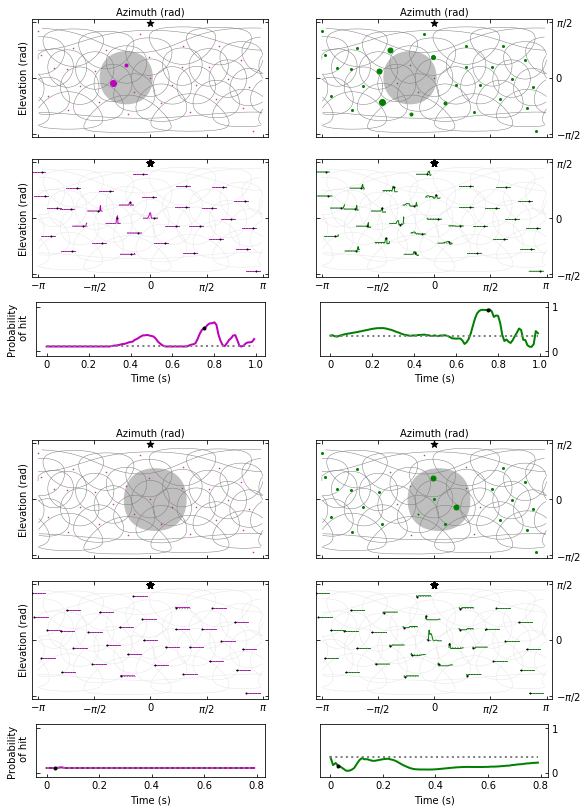

In [4]:
importlib.reload(hpfn)

sample_dt = 0.01
dt = 0.01
delay_dt = 0.03

# Simulations for miss, same stimuli for both outward and inward
# outward
saved_results_path = figure_path + 'model_clustering/clusterings/'
in_or_out = 0 # 0: outward; 1: inward
res_T_max_out = []
prob_mean_out = []
# data
M = 32
K = 12
L = 4
KK = K**2
pad = 2*L
data_path = figure_path + 'movies/model_response/movie_intensities_multi_units/M_32/'
data_types = ['hit', 'miss', 'retreat', 'rotation']
data_type = data_types[1]
path = data_path+data_type+'/'
intensities_sample_cg = np.load(path+'intensities_samples_cg/intensities_sample_cg_list_0.npy', allow_pickle=True)
UV_flow_sample_list = np.load(path+'UV_flow_samples/UV_flow_sample_list_0.npy', allow_pickle=True)
intensities_sample_cg = intensities_sample_cg_list[0]
UV_flow_sample = UV_flow_sample_list[0]
steps = len(intensities_sample_cg)
M = len(intensities_sample_cg[0])
row_L = 4
col_L = np.int(M/4)
intensities_sample_cg_lplc2 = np.ones((steps, row_L*K+(row_L-1)*1, col_L*K+(col_L-1)*1))*0.2

path_traj = data_path+'other_info'+'/'+data_type+'/'+'trajectories/'
traj_list = np.load(path_traj+'traj_list_0.npy', allow_pickle=True)
traj = traj_list[0]

# get the unit at the center
x, y, z = traj[-1, 0, :]
vec = traj[-2, 0, :]-traj[-1, 0, :]
angles = opsg.get_angles_between_lplc2_and_vec(M, vec)
sorted_list = list(np.argsort(angles))
if M == 1:
    lplc2_units = np.array([[0, 0]])
else:
    lplc2_units = opsg.get_lplc2_units_xy_angles(M)
mc = sorted_list[0]
angle_mc = lplc2_units[mc]
print(f'xy angle of the center unit is {angle_mc}.')

for step in range(steps):
    for m in range(M):
        row = np.int(m/col_L)
        col = np.mod(m, col_L)
        intensities_sample_cg_tem = intensities_sample_cg[step][sorted_list[m]]
        if intensities_sample_cg_tem.shape[0] == 1:
            intensities_sample_cg_lplc2[step, row*(K+1):row*(K+1)+K, col*(K+1):col*(K+1)+K] = 0.
        else:
            intensities_sample_cg_lplc2[step, row*(K+1):row*(K+1)+K, col*(K+1):col*(K+1)+K] = intensities_sample_cg_tem[:].reshape((K, K))


leftup_corners = opsg.get_leftup_corners(K, L, pad)
steps = len(UV_flow_sample)
U_flow_lplc2 = np.ones((steps, row_L*K+(row_L-1)*1, col_L*K+(col_L-1)*1))*0.2
V_flow_lplc2 = np.ones((steps, row_L*K+(row_L-1)*1, col_L*K+(col_L-1)*1))*0.2

for step in range(steps):
    cf_u, cf_v = flfd.set_flow_fields_on_frame(UV_flow_sample[step], leftup_corners, K, L, pad)
    for m in range(M):
        row = np.int(m/col_L)
        col = np.mod(m, col_L)
        U_flow_lplc2[step, row*(K+1):row*(K+1)+K, col*(K+1):col*(K+1)+K] = cf_u[sorted_list[m], :, :]
        V_flow_lplc2[step, row*(K+1):row*(K+1)+K, col*(K+1):col*(K+1)+K] = cf_v[sorted_list[m], :, :]

# model
args = {}
args["n"] = 0
args["dt"] = 0.01
args["use_intensity"] = False
args["symmetrize"] = True
args['K'] = 12
args['alpha_leak'] = 0.0
args['M'] = M

model_types = ['excitatory', 'excitatory_WNR', 'inhibitory1', 'inhibitory2']
model_type = model_types[3]

filter_types = ['outward', 'inward']
filter_type = filter_types[in_or_out]

args['temporal_filter'] = False
args['tau_1'] = 1.
model_folders = np.load(saved_results_path+'model_folders_M{}.npy'.format(M), allow_pickle=True)
model_path = model_folders[in_or_out][2]+'/'

UV_flow_sample1 = UV_flow_sample.copy()
res_rest_out, res_T_out, prob_out, prob_rest_out = hpfn.get_response_over_time(args, model_path, model_type, UV_flow_sample1)
res_T_max_out.append(res_T_out.max())
prob_mean_out.append(prob_out.mean())
print(f'Average probability of hit is {prob_mean_out}')
        
# inward
saved_results_path = figure_path + 'model_clustering/clusterings/'
in_or_out = 1 # 0: outward; 1: inward
res_T_max_in = []
prob_mean_in = []
# data
K = 12
L = 4
KK = K**2
pad = 2*L
data_path = figure_path + 'movies/model_response/movie_intensities_multi_units/M_32/'
data_types = ['hit', 'miss', 'retreat', 'rotation']
data_type = data_types[1]
path = data_path+data_type+'/'
intensities_sample_cg = np.load(path+'intensities_samples_cg/intensities_sample_cg_list_0.npy', allow_pickle=True)
UV_flow_sample_list = np.load(path+'UV_flow_samples/UV_flow_sample_list_0.npy', allow_pickle=True)
intensities_sample_cg = intensities_sample_cg_list[0]
UV_flow_sample = UV_flow_sample_list[0]
steps = len(intensities_sample_cg)
M = len(intensities_sample_cg[0])
row_L = 4
col_L = np.int(M/4)
intensities_sample_cg_lplc2 = np.ones((steps, row_L*K+(row_L-1)*1, col_L*K+(col_L-1)*1))*0.2

for step in range(steps):
    for m in range(M):
        row = np.int(m/col_L)
        col = np.mod(m, col_L)
        intensities_sample_cg_tem = intensities_sample_cg[step][sorted_list[m]]
        if intensities_sample_cg_tem.shape[0] == 1:
            intensities_sample_cg_lplc2[step, row*(K+1):row*(K+1)+K, col*(K+1):col*(K+1)+K] = 0.
        else:
            intensities_sample_cg_lplc2[step, row*(K+1):row*(K+1)+K, col*(K+1):col*(K+1)+K] = intensities_sample_cg_tem[:].reshape((K, K))


leftup_corners = opsg.get_leftup_corners(K, L, pad)
steps = len(UV_flow_sample)
U_flow_lplc2 = np.ones((steps, row_L*K+(row_L-1)*1, col_L*K+(col_L-1)*1))*0.2
V_flow_lplc2 = np.ones((steps, row_L*K+(row_L-1)*1, col_L*K+(col_L-1)*1))*0.2

for step in range(steps):
    cf_u, cf_v = flfd.set_flow_fields_on_frame(UV_flow_sample[step], leftup_corners, K, L, pad)
    for m in range(M):
        row = np.int(m/col_L)
        col = np.mod(m, col_L)
        U_flow_lplc2[step, row*(K+1):row*(K+1)+K, col*(K+1):col*(K+1)+K] = cf_u[sorted_list[m], :, :]
        V_flow_lplc2[step, row*(K+1):row*(K+1)+K, col*(K+1):col*(K+1)+K] = cf_v[sorted_list[m], :, :]

# model
args = {}
args["n"] = 0
args["dt"] = 0.01
args["use_intensity"] = False
args["symmetrize"] = True
args['K'] = 12
args['alpha_leak'] = 0.0
args['M'] = M

model_types = ['excitatory', 'excitatory_WNR', 'inhibitory1', 'inhibitory2']
model_type = model_types[3]

filter_types = ['outward', 'inward']
filter_type = filter_types[in_or_out]

args['temporal_filter'] = False
args['tau_1'] = 1.
model_folders = np.load(saved_results_path+'model_folders_M{}.npy'.format(M), allow_pickle=True)
model_path = model_folders[in_or_out][2]+'/'

UV_flow_sample1 = UV_flow_sample.copy()
res_rest_in, res_T_in, prob_in, prob_rest_in = hpfn.get_response_over_time(args, model_path, model_type, UV_flow_sample1)
res_T_max_in.append(res_T_in.max())
prob_mean_in.append(prob_in.mean())
print(f'Mean probability of hit is {prob_mean_in}')
    
    
label_fontsize = 10
title_fontsize = 10
tick_fontsize = 10

fig = plt.figure(figsize=(10, 14))
gs0 = gridspec.GridSpec(11, 10, figure=fig)

## multi unit response, snapshot, outward
gs00 = gridspec.GridSpecFromSubplotSpec(24, 24, subplot_spec=gs0[0:2, :5])
ax = fig.add_subplot(gs00[0:22, 1:23])
t = -25
N = 100
res_m = 0.8
angle_r = np.pi/6
angle_np = np.array([0., np.pi/2])
R = 1
x, y, z = traj[(t+1)*np.int(sample_dt/dt), 0, :]
angle_rb = opsg.get_angular_size(x, y, z, R)
angle_b = opsg.get_xy_angles(x, y, z) 
angles_on_map_b = hpfn.get_projection_one_unit(angle_mc, angle_b, angle_rb, N)
segments_list_b = hpfn.get_segments(angles_on_map_b[3:])
segments_list_b = hpfn.get_segments_ball(segments_list_b)
for segment in segments_list_b:
    if angles_on_map_b[2][1]+angle_rb > np.pi/2:
        ax.fill_between(segment[:, 0], segment[:, 1], np.ones_like(segment[:, 0])*np.pi/2, \
                         facecolor=[0.5, 0.5, 0.5], edgecolor=None, alpha=0.5)
    elif angles_on_map_b[2][1]-angle_rb < -np.pi/2:
        ax.fill_between(segment[:, 0], segment[:, 1], -np.ones_like(segment[:, 0])*np.pi/2, \
                         facecolor=[0.5, 0.5, 0.5], edgecolor=None, alpha=0.5)
    else:
        ax.fill_between(segment[:, 0], segment[:, 1], facecolor=[0.5, 0.5, 0.5], edgecolor=None, alpha=0.5)
# for segment in segments_list_b:
#     if angles_on_map_b[2][1]+angle_rb < np.pi/2:
#         ax.fill_between(segment[:, 0], segment[:, 1], facecolor=[0.5, 0.5, 0.5], edgecolor=None, alpha=0.5)
#     else:
#         ax.fill_between(segment[:, 0], segment[:, 1], np.ones_like(segment[:, 0])*np.pi/2, facecolor=[0.5, 0.5, 0.5], edgecolor=None, alpha=0.5)
for m in range(M):
    angle_m = lplc2_units[sorted_list[m]]
    angles_on_map = hpfn.get_projection_one_unit(angle_mc, angle_m, angle_r, N)
    xx = angles_on_map[0]
    yy = angles_on_map[1]
    zz = angles_on_map[2]
    xx = hpfn.get_normalized(zz, xx)
    yy = hpfn.get_normalized(zz, yy)
#         ax.plot([zz[0], xx[0]], [zz[1], xx[1]], c='r')
#         ax.plot([zz[0], yy[0]], [zz[1], yy[1]], c='b')
    segments_list = hpfn.get_segments(angles_on_map[3:])
    for segment in segments_list:
        ax.plot(segment[:, 0], segment[:, 1], c=[0.5, 0.5, 0.5], linewidth = 0.5, alpha=1)
# Add north pole
angles_np_on_map = hpfn.get_projection_one_unit(angle_mc, angle_np, angle_r, N)
ax.scatter(angles_np_on_map[2][0], angles_np_on_map[2][1], s=50, c='k', marker='*')
# Add response
for m in range(M):
    angle_m = lplc2_units[sorted_list[m]]
    angles_on_map = hpfn.get_projection_one_unit(angle_mc, angle_m, angle_r, N)
    xx = angles_on_map[0]
    yy = angles_on_map[1]
    zz = angles_on_map[2]
    xx = hpfn.get_normalized(zz, xx)
    yy = hpfn.get_normalized(zz, yy)
    if res_T_out[t, sorted_list[m]] == 0:
        ax.plot(zz[0], zz[1], marker='o', markersize=1, markerfacecolor='None', markeredgecolor='m', markeredgewidth=0.5)
    else:
        ax.plot(zz[0], zz[1], marker='o', markersize=1+np.int(3*res_T_out[t, sorted_list[m]]/res_m), c='m')
ax.set_xlim([-np.pi*1.05, np.pi*1.05])
ax.set_ylim([-np.pi/2*1.05, np.pi/2*1.05])
ax.set_xticks([-np.pi, -np.pi/2, 0., np.pi/2, np.pi])
ax.set_xticklabels([])
ax.set_yticks([-np.pi/2, 0., np.pi/2])
ax.set_yticklabels([])
ax.set_xlabel('Azimuth (rad)', fontsize=label_fontsize)
ax.set_ylabel('Elevation (rad)', fontsize=label_fontsize)
ax.set_aspect('equal', adjustable='box')
ax.xaxis.set_label_position('top')
ax.yaxis.tick_right()
ax.tick_params(direction='in', labelsize=tick_fontsize, bottom=True, top=True, left=True, right=True)


## multi unit response, snapshot, inward
gs00 = gridspec.GridSpecFromSubplotSpec(24, 24, subplot_spec=gs0[0:2, 5:10])
ax = fig.add_subplot(gs00[0:22, 1:23])
N = 100
res_m = 0.8
angle_r = np.pi/6
R = 1
x, y, z = traj[(t+1)*np.int(sample_dt/dt), 0, :]
angle_rb = opsg.get_angular_size(x, y, z, R)
angle_b = opsg.get_xy_angles(x, y, z) 
angles_on_map_b = hpfn.get_projection_one_unit(angle_mc, angle_b, angle_rb, N)
segments_list_b = hpfn.get_segments(angles_on_map_b[3:])
segments_list_b = hpfn.get_segments_ball(segments_list_b)
for segment in segments_list_b:
    if angles_on_map_b[2][1]+angle_rb > np.pi/2:
        ax.fill_between(segment[:, 0], segment[:, 1], np.ones_like(segment[:, 0])*np.pi/2, \
                         facecolor=[0.5, 0.5, 0.5], edgecolor=None, alpha=0.5)
    elif angles_on_map_b[2][1]-angle_rb < -np.pi/2:
        ax.fill_between(segment[:, 0], segment[:, 1], -np.ones_like(segment[:, 0])*np.pi/2, \
                         facecolor=[0.5, 0.5, 0.5], edgecolor=None, alpha=0.5)
    else:
        ax.fill_between(segment[:, 0], segment[:, 1], facecolor=[0.5, 0.5, 0.5], edgecolor=None, alpha=0.5)
# for segment in segments_list_b:
#     if angles_on_map_b[2][1]+angle_rb < np.pi/2:
#         ax.fill_between(segment[:, 0], segment[:, 1], facecolor=[0.5, 0.5, 0.5], edgecolor=None, alpha=0.5)
#     else:
#         ax.fill_between(segment[:, 0], segment[:, 1], np.ones_like(segment[:, 0])*np.pi/2, facecolor=[0.5, 0.5, 0.5], edgecolor=None, alpha=0.5)
for m in range(M):
    angle_m = lplc2_units[sorted_list[m]]
    angles_on_map = hpfn.get_projection_one_unit(angle_mc, angle_m, angle_r, N)
    xx = angles_on_map[0]
    yy = angles_on_map[1]
    zz = angles_on_map[2]
    xx = hpfn.get_normalized(zz, xx)
    yy = hpfn.get_normalized(zz, yy)
#         ax.plot([zz[0], xx[0]], [zz[1], xx[1]], c='r')
#         ax.plot([zz[0], yy[0]], [zz[1], yy[1]], c='b')
    segments_list = hpfn.get_segments(angles_on_map[3:])
    for segment in segments_list:
        ax.plot(segment[:, 0], segment[:, 1], c=[0.5, 0.5, 0.5], linewidth = 0.5, alpha=1)
# Add north pole
angles_np_on_map = hpfn.get_projection_one_unit(angle_mc, angle_np, angle_r, N)
ax.scatter(angles_np_on_map[2][0], angles_np_on_map[2][1], s=50, c='k', marker='*')
# Add response
for m in range(M):
    angle_m = lplc2_units[sorted_list[m]]
    angles_on_map = hpfn.get_projection_one_unit(angle_mc, angle_m, angle_r, N)
    xx = angles_on_map[0]
    yy = angles_on_map[1]
    zz = angles_on_map[2]
    xx = hpfn.get_normalized(zz, xx)
    yy = hpfn.get_normalized(zz, yy)
    if res_T_in[t, sorted_list[m]] == 0:
        ax.plot(zz[0], zz[1], marker='o', markersize=1, markerfacecolor='None', markeredgecolor='g', markeredgewidth=0.5)
    else:
        ax.plot(zz[0], zz[1], marker='o', markersize=1+np.int(3*res_T_in[t, sorted_list[m]]/res_m), c='g')
ax.set_xlim([-np.pi*1.05, np.pi*1.05])
ax.set_ylim([-np.pi/2*1.05, np.pi/2*1.05])
ax.set_xticks([-np.pi, -np.pi/2, 0., np.pi/2, np.pi])
ax.set_xticklabels([])
ax.set_yticks([-np.pi/2, 0., np.pi/2])
ax.set_yticklabels(['$-\pi/2$', '0', '$\pi/2$'])
ax.set_xlabel('Azimuth (rad)', fontsize=label_fontsize)
ax.set_aspect('equal', adjustable='box')
ax.xaxis.set_label_position('top')
ax.yaxis.tick_right()
ax.tick_params(direction='in', labelsize=tick_fontsize, bottom=True, top=True, left=True, right=True)


## multi unit response, whole response trajectory, outward
gs00 = gridspec.GridSpecFromSubplotSpec(24, 24, subplot_spec=gs0[2:4, 0:5])
ax = fig.add_subplot(gs00[0:22, 1:23])
N = 100
res_m = 2
if M == 1:
    lplc2_units = np.array([[0, 0]])
else:
    lplc2_units = opsg.get_lplc2_units_xy_angles(M)
mc = sorted_list[0]
angle_mc = lplc2_units[mc]
angle_r = np.pi/6
angle_np = np.array([0., np.pi/2])

for m in range(M):
    angle_m = lplc2_units[sorted_list[m]]
    angles_on_map = hpfn.get_projection_one_unit(angle_mc, angle_m, angle_r, N)
    xx = angles_on_map[0]
    yy = angles_on_map[1]
    zz = angles_on_map[2]
    xx = hpfn.get_normalized(zz, xx)
    yy = hpfn.get_normalized(zz, yy)
    # Add north pole
    angles_np_on_map = hpfn.get_projection_one_unit(angle_mc, angle_np, angle_r, N)
    ax.scatter(angles_np_on_map[2][0], angles_np_on_map[2][1], s=50, c='k', marker='*')
    segments_list = hpfn.get_segments(angles_on_map[3:])
    for segment in segments_list:
        ax.plot(segment[:, 0], segment[:, 1], c=[0.9, 0.9, 0.9], linewidth = 0.5, alpha=1)
for m in range(M):
    angle_m = lplc2_units[sorted_list[m]]
    angles_on_map = hpfn.get_projection_one_unit(angle_mc, angle_m, angle_r, N)
    xx = angles_on_map[0]
    yy = angles_on_map[1]
    zz = angles_on_map[2]
    xx = hpfn.get_normalized(zz, xx)
    yy = hpfn.get_normalized(zz, yy)
    res_x = np.linspace(zz[0]-np.pi/16, zz[0]+np.pi/16, len(res_T_out[:, sorted_list[m]]))
#     ax.text(zz[0]-0.2, zz[1]-0.1, np.array2string(np.array(m)), fontsize=10)
#     if m == 11:
#         ax.plot([res_x[0]-0.01, res_x[0]-0.01], [(0-res_rest_out[sorted_list[m]])/res_m*np.pi/16+zz[1], np.round((res_m-res_rest_out[sorted_list[m]])/res_m*np.pi/16, 1)+zz[1]], 'k', linewidth=0.5)
#         ax.plot([res_x[0]-0.01, res_x[-1]], [(0-res_rest_out[sorted_list[m]])/res_m*np.pi/16+zz[1], (0-res_rest_out[sorted_list[m]])/res_m*np.pi/16+zz[1]], 'k', linewidth=0.5)
    ax.plot(res_x, (res_T_out[:, sorted_list[m]]-res_rest_out[sorted_list[m]])/res_m*np.pi/16+zz[1], c='m', linewidth=1)
    ax.plot(res_x, np.ones(len(res_T_out[:, sorted_list[m]]))*zz[1], c=[0.5, 0.5, 0.5], linestyle=':', linewidth=1)
    ax.plot(res_x[t], (res_T_out[t, sorted_list[m]]-res_rest_out[sorted_list[m]])/res_m*np.pi/16+zz[1], marker='.', c='k', markersize=2)
ax.set_xlim([-np.pi*1.05, np.pi*1.05])
ax.set_ylim([-np.pi/2*1.05, np.pi/2*1.05])
ax.set_xticks([-np.pi, -np.pi/2, 0., np.pi/2, np.pi])
ax.set_xticklabels(['$-\pi$', '$-\pi/2$', '0', '$\pi/2$', '$\pi$'])
ax.set_yticks([-np.pi/2, 0., np.pi/2])
ax.set_yticklabels([])
ax.set_ylabel('Elevation (rad)', fontsize=label_fontsize)
ax.set_aspect('equal', adjustable='box')
ax.yaxis.tick_right()
ax.tick_params(direction='in', labelsize=tick_fontsize, bottom=True, top=True, left=True, right=True)


## multi unit response, whole response trajectory, inward
gs00 = gridspec.GridSpecFromSubplotSpec(24, 24, subplot_spec=gs0[2:4, 5:10])
ax = fig.add_subplot(gs00[0:22, 1:23])
N = 100
res_m = 2
if M == 1:
    lplc2_units = np.array([[0, 0]])
else:
    lplc2_units = opsg.get_lplc2_units_xy_angles(M)
mc = sorted_list[0]
angle_mc = lplc2_units[mc]
angle_r = np.pi/6

for m in range(M):
    angle_m = lplc2_units[sorted_list[m]]
    angles_on_map = hpfn.get_projection_one_unit(angle_mc, angle_m, angle_r, N)
    xx = angles_on_map[0]
    yy = angles_on_map[1]
    zz = angles_on_map[2]
    xx = hpfn.get_normalized(zz, xx)
    yy = hpfn.get_normalized(zz, yy)
    # Add north pole
    angles_np_on_map = hpfn.get_projection_one_unit(angle_mc, angle_np, angle_r, N)
    ax.scatter(angles_np_on_map[2][0], angles_np_on_map[2][1], s=50, c='k', marker='*')
    segments_list = hpfn.get_segments(angles_on_map[3:])
    for segment in segments_list:
        ax.plot(segment[:, 0], segment[:, 1], c=[0.9, 0.9, 0.9], linewidth = 0.5, alpha=1)
for m in range(M):
    angle_m = lplc2_units[sorted_list[m]]
    angles_on_map = hpfn.get_projection_one_unit(angle_mc, angle_m, angle_r, N)
    xx = angles_on_map[0]
    yy = angles_on_map[1]
    zz = angles_on_map[2]
    xx = hpfn.get_normalized(zz, xx)
    yy = hpfn.get_normalized(zz, yy)
    res_x = np.linspace(zz[0]-np.pi/16, zz[0]+np.pi/16, len(res_T_in[:, sorted_list[m]]))
#     ax.text(zz[0]-0.2, zz[1]-0.1, np.array2string(np.array(m)), fontsize=10)
#     if m == 11:
#         ax.plot([res_x[0]-0.01, res_x[0]-0.01], [(0-res_rest_in[sorted_list[m]])/res_m*np.pi/16+zz[1], np.round((res_m-res_rest_in[sorted_list[m]])/res_m*np.pi/16, 1)+zz[1]], 'k', linewidth=0.5)
#         ax.plot([res_x[0]-0.01, res_x[-1]], [(0-res_rest_in[sorted_list[m]])/res_m*np.pi/16+zz[1], (0-res_rest_in[sorted_list[m]])/res_m*np.pi/16+zz[1]], 'k', linewidth=0.5)
    ax.plot(res_x, (res_T_in[:, sorted_list[m]]-res_rest_in[sorted_list[m]])/res_m*np.pi/16+zz[1], c='g', linewidth=1)
    ax.plot(res_x, np.ones(len(res_T_in[:, sorted_list[m]]))*zz[1], c=[0.5, 0.5, 0.5], linestyle=':', linewidth=1)
    ax.plot(res_x[t], (res_T_in[t, sorted_list[m]]-res_rest_in[sorted_list[m]])/res_m*np.pi/16+zz[1], marker='.', c='k', markersize=2)
ax.set_xlim([-np.pi*1.05, np.pi*1.05])
ax.set_ylim([-np.pi/2*1.05, np.pi/2*1.05])
ax.set_xticks([-np.pi, -np.pi/2, 0., np.pi/2, np.pi])
ax.set_xticklabels(['$-\pi$', '$-\pi/2$', '0', '$\pi/2$', '$\pi$'])
ax.set_yticks([-np.pi/2, 0., np.pi/2])
ax.set_yticklabels(['$-\pi/2$', '0', '$\pi/2$'])
ax.set_aspect('equal', adjustable='box')
ax.yaxis.tick_right()
ax.tick_params(direction='in', labelsize=tick_fontsize, bottom=True, top=True, left=True, right=True)


## multi unit response, whole probability trajectory, outward
gs00 = gridspec.GridSpecFromSubplotSpec(24, 24, subplot_spec=gs0[4:5, 0:5])
ax = fig.add_subplot(gs00[1:23, 2:22])
ax.plot(prob_out[:], c='m', linewidth=2)
ax.plot([0, len(prob_out[:])-1], [prob_rest_out, prob_rest_out], c=[0.5, 0.5, 0.5], linewidth=2, linestyle=':')
ax.plot(len(prob_out[:])+t, prob_out[t], marker='.', c='k', markersize=6)
ax.set_ylim([-0.1, 1.1])
ax.set_xlabel('Time (s)', fontsize=label_fontsize)
ax.set_ylabel('Probability\n of hit', fontsize=label_fontsize)
ax.set_xticks([0, 20, 40, 60, 80, 100])
ax.set_xticklabels(['0', '0.2', '0.4', '0.6', '0.8', '1.0'])
ax.set_yticks([0, 1])
ax.set_yticklabels([])
ax.tick_params(direction='in', labelsize=tick_fontsize)


## multi unit response, whole probability trajectory, inward
gs00 = gridspec.GridSpecFromSubplotSpec(24, 24, subplot_spec=gs0[4:5, 5:10])
ax = fig.add_subplot(gs00[1:23, 2:22])
ax.plot(prob_in[:], c='g', linewidth=2)
ax.plot([0, len(prob_in[:])-1], [prob_rest_in, prob_rest_in], c=[0.5, 0.5, 0.5], linewidth=2, linestyle=':')
ax.plot(len(prob_in[:])+t, prob_in[t], marker='.', c='k', markersize=6)
ax.set_ylim([-0.1, 1.1])
ax.set_xlabel('Time (s)', fontsize=label_fontsize)
ax.set_xticks([0, 20, 40, 60, 80, 100])
ax.set_xticklabels(['0', '0.2', '0.4', '0.6', '0.8', '1.0'])
ax.set_yticks([0, 1])
ax.set_yticklabels([0, 1])
ax.yaxis.tick_right()
ax.tick_params(direction='in', labelsize=tick_fontsize)


####### Simulations for retreat, same stimuli for both outward and inward
# outward
saved_results_path = figure_path + 'model_clustering/clusterings/'
in_or_out = 0 # 0: outward; 1: inward
res_T_max_out = []
prob_mean_out = []
# data
K = 12
L = 4
KK = K**2
pad = 2*L
data_path = figure_path + 'movies/model_response/movie_intensities_multi_units/M_32/'
data_types = ['hit', 'miss', 'retreat', 'rotation']
data_type = data_types[2]
path = data_path+data_type+'/'
intensities_sample_cg = np.load(path+'intensities_samples_cg/intensities_sample_cg_list_0.npy', allow_pickle=True)
UV_flow_sample_list = np.load(path+'UV_flow_samples/UV_flow_sample_list_0.npy', allow_pickle=True)
intensities_sample_cg = intensities_sample_cg_list[0]
UV_flow_sample = UV_flow_sample_list[0]
steps = len(intensities_sample_cg)
M = len(intensities_sample_cg[0])
row_L = 4
col_L = np.int(M/4)
intensities_sample_cg_lplc2 = np.ones((steps, row_L*K+(row_L-1)*1, col_L*K+(col_L-1)*1))*0.2

path_traj = data_path+'other_info'+'/'+data_type+'/'+'trajectories/'
traj_list = np.load(path_traj+'traj_list_0.npy', allow_pickle=True)
traj = traj_list[0]

# get the unit at the center
x, y, z = traj[-1, 0, :]
vec = traj[-1, 0, :]-traj[-2, 0, :]
angles = opsg.get_angles_between_lplc2_and_vec(M, vec)
sorted_list = list(np.argsort(angles))
if M == 1:
    lplc2_units = np.array([[0, 0]])
else:
    lplc2_units = opsg.get_lplc2_units_xy_angles(M)
mc = sorted_list[0]
angle_mc = lplc2_units[mc]
print(f'xy angle of the center unit is {angle_mc}.')

for step in range(steps):
    for m in range(M):
        row = np.int(m/col_L)
        col = np.mod(m, col_L)
        intensities_sample_cg_tem = intensities_sample_cg[step][sorted_list[m]]
        if intensities_sample_cg_tem.shape[0] == 1:
            intensities_sample_cg_lplc2[step, row*(K+1):row*(K+1)+K, col*(K+1):col*(K+1)+K] = 0.
        else:
            intensities_sample_cg_lplc2[step, row*(K+1):row*(K+1)+K, col*(K+1):col*(K+1)+K] = intensities_sample_cg_tem[:].reshape((K, K))


leftup_corners = opsg.get_leftup_corners(K, L, pad)
steps = len(UV_flow_sample)
U_flow_lplc2 = np.ones((steps, row_L*K+(row_L-1)*1, col_L*K+(col_L-1)*1))*0.2
V_flow_lplc2 = np.ones((steps, row_L*K+(row_L-1)*1, col_L*K+(col_L-1)*1))*0.2

for step in range(steps):
    cf_u, cf_v = flfd.set_flow_fields_on_frame(UV_flow_sample[step], leftup_corners, K, L, pad)
    for m in range(M):
        row = np.int(m/col_L)
        col = np.mod(m, col_L)
        U_flow_lplc2[step, row*(K+1):row*(K+1)+K, col*(K+1):col*(K+1)+K] = cf_u[sorted_list[m], :, :]
        V_flow_lplc2[step, row*(K+1):row*(K+1)+K, col*(K+1):col*(K+1)+K] = cf_v[sorted_list[m], :, :]

# model
args = {}
args["n"] = 0
args["dt"] = 0.01
args["use_intensity"] = False
args["symmetrize"] = True
args['K'] = 12
args['alpha_leak'] = 0.0
args['M'] = M

model_types = ['excitatory', 'excitatory_WNR', 'inhibitory1', 'inhibitory2']
model_type = model_types[3]

filter_types = ['outward', 'inward']
filter_type = filter_types[in_or_out]

args['temporal_filter'] = False
args['tau_1'] = 1.
model_folders = np.load(saved_results_path+'model_folders_M{}.npy'.format(M), allow_pickle=True)
model_path = model_folders[in_or_out][2]+'/'

UV_flow_sample1 = UV_flow_sample.copy()
res_rest_out, res_T_out, prob_out, prob_rest_out = hpfn.get_response_over_time(args, model_path, model_type, UV_flow_sample1)
res_T_max_out.append(res_T_out.max())
prob_mean_out.append(prob_out.mean())
print(prob_mean_out)
        
# inward
saved_results_path = figure_path + 'model_clustering/clusterings/'
in_or_out = 1 # 0: outward; 1: inward
res_T_max_in = []
prob_mean_in = []
# data
K = 12
L = 4
KK = K**2
pad = 2*L
data_path = figure_path + 'movies/model_response/movie_intensities_multi_units/M_32/'
data_types = ['hit', 'miss', 'retreat', 'rotation']
data_type = data_types[2]
path = data_path+data_type+'/'
intensities_sample_cg = np.load(path+'intensities_samples_cg/intensities_sample_cg_list_0.npy', allow_pickle=True)
UV_flow_sample_list = np.load(path+'UV_flow_samples/UV_flow_sample_list_0.npy', allow_pickle=True)
intensities_sample_cg = intensities_sample_cg_list[0]
UV_flow_sample = UV_flow_sample_list[0]
steps = len(intensities_sample_cg)
M = len(intensities_sample_cg[0])
row_L = 4
col_L = np.int(M/4)
intensities_sample_cg_lplc2 = np.ones((steps, row_L*K+(row_L-1)*1, col_L*K+(col_L-1)*1))*0.2

for step in range(steps):
    for m in range(M):
        row = np.int(m/col_L)
        col = np.mod(m, col_L)
        intensities_sample_cg_tem = intensities_sample_cg[step][sorted_list[m]]
        if intensities_sample_cg_tem.shape[0] == 1:
            intensities_sample_cg_lplc2[step, row*(K+1):row*(K+1)+K, col*(K+1):col*(K+1)+K] = 0.
        else:
            intensities_sample_cg_lplc2[step, row*(K+1):row*(K+1)+K, col*(K+1):col*(K+1)+K] = intensities_sample_cg_tem[:].reshape((K, K))


leftup_corners = opsg.get_leftup_corners(K, L, pad)
steps = len(UV_flow_sample)
U_flow_lplc2 = np.ones((steps, row_L*K+(row_L-1)*1, col_L*K+(col_L-1)*1))*0.2
V_flow_lplc2 = np.ones((steps, row_L*K+(row_L-1)*1, col_L*K+(col_L-1)*1))*0.2

for step in range(steps):
    cf_u, cf_v = flfd.set_flow_fields_on_frame(UV_flow_sample[step], leftup_corners, K, L, pad)
    for m in range(M):
        row = np.int(m/col_L)
        col = np.mod(m, col_L)
        U_flow_lplc2[step, row*(K+1):row*(K+1)+K, col*(K+1):col*(K+1)+K] = cf_u[sorted_list[m], :, :]
        V_flow_lplc2[step, row*(K+1):row*(K+1)+K, col*(K+1):col*(K+1)+K] = cf_v[sorted_list[m], :, :]

# model
args = {}
args["n"] = 0
args["dt"] = 0.01
args["use_intensity"] = False
args["symmetrize"] = True
args['K'] = 12
args['alpha_leak'] = 0.0
args['M'] = M

model_types = ['excitatory', 'excitatory_WNR', 'inhibitory1', 'inhibitory2']
model_type = model_types[3]

filter_types = ['outward', 'inward']
filter_type = filter_types[in_or_out]

args['temporal_filter'] = False
args['tau_1'] = 1.
model_folders = np.load(saved_results_path+'model_folders_M{}.npy'.format(M), allow_pickle=True)
model_path = model_folders[in_or_out][2]+'/'

UV_flow_sample1 = UV_flow_sample.copy()
res_rest_in, res_T_in, prob_in, prob_rest_in = hpfn.get_response_over_time(args, model_path, model_type, UV_flow_sample1)
res_T_max_in.append(res_T_in.max())
prob_mean_in.append(prob_in.mean())
print(f'Average probability of hit is {prob_mean_in}')
    

## multi unit response, snapshot, outward
gs00 = gridspec.GridSpecFromSubplotSpec(24, 24, subplot_spec=gs0[6:8, :5])
ax = fig.add_subplot(gs00[0:22, 1:23])
t = 3
N = 100
res_m = 0.8
angle_r = np.pi/6
angle_np = np.array([0., np.pi/2])
R = 1
x, y, z = traj[(t+1)*np.int(sample_dt/dt), 0, :]
angle_rb = opsg.get_angular_size(x, y, z, R)
angle_b = opsg.get_xy_angles(x, y, z) 
angles_on_map_b = hpfn.get_projection_one_unit(angle_mc, angle_b, angle_rb, N)
segments_list_b = hpfn.get_segments(angles_on_map_b[3:])
segments_list_b = hpfn.get_segments_ball(segments_list_b)
for segment in segments_list_b:
    if angles_on_map_b[2][1]+angle_rb > np.pi/2:
        ax.fill_between(segment[:, 0], segment[:, 1], np.ones_like(segment[:, 0])*np.pi/2, \
                         facecolor=[0.5, 0.5, 0.5], edgecolor=None, alpha=0.5)
    elif angles_on_map_b[2][1]-angle_rb < -np.pi/2:
        ax.fill_between(segment[:, 0], segment[:, 1], -np.ones_like(segment[:, 0])*np.pi/2, \
                         facecolor=[0.5, 0.5, 0.5], edgecolor=None, alpha=0.5)
    else:
        ax.fill_between(segment[:, 0], segment[:, 1], facecolor=[0.5, 0.5, 0.5], edgecolor=None, alpha=0.5)
# for segment in segments_list_b:
#     if angles_on_map_b[2][1]+angle_rb < np.pi/2:
#         ax.fill_between(segment[:, 0], segment[:, 1], facecolor=[0.5, 0.5, 0.5], edgecolor=None, alpha=0.5)
#     else:
#         ax.fill_between(segment[:, 0], segment[:, 1], np.ones_like(segment[:, 0])*np.pi/2, facecolor=[0.5, 0.5, 0.5], edgecolor=None, alpha=0.5)
for m in range(M):
    angle_m = lplc2_units[sorted_list[m]]
    angles_on_map = hpfn.get_projection_one_unit(angle_mc, angle_m, angle_r, N)
    xx = angles_on_map[0]
    yy = angles_on_map[1]
    zz = angles_on_map[2]
    xx = hpfn.get_normalized(zz, xx)
    yy = hpfn.get_normalized(zz, yy)
#         ax.plot([zz[0], xx[0]], [zz[1], xx[1]], c='r')
#         ax.plot([zz[0], yy[0]], [zz[1], yy[1]], c='b')
    segments_list = hpfn.get_segments(angles_on_map[3:])
    for segment in segments_list:
        ax.plot(segment[:, 0], segment[:, 1], c=[0.5, 0.5, 0.5], linewidth = 0.5, alpha=1)
# Add north pole
angles_np_on_map = hpfn.get_projection_one_unit(angle_mc, angle_np, angle_r, N)
ax.scatter(angles_np_on_map[2][0], angles_np_on_map[2][1], s=50, c='k', marker='*')
# Add response
for m in range(M):
    angle_m = lplc2_units[sorted_list[m]]
    angles_on_map = hpfn.get_projection_one_unit(angle_mc, angle_m, angle_r, N)
    xx = angles_on_map[0]
    yy = angles_on_map[1]
    zz = angles_on_map[2]
    xx = hpfn.get_normalized(zz, xx)
    yy = hpfn.get_normalized(zz, yy)
    if res_T_out[t, sorted_list[m]] == 0:
        ax.plot(zz[0], zz[1], marker='o', markersize=1, markerfacecolor='None', markeredgecolor='m', markeredgewidth=0.5)
    else:
        ax.plot(zz[0], zz[1], marker='o', markersize=1+np.int(3*res_T_out[t, sorted_list[m]]/res_m), c='m')
ax.set_xlim([-np.pi*1.05, np.pi*1.05])
ax.set_ylim([-np.pi/2*1.05, np.pi/2*1.05])
ax.set_xticks([-np.pi, -np.pi/2, 0., np.pi/2, np.pi])
ax.set_xticklabels([])
ax.set_yticks([-np.pi/2, 0., np.pi/2])
ax.set_yticklabels([])
ax.set_xlabel('Azimuth (rad)', fontsize=label_fontsize)
ax.set_ylabel('Elevation (rad)', fontsize=label_fontsize)
ax.set_aspect('equal', adjustable='box')
ax.xaxis.set_label_position('top')
ax.yaxis.tick_right()
ax.tick_params(direction='in', labelsize=tick_fontsize, bottom=True, top=True, left=True, right=True)


## multi unit response, snapshot, inward
gs00 = gridspec.GridSpecFromSubplotSpec(24, 24, subplot_spec=gs0[6:8, 5:10])
ax = fig.add_subplot(gs00[0:22, 1:23])
N = 100
res_m = 0.8
angle_r = np.pi/6
R = 1
x, y, z = traj[(t+1)*np.int(sample_dt/dt), 0, :]
angle_rb = opsg.get_angular_size(x, y, z, R)
angle_b = opsg.get_xy_angles(x, y, z) 
angles_on_map_b = hpfn.get_projection_one_unit(angle_mc, angle_b, angle_rb, N)
segments_list_b = hpfn.get_segments(angles_on_map_b[3:])
segments_list_b = hpfn.get_segments_ball(segments_list_b)
for segment in segments_list_b:
    if angles_on_map_b[2][1]+angle_rb > np.pi/2:
        ax.fill_between(segment[:, 0], segment[:, 1], np.ones_like(segment[:, 0])*np.pi/2, \
                         facecolor=[0.5, 0.5, 0.5], edgecolor=None, alpha=0.5)
    elif angles_on_map_b[2][1]-angle_rb < -np.pi/2:
        ax.fill_between(segment[:, 0], segment[:, 1], -np.ones_like(segment[:, 0])*np.pi/2, \
                         facecolor=[0.5, 0.5, 0.5], edgecolor=None, alpha=0.5)
    else:
        ax.fill_between(segment[:, 0], segment[:, 1], facecolor=[0.5, 0.5, 0.5], edgecolor=None, alpha=0.5)
# for segment in segments_list_b:
#     if angles_on_map_b[2][1]+angle_rb < np.pi/2:
#         ax.fill_between(segment[:, 0], segment[:, 1], facecolor=[0.5, 0.5, 0.5], edgecolor=None, alpha=0.5)
#     else:
#         ax.fill_between(segment[:, 0], segment[:, 1], np.ones_like(segment[:, 0])*np.pi/2, facecolor=[0.5, 0.5, 0.5], edgecolor=None, alpha=0.5)
for m in range(M):
    angle_m = lplc2_units[sorted_list[m]]
    angles_on_map = hpfn.get_projection_one_unit(angle_mc, angle_m, angle_r, N)
    xx = angles_on_map[0]
    yy = angles_on_map[1]
    zz = angles_on_map[2]
    xx = hpfn.get_normalized(zz, xx)
    yy = hpfn.get_normalized(zz, yy)
#         ax.plot([zz[0], xx[0]], [zz[1], xx[1]], c='r')
#         ax.plot([zz[0], yy[0]], [zz[1], yy[1]], c='b')
    segments_list = hpfn.get_segments(angles_on_map[3:])
    for segment in segments_list:
        ax.plot(segment[:, 0], segment[:, 1], c=[0.5, 0.5, 0.5], linewidth = 0.5, alpha=1)
# Add north pole
angles_np_on_map = hpfn.get_projection_one_unit(angle_mc, angle_np, angle_r, N)
ax.scatter(angles_np_on_map[2][0], angles_np_on_map[2][1], s=50, c='k', marker='*')
# Add response
for m in range(M):
    angle_m = lplc2_units[sorted_list[m]]
    angles_on_map = hpfn.get_projection_one_unit(angle_mc, angle_m, angle_r, N)
    xx = angles_on_map[0]
    yy = angles_on_map[1]
    zz = angles_on_map[2]
    xx = hpfn.get_normalized(zz, xx)
    yy = hpfn.get_normalized(zz, yy)
    if res_T_in[t, sorted_list[m]] == 0:
        ax.plot(zz[0], zz[1], marker='o', markersize=1, markerfacecolor='None', markeredgecolor='g', markeredgewidth=0.5)
    else:
        ax.plot(zz[0], zz[1], marker='o', markersize=1+np.int(3*res_T_in[t, sorted_list[m]]/res_m), c='g')
ax.set_xlim([-np.pi*1.05, np.pi*1.05])
ax.set_ylim([-np.pi/2*1.05, np.pi/2*1.05])
ax.set_xticks([-np.pi, -np.pi/2, 0., np.pi/2, np.pi])
ax.set_xticklabels([])
ax.set_yticks([-np.pi/2, 0., np.pi/2])
ax.set_yticklabels(['$-\pi/2$', '0', '$\pi/2$'])
ax.set_xlabel('Azimuth (rad)', fontsize=label_fontsize)
ax.set_aspect('equal', adjustable='box')
ax.xaxis.set_label_position('top')
ax.yaxis.tick_right()
ax.tick_params(direction='in', labelsize=tick_fontsize, bottom=True, top=True, left=True, right=True)


## multi unit response, whole response trajectory, outward
gs00 = gridspec.GridSpecFromSubplotSpec(24, 24, subplot_spec=gs0[8:10, 0:5])
ax = fig.add_subplot(gs00[0:22, 1:23])
N = 100
res_m = 2
angle_r = np.pi/6
angle_np = np.array([0., np.pi/2])

for m in range(M):
    angle_m = lplc2_units[sorted_list[m]]
    angles_on_map = hpfn.get_projection_one_unit(angle_mc, angle_m, angle_r, N)
    xx = angles_on_map[0]
    yy = angles_on_map[1]
    zz = angles_on_map[2]
    xx = hpfn.get_normalized(zz, xx)
    yy = hpfn.get_normalized(zz, yy)
    # Add north pole
    angles_np_on_map = hpfn.get_projection_one_unit(angle_mc, angle_np, angle_r, N)
    ax.scatter(angles_np_on_map[2][0], angles_np_on_map[2][1], s=50, c='k', marker='*')
    segments_list = hpfn.get_segments(angles_on_map[3:])
    for segment in segments_list:
        ax.plot(segment[:, 0], segment[:, 1], c=[0.9, 0.9, 0.9], linewidth = 0.5, alpha=1)
for m in range(M):
    angle_m = lplc2_units[sorted_list[m]]
    angles_on_map = hpfn.get_projection_one_unit(angle_mc, angle_m, angle_r, N)
    xx = angles_on_map[0]
    yy = angles_on_map[1]
    zz = angles_on_map[2]
    xx = hpfn.get_normalized(zz, xx)
    yy = hpfn.get_normalized(zz, yy)
    res_x = np.linspace(zz[0]-np.pi/16, zz[0]+np.pi/16, len(res_T_out[:, sorted_list[m]]))
#     ax.text(zz[0]-0.2, zz[1]-0.1, np.array2string(np.array(m)), fontsize=10)
#     if m == 11:
#         ax.plot([res_x[0]-0.01, res_x[0]-0.01], [(0-res_rest_out[sorted_list[m]])/res_m*np.pi/16+zz[1], np.round((res_m-res_rest_out[sorted_list[m]])/res_m*np.pi/16, 1)+zz[1]], 'k', linewidth=0.5)
#         ax.plot([res_x[0]-0.01, res_x[-1]], [(0-res_rest_out[sorted_list[m]])/res_m*np.pi/16+zz[1], (0-res_rest_out[sorted_list[m]])/res_m*np.pi/16+zz[1]], 'k', linewidth=0.5)
    ax.plot(res_x, (res_T_out[:, sorted_list[m]]-res_rest_out[sorted_list[m]])/res_m*np.pi/16+zz[1], c='m', linewidth=1)
    ax.plot(res_x, np.ones(len(res_T_out[:, sorted_list[m]]))*zz[1], c=[0.5, 0.5, 0.5], linestyle=':', linewidth=1)
    ax.plot(res_x[t], (res_T_out[t, sorted_list[m]]-res_rest_out[sorted_list[m]])/res_m*np.pi/16+zz[1], marker='.', c='k', markersize=2)
ax.set_xlim([-np.pi*1.05, np.pi*1.05])
ax.set_ylim([-np.pi/2*1.05, np.pi/2*1.05])
ax.set_xticks([-np.pi, -np.pi/2, 0., np.pi/2, np.pi])
ax.set_xticklabels(['$-\pi$', '$-\pi/2$', '0', '$\pi/2$', '$\pi$'])
ax.set_yticks([-np.pi/2, 0., np.pi/2])
ax.set_yticklabels([])
ax.set_ylabel('Elevation (rad)', fontsize=label_fontsize)
ax.set_aspect('equal', adjustable='box')
ax.yaxis.tick_right()
ax.tick_params(direction='in', labelsize=tick_fontsize, bottom=True, top=True, left=True, right=True)


## multi unit response, whole response trajectory, inward
gs00 = gridspec.GridSpecFromSubplotSpec(24, 24, subplot_spec=gs0[8:10, 5:10])
ax = fig.add_subplot(gs00[0:22, 1:23])
N = 100
res_m = 2
if M == 1:
    lplc2_units = np.array([[0, 0]])
else:
    lplc2_units = opsg.get_lplc2_units_xy_angles(M)
mc = sorted_list[0]
angle_mc = lplc2_units[mc]
angle_r = np.pi/6

for m in range(M):
    angle_m = lplc2_units[sorted_list[m]]
    angles_on_map = hpfn.get_projection_one_unit(angle_mc, angle_m, angle_r, N)
    xx = angles_on_map[0]
    yy = angles_on_map[1]
    zz = angles_on_map[2]
    xx = hpfn.get_normalized(zz, xx)
    yy = hpfn.get_normalized(zz, yy)
    # Add north pole
    angles_np_on_map = hpfn.get_projection_one_unit(angle_mc, angle_np, angle_r, N)
    ax.scatter(angles_np_on_map[2][0], angles_np_on_map[2][1], s=50, c='k', marker='*')
    segments_list = hpfn.get_segments(angles_on_map[3:])
    for segment in segments_list:
        ax.plot(segment[:, 0], segment[:, 1], c=[0.9, 0.9, 0.9], linewidth = 0.5, alpha=1)
for m in range(M):
    angle_m = lplc2_units[sorted_list[m]]
    angles_on_map = hpfn.get_projection_one_unit(angle_mc, angle_m, angle_r, N)
    xx = angles_on_map[0]
    yy = angles_on_map[1]
    zz = angles_on_map[2]
    xx = hpfn.get_normalized(zz, xx)
    yy = hpfn.get_normalized(zz, yy)
    res_x = np.linspace(zz[0]-np.pi/16, zz[0]+np.pi/16, len(res_T_in[:, sorted_list[m]]))
#     ax.text(zz[0]-0.2, zz[1]-0.1, np.array2string(np.array(m)), fontsize=10)
#     if m == 11:
#         ax.plot([res_x[0]-0.01, res_x[0]-0.01], [(0-res_rest_in[sorted_list[m]])/res_m*np.pi/16+zz[1], np.round((res_m-res_rest_out[sorted_list[m]])/res_m*np.pi/16, 1)+zz[1]], 'k', linewidth=0.5)
#         ax.plot([res_x[0]-0.01, res_x[-1]], [(0-res_rest_in[sorted_list[m]])/res_m*np.pi/16+zz[1], (0-res_rest_in[sorted_list[m]])/res_m*np.pi/16+zz[1]], 'k', linewidth=0.5)
    ax.plot(res_x, (res_T_in[:, sorted_list[m]]-res_rest_in[sorted_list[m]])/res_m*np.pi/16+zz[1], c='g', linewidth=1)
    ax.plot(res_x, np.ones(len(res_T_in[:, sorted_list[m]]))*zz[1], c=[0.5, 0.5, 0.5], linestyle=':', linewidth=1)
    ax.plot(res_x[t], (res_T_in[t, sorted_list[m]]-res_rest_in[sorted_list[m]])/res_m*np.pi/16+zz[1], marker='.', c='k', markersize=2)
ax.set_xlim([-np.pi*1.05, np.pi*1.05])
ax.set_ylim([-np.pi/2*1.05, np.pi/2*1.05])
ax.set_xticks([-np.pi, -np.pi/2, 0., np.pi/2, np.pi])
ax.set_xticklabels(['$-\pi$', '$-\pi/2$', '0', '$\pi/2$', '$\pi$'])
ax.set_yticks([-np.pi/2, 0., np.pi/2])
ax.set_yticklabels(['$-\pi/2$', '0', '$\pi/2$'])
ax.set_aspect('equal', adjustable='box')
ax.yaxis.tick_right()
ax.tick_params(direction='in', labelsize=tick_fontsize, bottom=True, top=True, left=True, right=True)


## multi unit response, whole probability trajectory, outward
gs00 = gridspec.GridSpecFromSubplotSpec(24, 24, subplot_spec=gs0[10:11, 0:5])
ax = fig.add_subplot(gs00[1:23, 2:22])
ax.plot(prob_out[:], c='m', linewidth=2)
ax.plot([0, len(prob_out[:])-1], [prob_rest_out, prob_rest_out], c=[0.5, 0.5, 0.5], linewidth=2, linestyle=':')
ax.plot(t, prob_out[t], marker='.', c='k', markersize=6)
ax.set_ylim([-0.1, 1.1])
ax.set_xlabel('Time (s)', fontsize=label_fontsize)
ax.set_ylabel('Probability\n of hit', fontsize=label_fontsize)
ax.set_xticks([0, 20, 40, 60, 80])
ax.set_xticklabels(['0', '0.2', '0.4', '0.6', '0.8'])
ax.set_yticks([0, 1])
ax.set_yticklabels([])
ax.tick_params(direction='in', labelsize=tick_fontsize)


## multi unit response, whole probability trajectory, inward
gs00 = gridspec.GridSpecFromSubplotSpec(24, 24, subplot_spec=gs0[10:11, 5:10])
ax = fig.add_subplot(gs00[1:23, 2:22])
ax.plot(prob_in[:], c='g', linewidth=2)
ax.plot([0, len(prob_in[:])-1], [prob_rest_in, prob_rest_in], c=[0.5, 0.5, 0.5], linewidth=2, linestyle=':')
ax.plot(t, prob_in[t], marker='.', c='k', markersize=6)
ax.set_ylim([-0.1, 1.1])
ax.set_xlabel('Time (s)', fontsize=label_fontsize)
ax.set_xticks([0, 20, 40, 60, 80])
ax.set_xticklabels(['0', '0.2', '0.4', '0.6', '0.8'])
ax.set_yticks([0, 1])
ax.set_yticklabels([0, 1])
ax.yaxis.tick_right()
ax.tick_params(direction='in', labelsize=tick_fontsize)

plt.show()
filename = figure_path+'figures_supp/compare_outward_inward_multiple_units_sup1.pdf'.format(M)
fig.savefig(filename, bbox_inches='tight')
# fig.savefig(filename)


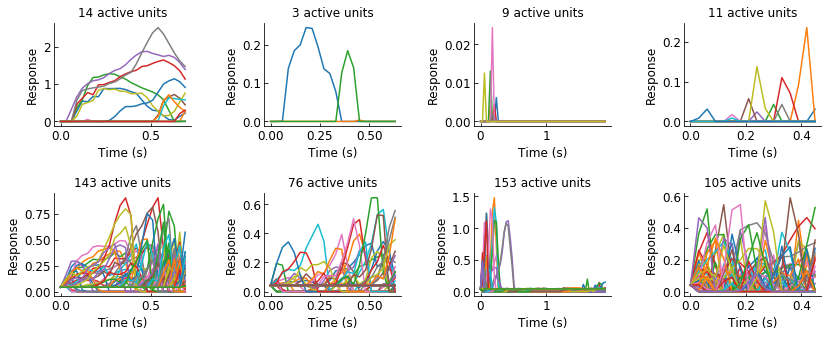

In [67]:
importlib.reload(hpfn)

label_fontsize = 12
title_fontsize = 12
tick_fontsize = 12

fig = plt.figure(figsize=(15, 6))
gs0 = gridspec.GridSpec(4, 10, figure=fig)

M = 256
filter_types = ['outward', 'inward']
sample_dt = 0.03

## outward
filter_type = filter_types[0]
save_file = figure_path+'sparse_and_dense/'+'results'+'_'+filter_type+'_M{}.npz'.format(M)
loaded_file = np.load(save_file, allow_pickle=True)
dist_min_n = loaded_file['arr_0']
res_T_all_n = loaded_file['arr_1']
res_rest_n = loaded_file['arr_2']
prob_mean_n = loaded_file['arr_3']

## inward
filter_type = filter_types[1]
save_file = figure_path+'sparse_and_dense/'+'results'+'_'+filter_type+'_M{}.npz'.format(M)
loaded_file = np.load(save_file, allow_pickle=True)
dist_min_r = loaded_file['arr_0']
res_T_all_r = loaded_file['arr_1']
res_rest_r = loaded_file['arr_2']
prob_mean_r = loaded_file['arr_3']

gs00 = gridspec.GridSpecFromSubplotSpec(12, 48, subplot_spec=gs0[0:2, :])

# hit
ax = fig.add_subplot(gs00[2:10, 2:10])
for nn in range(1, 2):
    res_T = np.array(res_T_all_n[0][nn])
    ind = 0
    for m in range(M):
        if res_T[:, m].max() > res_rest_n[0][0]:
            ax.plot(np.arange(len(res_T[:, m])) * sample_dt, res_T[:, m])
            ind = ind + 1
ax.set_title(f'{ind} active units', fontsize=title_fontsize)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(True)
ax.spines["left"].set_visible(True)  
ax.set_xlabel('Time (s)', fontsize=label_fontsize)
ax.set_ylabel('Response', fontsize=label_fontsize)
# ax.set_xscale('log')
# ax.set_ylim([0., 1.])
ax.tick_params(direction='in', labelsize=tick_fontsize)
ax.get_xaxis().set_tick_params(which='minor', size=0)
ax.get_xaxis().set_tick_params(which='minor', width=0) 
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

# miss
ax = fig.add_subplot(gs00[2:10, 14:22])
for nn in range(1, 2):
    res_T = np.array(res_T_all_n[1][nn])
    ind = 0
    for m in range(M):
        if res_T[:, m].max() > res_rest_n[0][0]:
            ax.plot(np.arange(len(res_T[:, m])) * sample_dt, res_T[:, m])
            ind = ind + 1
ax.set_title(f'{ind} active units', fontsize=title_fontsize)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(True)
ax.spines["left"].set_visible(True)  
ax.set_xlabel('Time (s)', fontsize=label_fontsize)
ax.set_ylabel('Response', fontsize=label_fontsize)
# ax.set_xscale('log')
# ax.set_ylim([0., 1.])
ax.tick_params(direction='in', labelsize=tick_fontsize)
ax.get_xaxis().set_tick_params(which='minor', size=0)
ax.get_xaxis().set_tick_params(which='minor', width=0) 
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

# retreat
ax = fig.add_subplot(gs00[2:10, 26:34])
for nn in range(1, 2):
    res_T = np.array(res_T_all_n[2][nn])
    ind = 0
    for m in range(M):
        if res_T[:, m].max() > res_rest_n[0][0]:
            ax.plot(np.arange(len(res_T[:, m])) * sample_dt, res_T[:, m])
            ind = ind + 1
ax.set_title(f'{ind} active units', fontsize=title_fontsize)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(True)
ax.spines["left"].set_visible(True)  
ax.set_xlabel('Time (s)', fontsize=label_fontsize)
ax.set_ylabel('Response', fontsize=label_fontsize)
# ax.set_xscale('log')
# ax.set_ylim([0., 1.])
ax.tick_params(direction='in', labelsize=tick_fontsize)
ax.get_xaxis().set_tick_params(which='minor', size=0)
ax.get_xaxis().set_tick_params(which='minor', width=0) 
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

# rotation
ax = fig.add_subplot(gs00[2:10, 38:46])
for nn in range(1, 2):
    res_T = np.array(res_T_all_n[3][nn])
    ind = 0
    for m in range(M):
        if res_T[:, m].max() > res_rest_n[0][0]:
            ax.plot(np.arange(len(res_T[:, m])) * sample_dt, res_T[:, m])
            ind = ind + 1
ax.set_title(f'{ind} active units', fontsize=title_fontsize)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(True)
ax.spines["left"].set_visible(True)  
ax.set_xlabel('Time (s)', fontsize=label_fontsize)
ax.set_ylabel('Response', fontsize=label_fontsize)
# ax.set_xscale('log')
# ax.set_ylim([0., 1.])
ax.tick_params(direction='in', labelsize=tick_fontsize)
ax.get_xaxis().set_tick_params(which='minor', size=0)
ax.get_xaxis().set_tick_params(which='minor', width=0) 
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

gs00 = gridspec.GridSpecFromSubplotSpec(12, 48, subplot_spec=gs0[2:4, :])

# hit
ax = fig.add_subplot(gs00[2:10, 2:10])
for nn in range(1, 2):
    res_T = np.array(res_T_all_r[0][nn])
    ind = 0
    for m in range(M):
        if res_T[:, m].max() > res_rest_r[0][0]:
            ax.plot(np.arange(len(res_T[:, m])) * sample_dt, res_T[:, m])
            ind = ind + 1
ax.set_title(f'{ind} active units', fontsize=title_fontsize)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(True)
ax.spines["left"].set_visible(True)  
ax.set_xlabel('Time (s)', fontsize=label_fontsize)
ax.set_ylabel('Response', fontsize=label_fontsize)
# ax.set_xscale('log')
# ax.set_ylim([0., 1.])
ax.tick_params(direction='in', labelsize=tick_fontsize)
ax.get_xaxis().set_tick_params(which='minor', size=0)
ax.get_xaxis().set_tick_params(which='minor', width=0) 
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

# miss
ax = fig.add_subplot(gs00[2:10, 14:22])
for nn in range(1, 2):
    res_T = np.array(res_T_all_r[1][nn])
    ind = 0
    for m in range(M):
        if res_T[:, m].max() > res_rest_r[0][0]:
            ax.plot(np.arange(len(res_T[:, m])) * sample_dt, res_T[:, m])
            ind = ind + 1
ax.set_title(f'{ind} active units', fontsize=title_fontsize)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(True)
ax.spines["left"].set_visible(True)  
ax.set_xlabel('Time (s)', fontsize=label_fontsize)
ax.set_ylabel('Response', fontsize=label_fontsize)
# ax.set_xscale('log')
# ax.set_ylim([0., 1.])
ax.tick_params(direction='in', labelsize=tick_fontsize)
ax.get_xaxis().set_tick_params(which='minor', size=0)
ax.get_xaxis().set_tick_params(which='minor', width=0) 
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

# retreat
ax = fig.add_subplot(gs00[2:10, 26:34])
for nn in range(1, 2):
    res_T = np.array(res_T_all_r[2][nn])
    ind = 0
    for m in range(M):
        if res_T[:, m].max() > res_rest_r[0][0]:
            ax.plot(np.arange(len(res_T[:, m])) * sample_dt, res_T[:, m])
            ind = ind + 1
ax.set_title(f'{ind} active units', fontsize=title_fontsize)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(True)
ax.spines["left"].set_visible(True)  
ax.set_xlabel('Time (s)', fontsize=label_fontsize)
ax.set_ylabel('Response', fontsize=label_fontsize)
# ax.set_xscale('log')
# ax.set_ylim([0., 1.])
ax.tick_params(direction='in', labelsize=tick_fontsize)
ax.get_xaxis().set_tick_params(which='minor', size=0)
ax.get_xaxis().set_tick_params(which='minor', width=0) 
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

# rotation
ax = fig.add_subplot(gs00[2:10, 38:46])
for nn in range(1, 2):
    res_T = np.array(res_T_all_r[3][nn])
    ind = 0
    for m in range(M):
        if res_T[:, m].max() > res_rest_r[0][0]:
            ax.plot(np.arange(len(res_T[:, m])) * sample_dt, res_T[:, m])
            ind = ind + 1
ax.set_title(f'{ind} active units', fontsize=title_fontsize)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(True)
ax.spines["left"].set_visible(True)  
ax.set_xlabel('Time (s)', fontsize=label_fontsize)
ax.set_ylabel('Response', fontsize=label_fontsize)
# ax.set_xscale('log')
# ax.set_ylim([0., 1.])
ax.tick_params(direction='in', labelsize=tick_fontsize)
ax.get_xaxis().set_tick_params(which='minor', size=0)
ax.get_xaxis().set_tick_params(which='minor', width=0) 
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

plt.show()
filename = figure_path+'figures_supp/compare_outward_inward_multiple_units_sup2.pdf'.format(M)
fig.savefig(filename, bbox_inches='tight')

# Larger M, better performance, more outward

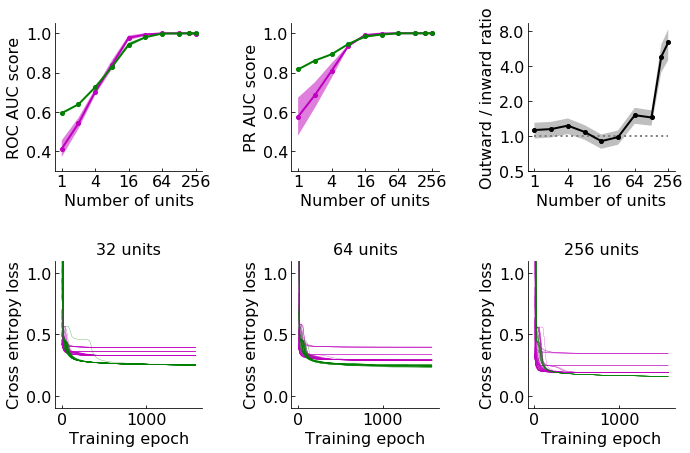

outward:  [44. 46. 48. 50. 48. 50. 53. 55. 58. 64.]
inward:  [39. 40. 39. 46. 53. 51. 35. 38. 12. 10.]


In [50]:
fig = plt.figure(figsize=(12, 8))
gs0 = gridspec.GridSpec(2, 3, figure=fig)

## Larger M, better performance
font_size0 = 16
data_path = figure_path+'model_clustering/'
Ms = [1, 2, 4, 8, 16, 32, 64, 128, 192, 256]
auc_vs_M_outward_roc = np.zeros((len(Ms), 2))
auc_vs_M_inward_roc = np.zeros((len(Ms), 2))
auc_vs_M_outward_pr = np.zeros((len(Ms), 2))
auc_vs_M_inward_pr = np.zeros((len(Ms), 2))
for ind, M in enumerate(Ms):
    filename = data_path+'auc_scores/auc_scores_outward_M{}.npy'.format(M)
    auc_scores_outward = np.load(filename)
    filename = data_path+'auc_scores/auc_scores_inward_M{}.npy'.format(M)
    auc_scores_inward = np.load(filename)
    auc_vs_M_outward_roc[ind, 0] = auc_scores_outward[:, 0].mean()
    auc_vs_M_outward_roc[ind, 1] = auc_scores_outward[:, 0].std()
    auc_vs_M_outward_pr[ind, 0] = auc_scores_outward[:, 1].mean()
    auc_vs_M_outward_pr[ind, 1] = auc_scores_outward[:, 1].std()
    auc_vs_M_inward_roc[ind, 0] = auc_scores_inward[:, 0].mean()
    auc_vs_M_inward_roc[ind, 1] = auc_scores_inward[:, 0].std()
    auc_vs_M_inward_pr[ind, 0] = auc_scores_inward[:, 1].mean()
    auc_vs_M_inward_pr[ind, 1] = auc_scores_inward[:, 1].std()

# ROC AUC
gs00 = gridspec.GridSpecFromSubplotSpec(16, 16, subplot_spec=gs0[0, 0])
ax = fig.add_subplot(gs00[2:14, 2:14])
ax.plot(Ms, auc_vs_M_outward_roc[:, 0], color='m', marker='o', markersize=4, linestyle='-', linewidth=2)
upper_curve = auc_vs_M_outward_roc[:, 0]+auc_vs_M_outward_roc[:, 1]
lower_curve = auc_vs_M_outward_roc[:, 0]-auc_vs_M_outward_roc[:, 1]
ax.fill_between(Ms, lower_curve, upper_curve, facecolor='m', edgecolor=None, alpha=0.5)
ax.plot(Ms, auc_vs_M_inward_roc[:, 0], color='g', marker='o', markersize=4, linestyle='-', linewidth=2)
upper_curve = auc_vs_M_inward_roc[:, 0]+auc_vs_M_inward_roc[:, 1]
lower_curve = auc_vs_M_inward_roc[:, 0]-auc_vs_M_inward_roc[:, 1]
ax.fill_between(Ms, lower_curve, upper_curve, facecolor='g', edgecolor=None, alpha=0.5)
# ax.legend(['outward', 'inward'], loc='lower right')
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(True)
ax.spines["left"].set_visible(True)  
ax.set_xlabel('Number of units', fontsize=font_size0)
ax.set_ylabel('ROC AUC score', fontsize=font_size0)
ax.set_ylim([0.3, 1.05])
ax.set_xscale('log')
ax.set_xticks([1, 4, 16, 64, 256])
ax.tick_params(direction='in', labelsize=font_size0)
ax.get_xaxis().set_tick_params(which='minor', size=0)
ax.get_xaxis().set_tick_params(which='minor', width=0) 
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

# PR AUC
gs00 = gridspec.GridSpecFromSubplotSpec(16, 16, subplot_spec=gs0[0, 1])
ax = fig.add_subplot(gs00[2:14, 2:14])
ax.plot(Ms, auc_vs_M_outward_pr[:, 0], color='m', marker='o', markersize=4, linestyle='-', linewidth=2)
upper_curve = auc_vs_M_outward_pr[:, 0]+auc_vs_M_outward_pr[:, 1]
lower_curve = auc_vs_M_outward_pr[:, 0]-auc_vs_M_outward_pr[:, 1]
ax.fill_between(Ms, lower_curve, upper_curve, facecolor='m', edgecolor=None, alpha=0.5)
ax.plot(Ms, auc_vs_M_inward_pr[:, 0], color='g', marker='o', markersize=4, linestyle='-', linewidth=2)
upper_curve = auc_vs_M_inward_pr[:, 0]+auc_vs_M_inward_pr[:, 1]
lower_curve = auc_vs_M_inward_pr[:, 0]-auc_vs_M_inward_pr[:, 1]
ax.fill_between(Ms, lower_curve, upper_curve, facecolor='g', edgecolor=None, alpha=0.5)
# ax.legend(['outward', 'inward'], loc='lower right')
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(True)
ax.spines["left"].set_visible(True)  
ax.set_xlabel('Number of units', fontsize=font_size0)
ax.set_ylabel('PR AUC score', fontsize=font_size0)
ax.set_ylim([0.3, 1.05])
ax.set_xscale('log')
ax.set_xticks([1, 4, 16, 64, 256])
ax.set_xticklabels(['1', '10', '100'])
ax.tick_params(direction='in', labelsize=font_size0)
ax.get_xaxis().set_tick_params(which='minor', size=0)
ax.get_xaxis().set_tick_params(which='minor', width=0) 
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())


## larger M, more outward
data_path = figure_path+'model_clustering/'
Ms = [1, 2, 4, 8, 16, 32, 64, 128, 192, 256]
cluster_ratio = np.zeros((len(Ms), 3))
for ind, M in enumerate(Ms):
    filename = data_path+'clusterings/cluster_size_M{}.npy'.format(M)
    cluster_size = np.load(filename, allow_pickle=True)
    cluster_ratio[ind, 0] = cluster_size[2]
    cluster_ratio[ind, 1] = cluster_size[3]
    cluster_ratio[ind, 2] = cluster_size[2]/cluster_size[3]
Mn = cluster_ratio.shape[0]
ratio_errors = np.zeros(Mn)
for ii in range(Mn):
    n_sample1 = cluster_ratio[ii, 0]
    n_sample2 = cluster_ratio[ii, 1]
    error = hpfn.get_error_binomial(n_sample1, n_sample2)
    ratio_error = hpfn.get_propagated_error(error, n_sample1, n_sample2)
    ratio_errors[ii]= ratio_error

gs00 = gridspec.GridSpecFromSubplotSpec(16, 16, subplot_spec=gs0[0, 2])
ax = fig.add_subplot(gs00[2:14, 2:14])
ax.plot([1, 256], [1, 1], color=[0.5, 0.5, 0.5], linestyle=':', linewidth=2)
ax.plot(Ms, cluster_ratio[:, 2], color='k', marker='o', markersize=4, linestyle='-', linewidth=2)
upper_curve = cluster_ratio[:, 2]+ratio_errors
lower_curve = cluster_ratio[:, 2]-ratio_errors
ax.fill_between(Ms, lower_curve, upper_curve, facecolor=[0.5, 0.5, 0.5], edgecolor=None, alpha=0.5)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(True)
ax.spines["left"].set_visible(True)  
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xticks([1, 4, 16, 64, 256])
ax.set_yticks((0.5, 1, 2, 4, 8))
ax.set_yticklabels(('0.5', '1.', '2.', '4.', '8'))
ax.set_xlabel('Number of units', fontsize=font_size0)
ax.set_ylabel('Outward / inward ratio', fontsize=font_size0)
ax.tick_params(direction='in', labelsize=font_size0)
ax.get_xaxis().set_tick_params(which='minor', size=0)
ax.get_xaxis().set_tick_params(which='minor', width=0) 
ax.get_yaxis().set_tick_params(which='minor', size=0)
ax.get_yaxis().set_tick_params(which='minor', width=0) 
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())


## loss 
for ind, M in enumerate([32, 64, 256]):
    plotted = []
    gs00 = gridspec.GridSpecFromSubplotSpec(16, 16, subplot_spec=gs0[1, ind])
    ax = fig.add_subplot(gs00[2:14, 2:14])
    data_path = figure_path+'model_clustering/clusterings/'
    model_folders = np.load(data_path+'model_folders_M{}.npy'.format(M), allow_pickle=True)
    nn = len(model_folders[0])
    for n in range(nn):
        if n%1 == 0:
            model_path = model_folders[0][n]+'/'
            loss_function = np.load(model_path+'train_loss_output.npy')
            loss_function_averaged = loss_function.reshape(-1, 80).mean(axis=1)
            loss_function_averaged = loss_function_averaged.reshape(-1, 20).mean(axis=1)
            p1 = ax.plot(loss_function_averaged, c='m', linewidth=0.25)
        if n == 0:
            plotted.append(p1)
    nn = len(model_folders[1])
    for n in range(nn):
        if n%1 == 0:
            model_path = model_folders[1][n]+'/'
            loss_function = np.load(model_path+'train_loss_output.npy')
            loss_function_averaged = loss_function.reshape(-1, 80).mean(axis=1)
            loss_function_averaged = loss_function_averaged.reshape(-1, 20).mean(axis=1)
            p2 = ax.plot(loss_function_averaged, c='g', linewidth=0.25)
        if n == 0:
            plotted.append(p2)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(True)
    ax.spines["left"].set_visible(True)        
    ax.set_xlabel('Training epoch', fontsize=font_size0)
    ax.set_ylabel('Cross entropy loss', fontsize=font_size0)
    ax.set_ylim([-0.1, 1.1])
    ax.set_xticks([0, 50])
    ax.set_xticklabels([0, 1000])
    ax.tick_params(direction='in', labelsize=font_size0)
    ax.set_title('{} units'.format(M), fontsize=font_size0)

plt.show()

if not os.path.exists(figure_path+'figures_main'):
    os.makedirs(figure_path+'figures_main')
filename = figure_path+'figures_main/outward_better_than_inward.pdf'.format(M)
fig.savefig(filename, bbox_inches='tight')
# fig.savefig(filename)

print('outward: ', cluster_ratio[:, 0])
print('inward: ', cluster_ratio[:, 1])

# Replication of experiments

In [51]:
has_inhibition = True
if not os.path.exists(figure_path+'klap_replication/'):
    os.mkdir(figure_path+'klap_replication/')
print(figure_path)

/Volumes/Baohua/research/loom_detection/results/final_figures_for_paper_exp/


/Volumes/Baohua/research_large_files/multi_lplc2_training_D5_exp/M_256/lr_0.001/regu_0.0001/seed_156_20210626093605/
Max excitatory response of the looming disk is 0.6661198891804874.
Max inhibitory response of the looming disk is 1.158398151397705.
Max excitatory-inhibitory response of the looming disk is -0.2706883989168942.
2F, total length in time is 5.99 s
3e, total length in time is 5.23 s
3f, total length in time is 5.23 s
4A, total length in time is 5.99 s
4C, total length in time is 5.23 s
4E, total length in time is 4.98 s
4G, total length in time is 5.23 s


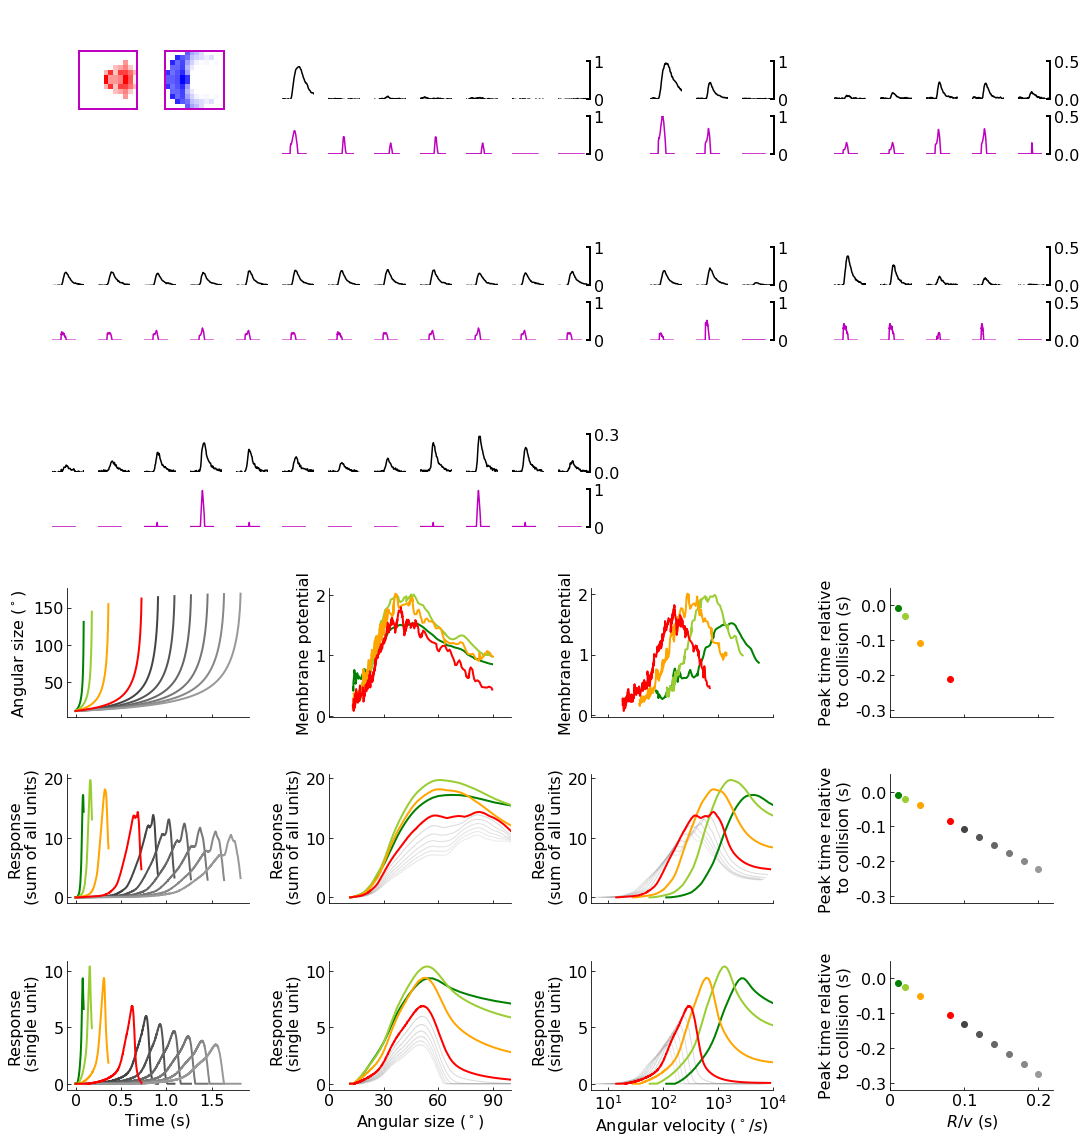

In [82]:
# For inhibitory filter without the bulb at the right side
# We are plotting res_T_all[n]

%matplotlib inline

M = 256
R = 1

figuretypes1 = ['2F', '3e', '3f', '4A', '4C', '4E', '4G']
figuretypes2 = \
[['2Fa', '2Fb', '2Fc', '2Fd', '2Fe', '2Ff', '2Fg'], \
 ['3e1', '3e2', '3e3', '3e4', '3e5', '3e6', '3e7', '3e8', '3e9', '3e10', '3e11', '3e12'], \
 ['3f1', '3f2', '3f3', '3f4', '3f5', '3f6', '3f7', '3f8', '3f9', '3f10', '3f11', '3f12'], \
 ['4Aa', '4Ab', '4Ac'], \
 ['4Ca', '4Cb', '4Cc', '4Cd', '4Ce'], \
 ['4Ea', '4Eb', '4Ec'], \
 ['4Ga', '4Gb', '4Gc', '4Gd', '4Ge']]

ymin = -0.1
ymax_dict = {}
ymax_dict['2F_1'] = 1
ymax_dict['2F_2'] = 1
ymax_dict['3e_1'] = 1
ymax_dict['3e_2'] = 1
ymax_dict['3f_1'] = 0.3
ymax_dict['3f_2'] = 1
ymax_dict['4A_1'] = 1
ymax_dict['4A_2'] = 1
ymax_dict['4C_1'] = 0.5
ymax_dict['4C_2'] = 0.5
ymax_dict['4E_1'] = 1
ymax_dict['4E_2'] = 1
ymax_dict['4G_1'] = 0.5
ymax_dict['4G_2'] = 0.5

line_width = 0.5
label_fontsize = 16
title_fontsize = 16
tick_fontsize = 16

fig = plt.figure(figsize=(18, 20))
gs0 = gridspec.GridSpec(6, 22, figure=fig)

# weights, trained
gs00 = gridspec.GridSpecFromSubplotSpec(13, 13, subplot_spec=gs0[0, 0:5])
axe = fig.add_subplot(gs00[4:9, 1:6])
# model
saved_results_path = figure_path+'model_clustering/clusterings/'
model_folders = np.load(saved_results_path+'model_folders_M{}.npy'.format(M), allow_pickle=True)
model_path = model_folders[0][17]+'/' # 17 for M = 256; 5 for M = 192
print(model_path)
K = 12
mask_d = opsg.get_disk_mask(12, 4)
if has_inhibition:
    colormap_e = LinearSegmentedColormap.from_list('wr', ['w', 'r'], N=256)
else:
    colormap_e = LinearSegmentedColormap.from_list('bwr', ['b', 'w', 'r'], N=256)
colormap_i = LinearSegmentedColormap.from_list('wb', ['w', 'b'], N=256)
trained_weights_e = np.load(model_path+'trained_weights_e.npy')
trained_weights_e = trained_weights_e[:, 0].reshape((K, K))
trained_weights_e[mask_d] = 0.
extreme_e = np.round(np.amax(np.abs(trained_weights_e)), 1)
if has_inhibition:
    color_norm_e = mpl.colors.Normalize(vmin=0, vmax=extreme_e)
else:
    color_norm_e = mpl.colors.Normalize(vmin=-extreme_e, vmax=extreme_e)
ime = axe.imshow(trained_weights_e, norm=color_norm_e, cmap=colormap_e)
axe.set_xticks([])
axe.set_yticks([])
plt.setp(axe.spines.values(), color='m', linewidth=2)

if has_inhibition:
    axi = fig.add_subplot(gs00[4:9, 6:11])
    trained_weights_i = np.load(model_path+'trained_weights_i.npy')
    trained_weights_i = trained_weights_i[:, 0].reshape((K, K))
    trained_weights_i[mask_d] = 0.
    extreme_i = np.round(np.amax(np.abs(trained_weights_i)), 1)
    color_norm_i = mpl.colors.Normalize(vmin=0, vmax=extreme_i)
    imi = axi.imshow(trained_weights_i, norm=color_norm_i, cmap=colormap_i)
    axi.set_xticks([])
    axi.set_yticks([])
    plt.setp(axi.spines.values(), color='m', linewidth=2)
    

# 2F
figuretype = figuretypes1[0]
filename = figure_path+'klap_replication/'+figuretype+'_M{}_2.npz'.format(M)
loaded_file = np.load(filename, allow_pickle=True)
res_rest_all = loaded_file['arr_0']
res_T_all = loaded_file['arr_1']
Ie_T_all = loaded_file['arr_2']
Ii_T_all = loaded_file['arr_3']
Ii_T2_all = loaded_file['arr_4']
N = len(res_T_all)
res_max_2Fa = np.max(res_T_all[0])
res_max_2Fa2 = np.max(Ie_T_all[0]-Ii_T_all[0])
print(f'Max excitatory response of the looming disk is {np.max(Ie_T_all[0])}.')
print(f'Max inhibitory response of the looming disk is {np.max(Ii_T_all[0])}.')
print(f'Max excitatory-inhibitory response of the looming disk is {np.max(Ie_T_all[0]-Ii_T_all[0])}.')

gs00 = gridspec.GridSpecFromSubplotSpec(3, 7, subplot_spec=gs0[0, 5:12])
for n in range(N):
    # add the stimuli
    gs000 = gridspec.GridSpecFromSubplotSpec(12, 12, subplot_spec=gs00[0, n])
    ax = fig.add_subplot(gs000[1:11, 1:11])
    ax.set_axis_off()
    
    # load the data
    filepath = figure_path + 'klap_replication/Klapoetke_data/For_loom_paper/klap_'+figuretypes2[0][n]+'.mat'
    klap_2F = loadmat(filepath)
    klap_2F = klap_2F['klap_2F']
    klap_t = klap_2F[0, 0, :]
    klap_res = klap_2F[:, 1, :].mean(axis=0)
    
    gs000 = gridspec.GridSpecFromSubplotSpec(12, 12, subplot_spec=gs00[1, n])
    ax = fig.add_subplot(gs000[1:11, 1:11])
    T = len(res_T_all[n])
    if n == 0:
        print(f'2F, total length in time is {(T-1)*0.01} s')
    T_vec = np.linspace(0, (T-1)*0.01, T)
    ax.plot(klap_t, klap_res, c='k')
    ax.set_xlim([0, T_vec[-1]+2])
    ax.set_ylim([0, ymax_dict['2F_1']])
    if n != N-1:
        ax.set_axis_off()
    else:
        ax.spines["left"].set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.spines["bottom"].set_linewidth(False)
        ax.spines["right"].set_linewidth(2)
        ax.set_xticks([])
        ax.set_yticks([0, ymax_dict['2F_1']])
        ax.yaxis.tick_right()
        ax.tick_params(direction='in', length=4, width=2, labelsize=tick_fontsize)
    
    gs000 = gridspec.GridSpecFromSubplotSpec(12, 12, subplot_spec=gs00[2, n])
    ax = fig.add_subplot(gs000[1:11, 1:11])
    ax.plot(T_vec, res_T_all[n], 'm')
    ax.set_xlim([0, T_vec[-1]+2])
    ax.set_ylim([0, ymax_dict['2F_2']])
    if n != N-1:
        ax.set_axis_off()
    else:
        ax.spines["left"].set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.spines["bottom"].set_linewidth(False)
        ax.spines["right"].set_linewidth(2)
        ax.set_xticks([])
        ax.set_yticks([0, ymax_dict['2F_2']])
        ax.yaxis.tick_right()
        ax.tick_params(direction='in', length=4, width=2, labelsize=tick_fontsize)
        
    
# 3e
figuretype = figuretypes1[1]
filename = figure_path+'klap_replication/'+figuretype+'_M{}_2.npz'.format(M)
loaded_file = np.load(filename, allow_pickle=True)
res_rest_all = loaded_file['arr_0']
res_T_all = loaded_file['arr_1']
Ie_T_all = loaded_file['arr_2']
Ii_T_all = loaded_file['arr_3']
Ii_T2_all = loaded_file['arr_4']
N = len(res_T_all)

gs00 = gridspec.GridSpecFromSubplotSpec(3, 12, subplot_spec=gs0[1, :12])
for n in range(N):
    # add the stimuli
    gs000 = gridspec.GridSpecFromSubplotSpec(12, 12, subplot_spec=gs00[0, n])
    ax = fig.add_subplot(gs000[1:11, 1:11])
    ax.set_axis_off()
    
    # load the data
    filepath = figure_path + 'klap_replication/Klapoetke_data/For_loom_paper/klap_'+figuretypes2[1][n]+'.mat'
    klap_3e = loadmat(filepath)
    klap_3e = klap_3e['klap_3e']
    klap_t = klap_3e[0, 0, :]
    klap_res = klap_3e[:, 1, :].mean(axis=0)
    
    gs000 = gridspec.GridSpecFromSubplotSpec(12, 12, subplot_spec=gs00[1, n])
    ax = fig.add_subplot(gs000[1:11, 1:11])
    T = len(res_T_all[n])
    if n == 0:
        print(f'3e, total length in time is {(T-1)*0.01} s')
    T_vec = np.linspace(0, (T-1)*0.01, T)
    ax.plot(klap_t, klap_res, c='k')    
    ax.set_xlim([0, T_vec[-1]+2])
    ax.set_ylim([0, ymax_dict['3e_1']])
    if n != N-1:
        ax.set_axis_off()
    else:
        ax.spines["left"].set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.spines["bottom"].set_linewidth(False)
        ax.spines["right"].set_linewidth(2)
        ax.set_xticks([])
        ax.set_yticks([0, ymax_dict['3e_1']])
        ax.yaxis.tick_right()
        ax.tick_params(direction='in', length=4, width=2, labelsize=tick_fontsize)
    
    gs000 = gridspec.GridSpecFromSubplotSpec(12, 12, subplot_spec=gs00[2, n])
    ax = fig.add_subplot(gs000[1:11, 1:11])
    ax.plot(T_vec, res_T_all[n]/res_max_2Fa, 'm')
    ax.set_xlim([0, T_vec[-1]+2])
    ax.set_ylim([0, ymax_dict['3e_2']])
    if n != N-1:
        ax.set_axis_off()
    else:
        ax.spines["left"].set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.spines["bottom"].set_linewidth(False)
        ax.spines["right"].set_linewidth(2)
        ax.set_xticks([])
        ax.set_yticks([0, ymax_dict['3e_2']])
        ax.yaxis.tick_right()
        ax.tick_params(direction='in', length=4, width=2, labelsize=tick_fontsize)
    

# 3f
figuretype = figuretypes1[2]
filename = figure_path+'klap_replication/'+figuretype+'_M{}_2.npz'.format(M)
loaded_file = np.load(filename, allow_pickle=True)
res_rest_all = loaded_file['arr_0']
res_T_all = loaded_file['arr_1']
Ie_T_all = loaded_file['arr_2']
Ii_T_all = loaded_file['arr_3']
Ii_T2_all = loaded_file['arr_4']
N = len(res_T_all)

gs00 = gridspec.GridSpecFromSubplotSpec(3, 12, subplot_spec=gs0[2, :12])
for n in range(N):
    # add the stimuli
    gs000 = gridspec.GridSpecFromSubplotSpec(12, 12, subplot_spec=gs00[0, n])
    ax = fig.add_subplot(gs000[1:11, 1:11])
    ax.set_axis_off()
    
    # load the data
    filepath = figure_path + 'klap_replication/Klapoetke_data/For_loom_paper/klap_'+figuretypes2[2][n]+'.mat'
    klap_3f = loadmat(filepath)
    klap_3f = klap_3f['klap_3f']
    klap_t = klap_3f[0, 0, :]
    klap_res = klap_3f[:, 1, :].mean(axis=0)
    
    gs000 = gridspec.GridSpecFromSubplotSpec(12, 12, subplot_spec=gs00[1, n])
    ax = fig.add_subplot(gs000[1:11, 1:11])
    T = len(res_T_all[n])
    if n == 0:
        print(f'3f, total length in time is {(T-1)*0.01} s')
    T_vec = np.linspace(0, (T-1)*0.01, T)
    ax.plot(klap_t, klap_res, c='k')    
    ax.set_xlim([0, T_vec[-1]+2])
    ax.set_ylim([0, ymax_dict['3f_1']])
    if n != N-1:
        ax.set_axis_off()
    else:
        ax.spines["left"].set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.spines["bottom"].set_linewidth(False)
        ax.spines["right"].set_linewidth(2)
        ax.set_xticks([])
        ax.set_yticks([0, ymax_dict['3f_1']])
        ax.yaxis.tick_right()
        ax.tick_params(direction='in', length=4, width=2, labelsize=tick_fontsize)
    
    gs000 = gridspec.GridSpecFromSubplotSpec(12, 12, subplot_spec=gs00[2, n])
    ax = fig.add_subplot(gs000[1:11, 1:11])
    ax.plot(T_vec, res_T_all[n]/res_max_2Fa, 'm')
    ax.set_xlim([0, T_vec[-1]+2])
    ax.set_ylim([0, ymax_dict['3f_2']])
    if n != N-1:
        ax.set_axis_off()
    else:
        ax.spines["left"].set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.spines["bottom"].set_linewidth(False)
        ax.spines["right"].set_linewidth(2)
        ax.set_xticks([])
        ax.set_yticks([0, ymax_dict['3f_2']])
        ax.yaxis.tick_right()
        ax.tick_params(direction='in', length=4, width=2, labelsize=tick_fontsize)
    
    
# 4A
gs00 = gridspec.GridSpecFromSubplotSpec(3, 3, subplot_spec=gs0[0, 13:16])

figuretype = figuretypes1[3]
filename = figure_path+'klap_replication/'+figuretype+'_M{}_2.npz'.format(M)
loaded_file = np.load(filename, allow_pickle=True)
res_rest_all = loaded_file['arr_0']
res_T_all = loaded_file['arr_1']
Ie_T_all = loaded_file['arr_2']
Ii_T_all = loaded_file['arr_3']
Ii_T2_all = loaded_file['arr_4']
N = len(res_T_all)

for n in range(N):
    # add the stimuli
    gs000 = gridspec.GridSpecFromSubplotSpec(12, 12, subplot_spec=gs00[0, n])
    ax = fig.add_subplot(gs000[1:11, 1:11])
    ax.set_axis_off()
    
    # load the data
    filepath = figure_path + 'klap_replication/Klapoetke_data/For_loom_paper/klap_'+figuretypes2[3][n]+'.mat'
    klap_4A = loadmat(filepath)
    klap_4A = klap_4A['klap_4A']
    klap_t = klap_4A[0, 0, :]
    klap_res = klap_4A[:, 1, :].mean(axis=0)
    
    gs000 = gridspec.GridSpecFromSubplotSpec(12, 12, subplot_spec=gs00[1, n])
    ax = fig.add_subplot(gs000[1:11, 1:11])
    T = len(res_T_all[n])
    if n == 0:
        print(f'4A, total length in time is {(T-1)*0.01} s')
    T_vec = np.linspace(0, (T-1)*0.01, T)
    ax.plot(klap_t, klap_res, c='k')    
    ax.set_xlim([0, T_vec[-1]+2])
    ax.set_ylim([0, ymax_dict['4A_1']])
    if n != N-1:
        ax.set_axis_off()
    else:
        ax.spines["left"].set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.spines["bottom"].set_linewidth(False)
        ax.spines["right"].set_linewidth(2)
        ax.set_xticks([])
        ax.set_yticks([0, ymax_dict['4A_1']])
        ax.yaxis.tick_right()
        ax.tick_params(direction='in', length=4, width=2, labelsize=tick_fontsize)
    
    gs000 = gridspec.GridSpecFromSubplotSpec(12, 12, subplot_spec=gs00[2, n])
    ax = fig.add_subplot(gs000[1:11, 1:11])
    ax.plot(T_vec, res_T_all[n]/res_max_2Fa, 'm')
    ax.set_xlim([0, T_vec[-1]+2])
    ax.set_ylim([0, ymax_dict['4A_2']])
    if n != N-1:
        ax.set_axis_off()
    else:
        ax.spines["left"].set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.spines["bottom"].set_linewidth(False)
        ax.spines["right"].set_linewidth(2)
        ax.set_xticks([])
        ax.set_yticks([0, ymax_dict['4A_2']])
        ax.yaxis.tick_right()
        ax.tick_params(direction='in', length=4, width=2, labelsize=tick_fontsize)

# 4C
gs00 = gridspec.GridSpecFromSubplotSpec(3, 5, subplot_spec=gs0[0, 17:22])
    
figuretype = figuretypes1[4]
filename = figure_path+'klap_replication/'+figuretype+'_M{}_2.npz'.format(M)
loaded_file = np.load(filename, allow_pickle=True)
res_rest_all = loaded_file['arr_0']
res_T_all = loaded_file['arr_1']
Ie_T_all = loaded_file['arr_2']
Ii_T_all = loaded_file['arr_3']
Ii_T2_all = loaded_file['arr_4']
N = len(res_T_all)

for n in range(N):
    # add the stimuli
    gs000 = gridspec.GridSpecFromSubplotSpec(12, 12, subplot_spec=gs00[0, n])
    ax = fig.add_subplot(gs000[1:11, 1:11])
    ax.set_axis_off()
    
    # load the data
    filepath = figure_path + 'klap_replication/Klapoetke_data/For_loom_paper/klap_'+figuretypes2[4][n]+'.mat'
    klap_4C = loadmat(filepath)
    klap_4C = klap_4C['klap_4C']
    klap_t = klap_4C[0, 0, :]
    klap_res = klap_4C[:, 1, :].mean(axis=0)
    
    gs000 = gridspec.GridSpecFromSubplotSpec(12, 12, subplot_spec=gs00[1, n])
    ax = fig.add_subplot(gs000[1:11, 1:11])
    T = len(res_T_all[n])
    if n == 0:
        print(f'4C, total length in time is {(T-1)*0.01} s')
    T_vec = np.linspace(0, (T-1)*0.01, T)
    ax.plot(klap_t, klap_res, c='k')    
    ax.set_xlim([0, T_vec[-1]+2])
    ax.set_ylim([0, ymax_dict['4C_1']])
    if n != N-1:
        ax.set_axis_off()
    else:
        ax.spines["left"].set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.spines["bottom"].set_linewidth(False)
        ax.spines["right"].set_linewidth(2)
        ax.set_xticks([])
        ax.set_yticks([0, ymax_dict['4C_1']])
        ax.yaxis.tick_right()
        ax.tick_params(direction='in', length=4, width=2, labelsize=tick_fontsize)
    
    gs000 = gridspec.GridSpecFromSubplotSpec(12, 12, subplot_spec=gs00[2, n])
    ax = fig.add_subplot(gs000[1:11, 1:11])
    ax.plot(T_vec, res_T_all[n]/res_max_2Fa, 'm')
    ax.set_xlim([0, T_vec[-1]+2])
    ax.set_ylim([0, ymax_dict['4C_2']])
    if n != N-1:
        ax.set_axis_off()
    else:
        ax.spines["left"].set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.spines["bottom"].set_linewidth(False)
        ax.spines["right"].set_linewidth(2)
        ax.set_xticks([])
        ax.set_yticks([0, ymax_dict['4C_2']])
        ax.yaxis.tick_right()
        ax.tick_params(direction='in', length=4, width=2, labelsize=tick_fontsize)
    
    
# 4E
gs00 = gridspec.GridSpecFromSubplotSpec(3, 3, subplot_spec=gs0[1, 13:16])

figuretype = figuretypes1[5]
filename = figure_path+'klap_replication/'+figuretype+'_M{}_2.npz'.format(M)
loaded_file = np.load(filename, allow_pickle=True)
res_rest_all = loaded_file['arr_0']
res_T_all = loaded_file['arr_1']
Ie_T_all = loaded_file['arr_2']
Ii_T_all = loaded_file['arr_3']
Ii_T2_all = loaded_file['arr_4']
N = len(res_T_all)

for n in range(N):
    # add the stimuli
    gs000 = gridspec.GridSpecFromSubplotSpec(12, 12, subplot_spec=gs00[0, n])
    ax = fig.add_subplot(gs000[1:11, 1:11])
    ax.set_axis_off()
    
    # load the data
    filepath = figure_path + 'klap_replication/Klapoetke_data/For_loom_paper/klap_'+figuretypes2[5][n]+'.mat'
    klap_4E = loadmat(filepath)
    klap_4E = klap_4E['klap_4E']
    klap_t = klap_4E[0, 0, :]
    klap_res = klap_4E[:, 1, :].mean(axis=0)
    
    gs000 = gridspec.GridSpecFromSubplotSpec(12, 12, subplot_spec=gs00[1, n])
    ax = fig.add_subplot(gs000[1:11, 1:11])
    T = len(res_T_all[n])
    if n == 0:
        print(f'4E, total length in time is {(T-1)*0.01} s')
    T_vec = np.linspace(0, (T-1)*0.01, T)
    ax.plot(klap_t, klap_res, c='k')    
    ax.set_xlim([0, T_vec[-1]+2])
    ax.set_ylim([0, ymax_dict['4E_1']])
    if n != N-1:
        ax.set_axis_off()
    else:
        ax.spines["left"].set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.spines["bottom"].set_linewidth(False)
        ax.spines["right"].set_linewidth(2)
        ax.set_xticks([])
        ax.set_yticks([0, ymax_dict['4E_1']])
        ax.yaxis.tick_right()
        ax.tick_params(direction='in', length=4, width=2, labelsize=tick_fontsize)
    
    gs000 = gridspec.GridSpecFromSubplotSpec(12, 12, subplot_spec=gs00[2, n])
    ax = fig.add_subplot(gs000[1:11, 1:11])
    ax.plot(T_vec, res_T_all[n]/res_max_2Fa, 'm')
    ax.set_xlim([0, T_vec[-1]+2])
    ax.set_ylim([0, ymax_dict['4E_2']])
    if n != N-1:
        ax.set_axis_off()
    else:
        ax.spines["left"].set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.spines["bottom"].set_linewidth(False)
        ax.spines["right"].set_linewidth(2)
        ax.set_xticks([])
        ax.set_yticks([0, ymax_dict['4E_2']])
        ax.yaxis.tick_right()
        ax.tick_params(direction='in', length=4, width=2, labelsize=tick_fontsize)
    
# 4G
gs00 = gridspec.GridSpecFromSubplotSpec(3, 5, subplot_spec=gs0[1, 17:22])
    
figuretype = figuretypes1[6]
filename = figure_path+'klap_replication/'+figuretype+'_M{}_2.npz'.format(M)
loaded_file = np.load(filename, allow_pickle=True)
res_rest_all = loaded_file['arr_0']
res_T_all = loaded_file['arr_1']
Ie_T_all = loaded_file['arr_2']
Ii_T_all = loaded_file['arr_3']
Ii_T2_all = loaded_file['arr_4']
N = len(res_T_all)

for n in range(N):
    # add the stimuli
    gs000 = gridspec.GridSpecFromSubplotSpec(12, 12, subplot_spec=gs00[0, n])
    ax = fig.add_subplot(gs000[1:11, 1:11])
    ax.set_axis_off()
    
    # load the data
    filepath = figure_path + 'klap_replication/Klapoetke_data/For_loom_paper/klap_'+figuretypes2[6][n]+'.mat'
    klap_4G = loadmat(filepath)
    klap_4G = klap_4G['klap_4G']
    klap_t = klap_4G[0, 0, :]
    klap_res = klap_4G[:, 1, :].mean(axis=0)
    
    gs000 = gridspec.GridSpecFromSubplotSpec(12, 12, subplot_spec=gs00[1, n])
    ax = fig.add_subplot(gs000[1:11, 1:11])
    T = len(res_T_all[n])
    if n == 0:
        print(f'4G, total length in time is {(T-1)*0.01} s')
    T_vec = np.linspace(0, (T-1)*0.01, T)
    ax.plot(klap_t, klap_res, c='k')    
    ax.set_xlim([0, T_vec[-1]+2])
    ax.set_ylim([0, ymax_dict['4G_1']])
    if n != N-1:
        ax.set_axis_off()
    else:
        ax.spines["left"].set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.spines["bottom"].set_linewidth(False)
        ax.spines["right"].set_linewidth(2)
        ax.set_xticks([])
        ax.set_yticks([0, ymax_dict['4G_1']])
        ax.yaxis.tick_right()
        ax.tick_params(direction='in', length=4, width=2, labelsize=tick_fontsize)
    
    gs000 = gridspec.GridSpecFromSubplotSpec(12, 12, subplot_spec=gs00[2, n])
    ax = fig.add_subplot(gs000[1:11, 1:11])
    ax.plot(T_vec, res_T_all[n]/res_max_2Fa, 'm')
    ax.set_xlim([0, T_vec[-1]+2])
    ax.set_ylim([0, ymax_dict['4G_2']])
    if n != N-1:
        ax.set_axis_off()
    else:
        ax.spines["left"].set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.spines["bottom"].set_linewidth(False)
        ax.spines["right"].set_linewidth(2)
        ax.set_xticks([])
        ax.set_yticks([0, ymax_dict['4G_2']])
        ax.yaxis.tick_right()
        ax.tick_params(direction='in', length=4, width=2, labelsize=tick_fontsize)
        
        
# linear law and angular size dependence

# data
file_path = figure_path + 'linear_law/linear_law.csv'
linear_law = np.genfromtxt(file_path, delimiter=',')
file_path = figure_path + 'linear_law/angular_size_r_over_v_10.csv'
angular_size_r_over_v_10 = np.genfromtxt(file_path, delimiter=',')
file_path = figure_path + 'linear_law/angular_size_r_over_v_20.csv'
angular_size_r_over_v_20 = np.genfromtxt(file_path, delimiter=',')
file_path = figure_path + 'linear_law/angular_size_r_over_v_40.csv'
angular_size_r_over_v_40 = np.genfromtxt(file_path, delimiter=',')
file_path = figure_path + 'linear_law/angular_size_r_over_v_80.csv'
angular_size_r_over_v_80 = np.genfromtxt(file_path, delimiter=',')
file_path = figure_path + 'linear_law/angular_velocity_r_over_v_10.csv'
angular_velocity_r_over_v_10 = np.genfromtxt(file_path, delimiter=',')
file_path = figure_path + 'linear_law/angular_velocity_r_over_v_20.csv'
angular_velocity_r_over_v_20 = np.genfromtxt(file_path, delimiter=',')
file_path = figure_path + 'linear_law/angular_velocity_r_over_v_40.csv'
angular_velocity_r_over_v_40 = np.genfromtxt(file_path, delimiter=',')
file_path = figure_path + 'linear_law/angular_velocity_r_over_v_80.csv'
angular_velocity_r_over_v_80 = np.genfromtxt(file_path, delimiter=',')


data_type = 'hit'
data_path = figure_path + 'linear_law/'+data_type+'/'
distance_T_all_M256 = np.load(data_path+f'distance_T_all_M{256}.npy', allow_pickle=True)
res_T_all_M256 = np.load(data_path+f'res_T_all_M{256}.npy', allow_pickle=True)
distance_T_all_M1 = np.load(data_path+f'distance_T_all_M{1}.npy', allow_pickle=True)
res_T_all_M1 = np.load(data_path+f'res_T_all_M{1}.npy', allow_pickle=True)
offset = 1 # 1 for exponential filter; 30 for delta filter


# R_over_v_list = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, \
#                  0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2]
R_over_v_list = [0.01, 0.02, 0.04, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2]

# green, yellow green, orange, red
color_list_data = [[0/255., 128/255., 0/255.], \
                   [154/255., 205/255., 50/255.], \
                   [255/255., 165/255., 0], \
                   [255/255., 0, 0]]
color_list = []
for ind, R_over_v in enumerate(R_over_v_list):
    if R_over_v == 0.01:
        color_list.append(color_list_data[0])
    elif R_over_v == 0.02:
        color_list.append(color_list_data[1])
    elif R_over_v == 0.04:
        color_list.append(color_list_data[2])
    elif R_over_v == 0.08:
        color_list.append(color_list_data[3])
    else:
        val = 1. / (len(R_over_v_list) + 5) * ind
        color_list.append([val, val, val])

line_width = 2
gs00 = gridspec.GridSpecFromSubplotSpec(3, 4, subplot_spec=gs0[3:, :])

# angular size against time, data
gs000 = gridspec.GridSpecFromSubplotSpec(12, 12, subplot_spec=gs00[0, 0])
ax = fig.add_subplot(gs000[2:12, 1:11])
for ii in range(len(R_over_v_list)):
    D = distance_T_all_M1[ii]
    theta_b = 2 * np.arcsin(R/D)*180/np.pi
    if R_over_v_list[ii] not in [0.01, 0.02, 0.04, 0.08]:
        ax.plot(theta_b[offset:], c=color_list[ii], linewidth=line_width, alpha=1)
for ii in range(len(R_over_v_list)):
    D = distance_T_all_M1[ii]
    theta_b = 2 * np.arcsin(R/D)*180/np.pi
    if R_over_v_list[ii] == 0.01:
        ax.plot(theta_b[offset:], c=color_list_data[0], linewidth=line_width)
    elif R_over_v_list[ii] == 0.02:
        ax.plot(theta_b[offset:], c=color_list_data[1], linewidth=line_width)
    elif R_over_v_list[ii] == 0.04:
        ax.plot(theta_b[offset:], c=color_list_data[2], linewidth=line_width)
    elif R_over_v_list[ii] == 0.08:
        ax.plot(theta_b[offset:], c=color_list_data[3], linewidth=line_width)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(True)
ax.spines["left"].set_visible(True) 
ax.set_xticks([0, 500, 1000, 1500])
ax.set_xticklabels([])
# ax.set_xlabel('Time (s)', fontsize=label_fontsize)
ax.set_ylabel(r'Angular size ($^\circ$)', fontsize=label_fontsize)
ax.tick_params(direction='in', labelsize=tick_fontsize)

# response against time, M = 256
gs000 = gridspec.GridSpecFromSubplotSpec(12, 12, subplot_spec=gs00[1, 0])
ax = fig.add_subplot(gs000[2:12, 1:11])
for ii in range(len(R_over_v_list)):
    D = distance_T_all_M256[ii]
    theta_b = np.arcsin(R/D)*180/np.pi
    if R_over_v_list[ii] not in [0.01, 0.02, 0.04, 0.08]:
        ax.plot(res_T_all_M256[ii], c=color_list[ii], linewidth=line_width, alpha=1)
for ii in range(len(R_over_v_list)):
    D = distance_T_all_M256[ii]
    theta_b = np.arcsin(R/D)*180/np.pi
    if R_over_v_list[ii] == 0.01:
        ax.plot(res_T_all_M256[ii], c=color_list_data[0], linewidth=line_width)
    elif R_over_v_list[ii] == 0.02:
        ax.plot(res_T_all_M256[ii], c=color_list_data[1], linewidth=line_width)
    elif R_over_v_list[ii] == 0.04:
        ax.plot(res_T_all_M256[ii], c=color_list_data[2], linewidth=line_width)
    elif R_over_v_list[ii] == 0.08:
        ax.plot(res_T_all_M256[ii], c=color_list_data[3], linewidth=line_width)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(True)
ax.spines["left"].set_visible(True) 
ax.set_xticks([0, 500, 1000, 1500])
ax.set_xticklabels([])
# ax.set_xlabel('Time (s)', fontsize=label_fontsize)
ax.set_ylabel('Response\n (sum of all units)', fontsize=label_fontsize)
ax.tick_params(direction='in', labelsize=tick_fontsize)

# response against time, single unit from M = 256
gs000 = gridspec.GridSpecFromSubplotSpec(12, 12, subplot_spec=gs00[2, 0])
ax = fig.add_subplot(gs000[2:12, 1:11])
for ii in range(len(R_over_v_list)):
    D = distance_T_all_M1[ii]
    theta_b = np.arcsin(R/D)*180/np.pi
    if R_over_v_list[ii] not in [0.01, 0.02, 0.04, 0.08]:
        ax.plot(res_T_all_M1[ii], c=color_list[ii], linewidth=line_width, alpha=1)
for ii in range(len(R_over_v_list)):
    D = distance_T_all_M1[ii]
    theta_b = np.arcsin(R/D)*180/np.pi
    if R_over_v_list[ii] == 0.01:
        ax.plot(res_T_all_M1[ii], c=color_list_data[0], linewidth=line_width)
    elif R_over_v_list[ii] == 0.02:
        ax.plot(res_T_all_M1[ii], c=color_list_data[1], linewidth=line_width)
    elif R_over_v_list[ii] == 0.04:
        ax.plot(res_T_all_M1[ii], c=color_list_data[2], linewidth=line_width)
    elif R_over_v_list[ii] == 0.08:
        ax.plot(res_T_all_M1[ii], c=color_list_data[3], linewidth=line_width)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(True)
ax.spines["left"].set_visible(True) 
ax.set_xticks([0, 500, 1000, 1500])
ax.set_xticklabels([0, 0.5, 1.0, 1.5])
ax.set_xlabel('Time (s)', fontsize=label_fontsize)
ax.set_ylabel('Response\n (single unit)', fontsize=label_fontsize)
ax.tick_params(direction='in', labelsize=tick_fontsize)

# response against angular size, data
gs000 = gridspec.GridSpecFromSubplotSpec(12, 12, subplot_spec=gs00[0, 1])
ax = fig.add_subplot(gs000[2:12, 1:11])
ax.plot(angular_size_r_over_v_10[:, 0], angular_size_r_over_v_10[:, 1], c=color_list_data[0], linewidth=line_width)
ax.plot(angular_size_r_over_v_20[:, 0], angular_size_r_over_v_20[:, 1], c=color_list_data[1], linewidth=line_width)
ax.plot(angular_size_r_over_v_40[:, 0], angular_size_r_over_v_40[:, 1], c=color_list_data[2], linewidth=line_width)
ax.plot(angular_size_r_over_v_80[:, 0], angular_size_r_over_v_80[:, 1], c=color_list_data[3], linewidth=line_width)
ax.set_xlim([0, 100])
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(True)
ax.spines["left"].set_visible(True) 
# ax.set_xlabel(r'Angular size ($^\circ$)', fontsize=label_fontsize)
ax.set_ylabel('Membrane potential', fontsize=label_fontsize)
ax.tick_params(direction='in', labelsize=tick_fontsize)
ax.set_yticks([0, 1, 2])
ax.set_xticks([0, 30, 60, 90])
ax.set_xticklabels([])

# response against angular size, M = 256
gs000 = gridspec.GridSpecFromSubplotSpec(12, 12, subplot_spec=gs00[1, 1])
ax = fig.add_subplot(gs000[2:12, 1:11])
for ii in range(len(R_over_v_list)):
    D = distance_T_all_M256[ii]
    theta_b = 2 * np.arcsin(R/D)*180/np.pi
    if R_over_v_list[ii] not in [0.01, 0.02, 0.04, 0.08]:
        ax.plot(theta_b[offset:], res_T_all_M256[ii], c=color_list[ii], linewidth=0.5*line_width, alpha=0.2)
for ii in range(len(R_over_v_list)):
    D = distance_T_all_M256[ii]
    theta_b = 2 * np.arcsin(R/D)*180/np.pi
    if R_over_v_list[ii] == 0.01:
        ax.plot(theta_b[offset:], res_T_all_M256[ii], c=color_list_data[0], linewidth=line_width)
    elif R_over_v_list[ii] == 0.02:
        ax.plot(theta_b[offset:], res_T_all_M256[ii], c=color_list_data[1], linewidth=line_width)
    elif R_over_v_list[ii] == 0.04:
        ax.plot(theta_b[offset:], res_T_all_M256[ii], c=color_list_data[2], linewidth=line_width)
    elif R_over_v_list[ii] == 0.08:
        ax.plot(theta_b[offset:], res_T_all_M256[ii], c=color_list_data[3], linewidth=line_width)
ax.set_xlim([0, 100])
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(True)
ax.spines["left"].set_visible(True) 
# ax.set_xlabel(r'Angular size ($^\circ$)', fontsize=label_fontsize)
ax.set_ylabel('Response\n (sum of all units)', fontsize=label_fontsize)
ax.tick_params(direction='in', labelsize=tick_fontsize)
ax.set_xticks([0, 30, 60, 90])
ax.set_xticklabels([])

# response against angular size, single unit from M = 256
gs000 = gridspec.GridSpecFromSubplotSpec(12, 12, subplot_spec=gs00[2, 1])
ax = fig.add_subplot(gs000[2:12, 1:11])
for ii in range(len(R_over_v_list)):
    D = distance_T_all_M1[ii]
    theta_b = 2 * np.arcsin(R/D)*180/np.pi
    if R_over_v_list[ii] not in [0.01, 0.02, 0.04, 0.08]:
        ax.plot(theta_b[offset:], res_T_all_M1[ii], c=color_list[ii], linewidth=0.5*line_width, alpha=0.2)
for ii in range(len(R_over_v_list)):
    D = distance_T_all_M1[ii]
    theta_b = 2 * np.arcsin(R/D)*180/np.pi
    if R_over_v_list[ii] == 0.01:
        ax.plot(theta_b[offset:], res_T_all_M1[ii], c=color_list_data[0], linewidth=line_width)
    elif R_over_v_list[ii] == 0.02:
        ax.plot(theta_b[offset:], res_T_all_M1[ii], c=color_list_data[1], linewidth=line_width)
    elif R_over_v_list[ii] == 0.04:
        ax.plot(theta_b[offset:], res_T_all_M1[ii], c=color_list_data[2], linewidth=line_width)
    elif R_over_v_list[ii] == 0.08:
        ax.plot(theta_b[offset:], res_T_all_M1[ii], c=color_list_data[3], linewidth=line_width)
ax.set_xlim([0, 100])
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(True)
ax.spines["left"].set_visible(True) 
ax.set_xlabel(r'Angular size ($^\circ$)', fontsize=label_fontsize)
ax.set_ylabel('Response\n (single unit)', fontsize=label_fontsize)
ax.tick_params(direction='in', labelsize=tick_fontsize)
ax.set_xticks([0, 30, 60, 90])
ax.set_xticklabels([0, 30, 60, 90])

# response against angular velocity, data
gs000 = gridspec.GridSpecFromSubplotSpec(12, 12, subplot_spec=gs00[0, 2])
ax = fig.add_subplot(gs000[2:12, 1:11])
ax.plot(angular_velocity_r_over_v_10[:, 0], angular_velocity_r_over_v_10[:, 1], c=color_list_data[0], linewidth=line_width)
ax.plot(angular_velocity_r_over_v_20[:, 0], angular_velocity_r_over_v_20[:, 1], c=color_list_data[1], linewidth=line_width)
ax.plot(angular_velocity_r_over_v_40[:, 0], angular_velocity_r_over_v_40[:, 1], c=color_list_data[2], linewidth=line_width)
ax.plot(angular_velocity_r_over_v_80[:, 0], angular_velocity_r_over_v_80[:, 1], c=color_list_data[3], linewidth=line_width)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(True)
ax.spines["left"].set_visible(True) 
ax.set_xscale('log')
# ax.set_xlabel(r'Angular velocity ($^\circ/s$)', fontsize=label_fontsize)
ax.set_ylabel('Membrane potential', fontsize=label_fontsize)
ax.set_xlim([5, 10000])
ax.tick_params(direction='in', labelsize=tick_fontsize)
ax.get_xaxis().set_tick_params(which='minor', size=0)
ax.get_xaxis().set_tick_params(which='minor', width=0) 
ax.get_yaxis().set_tick_params(which='minor', size=0)
ax.get_yaxis().set_tick_params(which='minor', width=0) 
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.set_xticks([10, 100, 1000, 10000])
ax.set_xticklabels([])
ax.set_yticks([0, 1, 2])

# response against angular velocity, M = 256
gs000 = gridspec.GridSpecFromSubplotSpec(12, 12, subplot_spec=gs00[1, 2])
ax = fig.add_subplot(gs000[2:12, 1:11])
for ii in range(len(R_over_v_list)):
    D = distance_T_all_M256[ii]
    R_over_v = R_over_v_list[ii]
    theta_b_dot = 2 * np.divide(R/(np.sqrt(D**2-R**2))*(R/R_over_v)*180/np.pi, D)
    if R_over_v_list[ii] not in [0.01, 0.02, 0.04, 0.08]:
        ax.plot(theta_b_dot[offset:], res_T_all_M256[ii], c=color_list[ii], linewidth=0.5*line_width, alpha=0.2)
for ii in range(len(R_over_v_list)):
    D = distance_T_all_M256[ii]
    R_over_v = R_over_v_list[ii]
    theta_b_dot = 2 * np.divide(R/(np.sqrt(D**2-R**2))*(R/R_over_v)*180/np.pi, D)
    if R_over_v_list[ii] == 0.01:
        ax.plot(theta_b_dot[offset:], res_T_all_M256[ii], c=color_list_data[0], linewidth=line_width)
    elif R_over_v_list[ii] == 0.02:
        ax.plot(theta_b_dot[offset:], res_T_all_M256[ii], c=color_list_data[1], linewidth=line_width)
    elif R_over_v_list[ii] == 0.04:
        ax.plot(theta_b_dot[offset:], res_T_all_M256[ii], c=color_list_data[2], linewidth=line_width)
    elif R_over_v_list[ii] == 0.08:
        ax.plot(theta_b_dot[offset:], res_T_all_M256[ii], c=color_list_data[3], linewidth=line_width)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(True)
ax.spines["left"].set_visible(True) 
ax.set_xscale('log')
# ax.set_xlabel(r'Angular velocity ($^\circ/s$)', fontsize=label_fontsize)
ax.set_ylabel('Response\n (sum of all units)', fontsize=label_fontsize)
ax.set_xlim([5, 10000])
ax.tick_params(direction='in', labelsize=tick_fontsize)
ax.get_xaxis().set_tick_params(which='minor', size=0)
ax.get_xaxis().set_tick_params(which='minor', width=0) 
ax.get_yaxis().set_tick_params(which='minor', size=0)
ax.get_yaxis().set_tick_params(which='minor', width=0) 
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.set_xticks([10, 100, 1000, 10000])
ax.set_xticklabels([])

# response against angular velocity, single unit from M = 256
gs000 = gridspec.GridSpecFromSubplotSpec(12, 12, subplot_spec=gs00[2, 2])
ax = fig.add_subplot(gs000[2:12, 1:11])
for ii in range(len(R_over_v_list)):
    D = distance_T_all_M1[ii]
    R_over_v = R_over_v_list[ii]
    theta_b_dot = 2 * np.divide(R/(np.sqrt(D**2-R**2))*(R/R_over_v)*180/np.pi, D)
    if R_over_v_list[ii] not in [0.01, 0.02, 0.04, 0.08]:
        ax.plot(theta_b_dot[offset:], res_T_all_M1[ii], c=color_list[ii], linewidth=0.5*line_width, alpha=0.2)
for ii in range(len(R_over_v_list)):
    D = distance_T_all_M1[ii]
    R_over_v = R_over_v_list[ii]
    theta_b_dot = 2 * np.divide(R/(np.sqrt(D**2-R**2))*(R/R_over_v)*180/np.pi, D)
    if R_over_v_list[ii] == 0.01:
        ax.plot(theta_b_dot[offset:], res_T_all_M1[ii], c=color_list_data[0], linewidth=line_width)
    elif R_over_v_list[ii] == 0.02:
        ax.plot(theta_b_dot[offset:], res_T_all_M1[ii], c=color_list_data[1], linewidth=line_width)
    elif R_over_v_list[ii] == 0.04:
        ax.plot(theta_b_dot[offset:], res_T_all_M1[ii], c=color_list_data[2], linewidth=line_width)
    elif R_over_v_list[ii] == 0.08:
        ax.plot(theta_b_dot[offset:], res_T_all_M1[ii], c=color_list_data[3], linewidth=line_width)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(True)
ax.spines["left"].set_visible(True) 
ax.set_xscale('log')
ax.set_xlabel(r'Angular velocity ($^\circ/s$)', fontsize=label_fontsize)
ax.set_ylabel('Response\n (single unit)', fontsize=label_fontsize)
ax.set_xlim([5, 10000])
ax.tick_params(direction='in', labelsize=tick_fontsize)
ax.get_xaxis().set_tick_params(which='minor', size=0)
ax.get_xaxis().set_tick_params(which='minor', width=0) 
ax.get_yaxis().set_tick_params(which='minor', size=0)
ax.get_yaxis().set_tick_params(which='minor', width=0) 
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.set_xticks([10, 100, 1000, 10000])
ax.set_xticklabels([r'$10^{1}$', r'$10^{2}$', r'$10^{3}$', r'$10^{4}$'])

# define bandwidth of the Gaussian smoothing function.
gs_sigma = [5, 5, 5, 5, 5, 5, 5, 5, 5, 5]

# peak time against R/v, data
gs000 = gridspec.GridSpecFromSubplotSpec(12, 12, subplot_spec=gs00[0, 3])
ax = fig.add_subplot(gs000[2:12, 3:12])
for ii in range(linear_law.shape[0]):
    ax.plot(linear_law[ii, 0], linear_law[ii, 1], c=color_list_data[ii], marker='o')
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(True)
ax.spines["left"].set_visible(True) 
# ax.set_xlabel(r'$R/v$ (s)', fontsize=label_fontsize)
ax.set_ylabel('Peak time relative\n to collision (s)', fontsize=label_fontsize)
ax.set_xlim([0, 220])
ax.set_ylim([-320, 50])
ax.set_xticks([0, 100, 200])
ax.set_xticklabels([])
ax.set_yticks([-300, -200, -100, 0])
ax.set_yticklabels([-0.3, -0.2, -0.1, 0.0])
ax.tick_params(direction='in', labelsize=tick_fontsize)

# peak time against R/v, M = 256
gs000 = gridspec.GridSpecFromSubplotSpec(12, 12, subplot_spec=gs00[1, 3])
ax = fig.add_subplot(gs000[2:12, 3:12])
for ii in range(len(R_over_v_list)):
    if ii == 0:
        ind = np.argmax(res_T_all_M256[ii])
        D = distance_T_all_M256[ii][ind]
    else:
        peaks, _ = signal.find_peaks(gaussian_filter(res_T_all_M256[ii], gs_sigma[ii]), height=5)
        D = distance_T_all_M256[ii][peaks[0]]
    R_over_v = R_over_v_list[ii] * 1000
    ax.plot(R_over_v, -(D-1)*R_over_v, c=color_list[ii], marker='o')
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(True)
ax.spines["left"].set_visible(True) 
# ax.set_xlabel(r'$R/v$ (s)', fontsize=label_fontsize)
ax.set_ylabel('Peak time relative\n to collision (s)', fontsize=label_fontsize)
ax.set_xlim([0, 220])
ax.set_ylim([-320, 50])
ax.set_xticks([0, 100, 200])
ax.set_xticklabels([])
ax.set_yticks([-300, -200, -100, 0])
ax.set_yticklabels([-0.3, -0.2, -0.1, 0.0])
ax.tick_params(direction='in', labelsize=tick_fontsize)

# peak time against R/v, single unit from M = 256
gs000 = gridspec.GridSpecFromSubplotSpec(12, 12, subplot_spec=gs00[2, 3])
ax = fig.add_subplot(gs000[2:12, 3:12])
for ii in range(len(R_over_v_list)):
    if ii == 0:
        ind = np.argmax(res_T_all_M1[ii])
        D = distance_T_all_M1[ii][ind]
    else:
        peaks, _ = signal.find_peaks(gaussian_filter(res_T_all_M1[ii], gs_sigma[ii]), height=2)
        D = distance_T_all_M1[ii][peaks[0]]
    R_over_v = R_over_v_list[ii] * 1000
    ax.plot(R_over_v, -(D-1)*R_over_v, c=color_list[ii], marker='o')
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(True)
ax.spines["left"].set_visible(True) 
ax.set_xlabel(r'$R/v$ (s)', fontsize=label_fontsize)
ax.set_ylabel('Peak time relative\n to collision (s)', fontsize=label_fontsize)
ax.set_xlim([0, 220])
ax.set_ylim([-320, 50])
ax.set_xticks([0, 100, 200])
ax.set_xticklabels([0, 0.1, 0.2])
ax.set_yticks([-300, -200, -100, 0])
ax.set_yticklabels([-0.3, -0.2, -0.1, 0.0])
ax.tick_params(direction='in', labelsize=tick_fontsize)

plt.show()
        
filename = figure_path+f'figures_main/replication_M{M}.pdf'
fig.savefig(filename, bbox_inches='tight')



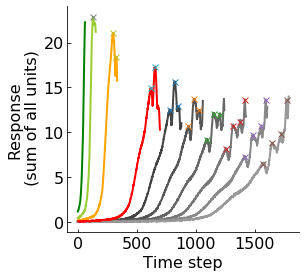

In [142]:
# This auxillary cell helps figure out the band width of the kernel smoothing for different response curves.

b = 5

fig = plt.figure(figsize=(5, 5))
gs0 = gridspec.GridSpec(12, 12, figure=fig)
ax = fig.add_subplot(gs0[1:11, 1:11])
for ii in range(len(R_over_v_list)):
    D = distance_T_all_M256[ii]
    theta_b = np.arcsin(R/D)*180/np.pi
    if R_over_v_list[ii] not in [0.01, 0.02, 0.04, 0.08]:
        ax.plot(res_T_all_M256[ii], c=color_list[ii], linewidth=line_width, alpha=1)
        peaks, _ = signal.find_peaks(gaussian_filter(res_T_all_M256[ii], b), height=5)
        ax.plot(peaks, res_T_all_M256[ii][peaks], 'x')
for ii in range(len(R_over_v_list)):
    D = distance_T_all_M256[ii]
    theta_b = np.arcsin(R/D)*180/np.pi
    if R_over_v_list[ii] == 0.01:
        ax.plot(res_T_all_M256[ii], c=color_list_data[0], linewidth=line_width)
        peaks, _ = signal.find_peaks(gaussian_filter(res_T_all_M256[ii], b), height=5)
        ax.plot(peaks, res_T_all_M256[ii][peaks], 'x')
    elif R_over_v_list[ii] == 0.02:
        ax.plot(res_T_all_M256[ii], c=color_list_data[1], linewidth=line_width)
        peaks, _ = signal.find_peaks(gaussian_filter(res_T_all_M256[ii], b), height=5)
        ax.plot(peaks, res_T_all_M256[ii][peaks], 'x')
    elif R_over_v_list[ii] == 0.04:
        ax.plot(res_T_all_M256[ii], c=color_list_data[2], linewidth=line_width)
        peaks, _ = signal.find_peaks(gaussian_filter(res_T_all_M256[ii], b), height=5)
        ax.plot(peaks, res_T_all_M256[ii][peaks], 'x')
    elif R_over_v_list[ii] == 0.08:
        ax.plot(res_T_all_M256[ii], c=color_list_data[3], linewidth=line_width)
        peaks, _ = signal.find_peaks(gaussian_filter(res_T_all_M256[ii], b), height=5)
        ax.plot(peaks, res_T_all_M256[ii][peaks], 'x')
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(True)
ax.spines["left"].set_visible(True) 
ax.set_xlabel('Time step', fontsize=label_fontsize)
ax.set_ylabel('Response\n (sum of all units)', fontsize=label_fontsize)
ax.tick_params(direction='in', labelsize=tick_fontsize)

plt.show()

# Supplementation

/Volumes/Baohua/research_large_files/multi_lplc2_training_D5_exp/M_256/lr_0.001/regu_0.0001/seed_109_20210626003509/
Max excitatory response of the looming disk is 2.379349076799346.
Max inhibitory response of the looming disk is 0.14615130424499512.
Max excitatory-inhibitory response of the looming disk is 2.3094686494156793.


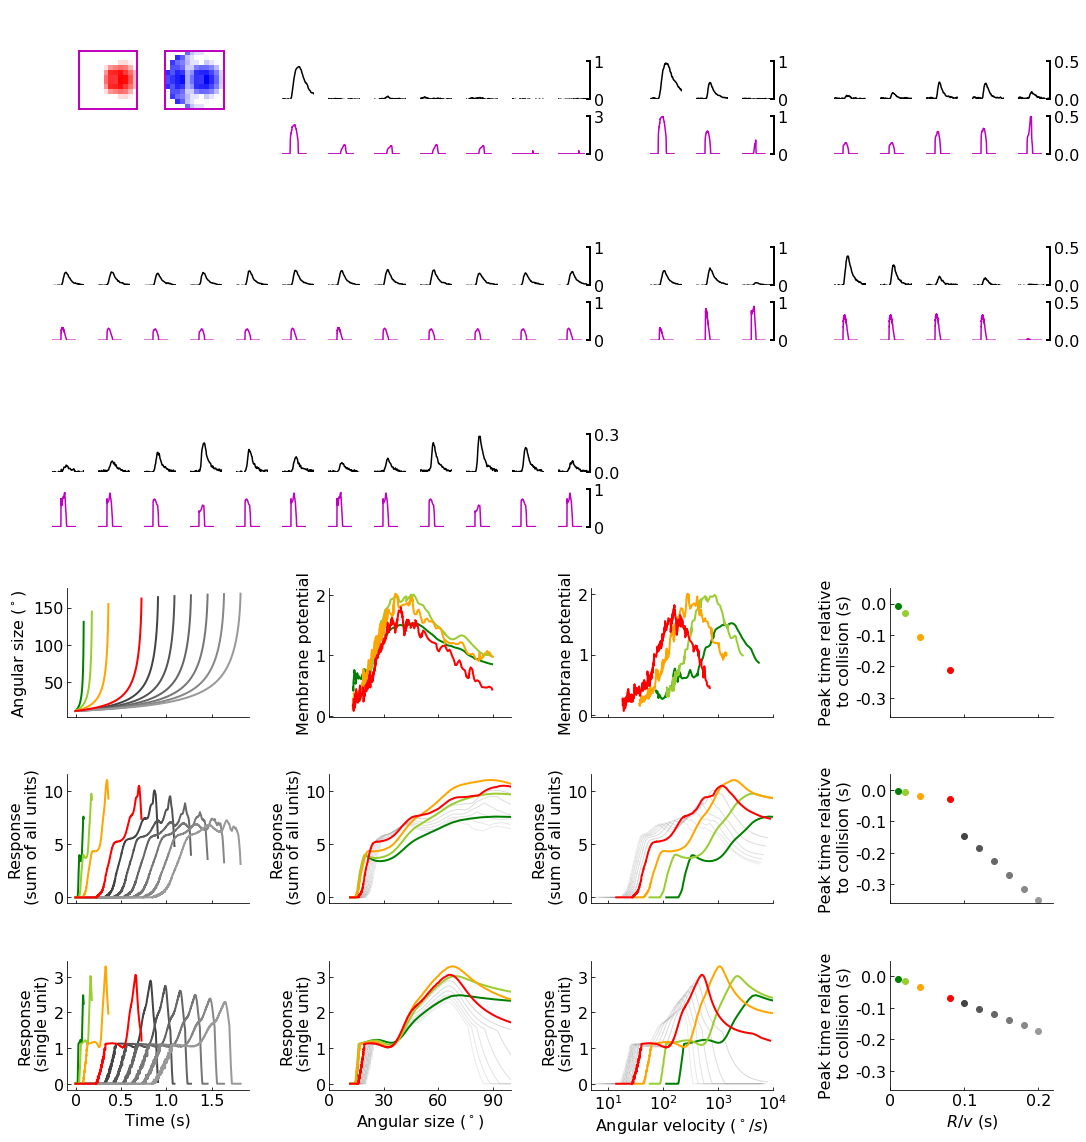

In [89]:
# For inhibitory filter without the bulb at the right side
# We are plotting res_T_all[n]

%matplotlib inline

M = 256
R = 1

figuretypes1 = ['2F', '3e', '3f', '4A', '4C', '4E', '4G']
figuretypes2 = \
[['2Fa', '2Fb', '2Fc', '2Fd', '2Fe', '2Ff', '2Fg'], \
 ['3e1', '3e2', '3e3', '3e4', '3e5', '3e6', '3e7', '3e8', '3e9', '3e10', '3e11', '3e12'], \
 ['3f1', '3f2', '3f3', '3f4', '3f5', '3f6', '3f7', '3f8', '3f9', '3f10', '3f11', '3f12'], \
 ['4Aa', '4Ab', '4Ac'], \
 ['4Ca', '4Cb', '4Cc', '4Cd', '4Ce'], \
 ['4Ea', '4Eb', '4Ec'], \
 ['4Ga', '4Gb', '4Gc', '4Gd', '4Ge']]

ymin = -0.1
ymax_dict = {}
ymax_dict['2F_1'] = 1
ymax_dict['2F_2'] = 3
ymax_dict['3e_1'] = 1
ymax_dict['3e_2'] = 1
ymax_dict['3f_1'] = 0.3
ymax_dict['3f_2'] = 1
ymax_dict['4A_1'] = 1
ymax_dict['4A_2'] = 1
ymax_dict['4C_1'] = 0.5
ymax_dict['4C_2'] = 0.5
ymax_dict['4E_1'] = 1
ymax_dict['4E_2'] = 1
ymax_dict['4G_1'] = 0.5
ymax_dict['4G_2'] = 0.5

line_width = 0.5
label_fontsize = 16
title_fontsize = 16
tick_fontsize = 16

fig = plt.figure(figsize=(18, 20))
gs0 = gridspec.GridSpec(6, 22, figure=fig)

# weights, trained
gs00 = gridspec.GridSpecFromSubplotSpec(13, 13, subplot_spec=gs0[0, 0:5])
axe = fig.add_subplot(gs00[4:9, 1:6])
# model
saved_results_path = figure_path+'model_clustering/clusterings/'
model_folders = np.load(saved_results_path+'model_folders_M{}.npy'.format(M), allow_pickle=True)
model_path = model_folders[0][2]+'/' # 17 for M = 256; 5 for M = 192
print(model_path)
K = 12
mask_d = opsg.get_disk_mask(12, 4)
if has_inhibition:
    colormap_e = LinearSegmentedColormap.from_list('wr', ['w', 'r'], N=256)
else:
    colormap_e = LinearSegmentedColormap.from_list('bwr', ['b', 'w', 'r'], N=256)
colormap_i = LinearSegmentedColormap.from_list('wb', ['w', 'b'], N=256)
trained_weights_e = np.load(model_path+'trained_weights_e.npy')
trained_weights_e = trained_weights_e[:, 0].reshape((K, K))
trained_weights_e[mask_d] = 0.
extreme_e = np.round(np.amax(np.abs(trained_weights_e)), 1)
if has_inhibition:
    color_norm_e = mpl.colors.Normalize(vmin=0, vmax=extreme_e)
else:
    color_norm_e = mpl.colors.Normalize(vmin=-extreme_e, vmax=extreme_e)
ime = axe.imshow(trained_weights_e, norm=color_norm_e, cmap=colormap_e)
axe.set_xticks([])
axe.set_yticks([])
plt.setp(axe.spines.values(), color='m', linewidth=2)

if has_inhibition:
    axi = fig.add_subplot(gs00[4:9, 6:11])
    trained_weights_i = np.load(model_path+'trained_weights_i.npy')
    trained_weights_i = trained_weights_i[:, 0].reshape((K, K))
    trained_weights_i[mask_d] = 0.
    extreme_i = np.round(np.amax(np.abs(trained_weights_i)), 1)
    color_norm_i = mpl.colors.Normalize(vmin=0, vmax=extreme_i)
    imi = axi.imshow(trained_weights_i, norm=color_norm_i, cmap=colormap_i)
    axi.set_xticks([])
    axi.set_yticks([])
    plt.setp(axi.spines.values(), color='m', linewidth=2)
    

# 2F
figuretype = figuretypes1[0]
filename = figure_path+'klap_replication/'+figuretype+'_M{}_1.npz'.format(M)
loaded_file = np.load(filename, allow_pickle=True)
res_rest_all = loaded_file['arr_0']
res_T_all = loaded_file['arr_1']
Ie_T_all = loaded_file['arr_2']
Ii_T_all = loaded_file['arr_3']
Ii_T2_all = loaded_file['arr_4']
N = len(res_T_all)
res_max_2Fa = np.max(res_T_all[0])
res_max_2Fa2 = np.max(Ie_T_all[0]-Ii_T_all[0])
print(f'Max excitatory response of the looming disk is {np.max(Ie_T_all[0])}.')
print(f'Max inhibitory response of the looming disk is {np.max(Ii_T_all[0])}.')
print(f'Max excitatory-inhibitory response of the looming disk is {np.max(Ie_T_all[0]-Ii_T_all[0])}.')

gs00 = gridspec.GridSpecFromSubplotSpec(3, 7, subplot_spec=gs0[0, 5:12])
for n in range(N):
    # add the stimuli
    gs000 = gridspec.GridSpecFromSubplotSpec(12, 12, subplot_spec=gs00[0, n])
    ax = fig.add_subplot(gs000[1:11, 1:11])
    ax.set_axis_off()
    
    # load the data
    filepath = figure_path + 'klap_replication/Klapoetke_data/For_loom_paper/klap_'+figuretypes2[0][n]+'.mat'
    klap_2F = loadmat(filepath)
    klap_2F = klap_2F['klap_2F']
    klap_t = klap_2F[0, 0, :]
    klap_res = klap_2F[:, 1, :].mean(axis=0)
    
    gs000 = gridspec.GridSpecFromSubplotSpec(12, 12, subplot_spec=gs00[1, n])
    ax = fig.add_subplot(gs000[1:11, 1:11])
    T = len(res_T_all[n])
    T_vec = np.linspace(0, (T-1)*0.01, T)
    ax.plot(klap_t, klap_res, c='k')
    ax.set_xlim([0, T_vec[-1]+2])
    ax.set_ylim([0, ymax_dict['2F_1']])
    if n != N-1:
        ax.set_axis_off()
    else:
        ax.spines["left"].set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.spines["bottom"].set_linewidth(False)
        ax.spines["right"].set_linewidth(2)
        ax.set_xticks([])
        ax.set_yticks([0, ymax_dict['2F_1']])
        ax.yaxis.tick_right()
        ax.tick_params(direction='in', length=4, width=2, labelsize=tick_fontsize)
    
    gs000 = gridspec.GridSpecFromSubplotSpec(12, 12, subplot_spec=gs00[2, n])
    ax = fig.add_subplot(gs000[1:11, 1:11])
    ax.plot(T_vec, np.maximum(Ie_T_all[n]-Ii_T_all[n], 0), 'm')
    ax.set_xlim([0, T_vec[-1]+2])
    ax.set_ylim([0, ymax_dict['2F_2']])
    if n != N-1:
        ax.set_axis_off()
    else:
        ax.spines["left"].set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.spines["bottom"].set_linewidth(False)
        ax.spines["right"].set_linewidth(2)
        ax.set_xticks([])
        ax.set_yticks([0, ymax_dict['2F_2']])
        ax.yaxis.tick_right()
        ax.tick_params(direction='in', length=4, width=2, labelsize=tick_fontsize)
        
    
# 3e
figuretype = figuretypes1[1]
filename = figure_path+'klap_replication/'+figuretype+'_M{}_1.npz'.format(M)
loaded_file = np.load(filename, allow_pickle=True)
res_rest_all = loaded_file['arr_0']
res_T_all = loaded_file['arr_1']
Ie_T_all = loaded_file['arr_2']
Ii_T_all = loaded_file['arr_3']
Ii_T2_all = loaded_file['arr_4']
N = len(res_T_all)

gs00 = gridspec.GridSpecFromSubplotSpec(3, 12, subplot_spec=gs0[1, :12])
for n in range(N):
    # add the stimuli
    gs000 = gridspec.GridSpecFromSubplotSpec(12, 12, subplot_spec=gs00[0, n])
    ax = fig.add_subplot(gs000[1:11, 1:11])
    ax.set_axis_off()
    
    # load the data
    filepath = figure_path + 'klap_replication/Klapoetke_data/For_loom_paper/klap_'+figuretypes2[1][n]+'.mat'
    klap_3e = loadmat(filepath)
    klap_3e = klap_3e['klap_3e']
    klap_t = klap_3e[0, 0, :]
    klap_res = klap_3e[:, 1, :].mean(axis=0)
    
    gs000 = gridspec.GridSpecFromSubplotSpec(12, 12, subplot_spec=gs00[1, n])
    ax = fig.add_subplot(gs000[1:11, 1:11])
    T = len(res_T_all[n])
    T_vec = np.linspace(0, (T-1)*0.01, T)
    ax.plot(klap_t, klap_res, c='k')    
    ax.set_xlim([0, T_vec[-1]+2])
    ax.set_ylim([0, ymax_dict['3e_1']])
    if n != N-1:
        ax.set_axis_off()
    else:
        ax.spines["left"].set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.spines["bottom"].set_linewidth(False)
        ax.spines["right"].set_linewidth(2)
        ax.set_xticks([])
        ax.set_yticks([0, ymax_dict['3e_1']])
        ax.yaxis.tick_right()
        ax.tick_params(direction='in', length=4, width=2, labelsize=tick_fontsize)
    
    gs000 = gridspec.GridSpecFromSubplotSpec(12, 12, subplot_spec=gs00[2, n])
    ax = fig.add_subplot(gs000[1:11, 1:11])
    ax.plot(T_vec, np.maximum(Ie_T_all[n]-Ii_T_all[n], 0)/res_max_2Fa2, 'm')
    ax.set_xlim([0, T_vec[-1]+2])
    ax.set_ylim([0, ymax_dict['3e_2']])
    if n != N-1:
        ax.set_axis_off()
    else:
        ax.spines["left"].set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.spines["bottom"].set_linewidth(False)
        ax.spines["right"].set_linewidth(2)
        ax.set_xticks([])
        ax.set_yticks([0, ymax_dict['3e_2']])
        ax.yaxis.tick_right()
        ax.tick_params(direction='in', length=4, width=2, labelsize=tick_fontsize)
    

# 3f
figuretype = figuretypes1[2]
filename = figure_path+'klap_replication/'+figuretype+'_M{}_1.npz'.format(M)
loaded_file = np.load(filename, allow_pickle=True)
res_rest_all = loaded_file['arr_0']
res_T_all = loaded_file['arr_1']
Ie_T_all = loaded_file['arr_2']
Ii_T_all = loaded_file['arr_3']
Ii_T2_all = loaded_file['arr_4']
N = len(res_T_all)

gs00 = gridspec.GridSpecFromSubplotSpec(3, 12, subplot_spec=gs0[2, :12])
for n in range(N):
    # add the stimuli
    gs000 = gridspec.GridSpecFromSubplotSpec(12, 12, subplot_spec=gs00[0, n])
    ax = fig.add_subplot(gs000[1:11, 1:11])
    ax.set_axis_off()
    
    # load the data
    filepath = figure_path + 'klap_replication/Klapoetke_data/For_loom_paper/klap_'+figuretypes2[2][n]+'.mat'
    klap_3f = loadmat(filepath)
    klap_3f = klap_3f['klap_3f']
    klap_t = klap_3f[0, 0, :]
    klap_res = klap_3f[:, 1, :].mean(axis=0)
    
    gs000 = gridspec.GridSpecFromSubplotSpec(12, 12, subplot_spec=gs00[1, n])
    ax = fig.add_subplot(gs000[1:11, 1:11])
    T = len(res_T_all[n])
    T_vec = np.linspace(0, (T-1)*0.01, T)
    ax.plot(klap_t, klap_res, c='k')    
    ax.set_xlim([0, T_vec[-1]+2])
    ax.set_ylim([0, ymax_dict['3f_1']])
    if n != N-1:
        ax.set_axis_off()
    else:
        ax.spines["left"].set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.spines["bottom"].set_linewidth(False)
        ax.spines["right"].set_linewidth(2)
        ax.set_xticks([])
        ax.set_yticks([0, ymax_dict['3f_1']])
        ax.yaxis.tick_right()
        ax.tick_params(direction='in', length=4, width=2, labelsize=tick_fontsize)
    
    gs000 = gridspec.GridSpecFromSubplotSpec(12, 12, subplot_spec=gs00[2, n])
    ax = fig.add_subplot(gs000[1:11, 1:11])
    ax.plot(T_vec, np.maximum(Ie_T_all[n]-Ii_T_all[n], 0)/res_max_2Fa2, 'm')
    ax.set_xlim([0, T_vec[-1]+2])
    ax.set_ylim([0, ymax_dict['3f_2']])
    if n != N-1:
        ax.set_axis_off()
    else:
        ax.spines["left"].set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.spines["bottom"].set_linewidth(False)
        ax.spines["right"].set_linewidth(2)
        ax.set_xticks([])
        ax.set_yticks([0, ymax_dict['3f_2']])
        ax.yaxis.tick_right()
        ax.tick_params(direction='in', length=4, width=2, labelsize=tick_fontsize)
    
    
# 4A
gs00 = gridspec.GridSpecFromSubplotSpec(3, 3, subplot_spec=gs0[0, 13:16])

figuretype = figuretypes1[3]
filename = figure_path+'klap_replication/'+figuretype+'_M{}_1.npz'.format(M)
loaded_file = np.load(filename, allow_pickle=True)
res_rest_all = loaded_file['arr_0']
res_T_all = loaded_file['arr_1']
Ie_T_all = loaded_file['arr_2']
Ii_T_all = loaded_file['arr_3']
Ii_T2_all = loaded_file['arr_4']
N = len(res_T_all)

for n in range(N):
    # add the stimuli
    gs000 = gridspec.GridSpecFromSubplotSpec(12, 12, subplot_spec=gs00[0, n])
    ax = fig.add_subplot(gs000[1:11, 1:11])
    ax.set_axis_off()
    
    # load the data
    filepath = figure_path + 'klap_replication/Klapoetke_data/For_loom_paper/klap_'+figuretypes2[3][n]+'.mat'
    klap_4A = loadmat(filepath)
    klap_4A = klap_4A['klap_4A']
    klap_t = klap_4A[0, 0, :]
    klap_res = klap_4A[:, 1, :].mean(axis=0)
    
    gs000 = gridspec.GridSpecFromSubplotSpec(12, 12, subplot_spec=gs00[1, n])
    ax = fig.add_subplot(gs000[1:11, 1:11])
    T = len(res_T_all[n])
    T_vec = np.linspace(0, (T-1)*0.01, T)
    ax.plot(klap_t, klap_res, c='k')    
    ax.set_xlim([0, T_vec[-1]+2])
    ax.set_ylim([0, ymax_dict['4A_1']])
    if n != N-1:
        ax.set_axis_off()
    else:
        ax.spines["left"].set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.spines["bottom"].set_linewidth(False)
        ax.spines["right"].set_linewidth(2)
        ax.set_xticks([])
        ax.set_yticks([0, ymax_dict['4A_1']])
        ax.yaxis.tick_right()
        ax.tick_params(direction='in', length=4, width=2, labelsize=tick_fontsize)
    
    gs000 = gridspec.GridSpecFromSubplotSpec(12, 12, subplot_spec=gs00[2, n])
    ax = fig.add_subplot(gs000[1:11, 1:11])
    ax.plot(T_vec, np.maximum(Ie_T_all[n]-Ii_T_all[n], 0)/res_max_2Fa2, 'm')
    ax.set_xlim([0, T_vec[-1]+2])
    ax.set_ylim([0, ymax_dict['4A_2']])
    if n != N-1:
        ax.set_axis_off()
    else:
        ax.spines["left"].set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.spines["bottom"].set_linewidth(False)
        ax.spines["right"].set_linewidth(2)
        ax.set_xticks([])
        ax.set_yticks([0, ymax_dict['4A_2']])
        ax.yaxis.tick_right()
        ax.tick_params(direction='in', length=4, width=2, labelsize=tick_fontsize)

# 4C
gs00 = gridspec.GridSpecFromSubplotSpec(3, 5, subplot_spec=gs0[0, 17:22])
    
figuretype = figuretypes1[4]
filename = figure_path+'klap_replication/'+figuretype+'_M{}_1.npz'.format(M)
loaded_file = np.load(filename, allow_pickle=True)
res_rest_all = loaded_file['arr_0']
res_T_all = loaded_file['arr_1']
Ie_T_all = loaded_file['arr_2']
Ii_T_all = loaded_file['arr_3']
Ii_T2_all = loaded_file['arr_4']
N = len(res_T_all)

for n in range(N):
    # add the stimuli
    gs000 = gridspec.GridSpecFromSubplotSpec(12, 12, subplot_spec=gs00[0, n])
    ax = fig.add_subplot(gs000[1:11, 1:11])
    ax.set_axis_off()
    
    # load the data
    filepath = figure_path + 'klap_replication/Klapoetke_data/For_loom_paper/klap_'+figuretypes2[4][n]+'.mat'
    klap_4C = loadmat(filepath)
    klap_4C = klap_4C['klap_4C']
    klap_t = klap_4C[0, 0, :]
    klap_res = klap_4C[:, 1, :].mean(axis=0)
    
    gs000 = gridspec.GridSpecFromSubplotSpec(12, 12, subplot_spec=gs00[1, n])
    ax = fig.add_subplot(gs000[1:11, 1:11])
    T = len(res_T_all[n])
    T_vec = np.linspace(0, (T-1)*0.01, T)
    ax.plot(klap_t, klap_res, c='k')    
    ax.set_xlim([0, T_vec[-1]+2])
    ax.set_ylim([0, ymax_dict['4C_1']])
    if n != N-1:
        ax.set_axis_off()
    else:
        ax.spines["left"].set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.spines["bottom"].set_linewidth(False)
        ax.spines["right"].set_linewidth(2)
        ax.set_xticks([])
        ax.set_yticks([0, ymax_dict['4C_1']])
        ax.yaxis.tick_right()
        ax.tick_params(direction='in', length=4, width=2, labelsize=tick_fontsize)
    
    gs000 = gridspec.GridSpecFromSubplotSpec(12, 12, subplot_spec=gs00[2, n])
    ax = fig.add_subplot(gs000[1:11, 1:11])
    ax.plot(T_vec, np.maximum(Ie_T_all[n]-Ii_T_all[n], 0)/res_max_2Fa2, 'm')
    ax.set_xlim([0, T_vec[-1]+2])
    ax.set_ylim([0, ymax_dict['4C_2']])
    if n != N-1:
        ax.set_axis_off()
    else:
        ax.spines["left"].set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.spines["bottom"].set_linewidth(False)
        ax.spines["right"].set_linewidth(2)
        ax.set_xticks([])
        ax.set_yticks([0, ymax_dict['4C_2']])
        ax.yaxis.tick_right()
        ax.tick_params(direction='in', length=4, width=2, labelsize=tick_fontsize)
    
    
# 4E
gs00 = gridspec.GridSpecFromSubplotSpec(3, 3, subplot_spec=gs0[1, 13:16])

figuretype = figuretypes1[5]
filename = figure_path+'klap_replication/'+figuretype+'_M{}_1.npz'.format(M)
loaded_file = np.load(filename, allow_pickle=True)
res_rest_all = loaded_file['arr_0']
res_T_all = loaded_file['arr_1']
Ie_T_all = loaded_file['arr_2']
Ii_T_all = loaded_file['arr_3']
Ii_T2_all = loaded_file['arr_4']
N = len(res_T_all)

for n in range(N):
    # add the stimuli
    gs000 = gridspec.GridSpecFromSubplotSpec(12, 12, subplot_spec=gs00[0, n])
    ax = fig.add_subplot(gs000[1:11, 1:11])
    ax.set_axis_off()
    
    # load the data
    filepath = figure_path + 'klap_replication/Klapoetke_data/For_loom_paper/klap_'+figuretypes2[5][n]+'.mat'
    klap_4E = loadmat(filepath)
    klap_4E = klap_4E['klap_4E']
    klap_t = klap_4E[0, 0, :]
    klap_res = klap_4E[:, 1, :].mean(axis=0)
    
    gs000 = gridspec.GridSpecFromSubplotSpec(12, 12, subplot_spec=gs00[1, n])
    ax = fig.add_subplot(gs000[1:11, 1:11])
    T = len(res_T_all[n])
    T_vec = np.linspace(0, (T-1)*0.01, T)
    ax.plot(klap_t, klap_res, c='k')    
    ax.set_xlim([0, T_vec[-1]+2])
    ax.set_ylim([0, ymax_dict['4E_1']])
    if n != N-1:
        ax.set_axis_off()
    else:
        ax.spines["left"].set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.spines["bottom"].set_linewidth(False)
        ax.spines["right"].set_linewidth(2)
        ax.set_xticks([])
        ax.set_yticks([0, ymax_dict['4E_1']])
        ax.yaxis.tick_right()
        ax.tick_params(direction='in', length=4, width=2, labelsize=tick_fontsize)
    
    gs000 = gridspec.GridSpecFromSubplotSpec(12, 12, subplot_spec=gs00[2, n])
    ax = fig.add_subplot(gs000[1:11, 1:11])
    ax.plot(T_vec, np.maximum(Ie_T_all[n]-Ii_T_all[n], 0)/res_max_2Fa2, 'm')
    ax.set_xlim([0, T_vec[-1]+2])
    ax.set_ylim([0, ymax_dict['4E_2']])
    if n != N-1:
        ax.set_axis_off()
    else:
        ax.spines["left"].set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.spines["bottom"].set_linewidth(False)
        ax.spines["right"].set_linewidth(2)
        ax.set_xticks([])
        ax.set_yticks([0, ymax_dict['4E_2']])
        ax.yaxis.tick_right()
        ax.tick_params(direction='in', length=4, width=2, labelsize=tick_fontsize)
    
# 4G
gs00 = gridspec.GridSpecFromSubplotSpec(3, 5, subplot_spec=gs0[1, 17:22])
    
figuretype = figuretypes1[6]
filename = figure_path+'klap_replication/'+figuretype+'_M{}_1.npz'.format(M)
loaded_file = np.load(filename, allow_pickle=True)
res_rest_all = loaded_file['arr_0']
res_T_all = loaded_file['arr_1']
Ie_T_all = loaded_file['arr_2']
Ii_T_all = loaded_file['arr_3']
Ii_T2_all = loaded_file['arr_4']
N = len(res_T_all)

for n in range(N):
    # add the stimuli
    gs000 = gridspec.GridSpecFromSubplotSpec(12, 12, subplot_spec=gs00[0, n])
    ax = fig.add_subplot(gs000[1:11, 1:11])
    ax.set_axis_off()
    
    # load the data
    filepath = figure_path + 'klap_replication/Klapoetke_data/For_loom_paper/klap_'+figuretypes2[6][n]+'.mat'
    klap_4G = loadmat(filepath)
    klap_4G = klap_4G['klap_4G']
    klap_t = klap_4G[0, 0, :]
    klap_res = klap_4G[:, 1, :].mean(axis=0)
    
    gs000 = gridspec.GridSpecFromSubplotSpec(12, 12, subplot_spec=gs00[1, n])
    ax = fig.add_subplot(gs000[1:11, 1:11])
    T = len(res_T_all[n])
    T_vec = np.linspace(0, (T-1)*0.01, T)
    ax.plot(klap_t, klap_res, c='k')    
    ax.set_xlim([0, T_vec[-1]+2])
    ax.set_ylim([0, ymax_dict['4G_1']])
    if n != N-1:
        ax.set_axis_off()
    else:
        ax.spines["left"].set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.spines["bottom"].set_linewidth(False)
        ax.spines["right"].set_linewidth(2)
        ax.set_xticks([])
        ax.set_yticks([0, ymax_dict['4G_1']])
        ax.yaxis.tick_right()
        ax.tick_params(direction='in', length=4, width=2, labelsize=tick_fontsize)
    
    gs000 = gridspec.GridSpecFromSubplotSpec(12, 12, subplot_spec=gs00[2, n])
    ax = fig.add_subplot(gs000[1:11, 1:11])
    ax.plot(T_vec, np.maximum(Ie_T_all[n]-Ii_T_all[n], 0)/res_max_2Fa2, 'm')
    ax.set_xlim([0, T_vec[-1]+2])
    ax.set_ylim([0, ymax_dict['4G_2']])
    if n != N-1:
        ax.set_axis_off()
    else:
        ax.spines["left"].set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.spines["bottom"].set_linewidth(False)
        ax.spines["right"].set_linewidth(2)
        ax.set_xticks([])
        ax.set_yticks([0, ymax_dict['4G_2']])
        ax.yaxis.tick_right()
        ax.tick_params(direction='in', length=4, width=2, labelsize=tick_fontsize)
        
        
# linear law and angular size dependence

# data
file_path = figure_path + 'linear_law/linear_law.csv'
linear_law = np.genfromtxt(file_path, delimiter=',')
file_path = figure_path + 'linear_law/angular_size_r_over_v_10.csv'
angular_size_r_over_v_10 = np.genfromtxt(file_path, delimiter=',')
file_path = figure_path + 'linear_law/angular_size_r_over_v_20.csv'
angular_size_r_over_v_20 = np.genfromtxt(file_path, delimiter=',')
file_path = figure_path + 'linear_law/angular_size_r_over_v_40.csv'
angular_size_r_over_v_40 = np.genfromtxt(file_path, delimiter=',')
file_path = figure_path + 'linear_law/angular_size_r_over_v_80.csv'
angular_size_r_over_v_80 = np.genfromtxt(file_path, delimiter=',')
file_path = figure_path + 'linear_law/angular_velocity_r_over_v_10.csv'
angular_velocity_r_over_v_10 = np.genfromtxt(file_path, delimiter=',')
file_path = figure_path + 'linear_law/angular_velocity_r_over_v_20.csv'
angular_velocity_r_over_v_20 = np.genfromtxt(file_path, delimiter=',')
file_path = figure_path + 'linear_law/angular_velocity_r_over_v_40.csv'
angular_velocity_r_over_v_40 = np.genfromtxt(file_path, delimiter=',')
file_path = figure_path + 'linear_law/angular_velocity_r_over_v_80.csv'
angular_velocity_r_over_v_80 = np.genfromtxt(file_path, delimiter=',')


data_type = 'hit'
data_path = figure_path + 'linear_law/'+data_type+'/'
distance_T_all_M256 = np.load(data_path+f'distance_T_all_M{256}_sup1.npy', allow_pickle=True)
res_T_all_M256 = np.load(data_path+f'res_T_all_M{256}_sup1.npy', allow_pickle=True)
distance_T_all_M1 = np.load(data_path+f'distance_T_all_M{1}_sup1.npy', allow_pickle=True)
res_T_all_M1 = np.load(data_path+f'res_T_all_M{1}_sup1.npy', allow_pickle=True)
offset = 1 # 1 for exponential filter; 30 for delta filter


# R_over_v_list = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, \
#                  0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2]
R_over_v_list = [0.01, 0.02, 0.04, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2]

# green, yellow green, orange, red
color_list_data = [[0/255., 128/255., 0/255.], \
                   [154/255., 205/255., 50/255.], \
                   [255/255., 165/255., 0], \
                   [255/255., 0, 0]]
color_list = []
for ind, R_over_v in enumerate(R_over_v_list):
    if R_over_v == 0.01:
        color_list.append(color_list_data[0])
    elif R_over_v == 0.02:
        color_list.append(color_list_data[1])
    elif R_over_v == 0.04:
        color_list.append(color_list_data[2])
    elif R_over_v == 0.08:
        color_list.append(color_list_data[3])
    else:
        val = 1. / (len(R_over_v_list) + 5) * ind
        color_list.append([val, val, val])

line_width = 2
gs00 = gridspec.GridSpecFromSubplotSpec(3, 4, subplot_spec=gs0[3:, :])

# angular size against time, data
gs000 = gridspec.GridSpecFromSubplotSpec(12, 12, subplot_spec=gs00[0, 0])
ax = fig.add_subplot(gs000[2:12, 1:11])
for ii in range(len(R_over_v_list)):
    D = distance_T_all_M1[ii]
    theta_b = 2 * np.arcsin(R/D)*180/np.pi
    if R_over_v_list[ii] not in [0.01, 0.02, 0.04, 0.08]:
        ax.plot(theta_b[offset:], c=color_list[ii], linewidth=line_width, alpha=1)
for ii in range(len(R_over_v_list)):
    D = distance_T_all_M1[ii]
    theta_b = 2 * np.arcsin(R/D)*180/np.pi
    if R_over_v_list[ii] == 0.01:
        ax.plot(theta_b[offset:], c=color_list_data[0], linewidth=line_width)
    elif R_over_v_list[ii] == 0.02:
        ax.plot(theta_b[offset:], c=color_list_data[1], linewidth=line_width)
    elif R_over_v_list[ii] == 0.04:
        ax.plot(theta_b[offset:], c=color_list_data[2], linewidth=line_width)
    elif R_over_v_list[ii] == 0.08:
        ax.plot(theta_b[offset:], c=color_list_data[3], linewidth=line_width)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(True)
ax.spines["left"].set_visible(True) 
ax.set_xticks([0, 500, 1000, 1500])
ax.set_xticklabels([])
# ax.set_xlabel('Time (s)', fontsize=label_fontsize)
ax.set_ylabel(r'Angular size ($^\circ$)', fontsize=label_fontsize)
ax.tick_params(direction='in', labelsize=tick_fontsize)

# response against time, M = 256
gs000 = gridspec.GridSpecFromSubplotSpec(12, 12, subplot_spec=gs00[1, 0])
ax = fig.add_subplot(gs000[2:12, 1:11])
for ii in range(len(R_over_v_list)):
    D = distance_T_all_M256[ii]
    theta_b = np.arcsin(R/D)*180/np.pi
    if R_over_v_list[ii] not in [0.01, 0.02, 0.04, 0.08]:
        ax.plot(res_T_all_M256[ii], c=color_list[ii], linewidth=line_width, alpha=1)
for ii in range(len(R_over_v_list)):
    D = distance_T_all_M256[ii]
    theta_b = np.arcsin(R/D)*180/np.pi
    if R_over_v_list[ii] == 0.01:
        ax.plot(res_T_all_M256[ii], c=color_list_data[0], linewidth=line_width)
    elif R_over_v_list[ii] == 0.02:
        ax.plot(res_T_all_M256[ii], c=color_list_data[1], linewidth=line_width)
    elif R_over_v_list[ii] == 0.04:
        ax.plot(res_T_all_M256[ii], c=color_list_data[2], linewidth=line_width)
    elif R_over_v_list[ii] == 0.08:
        ax.plot(res_T_all_M256[ii], c=color_list_data[3], linewidth=line_width)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(True)
ax.spines["left"].set_visible(True) 
ax.set_xticks([0, 500, 1000, 1500])
ax.set_xticklabels([])
# ax.set_xlabel('Time (s)', fontsize=label_fontsize)
ax.set_ylabel('Response\n (sum of all units)', fontsize=label_fontsize)
ax.tick_params(direction='in', labelsize=tick_fontsize)

# response against time, single unit from M = 256
gs000 = gridspec.GridSpecFromSubplotSpec(12, 12, subplot_spec=gs00[2, 0])
ax = fig.add_subplot(gs000[2:12, 1:11])
for ii in range(len(R_over_v_list)):
    D = distance_T_all_M1[ii]
    theta_b = np.arcsin(R/D)*180/np.pi
    if R_over_v_list[ii] not in [0.01, 0.02, 0.04, 0.08]:
        ax.plot(res_T_all_M1[ii], c=color_list[ii], linewidth=line_width, alpha=1)
for ii in range(len(R_over_v_list)):
    D = distance_T_all_M1[ii]
    theta_b = np.arcsin(R/D)*180/np.pi
    if R_over_v_list[ii] == 0.01:
        ax.plot(res_T_all_M1[ii], c=color_list_data[0], linewidth=line_width)
    elif R_over_v_list[ii] == 0.02:
        ax.plot(res_T_all_M1[ii], c=color_list_data[1], linewidth=line_width)
    elif R_over_v_list[ii] == 0.04:
        ax.plot(res_T_all_M1[ii], c=color_list_data[2], linewidth=line_width)
    elif R_over_v_list[ii] == 0.08:
        ax.plot(res_T_all_M1[ii], c=color_list_data[3], linewidth=line_width)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(True)
ax.spines["left"].set_visible(True) 
ax.set_xticks([0, 500, 1000, 1500])
ax.set_xticklabels([0, 0.5, 1.0, 1.5])
ax.set_xlabel('Time (s)', fontsize=label_fontsize)
ax.set_ylabel('Response\n (single unit)', fontsize=label_fontsize)
ax.tick_params(direction='in', labelsize=tick_fontsize)

# response against angular size, data
gs000 = gridspec.GridSpecFromSubplotSpec(12, 12, subplot_spec=gs00[0, 1])
ax = fig.add_subplot(gs000[2:12, 1:11])
ax.plot(angular_size_r_over_v_10[:, 0], angular_size_r_over_v_10[:, 1], c=color_list_data[0], linewidth=line_width)
ax.plot(angular_size_r_over_v_20[:, 0], angular_size_r_over_v_20[:, 1], c=color_list_data[1], linewidth=line_width)
ax.plot(angular_size_r_over_v_40[:, 0], angular_size_r_over_v_40[:, 1], c=color_list_data[2], linewidth=line_width)
ax.plot(angular_size_r_over_v_80[:, 0], angular_size_r_over_v_80[:, 1], c=color_list_data[3], linewidth=line_width)
ax.set_xlim([0, 100])
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(True)
ax.spines["left"].set_visible(True) 
# ax.set_xlabel(r'Angular size ($^\circ$)', fontsize=label_fontsize)
ax.set_ylabel('Membrane potential', fontsize=label_fontsize)
ax.tick_params(direction='in', labelsize=tick_fontsize)
ax.set_yticks([0, 1, 2])
ax.set_xticks([0, 30, 60, 90])
ax.set_xticklabels([])

# response against angular size, M = 256
gs000 = gridspec.GridSpecFromSubplotSpec(12, 12, subplot_spec=gs00[1, 1])
ax = fig.add_subplot(gs000[2:12, 1:11])
for ii in range(len(R_over_v_list)):
    D = distance_T_all_M256[ii]
    theta_b = 2 * np.arcsin(R/D)*180/np.pi
    if R_over_v_list[ii] not in [0.01, 0.02, 0.04, 0.08]:
        ax.plot(theta_b[offset:], res_T_all_M256[ii], c=color_list[ii], linewidth=0.5*line_width, alpha=0.2)
for ii in range(len(R_over_v_list)):
    D = distance_T_all_M256[ii]
    theta_b = 2 * np.arcsin(R/D)*180/np.pi
    if R_over_v_list[ii] == 0.01:
        ax.plot(theta_b[offset:], res_T_all_M256[ii], c=color_list_data[0], linewidth=line_width)
    elif R_over_v_list[ii] == 0.02:
        ax.plot(theta_b[offset:], res_T_all_M256[ii], c=color_list_data[1], linewidth=line_width)
    elif R_over_v_list[ii] == 0.04:
        ax.plot(theta_b[offset:], res_T_all_M256[ii], c=color_list_data[2], linewidth=line_width)
    elif R_over_v_list[ii] == 0.08:
        ax.plot(theta_b[offset:], res_T_all_M256[ii], c=color_list_data[3], linewidth=line_width)
ax.set_xlim([0, 100])
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(True)
ax.spines["left"].set_visible(True) 
# ax.set_xlabel(r'Angular size ($^\circ$)', fontsize=label_fontsize)
ax.set_ylabel('Response\n (sum of all units)', fontsize=label_fontsize)
ax.tick_params(direction='in', labelsize=tick_fontsize)
ax.set_xticks([0, 30, 60, 90])
ax.set_xticklabels([])

# response against angular size, single unit from M = 256
gs000 = gridspec.GridSpecFromSubplotSpec(12, 12, subplot_spec=gs00[2, 1])
ax = fig.add_subplot(gs000[2:12, 1:11])
for ii in range(len(R_over_v_list)):
    D = distance_T_all_M1[ii]
    theta_b = 2 * np.arcsin(R/D)*180/np.pi
    if R_over_v_list[ii] not in [0.01, 0.02, 0.04, 0.08]:
        ax.plot(theta_b[offset:], res_T_all_M1[ii], c=color_list[ii], linewidth=0.5*line_width, alpha=0.2)
for ii in range(len(R_over_v_list)):
    D = distance_T_all_M1[ii]
    theta_b = 2 * np.arcsin(R/D)*180/np.pi
    if R_over_v_list[ii] == 0.01:
        ax.plot(theta_b[offset:], res_T_all_M1[ii], c=color_list_data[0], linewidth=line_width)
    elif R_over_v_list[ii] == 0.02:
        ax.plot(theta_b[offset:], res_T_all_M1[ii], c=color_list_data[1], linewidth=line_width)
    elif R_over_v_list[ii] == 0.04:
        ax.plot(theta_b[offset:], res_T_all_M1[ii], c=color_list_data[2], linewidth=line_width)
    elif R_over_v_list[ii] == 0.08:
        ax.plot(theta_b[offset:], res_T_all_M1[ii], c=color_list_data[3], linewidth=line_width)
ax.set_xlim([0, 100])
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(True)
ax.spines["left"].set_visible(True) 
ax.set_xlabel(r'Angular size ($^\circ$)', fontsize=label_fontsize)
ax.set_ylabel('Response\n (single unit)', fontsize=label_fontsize)
ax.tick_params(direction='in', labelsize=tick_fontsize)
ax.set_xticks([0, 30, 60, 90])
ax.set_xticklabels([0, 30, 60, 90])

# response against angular velocity, data
gs000 = gridspec.GridSpecFromSubplotSpec(12, 12, subplot_spec=gs00[0, 2])
ax = fig.add_subplot(gs000[2:12, 1:11])
ax.plot(angular_velocity_r_over_v_10[:, 0], angular_velocity_r_over_v_10[:, 1], c=color_list_data[0], linewidth=line_width)
ax.plot(angular_velocity_r_over_v_20[:, 0], angular_velocity_r_over_v_20[:, 1], c=color_list_data[1], linewidth=line_width)
ax.plot(angular_velocity_r_over_v_40[:, 0], angular_velocity_r_over_v_40[:, 1], c=color_list_data[2], linewidth=line_width)
ax.plot(angular_velocity_r_over_v_80[:, 0], angular_velocity_r_over_v_80[:, 1], c=color_list_data[3], linewidth=line_width)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(True)
ax.spines["left"].set_visible(True) 
ax.set_xscale('log')
# ax.set_xlabel(r'Angular velocity ($^\circ/s$)', fontsize=label_fontsize)
ax.set_ylabel('Membrane potential', fontsize=label_fontsize)
ax.set_xlim([5, 10000])
ax.tick_params(direction='in', labelsize=tick_fontsize)
ax.get_xaxis().set_tick_params(which='minor', size=0)
ax.get_xaxis().set_tick_params(which='minor', width=0) 
ax.get_yaxis().set_tick_params(which='minor', size=0)
ax.get_yaxis().set_tick_params(which='minor', width=0) 
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.set_xticks([10, 100, 1000, 10000])
ax.set_xticklabels([])
ax.set_yticks([0, 1, 2])

# response against angular velocity, M = 256
gs000 = gridspec.GridSpecFromSubplotSpec(12, 12, subplot_spec=gs00[1, 2])
ax = fig.add_subplot(gs000[2:12, 1:11])
for ii in range(len(R_over_v_list)):
    D = distance_T_all_M256[ii]
    R_over_v = R_over_v_list[ii]
    theta_b_dot = 2 * np.divide(R/(np.sqrt(D**2-R**2))*(R/R_over_v)*180/np.pi, D)
    if R_over_v_list[ii] not in [0.01, 0.02, 0.04, 0.08]:
        ax.plot(theta_b_dot[offset:], res_T_all_M256[ii], c=color_list[ii], linewidth=0.5*line_width, alpha=0.2)
for ii in range(len(R_over_v_list)):
    D = distance_T_all_M256[ii]
    R_over_v = R_over_v_list[ii]
    theta_b_dot = 2 * np.divide(R/(np.sqrt(D**2-R**2))*(R/R_over_v)*180/np.pi, D)
    if R_over_v_list[ii] == 0.01:
        ax.plot(theta_b_dot[offset:], res_T_all_M256[ii], c=color_list_data[0], linewidth=line_width)
    elif R_over_v_list[ii] == 0.02:
        ax.plot(theta_b_dot[offset:], res_T_all_M256[ii], c=color_list_data[1], linewidth=line_width)
    elif R_over_v_list[ii] == 0.04:
        ax.plot(theta_b_dot[offset:], res_T_all_M256[ii], c=color_list_data[2], linewidth=line_width)
    elif R_over_v_list[ii] == 0.08:
        ax.plot(theta_b_dot[offset:], res_T_all_M256[ii], c=color_list_data[3], linewidth=line_width)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(True)
ax.spines["left"].set_visible(True) 
ax.set_xscale('log')
# ax.set_xlabel(r'Angular velocity ($^\circ/s$)', fontsize=label_fontsize)
ax.set_ylabel('Response\n (sum of all units)', fontsize=label_fontsize)
ax.set_xlim([5, 10000])
ax.tick_params(direction='in', labelsize=tick_fontsize)
ax.get_xaxis().set_tick_params(which='minor', size=0)
ax.get_xaxis().set_tick_params(which='minor', width=0) 
ax.get_yaxis().set_tick_params(which='minor', size=0)
ax.get_yaxis().set_tick_params(which='minor', width=0) 
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.set_xticks([10, 100, 1000, 10000])
ax.set_xticklabels([])

# response against angular velocity, single unit from M = 256
gs000 = gridspec.GridSpecFromSubplotSpec(12, 12, subplot_spec=gs00[2, 2])
ax = fig.add_subplot(gs000[2:12, 1:11])
for ii in range(len(R_over_v_list)):
    D = distance_T_all_M1[ii]
    R_over_v = R_over_v_list[ii]
    theta_b_dot = 2 * np.divide(R/(np.sqrt(D**2-R**2))*(R/R_over_v)*180/np.pi, D)
    if R_over_v_list[ii] not in [0.01, 0.02, 0.04, 0.08]:
        ax.plot(theta_b_dot[offset:], res_T_all_M1[ii], c=color_list[ii], linewidth=0.5*line_width, alpha=0.2)
for ii in range(len(R_over_v_list)):
    D = distance_T_all_M1[ii]
    R_over_v = R_over_v_list[ii]
    theta_b_dot = 2 * np.divide(R/(np.sqrt(D**2-R**2))*(R/R_over_v)*180/np.pi, D)
    if R_over_v_list[ii] == 0.01:
        ax.plot(theta_b_dot[offset:], res_T_all_M1[ii], c=color_list_data[0], linewidth=line_width)
    elif R_over_v_list[ii] == 0.02:
        ax.plot(theta_b_dot[offset:], res_T_all_M1[ii], c=color_list_data[1], linewidth=line_width)
    elif R_over_v_list[ii] == 0.04:
        ax.plot(theta_b_dot[offset:], res_T_all_M1[ii], c=color_list_data[2], linewidth=line_width)
    elif R_over_v_list[ii] == 0.08:
        ax.plot(theta_b_dot[offset:], res_T_all_M1[ii], c=color_list_data[3], linewidth=line_width)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(True)
ax.spines["left"].set_visible(True) 
ax.set_xscale('log')
ax.set_xlabel(r'Angular velocity ($^\circ/s$)', fontsize=label_fontsize)
ax.set_ylabel('Response\n (single unit)', fontsize=label_fontsize)
ax.set_xlim([5, 10000])
ax.tick_params(direction='in', labelsize=tick_fontsize)
ax.get_xaxis().set_tick_params(which='minor', size=0)
ax.get_xaxis().set_tick_params(which='minor', width=0) 
ax.get_yaxis().set_tick_params(which='minor', size=0)
ax.get_yaxis().set_tick_params(which='minor', width=0) 
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.set_xticks([10, 100, 1000, 10000])
ax.set_xticklabels([r'$10^{1}$', r'$10^{2}$', r'$10^{3}$', r'$10^{4}$'])

# define bandwidth of the Gaussian smoothing function.
gs_sigma = [5, 5, 5, 5, 5, 5, 5, 5, 5, 5]

# peak time against R/v, data
gs000 = gridspec.GridSpecFromSubplotSpec(12, 12, subplot_spec=gs00[0, 3])
ax = fig.add_subplot(gs000[2:12, 3:12])
for ii in range(linear_law.shape[0]):
    ax.plot(linear_law[ii, 0], linear_law[ii, 1], c=color_list_data[ii], marker='o')
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(True)
ax.spines["left"].set_visible(True) 
# ax.set_xlabel(r'$R/v$ (s)', fontsize=label_fontsize)
ax.set_ylabel('Peak time relative\n to collision (s)', fontsize=label_fontsize)
ax.set_xlim([0, 220])
ax.set_ylim([-360, 50])
ax.set_xticks([0, 100, 200])
ax.set_xticklabels([])
ax.set_yticks([-300, -200, -100, 0])
ax.set_yticklabels([-0.3, -0.2, -0.1, 0.0])
ax.tick_params(direction='in', labelsize=tick_fontsize)

# peak time against R/v, M = 256
gs000 = gridspec.GridSpecFromSubplotSpec(12, 12, subplot_spec=gs00[1, 3])
ax = fig.add_subplot(gs000[2:12, 3:12])
for ii in range(len(R_over_v_list)):
    if ii == 0:
        ind = np.argmax(res_T_all_M256[ii])
        D = distance_T_all_M256[ii][ind]
    else:
        peaks, _ = signal.find_peaks(gaussian_filter(res_T_all_M256[ii], gs_sigma[ii]), height=5)
        D = distance_T_all_M256[ii][peaks[0]]
    R_over_v = R_over_v_list[ii] * 1000
    ax.plot(R_over_v, -(D-1)*R_over_v, c=color_list[ii], marker='o')
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(True)
ax.spines["left"].set_visible(True) 
# ax.set_xlabel(r'$R/v$ (s)', fontsize=label_fontsize)
ax.set_ylabel('Peak time relative\n to collision (s)', fontsize=label_fontsize)
ax.set_xlim([0, 220])
ax.set_ylim([-360, 50])
ax.set_xticks([0, 100, 200])
ax.set_xticklabels([])
ax.set_yticks([-300, -200, -100, 0])
ax.set_yticklabels([-0.3, -0.2, -0.1, 0.0])
ax.tick_params(direction='in', labelsize=tick_fontsize)

# peak time against R/v, single unit from M = 256
gs000 = gridspec.GridSpecFromSubplotSpec(12, 12, subplot_spec=gs00[2, 3])
ax = fig.add_subplot(gs000[2:12, 3:12])
for ii in range(len(R_over_v_list)):
    if ii == 0:
        ind = np.argmax(res_T_all_M1[ii])
        D = distance_T_all_M1[ii][ind]
    else:
        peaks, _ = signal.find_peaks(gaussian_filter(res_T_all_M1[ii], gs_sigma[ii]), height=2)
        D = distance_T_all_M1[ii][peaks[0]]
    R_over_v = R_over_v_list[ii] * 1000
    ax.plot(R_over_v, -(D-1)*R_over_v, c=color_list[ii], marker='o')
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(True)
ax.spines["left"].set_visible(True) 
ax.set_xlabel(r'$R/v$ (s)', fontsize=label_fontsize)
ax.set_ylabel('Peak time relative\n to collision (s)', fontsize=label_fontsize)
ax.set_xlim([0, 220])
ax.set_ylim([-360, 50])
ax.set_xticks([0, 100, 200])
ax.set_xticklabels([0, 0.1, 0.2])
ax.set_yticks([-300, -200, -100, 0])
ax.set_yticklabels([-0.3, -0.2, -0.1, 0.0])
ax.tick_params(direction='in', labelsize=tick_fontsize)

plt.show()
        
filename = figure_path+f'figures_supp/replication_M{M}_sup1.pdf'
fig.savefig(filename, bbox_inches='tight')



0.46027640013247395


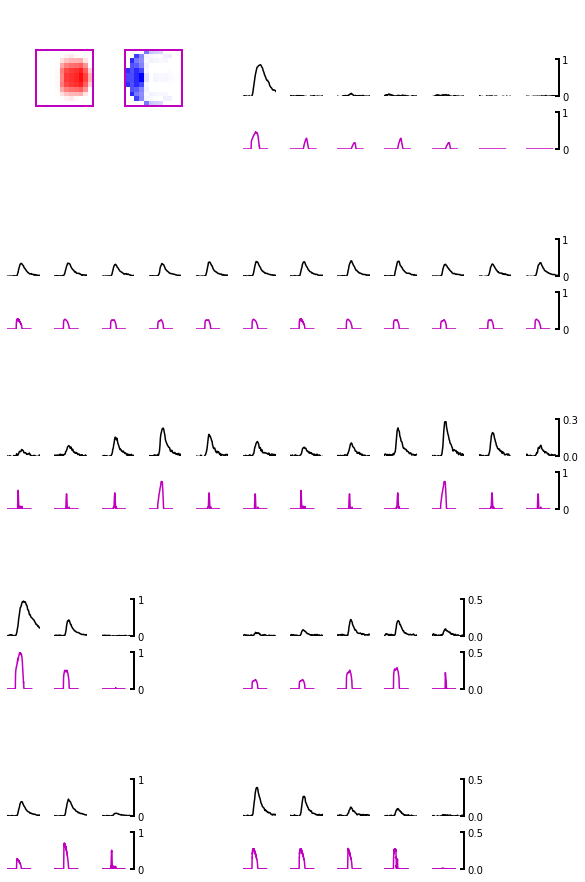

In [201]:
M = 160

figuretypes1 = ['2F', '3e', '3f', '4A', '4C', '4E', '4G']
figuretypes2 = \
[['2Fa', '2Fb', '2Fc', '2Fd', '2Fe', '2Ff', '2Fg'], \
 ['3e1', '3e2', '3e3', '3e4', '3e5', '3e6', '3e7', '3e8', '3e9', '3e10', '3e11', '3e12'], \
 ['3f1', '3f2', '3f3', '3f4', '3f5', '3f6', '3f7', '3f8', '3f9', '3f10', '3f11', '3f12'], \
 ['4Aa', '4Ab', '4Ac'], \
 ['4Ca', '4Cb', '4Cc', '4Cd', '4Ce'], \
 ['4Ea', '4Eb', '4Ec'], \
 ['4Ga', '4Gb', '4Gc', '4Gd', '4Ge']]

ymin = -0.1
ymax_dict = {}
ymax_dict['2F_1'] = 1
ymax_dict['2F_2'] = 1
ymax_dict['3e_1'] = 1
ymax_dict['3e_2'] = 1
ymax_dict['3f_1'] = 0.3
ymax_dict['3f_2'] = 1
ymax_dict['4A_1'] = 1
ymax_dict['4A_2'] = 1
ymax_dict['4C_1'] = 0.5
ymax_dict['4C_2'] = 0.5
ymax_dict['4E_1'] = 1
ymax_dict['4E_2'] = 1
ymax_dict['4G_1'] = 0.5
ymax_dict['4G_2'] = 0.5

line_width = 0.5
label_fontsize = 10
title_fontsize = 10
tick_fontsize = 10

fig = plt.figure(figsize=(10, 16))
gs0 = gridspec.GridSpec(5, 12, figure=fig)

# weights, trained
gs00 = gridspec.GridSpecFromSubplotSpec(13, 13, subplot_spec=gs0[0, 0:5])
axe = fig.add_subplot(gs00[4:9, 1:6])
# model
# saved_results_path = figure_path+'model_clustering/clusterings/'
# model_folders = np.load(saved_results_path+'model_folders_M{}.npy'.format(M), allow_pickle=True)
# model_path = model_folders[0][0]+'/'
model_path = figure_path + 'weights_different_regu/M160/outward/'
K = 12
mask_d = opsg.get_disk_mask(12, 4)
if has_inhibition:
    colormap_e = LinearSegmentedColormap.from_list('wr', ['w', 'r'], N=256)
else:
    colormap_e = LinearSegmentedColormap.from_list('bwr', ['b', 'w', 'r'], N=256)
colormap_i = LinearSegmentedColormap.from_list('wb', ['w', 'b'], N=256)
trained_weights_e = np.load(model_path+'trained_weights_e.npy')
trained_weights_e = trained_weights_e[:, 0].reshape((K, K))
trained_weights_e[mask_d] = 0.
extreme_e = np.round(np.amax(np.abs(trained_weights_e)), 1)
if has_inhibition:
    color_norm_e = mpl.colors.Normalize(vmin=0, vmax=extreme_e)
else:
    color_norm_e = mpl.colors.Normalize(vmin=-extreme_e, vmax=extreme_e)
ime = axe.imshow(trained_weights_e, norm=color_norm_e, cmap=colormap_e)
axe.set_xticks([])
axe.set_yticks([])
plt.setp(axe.spines.values(), color='m', linewidth=2)

if has_inhibition:
    axi = fig.add_subplot(gs00[4:9, 6:11])
    trained_weights_i = np.load(model_path+'trained_weights_i.npy')
    trained_weights_i = trained_weights_i[:, 0].reshape((K, K))
    trained_weights_i[mask_d] = 0.
    extreme_i = np.round(np.amax(np.abs(trained_weights_i)), 1)
    color_norm_i = mpl.colors.Normalize(vmin=0, vmax=extreme_i)
    imi = axi.imshow(trained_weights_i, norm=color_norm_i, cmap=colormap_i)
    axi.set_xticks([])
    axi.set_yticks([])
    plt.setp(axi.spines.values(), color='m', linewidth=2)


# 2F
figuretype = figuretypes1[0]
filename = figure_path+'klap_replication/'+figuretype+'_M{}_2.npz'.format(M)
loaded_file = np.load(filename, allow_pickle=True)
res_rest_all = loaded_file['arr_0']
res_T_all = loaded_file['arr_1']
Ie_T_all = loaded_file['arr_2']
Ii_T_all = loaded_file['arr_3']
Ii_T2_all = loaded_file['arr_4']
N = len(res_T_all)
res_max_2Fa = np.max(res_T_all[0])
res_max_2Fa2 = np.max(Ie_T_all[0]-Ii_T_all[0])
print(res_max_2Fa2)

gs00 = gridspec.GridSpecFromSubplotSpec(3, 7, subplot_spec=gs0[0, 5:12])
for n in range(N):
    # add the stimuli
#     filepath = '/Volumes/Baohua/data_on_hd/loom/Klapoetke_stimuli_L50/Klapoetke_intensities/'+figuretypes1[0]+'/'+'Klapoetke_intensities_'+figuretypes2[0][n]+'.npy'
#     stimuli = np.load(filepath)
    gs000 = gridspec.GridSpecFromSubplotSpec(12, 12, subplot_spec=gs00[0, n])
    ax = fig.add_subplot(gs000[1:11, 1:11])
#     ax.imshow(stimuli[1].reshape((160, 160)), cmap='gray_r')
    ax.set_axis_off()
    
    # load the data
    filepath = figure_path + 'klap_replication/Klapoetke_data/For_loom_paper/klap_'+figuretypes2[0][n]+'.mat'
    klap_2F = loadmat(filepath)
    klap_2F = klap_2F['klap_2F']
    klap_t = klap_2F[0, 0, :]
    klap_res = klap_2F[:, 1, :].mean(axis=0)
    
    gs000 = gridspec.GridSpecFromSubplotSpec(12, 12, subplot_spec=gs00[1, n])
    ax = fig.add_subplot(gs000[1:11, 1:11])
    T = len(res_T_all[n])
    T_vec = np.linspace(0, (T-1)*0.01, T)
    ax.plot(klap_t, klap_res, c='k')
    ax.set_xlim([0, T_vec[-1]+2])
    ax.set_ylim([0, ymax_dict['2F_1']])
    if n != N-1:
        ax.set_axis_off()
    else:
        ax.spines["left"].set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.spines["bottom"].set_linewidth(False)
        ax.spines["right"].set_linewidth(2)
        ax.set_xticks([])
        ax.set_yticks([0, ymax_dict['2F_1']])
        ax.yaxis.tick_right()
        ax.tick_params(direction='in', length=4, width=2, labelsize=tick_fontsize)
    
    gs000 = gridspec.GridSpecFromSubplotSpec(12, 12, subplot_spec=gs00[2, n])
    ax = fig.add_subplot(gs000[1:11, 1:11])
    ax.plot(T_vec, np.maximum(Ie_T_all[n]-Ii_T_all[n], 0), 'm')
    ax.set_xlim([0, T_vec[-1]+2])
    ax.set_ylim([0, ymax_dict['2F_2']])
    if n != N-1:
        ax.set_axis_off()
    else:
        ax.spines["left"].set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.spines["bottom"].set_linewidth(False)
        ax.spines["right"].set_linewidth(2)
        ax.set_xticks([])
        ax.set_yticks([0, ymax_dict['2F_2']])
        ax.yaxis.tick_right()
        ax.tick_params(direction='in', length=4, width=2, labelsize=tick_fontsize)

    
# 3e
figuretype = figuretypes1[1]
filename = figure_path+'klap_replication/'+figuretype+'_M{}_2.npz'.format(M)
loaded_file = np.load(filename, allow_pickle=True)
res_rest_all = loaded_file['arr_0']
res_T_all = loaded_file['arr_1']
Ie_T_all = loaded_file['arr_2']
Ii_T_all = loaded_file['arr_3']
Ii_T2_all = loaded_file['arr_4']
N = len(res_T_all)

gs00 = gridspec.GridSpecFromSubplotSpec(3, 12, subplot_spec=gs0[1, :])
for n in range(N):
    # add the stimuli
#     filepath = '/Volumes/Baohua/data_on_hd/loom/Klapoetke_stimuli_L50/Klapoetke_intensities/'+figuretypes1[1]+'/'+'Klapoetke_intensities_'+figuretypes2[1][n]+'.npy'
#     stimuli = np.load(filepath)
    gs000 = gridspec.GridSpecFromSubplotSpec(12, 12, subplot_spec=gs00[0, n])
    ax = fig.add_subplot(gs000[1:11, 1:11])
#     ax.imshow(stimuli[1].reshape((160, 160)), cmap='gray_r')
    ax.set_axis_off()
    
    # load the data
    filepath = figure_path + 'klap_replication/Klapoetke_data/For_loom_paper/klap_'+figuretypes2[1][n]+'.mat'
    klap_3e = loadmat(filepath)
    klap_3e = klap_3e['klap_3e']
    klap_t = klap_3e[0, 0, :]
    klap_res = klap_3e[:, 1, :].mean(axis=0)
    
    gs000 = gridspec.GridSpecFromSubplotSpec(12, 12, subplot_spec=gs00[1, n])
    ax = fig.add_subplot(gs000[1:11, 1:11])
    T = len(res_T_all[n])
    T_vec = np.linspace(0, (T-1)*0.01, T)
    ax.plot(klap_t, klap_res, c='k')    
    ax.set_xlim([0, T_vec[-1]+2])
    ax.set_ylim([0, ymax_dict['3e_1']])
    if n != N-1:
        ax.set_axis_off()
    else:
        ax.spines["left"].set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.spines["bottom"].set_linewidth(False)
        ax.spines["right"].set_linewidth(2)
        ax.set_xticks([])
        ax.set_yticks([0, ymax_dict['3e_1']])
        ax.yaxis.tick_right()
        ax.tick_params(direction='in', length=4, width=2, labelsize=tick_fontsize)
    
    gs000 = gridspec.GridSpecFromSubplotSpec(12, 12, subplot_spec=gs00[2, n])
    ax = fig.add_subplot(gs000[1:11, 1:11])
    ax.plot(T_vec, np.maximum(Ie_T_all[n]-Ii_T_all[n], 0)/res_max_2Fa2, 'm')
    ax.set_xlim([0, T_vec[-1]+2])
    ax.set_ylim([0, ymax_dict['3e_2']])
    if n != N-1:
        ax.set_axis_off()
    else:
        ax.spines["left"].set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.spines["bottom"].set_linewidth(False)
        ax.spines["right"].set_linewidth(2)
        ax.set_xticks([])
        ax.set_yticks([0, ymax_dict['3e_2']])
        ax.yaxis.tick_right()
        ax.tick_params(direction='in', length=4, width=2, labelsize=tick_fontsize)
    

# 3f
figuretype = figuretypes1[2]
filename = figure_path+'klap_replication/'+figuretype+'_M{}_2.npz'.format(M)
loaded_file = np.load(filename, allow_pickle=True)
res_rest_all = loaded_file['arr_0']
res_T_all = loaded_file['arr_1']
Ie_T_all = loaded_file['arr_2']
Ii_T_all = loaded_file['arr_3']
Ii_T2_all = loaded_file['arr_4']
N = len(res_T_all)

gs00 = gridspec.GridSpecFromSubplotSpec(3, 12, subplot_spec=gs0[2, :])
for n in range(N):
    # add the stimuli
#     filepath = '/Volumes/Baohua/data_on_hd/loom/Klapoetke_stimuli_L50/Klapoetke_intensities/'+figuretypes1[2]+'/'+'Klapoetke_intensities_'+figuretypes2[2][n]+'.npy'
#     stimuli = np.load(filepath)
    gs000 = gridspec.GridSpecFromSubplotSpec(12, 12, subplot_spec=gs00[0, n])
    ax = fig.add_subplot(gs000[1:11, 1:11])
#     ax.imshow(stimuli[1].reshape((160, 160)), cmap='gray_r')
    ax.set_axis_off()
    
    # load the data
    filepath = figure_path + 'klap_replication/Klapoetke_data/For_loom_paper/klap_'+figuretypes2[2][n]+'.mat'
    klap_3f = loadmat(filepath)
    klap_3f = klap_3f['klap_3f']
    klap_t = klap_3f[0, 0, :]
    klap_res = klap_3f[:, 1, :].mean(axis=0)
    
    gs000 = gridspec.GridSpecFromSubplotSpec(12, 12, subplot_spec=gs00[1, n])
    ax = fig.add_subplot(gs000[1:11, 1:11])
    T = len(res_T_all[n])
    T_vec = np.linspace(0, (T-1)*0.01, T)
    ax.plot(klap_t, klap_res, c='k')    
    ax.set_xlim([0, T_vec[-1]+2])
    ax.set_ylim([0, ymax_dict['3f_1']])
    if n != N-1:
        ax.set_axis_off()
    else:
        ax.spines["left"].set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.spines["bottom"].set_linewidth(False)
        ax.spines["right"].set_linewidth(2)
        ax.set_xticks([])
        ax.set_yticks([0, ymax_dict['3f_1']])
        ax.yaxis.tick_right()
        ax.tick_params(direction='in', length=4, width=2, labelsize=tick_fontsize)
    
    gs000 = gridspec.GridSpecFromSubplotSpec(12, 12, subplot_spec=gs00[2, n])
    ax = fig.add_subplot(gs000[1:11, 1:11])
    ax.plot(T_vec, np.maximum(Ie_T_all[n]-Ii_T_all[n], 0)/res_max_2Fa2, 'm')
    ax.set_xlim([0, T_vec[-1]+2])
    ax.set_ylim([0, ymax_dict['3f_2']])
    if n != N-1:
        ax.set_axis_off()
    else:
        ax.spines["left"].set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.spines["bottom"].set_linewidth(False)
        ax.spines["right"].set_linewidth(2)
        ax.set_xticks([])
        ax.set_yticks([0, ymax_dict['3f_2']])
        ax.yaxis.tick_right()
        ax.tick_params(direction='in', length=4, width=2, labelsize=tick_fontsize)
    
    
# 4A & C
gs00 = gridspec.GridSpecFromSubplotSpec(3, 12, subplot_spec=gs0[3, :])

figuretype = figuretypes1[3]
filename = figure_path+'klap_replication/'+figuretype+'_M{}_2.npz'.format(M)
loaded_file = np.load(filename, allow_pickle=True)
res_rest_all = loaded_file['arr_0']
res_T_all = loaded_file['arr_1']
Ie_T_all = loaded_file['arr_2']
Ii_T_all = loaded_file['arr_3']
Ii_T2_all = loaded_file['arr_4']
N = len(res_T_all)

for n in range(N):
    # add the stimuli
#     filepath = '/Volumes/Baohua/data_on_hd/loom/Klapoetke_stimuli_L50/Klapoetke_intensities/'+figuretypes1[3]+'/'+'Klapoetke_intensities_'+figuretypes2[3][n]+'.npy'
#     stimuli = np.load(filepath)
    gs000 = gridspec.GridSpecFromSubplotSpec(12, 12, subplot_spec=gs00[0, n])
    ax = fig.add_subplot(gs000[1:11, 1:11])
#     ax.imshow(stimuli[0].reshape((160, 160)), cmap='gray_r')
    ax.set_axis_off()
    
    # load the data
    filepath = figure_path + 'klap_replication/Klapoetke_data/For_loom_paper/klap_'+figuretypes2[3][n]+'.mat'
    klap_4A = loadmat(filepath)
    klap_4A = klap_4A['klap_4A']
    klap_t = klap_4A[0, 0, :]
    klap_res = klap_4A[:, 1, :].mean(axis=0)
    
    gs000 = gridspec.GridSpecFromSubplotSpec(12, 12, subplot_spec=gs00[1, n])
    ax = fig.add_subplot(gs000[1:11, 1:11])
    T = len(res_T_all[n])
    T_vec = np.linspace(0, (T-1)*0.01, T)
    ax.plot(klap_t, klap_res, c='k')    
    ax.set_xlim([0, T_vec[-1]+2])
    ax.set_ylim([0, ymax_dict['4A_1']])
    if n != N-1:
        ax.set_axis_off()
    else:
        ax.spines["left"].set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.spines["bottom"].set_linewidth(False)
        ax.spines["right"].set_linewidth(2)
        ax.set_xticks([])
        ax.set_yticks([0, ymax_dict['4A_1']])
        ax.yaxis.tick_right()
        ax.tick_params(direction='in', length=4, width=2, labelsize=tick_fontsize)
    
    gs000 = gridspec.GridSpecFromSubplotSpec(12, 12, subplot_spec=gs00[2, n])
    ax = fig.add_subplot(gs000[1:11, 1:11])
    ax.plot(T_vec, np.maximum(Ie_T_all[n]-Ii_T_all[n], 0)/res_max_2Fa2, 'm')
    ax.set_xlim([0, T_vec[-1]+2])
    ax.set_ylim([0, ymax_dict['4A_2']])
    if n != N-1:
        ax.set_axis_off()
    else:
        ax.spines["left"].set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.spines["bottom"].set_linewidth(False)
        ax.spines["right"].set_linewidth(2)
        ax.set_xticks([])
        ax.set_yticks([0, ymax_dict['4A_2']])
        ax.yaxis.tick_right()
        ax.tick_params(direction='in', length=4, width=2, labelsize=tick_fontsize)
        
    
figuretype = figuretypes1[4]
filename = figure_path+'klap_replication/'+figuretype+'_M{}_2.npz'.format(M)
loaded_file = np.load(filename, allow_pickle=True)
res_rest_all = loaded_file['arr_0']
res_T_all = loaded_file['arr_1']
Ie_T_all = loaded_file['arr_2']
Ii_T_all = loaded_file['arr_3']
Ii_T2_all = loaded_file['arr_4']
N = len(res_T_all)

for n in range(N):
    # add the stimuli
#     filepath = '/Volumes/Baohua/data_on_hd/loom/Klapoetke_stimuli_L50/Klapoetke_intensities/'+figuretypes1[4]+'/'+'Klapoetke_intensities_'+figuretypes2[4][n]+'.npy'
#     stimuli = np.load(filepath)
    gs000 = gridspec.GridSpecFromSubplotSpec(12, 12, subplot_spec=gs00[0, n+5])
    ax = fig.add_subplot(gs000[1:11, 1:11])
#     ax.imshow(stimuli[1].reshape((160, 160)), cmap='gray_r')
    ax.set_axis_off()
    
    # load the data
    filepath = figure_path + 'klap_replication/Klapoetke_data/For_loom_paper/klap_'+figuretypes2[4][n]+'.mat'
    klap_4C = loadmat(filepath)
    klap_4C = klap_4C['klap_4C']
    klap_t = klap_4C[0, 0, :]
    klap_res = klap_4C[:, 1, :].mean(axis=0)
    
    gs000 = gridspec.GridSpecFromSubplotSpec(12, 12, subplot_spec=gs00[1, n+5])
    ax = fig.add_subplot(gs000[1:11, 1:11])
    T = len(res_T_all[n])
    T_vec = np.linspace(0, (T-1)*0.01, T)
    ax.plot(klap_t, klap_res, c='k')    
    ax.set_xlim([0, T_vec[-1]+2])
    ax.set_ylim([0, ymax_dict['4C_1']])
    if n != N-1:
        ax.set_axis_off()
    else:
        ax.spines["left"].set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.spines["bottom"].set_linewidth(False)
        ax.spines["right"].set_linewidth(2)
        ax.set_xticks([])
        ax.set_yticks([0, ymax_dict['4C_1']])
        ax.yaxis.tick_right()
        ax.tick_params(direction='in', length=4, width=2, labelsize=tick_fontsize)
    
    gs000 = gridspec.GridSpecFromSubplotSpec(12, 12, subplot_spec=gs00[2, n+5])
    ax = fig.add_subplot(gs000[1:11, 1:11])
    ax.plot(T_vec, np.maximum(Ie_T_all[n]-Ii_T_all[n], 0)/res_max_2Fa2, 'm')
    ax.set_xlim([0, T_vec[-1]+2])
    ax.set_ylim([0, ymax_dict['4C_2']])
    if n != N-1:
        ax.set_axis_off()
    else:
        ax.spines["left"].set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.spines["bottom"].set_linewidth(False)
        ax.spines["right"].set_linewidth(2)
        ax.set_xticks([])
        ax.set_yticks([0, ymax_dict['4C_2']])
        ax.yaxis.tick_right()
        ax.tick_params(direction='in', length=4, width=2, labelsize=tick_fontsize)
    
    
# 4E & G
gs00 = gridspec.GridSpecFromSubplotSpec(3, 12, subplot_spec=gs0[4, :])

figuretype = figuretypes1[5]
filename = figure_path+'klap_replication/'+figuretype+'_M{}_2.npz'.format(M)
loaded_file = np.load(filename, allow_pickle=True)
res_rest_all = loaded_file['arr_0']
res_T_all = loaded_file['arr_1']
Ie_T_all = loaded_file['arr_2']
Ii_T_all = loaded_file['arr_3']
Ii_T2_all = loaded_file['arr_4']
N = len(res_T_all)

for n in range(N):
    # add the stimuli
#     filepath = '/Volumes/Baohua/data_on_hd/loom/Klapoetke_stimuli_L50/Klapoetke_intensities/'+figuretypes1[5]+'/'+'Klapoetke_intensities_'+figuretypes2[5][n]+'.npy'
#     stimuli = np.load(filepath)
    gs000 = gridspec.GridSpecFromSubplotSpec(12, 12, subplot_spec=gs00[0, n])
    ax = fig.add_subplot(gs000[1:11, 1:11])
#     ax.imshow(stimuli[1].reshape((160, 160)), cmap='gray_r')
    ax.set_axis_off()
    
    # load the data
    filepath = figure_path + 'klap_replication/Klapoetke_data/For_loom_paper/klap_'+figuretypes2[5][n]+'.mat'
    klap_4E = loadmat(filepath)
    klap_4E = klap_4E['klap_4E']
    klap_t = klap_4E[0, 0, :]
    klap_res = klap_4E[:, 1, :].mean(axis=0)
    
    gs000 = gridspec.GridSpecFromSubplotSpec(12, 12, subplot_spec=gs00[1, n])
    ax = fig.add_subplot(gs000[1:11, 1:11])
    T = len(res_T_all[n])
    T_vec = np.linspace(0, (T-1)*0.01, T)
    ax.plot(klap_t, klap_res, c='k')    
    ax.set_xlim([0, T_vec[-1]+2])
    ax.set_ylim([0, ymax_dict['4E_1']])
    if n != N-1:
        ax.set_axis_off()
    else:
        ax.spines["left"].set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.spines["bottom"].set_linewidth(False)
        ax.spines["right"].set_linewidth(2)
        ax.set_xticks([])
        ax.set_yticks([0, ymax_dict['4E_1']])
        ax.yaxis.tick_right()
        ax.tick_params(direction='in', length=4, width=2, labelsize=tick_fontsize)
    
    gs000 = gridspec.GridSpecFromSubplotSpec(12, 12, subplot_spec=gs00[2, n])
    ax = fig.add_subplot(gs000[1:11, 1:11])
    ax.plot(T_vec, np.maximum(Ie_T_all[n]-Ii_T_all[n], 0)/res_max_2Fa2, 'm')
    ax.set_xlim([0, T_vec[-1]+2])
    ax.set_ylim([0, ymax_dict['4E_2']])
    if n != N-1:
        ax.set_axis_off()
    else:
        ax.spines["left"].set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.spines["bottom"].set_linewidth(False)
        ax.spines["right"].set_linewidth(2)
        ax.set_xticks([])
        ax.set_yticks([0, ymax_dict['4E_2']])
        ax.yaxis.tick_right()
        ax.tick_params(direction='in', length=4, width=2, labelsize=tick_fontsize)
        
    
figuretype = figuretypes1[6]
filename = figure_path+'klap_replication/'+figuretype+'_M{}_2.npz'.format(M)
loaded_file = np.load(filename, allow_pickle=True)
res_rest_all = loaded_file['arr_0']
res_T_all = loaded_file['arr_1']
Ie_T_all = loaded_file['arr_2']
Ii_T_all = loaded_file['arr_3']
Ii_T2_all = loaded_file['arr_4']
N = len(res_T_all)

for n in range(N):
    # add the stimuli
#     filepath = '/Volumes/Baohua/data_on_hd/loom/Klapoetke_stimuli_L50/Klapoetke_intensities/'+figuretypes1[6]+'/'+'Klapoetke_intensities_'+figuretypes2[6][n]+'.npy'
#     stimuli = np.load(filepath)
    gs000 = gridspec.GridSpecFromSubplotSpec(12, 12, subplot_spec=gs00[0, n+5])
    ax = fig.add_subplot(gs000[1:11, 1:11])
#     ax.imshow(stimuli[1].reshape((160, 160)), cmap='gray_r')
    ax.set_axis_off()
    
    # load the data
    filepath = figure_path + 'klap_replication/Klapoetke_data/For_loom_paper/klap_'+figuretypes2[6][n]+'.mat'
    klap_4G = loadmat(filepath)
    klap_4G = klap_4G['klap_4G']
    klap_t = klap_4G[0, 0, :]
    klap_res = klap_4G[:, 1, :].mean(axis=0)
    
    gs000 = gridspec.GridSpecFromSubplotSpec(12, 12, subplot_spec=gs00[1, n+5])
    ax = fig.add_subplot(gs000[1:11, 1:11])
    T = len(res_T_all[n])
    T_vec = np.linspace(0, (T-1)*0.01, T)
    ax.plot(klap_t, klap_res, c='k')    
    ax.set_xlim([0, T_vec[-1]+2])
    ax.set_ylim([0, ymax_dict['4G_1']])
    if n != N-1:
        ax.set_axis_off()
    else:
        ax.spines["left"].set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.spines["bottom"].set_linewidth(False)
        ax.spines["right"].set_linewidth(2)
        ax.set_xticks([])
        ax.set_yticks([0, ymax_dict['4G_1']])
        ax.yaxis.tick_right()
        ax.tick_params(direction='in', length=4, width=2, labelsize=tick_fontsize)
    
    gs000 = gridspec.GridSpecFromSubplotSpec(12, 12, subplot_spec=gs00[2, n+5])
    ax = fig.add_subplot(gs000[1:11, 1:11])
    ax.plot(T_vec, np.maximum(Ie_T_all[n]-Ii_T_all[n], 0)/res_max_2Fa2, 'm')
    ax.set_xlim([0, T_vec[-1]+2])
    ax.set_ylim([0, ymax_dict['4G_2']])
    if n != N-1:
        ax.set_axis_off()
    else:
        ax.spines["left"].set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.spines["bottom"].set_linewidth(False)
        ax.spines["right"].set_linewidth(2)
        ax.set_xticks([])
        ax.set_yticks([0, ymax_dict['4G_2']])
        ax.yaxis.tick_right()
        ax.tick_params(direction='in', length=4, width=2, labelsize=tick_fontsize)
        
filename = figure_path+'figures_supp/replication_sup_M160.pdf'.format(M)
fig.savefig(filename, bbox_inches='tight')
# fig.savefig(filename)



In [55]:
# Tuning and linear law

R = 1
data_type = 'hit'
R_over_v_list = [0.01, 0.02, 0.04, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2]
save_path = '/Volumes/Baohua/data_on_hd/loom/linear_law_exp/'+data_type+'/'
offset = 1

theta_b_list_M1 = []
theta_b_list_M256 = []
theta_b_dot_list_M1 = []
theta_b_dot_list_M256 = []
hrc_output_sum_list_M1 = []
hrc_output_sum_list_M256 = []
distance_list_M1 = []
distance_list_M256 = []
for R_over_v in R_over_v_list:
    distance_1 = np.load(save_path+f'distance_{R_over_v}_M{1}.npy')
    distance_256 = np.load(save_path+f'distance_{R_over_v}_M{256}.npy')
    UV_flow_sample_1 = np.load(save_path+f'UV_flow_sample_{R_over_v}_M{1}.npy', allow_pickle=True)
    UV_flow_sample_256 = np.load(save_path+f'UV_flow_sample_{R_over_v}_M{256}.npy', allow_pickle=True)
    theta_b_1 = 2 * np.arcsin(R/distance_1[offset:])*180/np.pi
    theta_b_dot_1 = 2 * np.divide(R/(np.sqrt(distance_1[offset:]**2-R**2))*(R/R_over_v)*180/np.pi, distance_1[offset:])
    theta_b_256 = 2 * np.arcsin(R/distance_256[offset:])*180/np.pi
    theta_b_dot_256 = 2 * np.divide(R/(np.sqrt(distance_256[offset:]**2-R**2))*(R/R_over_v)*180/np.pi, distance_256[offset:])
    
    theta_b_list_M1.append(theta_b_1)
    theta_b_dot_list_M1.append(theta_b_dot_1)
    distance_list_M1.append(distance_1)
    
    flow_T = []
    for step in range(len(UV_flow_sample_1)):
        flow_tem = 0
        for m in range(1):
            flow_tem = flow_tem + UV_flow_sample_1[step][m].sum()
        flow_T.append(flow_tem)
    hrc_output_sum_list_M1.append(np.array(flow_T))
    
    theta_b_list_M256.append(theta_b_256)
    theta_b_dot_list_M256.append(theta_b_dot_256)
    distance_list_M256.append(distance_256)
    
    flow_T = []
    for step in range(len(UV_flow_sample_256)):
        flow_tem = 0
        for m in range(256):
            flow_tem = flow_tem + UV_flow_sample_256[step][m].sum()
        flow_T.append(flow_tem)
    hrc_output_sum_list_M256.append(np.array(flow_T))
    
    print(len(theta_b_256), len(flow_T))
    

90 90
181 181
363 363
726 726
908 908
1090 1090
1272 1272
1455 1455
1637 1637
1818 1818


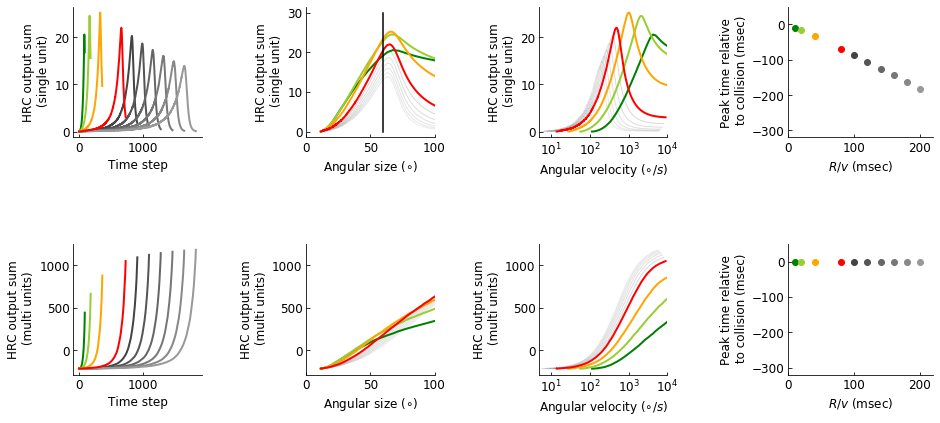

In [56]:
# green, yellow green, orange, red
color_list_data = [[0/255., 128/255., 0/255.], \
                   [154/255., 205/255., 50/255.], \
                   [255/255., 165/255., 0], \
                   [255/255., 0, 0]]
color_list = []
for ind, R_over_v in enumerate(R_over_v_list):
    if R_over_v == 0.01:
        color_list.append(color_list_data[0])
    elif R_over_v == 0.02:
        color_list.append(color_list_data[1])
    elif R_over_v == 0.04:
        color_list.append(color_list_data[2])
    elif R_over_v == 0.08:
        color_list.append(color_list_data[3])
    else:
        val = 1. / (len(R_over_v_list) + 5) * ind
        color_list.append([val, val, val])

line_width = 2
label_fontsize = 12
tick_fontsize = 12

fig = plt.figure(figsize=(16, 8))
gs0 = gridspec.GridSpec(2, 4, figure=fig)

# M = 1
# sum of hrc output against time
gs00 = gridspec.GridSpecFromSubplotSpec(12, 12, subplot_spec=gs0[0, 0])
ax = fig.add_subplot(gs00[2:10, 2:10])
for ii in range(len(R_over_v_list)):
    if R_over_v_list[ii] not in [0.01, 0.02, 0.04, 0.08]:
        ax.plot(hrc_output_sum_list_M1[ii], c=color_list[ii], linewidth=line_width, alpha=1)
for ii in range(len(R_over_v_list)):
    if R_over_v_list[ii] == 0.01:
        ax.plot(hrc_output_sum_list_M1[ii], c=color_list_data[0], linewidth=line_width)
    elif R_over_v_list[ii] == 0.02:
        ax.plot(hrc_output_sum_list_M1[ii], c=color_list_data[1], linewidth=line_width)
    elif R_over_v_list[ii] == 0.04:
        ax.plot(hrc_output_sum_list_M1[ii], c=color_list_data[2], linewidth=line_width)
    elif R_over_v_list[ii] == 0.08:
        ax.plot(hrc_output_sum_list_M1[ii], c=color_list_data[3], linewidth=line_width)
# ax.set_ylim([0, 30])
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(True)
ax.spines["left"].set_visible(True) 
ax.set_xlabel('Time step', fontsize=label_fontsize)
ax.set_ylabel('HRC output sum\n (single unit)', fontsize=label_fontsize)
ax.tick_params(direction='in', labelsize=tick_fontsize)

# sum of hrc output against angular size
gs00 = gridspec.GridSpecFromSubplotSpec(12, 12, subplot_spec=gs0[0, 1])
ax = fig.add_subplot(gs00[2:10, 2:10])
for ii in range(len(R_over_v_list)):
    if R_over_v_list[ii] not in [0.01, 0.02, 0.04, 0.08]:
        ax.plot(theta_b_list_M1[ii], hrc_output_sum_list_M1[ii], c=color_list[ii], linewidth=0.5*line_width, alpha=0.2)
for ii in range(len(R_over_v_list)):
    if R_over_v_list[ii] == 0.01:
        ax.plot(theta_b_list_M1[ii], hrc_output_sum_list_M1[ii], c=color_list_data[0], linewidth=line_width)
    elif R_over_v_list[ii] == 0.02:
        ax.plot(theta_b_list_M1[ii], hrc_output_sum_list_M1[ii], c=color_list_data[1], linewidth=line_width)
    elif R_over_v_list[ii] == 0.04:
        ax.plot(theta_b_list_M1[ii], hrc_output_sum_list_M1[ii], c=color_list_data[2], linewidth=line_width)
    elif R_over_v_list[ii] == 0.08:
        ax.plot(theta_b_list_M1[ii], hrc_output_sum_list_M1[ii], c=color_list_data[3], linewidth=line_width)
ax.plot([60, 60], [0, 30], 'k')
ax.set_xlim([0, 100])
# ax.set_ylim([0, 30])
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(True)
ax.spines["left"].set_visible(True) 
ax.set_xlabel(r'Angular size ($\circ$)', fontsize=label_fontsize)
ax.set_ylabel('HRC output sum\n (single unit)', fontsize=label_fontsize)
ax.tick_params(direction='in', labelsize=tick_fontsize)

# sum of hrc output against angular velocity
gs00 = gridspec.GridSpecFromSubplotSpec(12, 12, subplot_spec=gs0[0, 2])
ax = fig.add_subplot(gs00[2:10, 2:10])
for ii in range(len(R_over_v_list)):
    if R_over_v_list[ii] not in [0.01, 0.02, 0.04, 0.08]:
        ax.plot(theta_b_dot_list_M1[ii], hrc_output_sum_list_M1[ii], c=color_list[ii], linewidth=0.5*line_width, alpha=0.2)
for ii in range(len(R_over_v_list)):
    if R_over_v_list[ii] == 0.01:
        ax.plot(theta_b_dot_list_M1[ii], hrc_output_sum_list_M1[ii], c=color_list_data[0], linewidth=line_width)
    elif R_over_v_list[ii] == 0.02:
        ax.plot(theta_b_dot_list_M1[ii], hrc_output_sum_list_M1[ii], c=color_list_data[1], linewidth=line_width)
    elif R_over_v_list[ii] == 0.04:
        ax.plot(theta_b_dot_list_M1[ii], hrc_output_sum_list_M1[ii], c=color_list_data[2], linewidth=line_width)
    elif R_over_v_list[ii] == 0.08:
        ax.plot(theta_b_dot_list_M1[ii], hrc_output_sum_list_M1[ii], c=color_list_data[3], linewidth=line_width)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(True)
ax.spines["left"].set_visible(True) 
ax.set_xscale('log')
ax.set_xlabel(r'Angular velocity ($\circ/s$)', fontsize=label_fontsize)
ax.set_ylabel('HRC output sum\n (single unit)', fontsize=label_fontsize)
ax.set_xlim([5, 10000])
# ax.set_ylim([0, 30])
ax.tick_params(direction='in', labelsize=tick_fontsize)
ax.get_xaxis().set_tick_params(which='minor', size=0)
ax.get_xaxis().set_tick_params(which='minor', width=0) 
ax.get_yaxis().set_tick_params(which='minor', size=0)
ax.get_yaxis().set_tick_params(which='minor', width=0) 
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.set_xticks([10, 100, 1000, 10000])
ax.set_xticklabels([r'$10^{1}$', r'$10^{2}$', r'$10^{3}$', r'$10^{4}$'])

# linear law
gs00 = gridspec.GridSpecFromSubplotSpec(12, 12, subplot_spec=gs0[0, 3])
ax = fig.add_subplot(gs00[2:10, 3:12])
for ii in range(len(R_over_v_list)):
    ind = np.argmax(hrc_output_sum_list_M1[ii])
    R_over_v = R_over_v_list[ii]*1000
    ax.plot(R_over_v, -(distance_list_M1[ii][ind]-1)*R_over_v, c=color_list[ii], marker='o')
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(True)
ax.spines["left"].set_visible(True) 
ax.set_xlabel(r'$R/v$ (msec)', fontsize=label_fontsize)
ax.set_ylabel('Peak time relative\n to collision (msec)', fontsize=label_fontsize)
ax.set_xlim([0, 220])
ax.set_ylim([-320, 50])
ax.tick_params(direction='in', labelsize=tick_fontsize)

# M = 256
# sum of hrc output against time
gs00 = gridspec.GridSpecFromSubplotSpec(12, 12, subplot_spec=gs0[1, 0])
ax = fig.add_subplot(gs00[2:10, 2:10])
for ii in range(len(R_over_v_list)):
    if R_over_v_list[ii] not in [0.01, 0.02, 0.04, 0.08]:
        ax.plot(hrc_output_sum_list_M256[ii], c=color_list[ii], linewidth=line_width, alpha=1)
for ii in range(len(R_over_v_list)):
    if R_over_v_list[ii] == 0.01:
        ax.plot(hrc_output_sum_list_M256[ii], c=color_list_data[0], linewidth=line_width)
    elif R_over_v_list[ii] == 0.02:
        ax.plot(hrc_output_sum_list_M256[ii], c=color_list_data[1], linewidth=line_width)
    elif R_over_v_list[ii] == 0.04:
        ax.plot(hrc_output_sum_list_M256[ii], c=color_list_data[2], linewidth=line_width)
    elif R_over_v_list[ii] == 0.08:
        ax.plot(hrc_output_sum_list_M256[ii], c=color_list_data[3], linewidth=line_width)
# ax.set_ylim([0, 30])
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(True)
ax.spines["left"].set_visible(True) 
ax.set_xlabel('Time step', fontsize=label_fontsize)
ax.set_ylabel('HRC output sum\n (multi units)', fontsize=label_fontsize)
ax.tick_params(direction='in', labelsize=tick_fontsize)

# sum of hrc output against angular size
gs00 = gridspec.GridSpecFromSubplotSpec(12, 12, subplot_spec=gs0[1, 1])
ax = fig.add_subplot(gs00[2:10, 2:10])
for ii in range(len(R_over_v_list)):
    if R_over_v_list[ii] not in [0.01, 0.02, 0.04, 0.08]:
        ax.plot(theta_b_list_M256[ii], hrc_output_sum_list_M256[ii], c=color_list[ii], linewidth=0.5*line_width, alpha=0.2)
for ii in range(len(R_over_v_list)):
    if R_over_v_list[ii] == 0.01:
        ax.plot(theta_b_list_M256[ii], hrc_output_sum_list_M256[ii], c=color_list_data[0], linewidth=line_width)
    elif R_over_v_list[ii] == 0.02:
        ax.plot(theta_b_list_M256[ii], hrc_output_sum_list_M256[ii], c=color_list_data[1], linewidth=line_width)
    elif R_over_v_list[ii] == 0.04:
        ax.plot(theta_b_list_M256[ii], hrc_output_sum_list_M256[ii], c=color_list_data[2], linewidth=line_width)
    elif R_over_v_list[ii] == 0.08:
        ax.plot(theta_b_list_M256[ii], hrc_output_sum_list_M256[ii], c=color_list_data[3], linewidth=line_width)
ax.set_xlim([0, 100])
# ax.set_ylim([0, 30])
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(True)
ax.spines["left"].set_visible(True) 
ax.set_xlabel(r'Angular size ($\circ$)', fontsize=label_fontsize)
ax.set_ylabel('HRC output sum\n (multi units)', fontsize=label_fontsize)
ax.tick_params(direction='in', labelsize=tick_fontsize)

# sum of hrc output against angular velocity
gs00 = gridspec.GridSpecFromSubplotSpec(12, 12, subplot_spec=gs0[1, 2])
ax = fig.add_subplot(gs00[2:10, 2:10])
for ii in range(len(R_over_v_list)):
    if R_over_v_list[ii] not in [0.01, 0.02, 0.04, 0.08]:
        ax.plot(theta_b_dot_list_M256[ii], hrc_output_sum_list_M256[ii], c=color_list[ii], linewidth=0.5*line_width, alpha=0.2)
for ii in range(len(R_over_v_list)):
    if R_over_v_list[ii] == 0.01:
        ax.plot(theta_b_dot_list_M256[ii], hrc_output_sum_list_M256[ii], c=color_list_data[0], linewidth=line_width)
    elif R_over_v_list[ii] == 0.02:
        ax.plot(theta_b_dot_list_M256[ii], hrc_output_sum_list_M256[ii], c=color_list_data[1], linewidth=line_width)
    elif R_over_v_list[ii] == 0.04:
        ax.plot(theta_b_dot_list_M256[ii], hrc_output_sum_list_M256[ii], c=color_list_data[2], linewidth=line_width)
    elif R_over_v_list[ii] == 0.08:
        ax.plot(theta_b_dot_list_M256[ii], hrc_output_sum_list_M256[ii], c=color_list_data[3], linewidth=line_width)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(True)
ax.spines["left"].set_visible(True) 
ax.set_xscale('log')
ax.set_xlabel(r'Angular velocity ($\circ/s$)', fontsize=label_fontsize)
ax.set_ylabel('HRC output sum\n (multi units)', fontsize=label_fontsize)
ax.set_xlim([5, 10000])
# ax.set_ylim([0, 30])
ax.tick_params(direction='in', labelsize=tick_fontsize)
ax.get_xaxis().set_tick_params(which='minor', size=0)
ax.get_xaxis().set_tick_params(which='minor', width=0) 
ax.get_yaxis().set_tick_params(which='minor', size=0)
ax.get_yaxis().set_tick_params(which='minor', width=0) 
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.set_xticks([10, 100, 1000, 10000])
ax.set_xticklabels([r'$10^{1}$', r'$10^{2}$', r'$10^{3}$', r'$10^{4}$'])

# linear law
gs00 = gridspec.GridSpecFromSubplotSpec(12, 12, subplot_spec=gs0[1, 3])
ax = fig.add_subplot(gs00[2:10, 3:12])
for ii in range(len(R_over_v_list)):
    ind = np.argmax(hrc_output_sum_list_M256[ii])
    R_over_v = R_over_v_list[ii]*1000
    ax.plot(R_over_v, -(distance_list_M256[ii][ind]-1)*R_over_v, c=color_list[ii], marker='o')
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(True)
ax.spines["left"].set_visible(True) 
ax.set_xlabel(r'$R/v$ (msec)', fontsize=label_fontsize)
ax.set_ylabel('Peak time relative\n to collision (msec)', fontsize=label_fontsize)
ax.set_xlim([0, 220])
ax.set_ylim([-320, 50])
ax.tick_params(direction='in', labelsize=tick_fontsize)

plt.show()

filename = figure_path+'figures_supp/replication_sup_HRC_exp.pdf'
fig.savefig(filename, bbox_inches='tight')

# Method

In [264]:
%matplotlib widget

importlib.reload(opsg)
importlib.reload(hpfn)

# Here we want to change the label of axis: x vertical, z to the right, 
# and y should choose the direction that completes a right coordiantes.

M = 256
N = 12*10
lplc2_units = opsg.get_lplc2_units_xy_angles(M)
_, lplc2_units_coords = opsg.get_lplc2_units(M)

pos_x = np.array([[0.2, 0, 0]])
pos_y = np.array([[0, 0.2, 0]])
pos_z = np.array([[0, 0, 0.2]])
pos_rots_x = []
pos_rots_y = []
pos_rots_z = []
for m in range(M):
    angle = lplc2_units[m]
    pos_rot_x = opsg.get_rotated_axes(angle, pos_x)
    pos_rot_y = opsg.get_rotated_axes(angle, pos_y, rev=True)
    pos_rot_z = opsg.get_rotated_axes(angle, pos_z)
    pos_rots_x.append(pos_rot_x[0])
    pos_rots_y.append(pos_rot_y[0])
    pos_rots_z.append(pos_rot_z[0])
pos_rots_x = np.array(pos_rots_x)
pos_rots_y = np.array(pos_rots_y)
pos_rots_z = np.array(pos_rots_z)

_, lplc2_units_coords = opsg.get_lplc2_units(M)
print(lplc2_units_coords.shape)
view_angle = np.array([1.5, 1, 1])

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, projection='3d')

# global coordinate, 
ax.quiver([0], [0], [0], [0], [0], [1.2], length=2, arrow_length_ratio = 0.1, color='k')
ax.quiver([0], [0], [0], [0], [1.2], [0], length=2, arrow_length_ratio = 0.1, color=[0.5, 0.5, 0.5])
ax.quiver([0], [0], [0], [1.2], [0], [0], length=2, arrow_length_ratio = 0.1, color='r')

# centers of the lplc2 units
for m in range(M):
    coord_m = lplc2_units_coords[m]
    angle = opsg.get_angle_two_vectors(view_angle, coord_m)
    if angle < np.pi/2.:
        ax.scatter(lplc2_units_coords[m, 2], lplc2_units_coords[m, 1], lplc2_units_coords[m, 0], s=4, c='r')
#         ax.plot([0, lplc2_units_coords[m, 2]], [0, lplc2_units_coords[m, 1]], [0, lplc2_units_coords[m, 0]], c='r', linestyle='-', linewidth=0.5, alpha=0.3)
    else:
        ax.scatter(lplc2_units_coords[m, 2], lplc2_units_coords[m, 1], lplc2_units_coords[m, 0], s=4, c='r', alpha=0.)
#         ax.plot([0, lplc2_units_coords[m, 2]], [0, lplc2_units_coords[m, 1]], [0, lplc2_units_coords[m, 0]], c='r', linestyle='-', linewidth=0.5, alpha=0.1)
    if m == 70:
        ax.scatter(lplc2_units_coords[m, 2]+0.5, lplc2_units_coords[m, 1], lplc2_units_coords[m, 0]+1.5, s=6, c='r')

# local x
for m in range(M):
    coord_m = lplc2_units_coords[m]
    angle = opsg.get_angle_two_vectors(view_angle, coord_m)
    if angle < np.pi/2.:
        x = lplc2_units_coords[m, 0]
        y = lplc2_units_coords[m, 1]
        z = lplc2_units_coords[m, 2]
        u = pos_rots_x[m, 0]
        v = pos_rots_x[m, 1]
        w = pos_rots_x[m, 2]
        ax.quiver(z, y, x, w, v, u, length=1, arrow_length_ratio = 0.5, color='k')
        if m == 70:
            ax.quiver(z+0.5, y, x+1.5, w, v, u, length=1.5, arrow_length_ratio = 0.5, color='k')

# # local y
# x = lplc2_units_coords[:, 0]
# y = lplc2_units_coords[:, 1]
# z = lplc2_units_coords[:, 2]
# u = pos_rots_y[:, 0]
# v = pos_rots_y[:, 1]
# w = pos_rots_y[:, 2]
# ax.quiver(x, y, z, u, v, w, length=0.8, color=[0.5, 0.5, 0.5])

# local z
for m in range(M):
    coord_m = lplc2_units_coords[m]
    angle = opsg.get_angle_two_vectors(view_angle, coord_m)
    if angle < np.pi/2.:
        x = lplc2_units_coords[m, 0]
        y = lplc2_units_coords[m, 1]
        z = lplc2_units_coords[m, 2]
        u = pos_rots_z[m, 0]
        v = pos_rots_z[m, 1]
        w = pos_rots_z[m, 2]
        ax.quiver(z, y, x, w, v, u, length=1, arrow_length_ratio = 0.5, color='r')
        if m == 70:
            ax.quiver(z+0.5, y, x+1.5, w, v, u, length=1.5, arrow_length_ratio = 0.5, color='r')
#         # figure out which m
#         ax.text(z+w, y+v, x+u, f'{m}')




# for m in range(M):
#     x = np.array([lplc2_units_coords[m, 0], lplc2_units_coords[m, 0]+pos_rots_x[m, 0]])
#     y = np.array([lplc2_units_coords[m, 1], lplc2_units_coords[m, 1]+pos_rots_x[m, 1]])
#     z = np.array([lplc2_units_coords[m, 2], lplc2_units_coords[m, 2]+pos_rots_x[m, 2]])
#     ax.plot(x, y, z, 'r') 
#     x = np.array([lplc2_units_coords[m, 0], lplc2_units_coords[m, 0]+pos_rots_y[m, 0]])
#     y = np.array([lplc2_units_coords[m, 1], lplc2_units_coords[m, 1]+pos_rots_y[m, 1]])
#     z = np.array([lplc2_units_coords[m, 2], lplc2_units_coords[m, 2]+pos_rots_y[m, 2]])
#     ax.plot(x, y, z, 'r') 
#     x = np.array([lplc2_units_coords[m, 0], lplc2_units_coords[m, 0]+pos_rots_z[m, 0]])
#     y = np.array([lplc2_units_coords[m, 1], lplc2_units_coords[m, 1]+pos_rots_z[m, 1]])
#     z = np.array([lplc2_units_coords[m, 2], lplc2_units_coords[m, 2]+pos_rots_z[m, 2]])
#     ax.plot(x, y, z, 'r') 

# N=100
# stride=1
# rr = 0.9
# u = np.linspace(0, 2 * np.pi, N)
# v = np.linspace(0, np.pi, N)
# x = rr * np.outer(np.cos(u), np.sin(v))
# y = rr * np.outer(np.sin(u), np.sin(v))
# z = rr * np.outer(np.ones(np.size(u)), np.cos(v))
# ax.plot_surface(z, y, x, linewidth=0.0, cstride=stride, rstride=stride, alpha=1)
    
ax.set_xlim(-1.3, 1.3)
ax.set_ylim(1.3, -1.3)
ax.set_zlim(-1.3, 1.3)
ax.set_xlabel('z')
ax.set_ylabel('y')
ax.set_zlabel('x')
ax.set_axis_off()
ax.view_init(45, -45)

filename = figure_path+'figures_method/coordinates.pdf'.format(M)
fig.savefig(filename, bbox_inches='tight')

(256, 3)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [315]:
np.arcsin(1./3)*2*180/np.pi

38.94244126898138